# WaveGAN: Music generation 

A model is to generate musical segments using a VAE on the GTZAN music genre dataset.
 
This work is intended for **research purposes** only.

##### Imports and helper functions

In [3]:
# Import necessary libraries.
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from scipy.linalg import sqrtm
from scipy.special import softmax
from scipy.special import kl_div
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display
from torchaudio.prototype.pipelines import VGGISH
#from torchvggish import VGGish

In [2]:
!pip install tensorflow_hub
import os
os.chdir('wavegan-pytorch')
#from train import *
#from params import *
!pip3  install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


FileNotFoundError: [Errno 2] No such file or directory: 'wavegan-pytorch'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [5]:
### Helper functions
def audio_to_melspectrogram(audio_path):
    y, sr = librosa.load(audio_path)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=512, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def audio_to_melspectrogram2(y,sr):
    #y, sr = librosa.load(audio_path)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=512, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def plot_spectrogram(spec):
    plt.figure(figsize=(4.32, 2.88))
    librosa.display.specshow(spec, hop_length=512, x_axis='time', y_axis='mel')
    #plt.axis('off')
    plt.show()

def save_melspectrogram(spec, out_path, title=None, figsize=(8, 6), dpi=300):
    plt.figure(figsize=figsize, dpi=dpi)  
    librosa.display.specshow(spec, hop_length=512, x_axis='time', y_axis='mel')
    plt.axis('off')     
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0, format='png') 
    plt.close() 
    return out_path

## Visualisation

The dataset used is the GTZAN music genre classification dataset comprised of 100 30-second- long music segments from 10 genre classes:
(country, blues, pop, metal, disco, jazz, reggae, hiphop, classical, rock).

We begin by visualising the music segments for a better understanding.

#### Waveforms of GTZAN music segments

Displayed below are the waveforms of blues and jazz samples for comparison.

In [ ]:
# Path to an audio file
audio_path = "/home/jovyan/Data/genres_original/blues/blues.00000.wav"
audio_path2 = "/home/jovyan/Data/genres_original/jazz/jazz.00087.wav"

# Load the audio file
audio, sr = librosa.load(audio_path)

audio2, sr2 = librosa.load(audio_path2)

# Print audio signal and sample rate
print(f'Signal shape: {audio.shape}, Sample rate: {sr}')

# Subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Plot waveform for the Blues audio file
librosa.display.waveshow(audio, sr=sr, ax=ax[0])
ax[0].set_title('Waveform of Blues Audio sample')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

# Plot waveform for the Jazz audio file
librosa.display.waveshow(audio2, sr=sr2, ax=ax[1])
ax[1].set_title('Waveform of Jazz Audio sample')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Amplitude')

# Display the plots
plt.tight_layout()
plt.show()

#### Audio

The audio belonging to the above waveforms.

In [ ]:
import librosa
from IPython.display import Audio, display

display(Audio(audio, rate=sr))
display(Audio(audio2, rate=sr2))

#### Mel-spectrograms

The Mel-spectrograms of the two genre samples for comparison.

In [ ]:
audio, sr = librosa.load(audio_path)
audio2, sr2 = librosa.load(audio_path2)
spec = audio_to_melspectrogram2(audio,sr)
spec2 = audio_to_melspectrogram2(audio2,sr2)

# Plot the Mel-spectrograms
plt.figure(figsize=(10, 4))
librosa.display.specshow(spec, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Blues sample Mel-spectrogram')
plt.show()

plt.figure(figsize=(10, 4))
librosa.display.specshow(spec2, sr=sr2, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Jazz sample Mel-spectrogram')
plt.show()

## Audio augmentation techniques

Experimentation with time shift, pitch shift, time stretch, Gaussian sound, and amplitude scaling on the training data. The hyperparameters of the augmentation techniques have been tuned to preserve the meaningful features pertaining to genre.
The corresponding audio is available below for listening.

#### Augmented audio samples

In [ ]:
from IPython.display import Audio, display
import numpy as np
import soundfile as sf
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain


augment = Compose([
    Shift(p=1.0),
    Gain(min_gain_db=-6, max_gain_db=6),
    PitchShift(min_semitones=-1.0, max_semitones=1.0, p=1),  # Pitch shift
    TimeStretch(min_rate=0.90, max_rate=1.15, p=1),  # Time stretching
])

augmented_audio = augment(samples=audio, sample_rate=sr)
augmented_audio2 = augment(samples=audio2, sample_rate=sr2)

# Play the original and augmented audio for the first audio
print("Original blues.0000 audio:")
display(Audio(audio, rate=sr))
print('Augmented blues.0000 audio:')
display(Audio(augmented_audio, rate=sr))

# Play the original and augmented audio for the second audio
print("\nOriginal jazz.00087 audio:")
display(Audio(audio2, rate=sr2))
print("Augmented jazz.00087 audio:")
display(Audio(augmented_audio2, rate=sr2))

#### Augmented waveform samples

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# Create subplots with 2 rows and 2 columns
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot waveform for the original Blues audio file
librosa.display.waveshow(audio, sr=sr, ax=ax[0, 0])
ax[0, 0].set_title('Blues Audio Sample')
ax[0, 0].set_xlabel('Time (s)')
ax[0, 0].set_ylabel('Amplitude')

# Plot waveform for the augmented Blues audio file
librosa.display.waveshow(augmented_audio, sr=sr, ax=ax[0, 1])
ax[0, 1].set_title('Augmented Blues Audio Sample')
ax[0, 1].set_xlabel('Time (s)')
ax[0, 1].set_ylabel('Amplitude')

# Plot waveform for the original Jazz audio file
librosa.display.waveshow(audio2, sr=sr2, ax=ax[1, 0])
ax[1, 0].set_title('Jazz Audio Sample')
ax[1, 0].set_xlabel('Time (s)')
ax[1, 0].set_ylabel('Amplitude')

# Plot waveform for the augmented Jazz audio file
librosa.display.waveshow(augmented_audio2, sr=sr2, ax=ax[1, 1])
ax[1, 1].set_title('Augmented Jazz Audio Sample')
ax[1, 1].set_xlabel('Time (s)')
ax[1, 1].set_ylabel('Amplitude')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


#### Augmented Mel-Spectrograms samples

In [ ]:
augmented_spec = audio_to_melspectrogram2(augmented_audio,sr)
augmented_spec2 = audio_to_melspectrogram2(augmented_audio2,sr2)

import matplotlib.pyplot as plt
import librosa.display

# Create subplots with 2 rows and 2 columns
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot the Mel-spectrogram for the original Blues audio sample
librosa.display.specshow(spec, sr=sr, hop_length=512, x_axis='time', y_axis='mel', ax=ax[0, 0])
ax[0, 0].set_title('Mel-Spectrogram of Blues Sample')
ax[0, 0].set_xlabel('Time (s)')
ax[0, 0].set_ylabel('Mel Frequency')

# Plot the Mel-spectrogram for the augmented Blues audio sample
librosa.display.specshow(augmented_spec, sr=sr, hop_length=512, x_axis='time', y_axis='mel', ax=ax[0, 1])
ax[0, 1].set_title('Mel-Spectrogram of Augmented Blues Sample')
ax[0, 1].set_xlabel('Time (s)')
ax[0, 1].set_ylabel('Mel Frequency')

# Plot the Mel-spectrogram for the original Jazz audio sample
librosa.display.specshow(spec2, sr=sr2, hop_length=512, x_axis='time', y_axis='mel', ax=ax[1, 0])
ax[1, 0].set_title('Mel-Spectrogram of Jazz Sample')
ax[1, 0].set_xlabel('Time (s)')
ax[1, 0].set_ylabel('Mel Frequency')

# Plot the Mel-spectrogram for the augmented Jazz audio sample
librosa.display.specshow(augmented_spec2, sr=sr2, hop_length=512, x_axis='time', y_axis='mel', ax=ax[1, 1])
ax[1, 1].set_title('Mel-Spectrogram of Augmented Jazz Sample')
ax[1, 1].set_xlabel('Time (s)')
ax[1, 1].set_ylabel('Mel Frequency')


# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

#### More augmented audio samples for comparison.

In [ ]:
import os
import random

audio_dir = "Data/genres_original/"
augment_dir="Data/augmented_samples/"
os.makedirs(augment_dir, exist_ok=True)

# Set a seed for reproducibility (for random samples)
random.seed(42) 
random_numbers = random.sample(range(100), 10)

genres = ['country', 'blues', 'classical', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
random.shuffle(random_numbers)
genre_to_number = dict(zip(genres, random_numbers))

for genre, number in genre_to_number.items():
    filename = f"{genre}.{number:05d}.wav"
    augment_filename = f"augmented_{genre}.{number:05d}.wav"
    file_path = os.path.join(audio_dir, genre, filename)
    augment_file_path = os.path.join(augment_dir, filename)
    
    aud, sample_rate = librosa.load(file_path)
    
    print(f"\nOriginal {filename} audio:")
    display(Audio(aud, rate=sample_rate))
    
    aug_audio = augment(samples=aud, sample_rate=sample_rate)
    print(f"Augmented {filename} audio:")
    
    display(Audio(aug_audio, rate=sample_rate))
    sf.write(augment_file_path, aug_audio, sample_rate) 
    

## Preprocess Data

In [6]:
import warnings
import soundfile as sf  
def load_audio(audio_path):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        warnings.simplefilter("ignore", FutureWarning)
        try:
            waveform, sample_rate = librosa.load(audio_path)#,sr=) 
            return waveform, sample_rate
        except Exception as e:
            print(f"An error occurred: {e} for {audio_path}")
        return None, None
    
def save_audio(file_path, audio, sample_rate):
    """Save audio file."""
    try:
        sf.write(file_path, audio, sample_rate)
    except Exception as e:
        print(f"Error saving audio file {file_path}: {e}")

### Data split

In [10]:
import os
import shutil
import numpy as np

# Directories
os.chdir('/home/jovyan')
A_D = "Data/genres_audio/"
os.makedirs(A_D, exist_ok=True)


audio_dir = "Data/genres_original/"
train_dir = "Data/genres_audio/train/"
val_dir = "Data/genres_audio/valid/"


# Create directories for train, val, and test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Set a split ratio
train_ratio = 0.7
val_ratio = 0.3

# Get all genre folders
genres = os.listdir(audio_dir)

for genre in genres:
    genre_path = os.path.join(audio_dir, genre)
    if not os.path.isdir(genre_path):
        continue
    
    audio_files = os.listdir(genre_path)
    np.random.shuffle(audio_files)
    
    
    total_audio = len(audio_files)
    train_end = int(train_ratio * total_audio)
     
    
    train_files = audio_files[:train_end]
    val_files = audio_files[train_end:]
  
    for audio_file in train_files:
        shutil.copy(os.path.join(genre_path, audio_file), os.path.join(train_dir, audio_file))

    for audio_file in val_files:
        shutil.copy(os.path.join(genre_path, audio_file), os.path.join(val_dir,  audio_file))
        

print("Dataset split into train and validation sets.")#, and test sets.")

Dataset split into train and validation sets.


### Audio augmentation

We apply the augmentation techniques to the training dataset to improve model generalization and increase the dataset size.

In [11]:
from audiomentations import Compose, Shift, PitchShift, TimeStretch, AddGaussianNoise, Gain
import soundfile as sf  
import os
from tqdm import tqdm

augment = Compose([
    Shift(p=1.0),
    Gain(min_gain_db=-6, max_gain_db=6),
    AddGaussianNoise(max_amplitude=0.005, p=1.0),
    PitchShift(min_semitones=-1, max_semitones=1, p=1),  # Pitch shift
    TimeStretch(min_rate=0.8, max_rate=1.20, p=1),  # Time stretching
    
])           

train_dir = 'Data/genres_audio/train/'

for aud in tqdm(os.listdir(train_dir), desc="Processing files", unit="file"):
    if aud.endswith('.wav'):
        audio_path = os.path.join(train_dir, aud)
        out_path = os.path.join(train_dir, f"augmented_{aud}")
        out_path2 = os.path.join(train_dir, f"augmented_{aud}")
        
        try:
            audio, sr = load_audio(audio_path)
            
            if audio is not None and sr is not None:
                augmented_audio = augment(samples=audio, sample_rate=sr)
                save_audio(out_path, augmented_audio, sr)
                
            else:
                print(f"Audio loading failed for {aud}. Corrupt audio file removed.")
                os.remove(audio_path)  
        except Exception as e:
            print(f"Error processing file {aud}: {e}")
            if os.path.isfile(audio_path):
                os.remove(audio_path) 

print('Task complete.')


Processing files:  79%|███████▉  | 554/700 [04:52<01:02,  2.34file/s]

An error occurred:  for Data/genres_audio/train/jazz.00054.wav
Audio loading failed for jazz.00054.wav. Corrupt audio file removed.


Processing files: 100%|██████████| 700/700 [06:09<00:00,  1.89file/s]

Task complete.


In [12]:
import os
import numpy as np
from tqdm import tqdm  

os.chdir('/home/jovyan')
train_dir = "Data/genres_audio/train/"
val_dir = "Data/genres_audio/valid/"

def segment_audio(directory, target_length_sec):
    segment_length_samples = None

    files = [os.path.join(directory, file) for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))]
    
    for file_path in tqdm(files, desc="Processing files"):
        try:
            audio, sr = load_audio(file_path)

            if audio is not None and sr is not None:
                    target_samples = target_length_sec * sr
                    total_samples = len(audio)
                    segment_length_samples = target_samples  
                    
                    num_segments = total_samples // segment_length_samples

                    for i in range(num_segments):
                        start_sample = i * segment_length_samples
                        end_sample = min(start_sample + segment_length_samples, total_samples)
                        segment = audio[start_sample:end_sample]
                        
                        max_segment = np.max(np.abs(segment))
                        if max_segment > 0:
                            segment_audio = segment/ max_segment
                        
                        segment_filename = f"{os.path.splitext(file)[0]}{i+1}.wav"
                        segment_path = os.path.join(directory, segment_filename)
                        save_audio(segment_path, segment, sr)
                        print(f"Saved segment {i+1}: {segment_path}")
                    os.remove(file_path)
                    print(f"Deleted original file: {file_path}")
               

            else:
                print(f"Failed to load audio from file: {file_path}")
                os.remove(file_path)

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    print(f"All files in {directory} processed.")

        

segment_audio(train_dir, target_length_sec=1)
segment_audio(val_dir, target_length_sec=1)

Processing files:   0%|          | 0/1398 [00:00<?, ?it/s]
Processing segments for augmented_blues.00070.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00070.wav:  20%|██        | 6/30 [00:00<00:00, 55.12it/s]
Processing segments for augmented_blues.00070.wav:  43%|████▎     | 13/30 [00:00<00:00, 63.10it/s]
Processing segments for augmented_blues.00070.wav:  70%|███████   | 21/30 [00:00<00:00, 66.90it/s]
Processing segments for augmented_blues.00070.wav:  93%|█████████▎| 28/30 [00:00<00:00, 65.26it/s]
Processing files:   0%|          | 1/1398 [00:00<11:08,  2.09it/s]                                

Deleted original file: Data/genres_audio/train/augmented_blues.00070.wav



Processing segments for augmented_country.00076.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00076.wav:  27%|██▋       | 8/30 [00:00<00:00, 71.77it/s]
Processing segments for augmented_country.00076.wav:  53%|█████▎    | 16/30 [00:00<00:00, 70.81it/s]
Processing segments for augmented_country.00076.wav:  83%|████████▎ | 25/30 [00:00<00:00, 77.34it/s]
Processing files:   0%|          | 2/1398 [00:00<10:26,  2.23it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_country.00076.wav



Processing segments for augmented_classical.00098.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00098.wav:  30%|███       | 9/30 [00:00<00:00, 82.81it/s]
Processing segments for augmented_classical.00098.wav:  60%|██████    | 18/30 [00:00<00:00, 78.36it/s]
Processing segments for augmented_classical.00098.wav:  87%|████████▋ | 26/30 [00:00<00:00, 76.42it/s]
Processing files:   0%|          | 3/1398 [00:01<09:59,  2.33it/s]                                    

Deleted original file: Data/genres_audio/train/augmented_classical.00098.wav



Processing files:   0%|          | 4/1398 [00:01<10:33,  2.20it/s]                     

Deleted original file: Data/genres_audio/train/rock.00021.wav



Processing files:   0%|          | 5/1398 [00:02<10:46,  2.16it/s]                      

Deleted original file: Data/genres_audio/train/metal.00012.wav



Processing segments for augmented_blues.00047.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00047.wav:  27%|██▋       | 8/30 [00:00<00:00, 70.88it/s]
Processing segments for augmented_blues.00047.wav:  57%|█████▋    | 17/30 [00:00<00:00, 76.89it/s]
Processing segments for augmented_blues.00047.wav:  83%|████████▎ | 25/30 [00:00<00:00, 77.77it/s]
Processing files:   0%|          | 6/1398 [00:02<10:18,  2.25it/s]                                

Deleted original file: Data/genres_audio/train/augmented_blues.00047.wav



Processing files:   1%|          | 7/1398 [00:03<10:19,  2.25it/s]                     

Deleted original file: Data/genres_audio/train/rock.00040.wav



Processing files:   1%|          | 8/1398 [00:03<10:08,  2.29it/s]                       

Deleted original file: Data/genres_audio/train/hiphop.00021.wav



Processing files:   1%|          | 9/1398 [00:04<10:16,  2.25it/s]                      

Deleted original file: Data/genres_audio/train/metal.00034.wav



Processing files:   1%|          | 10/1398 [00:04<10:23,  2.23it/s]                      

Deleted original file: Data/genres_audio/train/hiphop.00054.wav



Processing segments for augmented_metal.00042.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00042.wav:  30%|███       | 9/30 [00:00<00:00, 87.91it/s]
Processing segments for augmented_metal.00042.wav:  60%|██████    | 18/30 [00:00<00:00, 83.84it/s]
Processing segments for augmented_metal.00042.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.57it/s]
Processing files:   1%|          | 11/1398 [00:04<09:56,  2.33it/s]                               

Deleted original file: Data/genres_audio/train/augmented_metal.00042.wav



Processing files:   1%|          | 12/1398 [00:05<09:58,  2.32it/s]                    

Deleted original file: Data/genres_audio/train/jazz.00068.wav



Processing segments for augmented_disco.00046.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00046.wav:  23%|██▎       | 7/30 [00:00<00:00, 66.77it/s]
Processing segments for augmented_disco.00046.wav:  50%|█████     | 15/30 [00:00<00:00, 71.60it/s]
Processing segments for augmented_disco.00046.wav:  77%|███████▋  | 23/30 [00:00<00:00, 73.85it/s]
Processing files:   1%|          | 13/1398 [00:05<10:09,  2.27it/s]                               

Deleted original file: Data/genres_audio/train/augmented_disco.00046.wav



Processing segments for augmented_metal.00008.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00008.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.97it/s]
Processing segments for augmented_metal.00008.wav:  53%|█████▎    | 16/30 [00:00<00:00, 70.05it/s]
Processing segments for augmented_metal.00008.wav:  80%|████████  | 24/30 [00:00<00:00, 72.18it/s]
Processing files:   1%|          | 14/1398 [00:06<10:07,  2.28it/s]                               

Deleted original file: Data/genres_audio/train/augmented_metal.00008.wav



Processing segments for augmented_jazz.00099.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00099.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.78it/s]
Processing segments for augmented_jazz.00099.wav:  53%|█████▎    | 16/30 [00:00<00:00, 66.68it/s]
Processing segments for augmented_jazz.00099.wav:  80%|████████  | 24/30 [00:00<00:00, 70.90it/s]
Processing files:   1%|          | 15/1398 [00:06<10:15,  2.25it/s]                              

Deleted original file: Data/genres_audio/train/augmented_jazz.00099.wav



Processing files:   1%|          | 16/1398 [00:07<09:55,  2.32it/s]                    

Deleted original file: Data/genres_audio/train/rock.00013.wav



Processing files:   1%|          | 17/1398 [00:07<10:05,  2.28it/s]                    

Deleted original file: Data/genres_audio/train/jazz.00069.wav



Processing files:   1%|▏         | 18/1398 [00:07<10:06,  2.28it/s]                    

Deleted original file: Data/genres_audio/train/rock.00012.wav



Processing segments for augmented_blues.00011.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00011.wav:  23%|██▎       | 7/30 [00:00<00:00, 63.46it/s]
Processing segments for augmented_blues.00011.wav:  50%|█████     | 15/30 [00:00<00:00, 68.72it/s]
Processing segments for augmented_blues.00011.wav:  73%|███████▎  | 22/30 [00:00<00:00, 65.62it/s]
Processing segments for augmented_blues.00011.wav:  97%|█████████▋| 29/30 [00:00<00:00, 63.83it/s]
Processing files:   1%|▏         | 19/1398 [00:08<10:24,  2.21it/s]                               

Deleted original file: Data/genres_audio/train/augmented_blues.00011.wav



Processing segments for augmented_country.00037.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00037.wav:  30%|███       | 9/30 [00:00<00:00, 81.47it/s]
Processing segments for augmented_country.00037.wav:  60%|██████    | 18/30 [00:00<00:00, 70.11it/s]
Processing segments for augmented_country.00037.wav:  87%|████████▋ | 26/30 [00:00<00:00, 68.49it/s]
Processing files:   1%|▏         | 20/1398 [00:08<10:41,  2.15it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_country.00037.wav



Processing files:   2%|▏         | 21/1398 [00:09<10:44,  2.14it/s]                    

Deleted original file: Data/genres_audio/train/rock.00011.wav



Processing files:   2%|▏         | 22/1398 [00:09<10:31,  2.18it/s]                    

Deleted original file: Data/genres_audio/train/jazz.00026.wav



Processing segments for augmented_hiphop.00019.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00019.wav:  30%|███       | 9/30 [00:00<00:00, 72.12it/s]
Processing segments for augmented_hiphop.00019.wav:  57%|█████▋    | 17/30 [00:00<00:00, 72.85it/s]
Processing segments for augmented_hiphop.00019.wav:  83%|████████▎ | 25/30 [00:00<00:00, 73.65it/s]
Processing files:   2%|▏         | 23/1398 [00:10<10:58,  2.09it/s]                                

Deleted original file: Data/genres_audio/train/augmented_hiphop.00019.wav



Processing files:   2%|▏         | 24/1398 [00:10<11:04,  2.07it/s]                     

Deleted original file: Data/genres_audio/train/metal.00003.wav



Processing segments for augmented_pop.00084.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:   2%|▏         | 25/1398 [00:11<10:52,  2.11it/s]                             

Deleted original file: Data/genres_audio/train/augmented_pop.00084.wav



Processing segments for augmented_reggae.00020.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00020.wav:  23%|██▎       | 7/30 [00:00<00:00, 67.05it/s]
Processing segments for augmented_reggae.00020.wav:  47%|████▋     | 14/30 [00:00<00:00, 51.28it/s]
Processing segments for augmented_reggae.00020.wav:  67%|██████▋   | 20/30 [00:00<00:00, 51.74it/s]
Processing segments for augmented_reggae.00020.wav:  87%|████████▋ | 26/30 [00:00<00:00, 50.65it/s]
Processing files:   2%|▏         | 26/1398 [00:11<11:32,  1.98it/s]                                

Deleted original file: Data/genres_audio/train/augmented_reggae.00020.wav



Processing segments for augmented_country.00060.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00060.wav:  23%|██▎       | 7/30 [00:00<00:00, 61.97it/s]
Processing segments for augmented_country.00060.wav:  50%|█████     | 15/30 [00:00<00:00, 69.35it/s]
Processing segments for augmented_country.00060.wav:  77%|███████▋  | 23/30 [00:00<00:00, 67.94it/s]
Processing files:   2%|▏         | 27/1398 [00:12<11:10,  2.04it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_country.00060.wav



Processing segments for augmented_rock.00023.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00023.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.54it/s]
Processing segments for augmented_rock.00023.wav:  53%|█████▎    | 16/30 [00:00<00:00, 70.38it/s]
Processing segments for augmented_rock.00023.wav:  80%|████████  | 24/30 [00:00<00:00, 62.67it/s]
Processing files:   2%|▏         | 28/1398 [00:12<11:19,  2.02it/s]                              

Deleted original file: Data/genres_audio/train/augmented_rock.00023.wav



Processing files:   2%|▏         | 29/1398 [00:13<12:27,  1.83it/s]                    

Deleted original file: Data/genres_audio/train/rock.00081.wav



Processing segments for augmented_blues.00086.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00086.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.84it/s]
Processing segments for augmented_blues.00086.wav:  53%|█████▎    | 16/30 [00:00<00:00, 65.72it/s]
Processing segments for augmented_blues.00086.wav:  80%|████████  | 24/30 [00:00<00:00, 68.16it/s]
Processing files:   2%|▏         | 30/1398 [00:13<11:55,  1.91it/s]                               

Deleted original file: Data/genres_audio/train/augmented_blues.00086.wav



Processing segments for augmented_disco.00038.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00038.wav:  23%|██▎       | 7/30 [00:00<00:00, 69.98it/s]
Processing segments for augmented_disco.00038.wav:  50%|█████     | 15/30 [00:00<00:00, 74.28it/s]
Processing segments for augmented_disco.00038.wav:  77%|███████▋  | 23/30 [00:00<00:00, 75.91it/s]
Processing files:   2%|▏         | 31/1398 [00:14<11:09,  2.04it/s]                               

Deleted original file: Data/genres_audio/train/augmented_disco.00038.wav



Processing files:   2%|▏         | 32/1398 [00:14<10:35,  2.15it/s]                    

Deleted original file: Data/genres_audio/train/rock.00018.wav



Processing files:   2%|▏         | 33/1398 [00:15<10:13,  2.22it/s]                      

Deleted original file: Data/genres_audio/train/hiphop.00019.wav



Processing segments for augmented_disco.00035.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00035.wav:  30%|███       | 9/30 [00:00<00:00, 82.37it/s]
Processing segments for augmented_disco.00035.wav:  60%|██████    | 18/30 [00:00<00:00, 76.10it/s]
Processing segments for augmented_disco.00035.wav:  87%|████████▋ | 26/30 [00:00<00:00, 73.14it/s]
Processing files:   2%|▏         | 34/1398 [00:15<10:01,  2.27it/s]                               

Deleted original file: Data/genres_audio/train/augmented_disco.00035.wav



Processing segments for augmented_classical.00079.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00079.wav:  37%|███▋      | 11/30 [00:00<00:00, 101.76it/s]
Processing segments for augmented_classical.00079.wav:  73%|███████▎  | 22/30 [00:00<00:00, 88.09it/s] 
Processing files:   3%|▎         | 35/1398 [00:16<09:30,  2.39it/s]                                   

Deleted original file: Data/genres_audio/train/augmented_classical.00079.wav



Processing segments for augmented_blues.00049.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00049.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.49it/s]
Processing segments for augmented_blues.00049.wav:  53%|█████▎    | 16/30 [00:00<00:00, 75.32it/s]
Processing segments for augmented_blues.00049.wav:  83%|████████▎ | 25/30 [00:00<00:00, 78.91it/s]
Processing files:   3%|▎         | 36/1398 [00:16<09:22,  2.42it/s]                               

Deleted original file: Data/genres_audio/train/augmented_blues.00049.wav



Processing segments for augmented_rock.00086.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00086.wav:  27%|██▋       | 8/30 [00:00<00:00, 69.92it/s]
Processing segments for augmented_rock.00086.wav:  53%|█████▎    | 16/30 [00:00<00:00, 73.96it/s]
Processing segments for augmented_rock.00086.wav:  83%|████████▎ | 25/30 [00:00<00:00, 79.87it/s]
Processing files:   3%|▎         | 37/1398 [00:16<09:17,  2.44it/s]                              

Deleted original file: Data/genres_audio/train/augmented_rock.00086.wav



Processing files:   3%|▎         | 38/1398 [00:17<09:13,  2.46it/s]                      

Deleted original file: Data/genres_audio/train/hiphop.00005.wav



Processing segments for augmented_metal.00023.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00023.wav:  20%|██        | 6/30 [00:00<00:00, 59.22it/s]
Processing segments for augmented_metal.00023.wav:  43%|████▎     | 13/30 [00:00<00:00, 64.65it/s]
Processing segments for augmented_metal.00023.wav:  70%|███████   | 21/30 [00:00<00:00, 71.16it/s]
Processing segments for augmented_metal.00023.wav:  97%|█████████▋| 29/30 [00:00<00:00, 72.85it/s]
Processing files:   3%|▎         | 39/1398 [00:17<09:30,  2.38it/s]                               

Deleted original file: Data/genres_audio/train/augmented_metal.00023.wav



Processing segments for augmented_metal.00045.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00045.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.53it/s]
Processing segments for augmented_metal.00045.wav:  57%|█████▋    | 17/30 [00:00<00:00, 79.66it/s]
Processing segments for augmented_metal.00045.wav:  83%|████████▎ | 25/30 [00:00<00:00, 76.09it/s]
Processing files:   3%|▎         | 40/1398 [00:18<09:27,  2.39it/s]                               

Deleted original file: Data/genres_audio/train/augmented_metal.00045.wav



Processing files:   3%|▎         | 41/1398 [00:18<09:37,  2.35it/s]                     

Deleted original file: Data/genres_audio/train/disco.00054.wav



Processing segments for augmented_country.00072.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00072.wav:  30%|███       | 9/30 [00:00<00:00, 83.70it/s]
Processing segments for augmented_country.00072.wav:  60%|██████    | 18/30 [00:00<00:00, 78.68it/s]
Processing segments for augmented_country.00072.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.70it/s]
Processing files:   3%|▎         | 42/1398 [00:18<09:36,  2.35it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_country.00072.wav



Processing segments for augmented_jazz.00084.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00084.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.85it/s]
Processing segments for augmented_jazz.00084.wav:  53%|█████▎    | 16/30 [00:00<00:00, 66.14it/s]
Processing segments for augmented_jazz.00084.wav:  80%|████████  | 24/30 [00:00<00:00, 68.52it/s]
Processing files:   3%|▎         | 43/1398 [00:19<09:52,  2.29it/s]                              

Deleted original file: Data/genres_audio/train/augmented_jazz.00084.wav



Processing files:   3%|▎         | 44/1398 [00:19<09:35,  2.35it/s]                    

Deleted original file: Data/genres_audio/train/jazz.00079.wav



Processing files:   3%|▎         | 45/1398 [00:20<09:23,  2.40it/s]                       

Deleted original file: Data/genres_audio/train/country.00065.wav



Processing files:   3%|▎         | 46/1398 [00:20<09:36,  2.35it/s]                    

Deleted original file: Data/genres_audio/train/rock.00066.wav



Processing segments for augmented_disco.00064.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00064.wav:  30%|███       | 9/30 [00:00<00:00, 80.04it/s]
Processing segments for augmented_disco.00064.wav:  60%|██████    | 18/30 [00:00<00:00, 79.48it/s]
Processing segments for augmented_disco.00064.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.42it/s]
Processing files:   3%|▎         | 47/1398 [00:21<09:27,  2.38it/s]                               

Deleted original file: Data/genres_audio/train/augmented_disco.00064.wav



Processing files:   3%|▎         | 48/1398 [00:21<09:26,  2.38it/s]                    

Deleted original file: Data/genres_audio/train/rock.00057.wav



Processing files:   4%|▎         | 49/1398 [00:21<09:28,  2.37it/s]                   

Deleted original file: Data/genres_audio/train/pop.00043.wav



Processing files:   4%|▎         | 50/1398 [00:22<09:16,  2.42it/s]                     

Deleted original file: Data/genres_audio/train/blues.00079.wav



Processing files:   4%|▎         | 51/1398 [00:22<09:19,  2.41it/s]                     

Deleted original file: Data/genres_audio/train/disco.00032.wav



Processing segments for augmented_pop.00067.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:   4%|▎         | 52/1398 [00:23<09:20,  2.40it/s]                             

Deleted original file: Data/genres_audio/train/augmented_pop.00067.wav



Processing segments for augmented_rock.00082.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00082.wav:  30%|███       | 9/30 [00:00<00:00, 79.20it/s]
Processing segments for augmented_rock.00082.wav:  57%|█████▋    | 17/30 [00:00<00:00, 69.83it/s]
Processing segments for augmented_rock.00082.wav:  83%|████████▎ | 25/30 [00:00<00:00, 72.87it/s]
Processing files:   4%|▍         | 53/1398 [00:23<09:24,  2.38it/s]                              

Deleted original file: Data/genres_audio/train/augmented_rock.00082.wav



Processing segments for augmented_pop.00015.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:   4%|▍         | 54/1398 [00:23<09:21,  2.39it/s]                             

Deleted original file: Data/genres_audio/train/augmented_pop.00015.wav



Processing files:   4%|▍         | 55/1398 [00:24<09:41,  2.31it/s]                      

Deleted original file: Data/genres_audio/train/hiphop.00059.wav



Processing segments for augmented_rock.00095.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00095.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.74it/s]
Processing segments for augmented_rock.00095.wav:  57%|█████▋    | 17/30 [00:00<00:00, 80.77it/s]
Processing segments for augmented_rock.00095.wav:  87%|████████▋ | 26/30 [00:00<00:00, 66.90it/s]
Processing files:   4%|▍         | 56/1398 [00:24<09:46,  2.29it/s]                              

Deleted original file: Data/genres_audio/train/augmented_rock.00095.wav



Processing segments for augmented_hiphop.00060.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00060.wav:  20%|██        | 6/30 [00:00<00:00, 57.67it/s]
Processing segments for augmented_hiphop.00060.wav:  47%|████▋     | 14/30 [00:00<00:00, 70.34it/s]
Processing segments for augmented_hiphop.00060.wav:  73%|███████▎  | 22/30 [00:00<00:00, 72.04it/s]
Processing segments for augmented_hiphop.00060.wav: 100%|██████████| 30/30 [00:00<00:00, 72.72it/s]
Processing files:   4%|▍         | 57/1398 [00:25<09:47,  2.28it/s]                                

Deleted original file: Data/genres_audio/train/augmented_hiphop.00060.wav



Processing segments for augmented_metal.00096.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00096.wav:  30%|███       | 9/30 [00:00<00:00, 88.08it/s]
Processing segments for augmented_metal.00096.wav:  60%|██████    | 18/30 [00:00<00:00, 82.75it/s]
Processing segments for augmented_metal.00096.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.24it/s]
Processing files:   4%|▍         | 58/1398 [00:25<09:24,  2.37it/s]                               

Deleted original file: Data/genres_audio/train/augmented_metal.00096.wav



Processing files:   4%|▍         | 59/1398 [00:26<09:19,  2.39it/s]                      

Deleted original file: Data/genres_audio/train/reggae.00060.wav



Processing files:   4%|▍         | 60/1398 [00:26<09:20,  2.39it/s]                     

Deleted original file: Data/genres_audio/train/disco.00026.wav



Processing files:   4%|▍         | 61/1398 [00:26<09:18,  2.39it/s]                     

Deleted original file: Data/genres_audio/train/blues.00033.wav



Processing files:   4%|▍         | 62/1398 [00:27<09:16,  2.40it/s]                      

Deleted original file: Data/genres_audio/train/reggae.00039.wav



Processing files:   5%|▍         | 63/1398 [00:27<09:09,  2.43it/s]                     

Deleted original file: Data/genres_audio/train/metal.00092.wav



Processing segments for augmented_jazz.00076.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00076.wav:  23%|██▎       | 7/30 [00:00<00:00, 69.92it/s]
Processing segments for augmented_jazz.00076.wav:  53%|█████▎    | 16/30 [00:00<00:00, 78.79it/s]
Processing segments for augmented_jazz.00076.wav:  80%|████████  | 24/30 [00:00<00:00, 75.32it/s]
Processing files:   5%|▍         | 64/1398 [00:28<09:10,  2.42it/s]                              

Deleted original file: Data/genres_audio/train/augmented_jazz.00076.wav



Processing segments for augmented_country.00025.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00025.wav:  30%|███       | 9/30 [00:00<00:00, 82.31it/s]
Processing segments for augmented_country.00025.wav:  60%|██████    | 18/30 [00:00<00:00, 83.66it/s]
Processing segments for augmented_country.00025.wav:  90%|█████████ | 27/30 [00:00<00:00, 85.38it/s]
Processing files:   5%|▍         | 65/1398 [00:28<08:52,  2.50it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_country.00025.wav



Processing files:   5%|▍         | 66/1398 [00:28<08:50,  2.51it/s]                     

Deleted original file: Data/genres_audio/train/metal.00067.wav



Processing segments for augmented_country.00069.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00069.wav:  27%|██▋       | 8/30 [00:00<00:00, 75.60it/s]
Processing segments for augmented_country.00069.wav:  53%|█████▎    | 16/30 [00:00<00:00, 72.66it/s]
Processing segments for augmented_country.00069.wav:  80%|████████  | 24/30 [00:00<00:00, 73.20it/s]
Processing files:   5%|▍         | 67/1398 [00:29<08:58,  2.47it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_country.00069.wav



Processing files:   5%|▍         | 68/1398 [00:29<09:11,  2.41it/s]                   

Deleted original file: Data/genres_audio/train/pop.00008.wav



Processing segments for augmented_classical.00037.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00037.wav:  30%|███       | 9/30 [00:00<00:00, 87.07it/s]
Processing segments for augmented_classical.00037.wav:  60%|██████    | 18/30 [00:00<00:00, 82.90it/s]
Processing segments for augmented_classical.00037.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.54it/s]
Processing files:   5%|▍         | 69/1398 [00:30<09:04,  2.44it/s]                                   

Deleted original file: Data/genres_audio/train/augmented_classical.00037.wav



Processing segments for augmented_reggae.00018.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00018.wav:  30%|███       | 9/30 [00:00<00:00, 81.68it/s]
Processing segments for augmented_reggae.00018.wav:  60%|██████    | 18/30 [00:00<00:00, 83.56it/s]
Processing segments for augmented_reggae.00018.wav:  90%|█████████ | 27/30 [00:00<00:00, 84.73it/s]
Processing files:   5%|▌         | 70/1398 [00:30<08:52,  2.49it/s]                                

Deleted original file: Data/genres_audio/train/augmented_reggae.00018.wav



Processing segments for augmented_jazz.00009.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00009.wav:  27%|██▋       | 8/30 [00:00<00:00, 69.61it/s]
Processing segments for augmented_jazz.00009.wav:  53%|█████▎    | 16/30 [00:00<00:00, 72.19it/s]
Processing segments for augmented_jazz.00009.wav:  80%|████████  | 24/30 [00:00<00:00, 73.07it/s]
Processing files:   5%|▌         | 71/1398 [00:31<09:12,  2.40it/s]                              

Deleted original file: Data/genres_audio/train/augmented_jazz.00009.wav



Processing files:   5%|▌         | 72/1398 [00:31<09:30,  2.32it/s]                    

Deleted original file: Data/genres_audio/train/jazz.00067.wav



Processing files:   5%|▌         | 73/1398 [00:31<09:19,  2.37it/s]                         

Deleted original file: Data/genres_audio/train/classical.00042.wav



Processing files:   5%|▌         | 74/1398 [00:32<09:08,  2.41it/s]                         

Deleted original file: Data/genres_audio/train/classical.00097.wav



Processing segments for augmented_jazz.00011.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00011.wav:  20%|██        | 6/30 [00:00<00:00, 45.93it/s]
Processing segments for augmented_jazz.00011.wav:  37%|███▋      | 11/30 [00:00<00:00, 47.93it/s]
Processing segments for augmented_jazz.00011.wav:  63%|██████▎   | 19/30 [00:00<00:00, 59.67it/s]
Processing segments for augmented_jazz.00011.wav:  90%|█████████ | 27/30 [00:00<00:00, 64.32it/s]
Processing files:   5%|▌         | 75/1398 [00:32<09:45,  2.26it/s]                              

Deleted original file: Data/genres_audio/train/augmented_jazz.00011.wav



Processing files:   5%|▌         | 76/1398 [00:33<09:34,  2.30it/s]                    

Deleted original file: Data/genres_audio/train/rock.00053.wav



Processing files:   6%|▌         | 77/1398 [00:33<09:12,  2.39it/s]                     

Deleted original file: Data/genres_audio/train/disco.00030.wav



Processing files:   6%|▌         | 78/1398 [00:34<09:27,  2.32it/s]                      

Deleted original file: Data/genres_audio/train/reggae.00027.wav



Processing files:   6%|▌         | 79/1398 [00:34<09:23,  2.34it/s]                     

Deleted original file: Data/genres_audio/train/disco.00084.wav



Processing files:   6%|▌         | 80/1398 [00:34<09:10,  2.39it/s]                      

Deleted original file: Data/genres_audio/train/hiphop.00095.wav



Processing files:   6%|▌         | 81/1398 [00:35<09:16,  2.37it/s]                   

Deleted original file: Data/genres_audio/train/pop.00029.wav



Processing segments for augmented_disco.00043.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00043.wav:  30%|███       | 9/30 [00:00<00:00, 82.68it/s]
Processing segments for augmented_disco.00043.wav:  60%|██████    | 18/30 [00:00<00:00, 79.21it/s]
Processing segments for augmented_disco.00043.wav:  87%|████████▋ | 26/30 [00:00<00:00, 77.71it/s]
Processing files:   6%|▌         | 82/1398 [00:35<09:09,  2.40it/s]                               

Deleted original file: Data/genres_audio/train/augmented_disco.00043.wav



Processing segments for augmented_hiphop.00091.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00091.wav:  23%|██▎       | 7/30 [00:00<00:00, 68.30it/s]
Processing segments for augmented_hiphop.00091.wav:  50%|█████     | 15/30 [00:00<00:00, 72.30it/s]
Processing segments for augmented_hiphop.00091.wav:  77%|███████▋  | 23/30 [00:00<00:00, 69.08it/s]
Processing files:   6%|▌         | 83/1398 [00:36<09:17,  2.36it/s]                                

Deleted original file: Data/genres_audio/train/augmented_hiphop.00091.wav



Processing files:   6%|▌         | 84/1398 [00:36<10:09,  2.16it/s]                         

Deleted original file: Data/genres_audio/train/classical.00093.wav



Processing files:   6%|▌         | 85/1398 [00:37<10:03,  2.18it/s]                     

Deleted original file: Data/genres_audio/train/metal.00099.wav



Processing files:   6%|▌         | 86/1398 [00:37<09:54,  2.21it/s]                         

Deleted original file: Data/genres_audio/train/classical.00091.wav



Processing files:   6%|▌         | 87/1398 [00:38<09:36,  2.27it/s]                    

Deleted original file: Data/genres_audio/train/rock.00061.wav



Processing segments for augmented_rock.00073.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00073.wav:  33%|███▎      | 10/30 [00:00<00:00, 96.02it/s]
Processing segments for augmented_rock.00073.wav:  67%|██████▋   | 20/30 [00:00<00:00, 92.04it/s]
Processing files:   6%|▋         | 88/1398 [00:38<08:58,  2.43it/s]                              

Deleted original file: Data/genres_audio/train/augmented_rock.00073.wav



Processing segments for augmented_classical.00047.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00047.wav:  30%|███       | 9/30 [00:00<00:00, 77.65it/s]
Processing segments for augmented_classical.00047.wav:  57%|█████▋    | 17/30 [00:00<00:00, 78.28it/s]
Processing segments for augmented_classical.00047.wav:  87%|████████▋ | 26/30 [00:00<00:00, 82.10it/s]
Processing files:   6%|▋         | 89/1398 [00:38<08:49,  2.47it/s]                                   

Deleted original file: Data/genres_audio/train/augmented_classical.00047.wav



Processing files:   6%|▋         | 90/1398 [00:39<08:41,  2.51it/s]                      

Deleted original file: Data/genres_audio/train/reggae.00086.wav



Processing files:   7%|▋         | 91/1398 [00:39<08:35,  2.53it/s]                      

Deleted original file: Data/genres_audio/train/hiphop.00051.wav



Processing segments for augmented_hiphop.00094.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00094.wav:  33%|███▎      | 10/30 [00:00<00:00, 91.31it/s]
Processing segments for augmented_hiphop.00094.wav:  67%|██████▋   | 20/30 [00:00<00:00, 85.46it/s]
Processing segments for augmented_hiphop.00094.wav:  97%|█████████▋| 29/30 [00:00<00:00, 83.70it/s]
Processing files:   7%|▋         | 92/1398 [00:39<08:30,  2.56it/s]                                

Deleted original file: Data/genres_audio/train/augmented_hiphop.00094.wav



Processing files:   7%|▋         | 93/1398 [00:40<08:39,  2.51it/s]                   

Deleted original file: Data/genres_audio/train/pop.00099.wav



Processing segments for augmented_hiphop.00032.wav:   0%|          | 0/29 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00032.wav:  28%|██▊       | 8/29 [00:00<00:00, 75.11it/s]
Processing segments for augmented_hiphop.00032.wav:  55%|█████▌    | 16/29 [00:00<00:00, 76.05it/s]
Processing segments for augmented_hiphop.00032.wav:  83%|████████▎ | 24/29 [00:00<00:00, 77.51it/s]
Processing files:   7%|▋         | 94/1398 [00:40<08:37,  2.52it/s]                                

Deleted original file: Data/genres_audio/train/augmented_hiphop.00032.wav



Processing files:   7%|▋         | 95/1398 [00:41<08:42,  2.50it/s]                     

Deleted original file: Data/genres_audio/train/blues.00090.wav



Processing segments for augmented_metal.00028.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00028.wav:  30%|███       | 9/30 [00:00<00:00, 87.34it/s]
Processing segments for augmented_metal.00028.wav:  60%|██████    | 18/30 [00:00<00:00, 83.68it/s]
Processing segments for augmented_metal.00028.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.39it/s]
Processing files:   7%|▋         | 96/1398 [00:41<08:36,  2.52it/s]                               

Deleted original file: Data/genres_audio/train/augmented_metal.00028.wav



Processing files:   7%|▋         | 97/1398 [00:42<09:15,  2.34it/s]                         

Deleted original file: Data/genres_audio/train/classical.00023.wav



Processing segments for augmented_reggae.00005.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00005.wav:  30%|███       | 9/30 [00:00<00:00, 81.96it/s]
Processing segments for augmented_reggae.00005.wav:  60%|██████    | 18/30 [00:00<00:00, 80.20it/s]
Processing segments for augmented_reggae.00005.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.63it/s]
Processing files:   7%|▋         | 98/1398 [00:42<09:06,  2.38it/s]                                

Deleted original file: Data/genres_audio/train/augmented_reggae.00005.wav



Processing files:   7%|▋         | 99/1398 [00:42<09:04,  2.39it/s]                     

Deleted original file: Data/genres_audio/train/disco.00013.wav



Processing files:   7%|▋         | 100/1398 [00:43<09:17,  2.33it/s]                  

Deleted original file: Data/genres_audio/train/pop.00088.wav



Processing files:   7%|▋         | 101/1398 [00:43<09:08,  2.36it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00078.wav



Processing files:   7%|▋         | 102/1398 [00:44<08:48,  2.45it/s]                    

Deleted original file: Data/genres_audio/train/metal.00078.wav



Processing segments for augmented_pop.00079.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:   7%|▋         | 103/1398 [00:44<08:39,  2.49it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00079.wav



Processing segments for augmented_rock.00041.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00041.wav:  30%|███       | 9/30 [00:00<00:00, 82.02it/s]
Processing segments for augmented_rock.00041.wav:  60%|██████    | 18/30 [00:00<00:00, 72.59it/s]
Processing segments for augmented_rock.00041.wav:  90%|█████████ | 27/30 [00:00<00:00, 76.23it/s]
Processing files:   7%|▋         | 104/1398 [00:44<08:43,  2.47it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00041.wav



Processing segments for augmented_metal.00055.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00055.wav:  33%|███▎      | 10/30 [00:00<00:00, 85.39it/s]
Processing segments for augmented_metal.00055.wav:  63%|██████▎   | 19/30 [00:00<00:00, 81.36it/s]
Processing segments for augmented_metal.00055.wav:  93%|█████████▎| 28/30 [00:00<00:00, 81.61it/s]
Processing files:   8%|▊         | 105/1398 [00:45<08:39,  2.49it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00055.wav



Processing segments for augmented_disco.00073.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00073.wav:  27%|██▋       | 8/30 [00:00<00:00, 71.97it/s]
Processing segments for augmented_disco.00073.wav:  53%|█████▎    | 16/30 [00:00<00:00, 75.22it/s]
Processing segments for augmented_disco.00073.wav:  83%|████████▎ | 25/30 [00:00<00:00, 78.43it/s]
Processing files:   8%|▊         | 106/1398 [00:45<08:39,  2.49it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00073.wav



Processing files:   8%|▊         | 107/1398 [00:46<08:30,  2.53it/s]                  

Deleted original file: Data/genres_audio/train/pop.00078.wav



Processing files:   8%|▊         | 108/1398 [00:46<08:38,  2.49it/s]                      

Deleted original file: Data/genres_audio/train/country.00045.wav



Processing segments for augmented_hiphop.00058.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00058.wav:  33%|███▎      | 10/30 [00:00<00:00, 96.58it/s]
Processing segments for augmented_hiphop.00058.wav:  67%|██████▋   | 20/30 [00:00<00:00, 87.03it/s]
Processing segments for augmented_hiphop.00058.wav:  97%|█████████▋| 29/30 [00:00<00:00, 85.78it/s]
Processing files:   8%|▊         | 109/1398 [00:46<08:24,  2.55it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00058.wav



Processing files:   8%|▊         | 110/1398 [00:47<08:35,  2.50it/s]                    

Deleted original file: Data/genres_audio/train/metal.00080.wav



Processing segments for augmented_reggae.00019.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00019.wav:  30%|███       | 9/30 [00:00<00:00, 82.01it/s]
Processing segments for augmented_reggae.00019.wav:  60%|██████    | 18/30 [00:00<00:00, 74.40it/s]
Processing segments for augmented_reggae.00019.wav:  90%|█████████ | 27/30 [00:00<00:00, 77.46it/s]
Processing files:   8%|▊         | 111/1398 [00:47<08:37,  2.48it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00019.wav



Processing segments for augmented_reggae.00001.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00001.wav:  30%|███       | 9/30 [00:00<00:00, 76.36it/s]
Processing segments for augmented_reggae.00001.wav:  57%|█████▋    | 17/30 [00:00<00:00, 75.01it/s]
Processing segments for augmented_reggae.00001.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.63it/s]
Processing files:   8%|▊         | 112/1398 [00:48<08:38,  2.48it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00001.wav



Processing segments for augmented_disco.00081.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00081.wav:  30%|███       | 9/30 [00:00<00:00, 84.42it/s]
Processing segments for augmented_disco.00081.wav:  60%|██████    | 18/30 [00:00<00:00, 78.15it/s]
Processing segments for augmented_disco.00081.wav:  87%|████████▋ | 26/30 [00:00<00:00, 75.59it/s]
Processing files:   8%|▊         | 113/1398 [00:48<08:41,  2.46it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00081.wav



Processing segments for augmented_metal.00009.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00009.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.58it/s]
Processing segments for augmented_metal.00009.wav:  53%|█████▎    | 16/30 [00:00<00:00, 76.35it/s]
Processing segments for augmented_metal.00009.wav:  83%|████████▎ | 25/30 [00:00<00:00, 80.40it/s]
Processing files:   8%|▊         | 114/1398 [00:48<08:38,  2.48it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00009.wav



Processing segments for augmented_jazz.00069.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00069.wav:  33%|███▎      | 10/30 [00:00<00:00, 95.60it/s]
Processing segments for augmented_jazz.00069.wav:  67%|██████▋   | 20/30 [00:00<00:00, 80.07it/s]
Processing segments for augmented_jazz.00069.wav:  97%|█████████▋| 29/30 [00:00<00:00, 74.84it/s]
Processing files:   8%|▊         | 115/1398 [00:49<08:40,  2.46it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00069.wav



Processing segments for augmented_hiphop.00097.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00097.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.45it/s]
Processing segments for augmented_hiphop.00097.wav:  57%|█████▋    | 17/30 [00:00<00:00, 82.92it/s]
Processing segments for augmented_hiphop.00097.wav:  87%|████████▋ | 26/30 [00:00<00:00, 85.37it/s]
Processing files:   8%|▊         | 116/1398 [00:49<08:35,  2.49it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00097.wav



Processing files:   8%|▊         | 117/1398 [00:50<08:46,  2.43it/s]                      

Deleted original file: Data/genres_audio/train/country.00064.wav



Processing files:   8%|▊         | 118/1398 [00:50<08:56,  2.39it/s]                        

Deleted original file: Data/genres_audio/train/classical.00019.wav



Processing segments for augmented_classical.00018.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00018.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.96it/s]
Processing segments for augmented_classical.00018.wav:  53%|█████▎    | 16/30 [00:00<00:00, 77.07it/s]
Processing segments for augmented_classical.00018.wav:  83%|████████▎ | 25/30 [00:00<00:00, 79.49it/s]
Processing files:   9%|▊         | 119/1398 [00:50<08:49,  2.42it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00018.wav



Processing segments for augmented_blues.00035.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00035.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.43it/s]
Processing segments for augmented_blues.00035.wav:  53%|█████▎    | 16/30 [00:00<00:00, 70.58it/s]
Processing segments for augmented_blues.00035.wav:  83%|████████▎ | 25/30 [00:00<00:00, 76.02it/s]
Processing files:   9%|▊         | 120/1398 [00:51<08:51,  2.40it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00035.wav



Processing files:   9%|▊         | 121/1398 [00:51<08:49,  2.41it/s]                      

Deleted original file: Data/genres_audio/train/country.00058.wav



Processing files:   9%|▊         | 122/1398 [00:52<09:14,  2.30it/s]                    

Deleted original file: Data/genres_audio/train/disco.00043.wav



Processing segments for augmented_metal.00007.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00007.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.87it/s]
Processing segments for augmented_metal.00007.wav:  53%|█████▎    | 16/30 [00:00<00:00, 49.87it/s]
Processing segments for augmented_metal.00007.wav:  73%|███████▎  | 22/30 [00:00<00:00, 52.78it/s]
Processing segments for augmented_metal.00007.wav:  93%|█████████▎| 28/30 [00:00<00:00, 51.51it/s]
Processing files:   9%|▉         | 123/1398 [00:52<10:07,  2.10it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00007.wav



Processing files:   9%|▉         | 124/1398 [00:53<11:28,  1.85it/s]                    

Deleted original file: Data/genres_audio/train/blues.00081.wav



Processing segments for augmented_reggae.00036.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00036.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.16it/s]
Processing segments for augmented_reggae.00036.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.10it/s]
Processing segments for augmented_reggae.00036.wav:  80%|████████  | 24/30 [00:00<00:00, 50.49it/s]
Processing files:   9%|▉         | 125/1398 [00:54<11:26,  1.85it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00036.wav



Processing files:   9%|▉         | 126/1398 [00:54<10:56,  1.94it/s]                      

Deleted original file: Data/genres_audio/train/country.00087.wav



Processing segments for augmented_country.00063.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00063.wav:  30%|███       | 9/30 [00:00<00:00, 80.85it/s]
Processing segments for augmented_country.00063.wav:  60%|██████    | 18/30 [00:00<00:00, 80.11it/s]
Processing segments for augmented_country.00063.wav:  90%|█████████ | 27/30 [00:00<00:00, 76.46it/s]
Processing files:   9%|▉         | 127/1398 [00:54<10:19,  2.05it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00063.wav



Processing files:   9%|▉         | 128/1398 [00:55<10:03,  2.10it/s]                   

Deleted original file: Data/genres_audio/train/rock.00064.wav



Processing segments for augmented_metal.00022.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00022.wav:  30%|███       | 9/30 [00:00<00:00, 87.02it/s]
Processing segments for augmented_metal.00022.wav:  60%|██████    | 18/30 [00:00<00:00, 82.58it/s]
Processing segments for augmented_metal.00022.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.84it/s]
Processing files:   9%|▉         | 129/1398 [00:55<09:28,  2.23it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00022.wav



Processing files:   9%|▉         | 130/1398 [00:56<09:12,  2.30it/s]                    

Deleted original file: Data/genres_audio/train/disco.00064.wav



Processing segments for augmented_classical.00073.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00073.wav:  30%|███       | 9/30 [00:00<00:00, 80.23it/s]
Processing segments for augmented_classical.00073.wav:  60%|██████    | 18/30 [00:00<00:00, 78.26it/s]
Processing segments for augmented_classical.00073.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.63it/s]
Processing files:   9%|▉         | 131/1398 [00:56<08:58,  2.35it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00073.wav



Processing segments for augmented_blues.00020.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00020.wav:  30%|███       | 9/30 [00:00<00:00, 83.22it/s]
Processing segments for augmented_blues.00020.wav:  60%|██████    | 18/30 [00:00<00:00, 79.66it/s]
Processing segments for augmented_blues.00020.wav:  87%|████████▋ | 26/30 [00:00<00:00, 79.34it/s]
Processing files:   9%|▉         | 132/1398 [00:56<08:46,  2.40it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00020.wav



Processing files:  10%|▉         | 133/1398 [00:57<08:35,  2.45it/s]                    

Deleted original file: Data/genres_audio/train/disco.00069.wav



Processing segments for augmented_metal.00081.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00081.wav:  23%|██▎       | 7/30 [00:00<00:00, 69.59it/s]
Processing segments for augmented_metal.00081.wav:  50%|█████     | 15/30 [00:00<00:00, 71.92it/s]
Processing segments for augmented_metal.00081.wav:  77%|███████▋  | 23/30 [00:00<00:00, 73.59it/s]
Processing files:  10%|▉         | 134/1398 [00:57<09:25,  2.24it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00081.wav



Processing files:  10%|▉         | 135/1398 [00:58<09:11,  2.29it/s]                   

Deleted original file: Data/genres_audio/train/rock.00069.wav



Processing segments for augmented_jazz.00010.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00010.wav:  30%|███       | 9/30 [00:00<00:00, 82.09it/s]
Processing segments for augmented_jazz.00010.wav:  60%|██████    | 18/30 [00:00<00:00, 77.17it/s]
Processing segments for augmented_jazz.00010.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.31it/s]
Processing files:  10%|▉         | 136/1398 [00:58<08:59,  2.34it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00010.wav



Processing segments for augmented_metal.00017.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00017.wav:  30%|███       | 9/30 [00:00<00:00, 82.61it/s]
Processing segments for augmented_metal.00017.wav:  60%|██████    | 18/30 [00:00<00:00, 77.54it/s]
Processing segments for augmented_metal.00017.wav:  87%|████████▋ | 26/30 [00:00<00:00, 77.96it/s]
Processing files:  10%|▉         | 137/1398 [00:59<08:52,  2.37it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00017.wav



Processing files:  10%|▉         | 138/1398 [00:59<08:50,  2.38it/s]                    

Deleted original file: Data/genres_audio/train/disco.00068.wav



Processing files:  10%|▉         | 139/1398 [00:59<08:38,  2.43it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00077.wav



Processing files:  10%|█         | 140/1398 [01:00<08:31,  2.46it/s]                      

Deleted original file: Data/genres_audio/train/country.00012.wav



Processing files:  10%|█         | 141/1398 [01:00<08:37,  2.43it/s]                        

Deleted original file: Data/genres_audio/train/classical.00047.wav



Processing files:  10%|█         | 142/1398 [01:01<08:31,  2.45it/s]                  

Deleted original file: Data/genres_audio/train/pop.00050.wav



Processing files:  10%|█         | 143/1398 [01:01<08:26,  2.48it/s]                    

Deleted original file: Data/genres_audio/train/blues.00099.wav



Processing files:  10%|█         | 144/1398 [01:01<08:14,  2.54it/s]                  

Deleted original file: Data/genres_audio/train/pop.00006.wav



Processing files:  10%|█         | 145/1398 [01:02<08:27,  2.47it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00029.wav



Processing files:  10%|█         | 146/1398 [01:02<08:29,  2.46it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00079.wav



Processing segments for augmented_country.00033.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00033.wav:  30%|███       | 9/30 [00:00<00:00, 79.30it/s]
Processing segments for augmented_country.00033.wav:  60%|██████    | 18/30 [00:00<00:00, 80.35it/s]
Processing segments for augmented_country.00033.wav:  90%|█████████ | 27/30 [00:00<00:00, 77.28it/s]
Processing files:  11%|█         | 147/1398 [01:03<08:27,  2.46it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00033.wav



Processing files:  11%|█         | 148/1398 [01:03<09:10,  2.27it/s]                        

Deleted original file: Data/genres_audio/train/classical.00036.wav



Processing files:  11%|█         | 149/1398 [01:04<09:10,  2.27it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00075.wav



Processing files:  11%|█         | 150/1398 [01:04<08:42,  2.39it/s]                  

Deleted original file: Data/genres_audio/train/pop.00031.wav



Processing files:  11%|█         | 151/1398 [01:04<08:29,  2.45it/s]                  

Deleted original file: Data/genres_audio/train/pop.00076.wav



Processing files:  11%|█         | 152/1398 [01:05<08:24,  2.47it/s]                    

Deleted original file: Data/genres_audio/train/metal.00061.wav



Processing files:  11%|█         | 153/1398 [01:05<08:20,  2.49it/s]                    

Deleted original file: Data/genres_audio/train/disco.00001.wav



Processing files:  11%|█         | 154/1398 [01:06<08:18,  2.50it/s]                    

Deleted original file: Data/genres_audio/train/blues.00080.wav



Processing segments for augmented_jazz.00046.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00046.wav:  27%|██▋       | 8/30 [00:00<00:00, 60.49it/s]
Processing segments for augmented_jazz.00046.wav:  50%|█████     | 15/30 [00:00<00:00, 51.21it/s]
Processing segments for augmented_jazz.00046.wav:  70%|███████   | 21/30 [00:00<00:00, 51.50it/s]
Processing segments for augmented_jazz.00046.wav:  97%|█████████▋| 29/30 [00:00<00:00, 60.54it/s]
Processing files:  11%|█         | 155/1398 [01:06<09:11,  2.25it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00046.wav



Processing files:  11%|█         | 156/1398 [01:07<09:12,  2.25it/s]                    

Deleted original file: Data/genres_audio/train/metal.00038.wav



Processing segments for augmented_blues.00052.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00052.wav:  30%|███       | 9/30 [00:00<00:00, 84.05it/s]
Processing segments for augmented_blues.00052.wav:  60%|██████    | 18/30 [00:00<00:00, 72.75it/s]
Processing segments for augmented_blues.00052.wav:  90%|█████████ | 27/30 [00:00<00:00, 76.18it/s]
Processing files:  11%|█         | 157/1398 [01:07<09:04,  2.28it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00052.wav



Processing files:  11%|█▏        | 158/1398 [01:07<08:40,  2.38it/s]                        

Deleted original file: Data/genres_audio/train/classical.00049.wav



Processing segments for augmented_disco.00068.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00068.wav:  23%|██▎       | 7/30 [00:00<00:00, 64.63it/s]
Processing segments for augmented_disco.00068.wav:  47%|████▋     | 14/30 [00:00<00:00, 63.27it/s]
Processing segments for augmented_disco.00068.wav:  70%|███████   | 21/30 [00:00<00:00, 62.06it/s]
Processing segments for augmented_disco.00068.wav: 100%|██████████| 30/30 [00:00<00:00, 69.44it/s]
Processing files:  11%|█▏        | 159/1398 [01:08<08:59,  2.30it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00068.wav



Processing files:  11%|█▏        | 160/1398 [01:08<08:59,  2.29it/s]                      

Deleted original file: Data/genres_audio/train/country.00031.wav



Processing files:  12%|█▏        | 161/1398 [01:09<10:04,  2.04it/s]                    

Deleted original file: Data/genres_audio/train/disco.00016.wav



Processing files:  12%|█▏        | 162/1398 [01:09<09:36,  2.15it/s]                   

Deleted original file: Data/genres_audio/train/rock.00089.wav



Processing files:  12%|█▏        | 163/1398 [01:10<09:31,  2.16it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00040.wav



Processing files:  12%|█▏        | 164/1398 [01:10<09:21,  2.20it/s]                      

Deleted original file: Data/genres_audio/train/country.00052.wav



Processing segments for augmented_country.00005.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00005.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.69it/s]
Processing segments for augmented_country.00005.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.87it/s]
Processing segments for augmented_country.00005.wav:  80%|████████  | 24/30 [00:00<00:00, 68.91it/s]
Processing files:  12%|█▏        | 165/1398 [01:11<09:17,  2.21it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00005.wav



Processing files:  12%|█▏        | 166/1398 [01:11<09:04,  2.26it/s]                    

Deleted original file: Data/genres_audio/train/disco.00025.wav



Processing segments for augmented_rock.00039.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00039.wav:  23%|██▎       | 7/30 [00:00<00:00, 64.76it/s]
Processing segments for augmented_rock.00039.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.84it/s]
Processing segments for augmented_rock.00039.wav:  80%|████████  | 24/30 [00:00<00:00, 74.59it/s]
Processing files:  12%|█▏        | 167/1398 [01:11<09:07,  2.25it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00039.wav



Processing files:  12%|█▏        | 168/1398 [01:12<08:48,  2.33it/s]                      

Deleted original file: Data/genres_audio/train/country.00003.wav



Processing segments for augmented_hiphop.00015.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00015.wav:  20%|██        | 6/30 [00:00<00:00, 43.12it/s]
Processing segments for augmented_hiphop.00015.wav:  47%|████▋     | 14/30 [00:00<00:00, 61.04it/s]
Processing segments for augmented_hiphop.00015.wav:  73%|███████▎  | 22/30 [00:00<00:00, 68.42it/s]
Processing segments for augmented_hiphop.00015.wav: 100%|██████████| 30/30 [00:00<00:00, 71.59it/s]
Processing files:  12%|█▏        | 169/1398 [01:12<09:03,  2.26it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00015.wav



Processing segments for augmented_classical.00032.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00032.wav:  23%|██▎       | 7/30 [00:00<00:00, 63.09it/s]
Processing segments for augmented_classical.00032.wav:  53%|█████▎    | 16/30 [00:00<00:00, 75.21it/s]
Processing segments for augmented_classical.00032.wav:  83%|████████▎ | 25/30 [00:00<00:00, 78.89it/s]
Processing files:  12%|█▏        | 170/1398 [01:13<08:51,  2.31it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00032.wav



Processing files:  12%|█▏        | 171/1398 [01:13<08:43,  2.34it/s]                    

Deleted original file: Data/genres_audio/train/metal.00020.wav



Processing segments for augmented_metal.00039.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00039.wav:  30%|███       | 9/30 [00:00<00:00, 80.58it/s]
Processing segments for augmented_metal.00039.wav:  60%|██████    | 18/30 [00:00<00:00, 79.36it/s]
Processing segments for augmented_metal.00039.wav:  87%|████████▋ | 26/30 [00:00<00:00, 76.64it/s]
Processing files:  12%|█▏        | 172/1398 [01:14<08:37,  2.37it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00039.wav



Processing files:  12%|█▏        | 173/1398 [01:14<08:36,  2.37it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00097.wav



Processing files:  12%|█▏        | 174/1398 [01:15<09:11,  2.22it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00083.wav



Processing segments for augmented_pop.00025.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  13%|█▎        | 175/1398 [01:15<09:15,  2.20it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00025.wav



Processing files:  13%|█▎        | 176/1398 [01:15<09:15,  2.20it/s]                        

Deleted original file: Data/genres_audio/train/classical.00086.wav



Processing files:  13%|█▎        | 177/1398 [01:16<09:07,  2.23it/s]                    

Deleted original file: Data/genres_audio/train/blues.00021.wav



Processing segments for augmented_reggae.00080.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00080.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.94it/s]
Processing segments for augmented_reggae.00080.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.40it/s]
Processing segments for augmented_reggae.00080.wav:  83%|████████▎ | 25/30 [00:00<00:00, 80.77it/s]
Processing files:  13%|█▎        | 178/1398 [01:16<08:48,  2.31it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00080.wav



Processing files:  13%|█▎        | 179/1398 [01:17<08:27,  2.40it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00059.wav



Processing segments for augmented_pop.00013.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  13%|█▎        | 180/1398 [01:17<08:11,  2.48it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00013.wav



Processing files:  13%|█▎        | 181/1398 [01:17<08:03,  2.52it/s]                  

Deleted original file: Data/genres_audio/train/pop.00082.wav



Processing segments for augmented_pop.00018.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  13%|█▎        | 182/1398 [01:18<08:04,  2.51it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00018.wav



Processing segments for augmented_jazz.00097.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00097.wav:  23%|██▎       | 7/30 [00:00<00:00, 69.82it/s]
Processing segments for augmented_jazz.00097.wav:  53%|█████▎    | 16/30 [00:00<00:00, 76.37it/s]
Processing segments for augmented_jazz.00097.wav:  80%|████████  | 24/30 [00:00<00:00, 74.31it/s]
Processing files:  13%|█▎        | 183/1398 [01:18<08:15,  2.45it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00097.wav



Processing segments for augmented_hiphop.00049.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00049.wav:  33%|███▎      | 10/30 [00:00<00:00, 91.55it/s]
Processing segments for augmented_hiphop.00049.wav:  67%|██████▋   | 20/30 [00:00<00:00, 81.60it/s]
Processing segments for augmented_hiphop.00049.wav:  97%|█████████▋| 29/30 [00:00<00:00, 82.94it/s]
Processing files:  13%|█▎        | 184/1398 [01:19<08:06,  2.50it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00049.wav



Processing segments for augmented_rock.00068.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00068.wav:  30%|███       | 9/30 [00:00<00:00, 86.64it/s]
Processing segments for augmented_rock.00068.wav:  60%|██████    | 18/30 [00:00<00:00, 79.17it/s]
Processing segments for augmented_rock.00068.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.55it/s]
Processing files:  13%|█▎        | 185/1398 [01:19<08:04,  2.50it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00068.wav



Processing files:  13%|█▎        | 186/1398 [01:19<08:11,  2.47it/s]                    

Deleted original file: Data/genres_audio/train/disco.00093.wav



Processing files:  13%|█▎        | 187/1398 [01:20<08:24,  2.40it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00076.wav



Processing segments for augmented_reggae.00084.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00084.wav:  30%|███       | 9/30 [00:00<00:00, 82.26it/s]
Processing segments for augmented_reggae.00084.wav:  60%|██████    | 18/30 [00:00<00:00, 79.22it/s]
Processing segments for augmented_reggae.00084.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.95it/s]
Processing files:  13%|█▎        | 188/1398 [01:20<08:18,  2.43it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00084.wav



Processing segments for augmented_metal.00078.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00078.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.65it/s]
Processing segments for augmented_metal.00078.wav:  57%|█████▋    | 17/30 [00:00<00:00, 81.77it/s]
Processing segments for augmented_metal.00078.wav:  87%|████████▋ | 26/30 [00:00<00:00, 82.93it/s]
Processing files:  14%|█▎        | 189/1398 [01:21<08:08,  2.47it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00078.wav



Processing files:  14%|█▎        | 190/1398 [01:21<08:15,  2.44it/s]                  

Deleted original file: Data/genres_audio/train/pop.00087.wav



Processing files:  14%|█▎        | 191/1398 [01:22<08:15,  2.44it/s]                      

Deleted original file: Data/genres_audio/train/country.00035.wav



Processing segments for augmented_classical.00096.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00096.wav:  30%|███       | 9/30 [00:00<00:00, 83.72it/s]
Processing segments for augmented_classical.00096.wav:  60%|██████    | 18/30 [00:00<00:00, 80.76it/s]
Processing segments for augmented_classical.00096.wav:  90%|█████████ | 27/30 [00:00<00:00, 70.16it/s]
Processing files:  14%|█▎        | 192/1398 [01:22<08:31,  2.36it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00096.wav



Processing files:  14%|█▍        | 193/1398 [01:22<08:35,  2.34it/s]                    

Deleted original file: Data/genres_audio/train/blues.00046.wav



Processing files:  14%|█▍        | 194/1398 [01:23<08:21,  2.40it/s]                    

Deleted original file: Data/genres_audio/train/blues.00040.wav



Processing segments for augmented_metal.00058.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00058.wav:  23%|██▎       | 7/30 [00:00<00:00, 63.14it/s]
Processing segments for augmented_metal.00058.wav:  50%|█████     | 15/30 [00:00<00:00, 69.97it/s]
Processing segments for augmented_metal.00058.wav:  77%|███████▋  | 23/30 [00:00<00:00, 72.63it/s]
Processing files:  14%|█▍        | 195/1398 [01:23<08:27,  2.37it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00058.wav



Processing files:  14%|█▍        | 196/1398 [01:24<08:39,  2.31it/s]                  

Deleted original file: Data/genres_audio/train/pop.00025.wav



Processing files:  14%|█▍        | 197/1398 [01:24<08:37,  2.32it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00050.wav



Processing segments for augmented_country.00058.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00058.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.67it/s]
Processing segments for augmented_country.00058.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.36it/s]
Processing segments for augmented_country.00058.wav:  80%|████████  | 24/30 [00:00<00:00, 75.71it/s]
Processing files:  14%|█▍        | 198/1398 [01:25<08:33,  2.33it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00058.wav



Processing segments for augmented_metal.00035.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00035.wav:  27%|██▋       | 8/30 [00:00<00:00, 71.99it/s]
Processing segments for augmented_metal.00035.wav:  53%|█████▎    | 16/30 [00:00<00:00, 68.58it/s]
Processing segments for augmented_metal.00035.wav:  77%|███████▋  | 23/30 [00:00<00:00, 59.95it/s]
Processing segments for augmented_metal.00035.wav: 100%|██████████| 30/30 [00:00<00:00, 59.26it/s]
Processing files:  14%|█▍        | 199/1398 [01:25<09:03,  2.21it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00035.wav



Processing files:  14%|█▍        | 200/1398 [01:25<08:53,  2.24it/s]                        

Deleted original file: Data/genres_audio/train/classical.00001.wav



Processing files:  14%|█▍        | 201/1398 [01:26<08:41,  2.30it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00084.wav



Processing files:  14%|█▍        | 202/1398 [01:26<08:27,  2.36it/s]                  

Deleted original file: Data/genres_audio/train/pop.00027.wav



Processing files:  15%|█▍        | 203/1398 [01:27<08:12,  2.43it/s]                    

Deleted original file: Data/genres_audio/train/metal.00017.wav



Processing files:  15%|█▍        | 204/1398 [01:27<07:58,  2.50it/s]                   

Deleted original file: Data/genres_audio/train/rock.00063.wav



Processing files:  15%|█▍        | 205/1398 [01:27<07:45,  2.56it/s]                      

Deleted original file: Data/genres_audio/train/country.00034.wav



Processing segments for augmented_rock.00067.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00067.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.76it/s]
Processing segments for augmented_rock.00067.wav:  57%|█████▋    | 17/30 [00:00<00:00, 80.53it/s]
Processing segments for augmented_rock.00067.wav:  87%|████████▋ | 26/30 [00:00<00:00, 80.97it/s]
Processing files:  15%|█▍        | 206/1398 [01:28<07:46,  2.56it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00067.wav



Processing segments for augmented_classical.00023.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00023.wav:  30%|███       | 9/30 [00:00<00:00, 89.17it/s]
Processing segments for augmented_classical.00023.wav:  60%|██████    | 18/30 [00:00<00:00, 85.43it/s]
Processing segments for augmented_classical.00023.wav:  90%|█████████ | 27/30 [00:00<00:00, 84.78it/s]
Processing files:  15%|█▍        | 207/1398 [01:28<07:40,  2.59it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00023.wav



Processing segments for augmented_jazz.00074.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00074.wav:  30%|███       | 9/30 [00:00<00:00, 86.70it/s]
Processing segments for augmented_jazz.00074.wav:  60%|██████    | 18/30 [00:00<00:00, 84.96it/s]
Processing segments for augmented_jazz.00074.wav:  90%|█████████ | 27/30 [00:00<00:00, 86.21it/s]
Processing files:  15%|█▍        | 208/1398 [01:29<07:40,  2.59it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00074.wav



Processing files:  15%|█▍        | 209/1398 [01:29<07:45,  2.56it/s]                    

Deleted original file: Data/genres_audio/train/metal.00060.wav



Processing segments for augmented_classical.00049.wav:   0%|          | 0/29 [00:00<?, ?it/s]
Processing segments for augmented_classical.00049.wav:  34%|███▍      | 10/29 [00:00<00:00, 94.82it/s]
Processing segments for augmented_classical.00049.wav:  69%|██████▉   | 20/29 [00:00<00:00, 91.93it/s]
Processing files:  15%|█▌        | 210/1398 [01:29<07:32,  2.62it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00049.wav



Processing segments for augmented_disco.00082.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00082.wav:  20%|██        | 6/30 [00:00<00:00, 57.75it/s]
Processing segments for augmented_disco.00082.wav:  50%|█████     | 15/30 [00:00<00:00, 73.19it/s]
Processing segments for augmented_disco.00082.wav:  77%|███████▋  | 23/30 [00:00<00:00, 73.84it/s]
Processing files:  15%|█▌        | 211/1398 [01:30<07:49,  2.53it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00082.wav



Processing files:  15%|█▌        | 212/1398 [01:30<08:30,  2.33it/s]                    

Deleted original file: Data/genres_audio/train/metal.00077.wav



Processing segments for augmented_metal.00079.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00079.wav:  20%|██        | 6/30 [00:00<00:00, 59.14it/s]
Processing segments for augmented_metal.00079.wav:  43%|████▎     | 13/30 [00:00<00:00, 60.51it/s]
Processing segments for augmented_metal.00079.wav:  67%|██████▋   | 20/30 [00:00<00:00, 38.17it/s]
Processing segments for augmented_metal.00079.wav:  97%|█████████▋| 29/30 [00:00<00:00, 50.56it/s]
Processing files:  15%|█▌        | 213/1398 [01:31<09:38,  2.05it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00079.wav



Processing files:  15%|█▌        | 214/1398 [01:31<09:27,  2.09it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00002.wav



Processing files:  15%|█▌        | 215/1398 [01:32<09:09,  2.15it/s]                        

Deleted original file: Data/genres_audio/train/classical.00092.wav



Processing segments for augmented_reggae.00076.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00076.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.26it/s]
Processing segments for augmented_reggae.00076.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.79it/s]
Processing segments for augmented_reggae.00076.wav:  80%|████████  | 24/30 [00:00<00:00, 69.42it/s]
Processing files:  15%|█▌        | 216/1398 [01:32<08:59,  2.19it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00076.wav



Processing files:  16%|█▌        | 217/1398 [01:33<08:54,  2.21it/s]                    

Deleted original file: Data/genres_audio/train/metal.00002.wav



Processing segments for augmented_country.00099.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00099.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.80it/s]
Processing segments for augmented_country.00099.wav:  53%|█████▎    | 16/30 [00:00<00:00, 73.12it/s]
Processing segments for augmented_country.00099.wav:  83%|████████▎ | 25/30 [00:00<00:00, 77.78it/s]
Processing files:  16%|█▌        | 218/1398 [01:33<08:48,  2.23it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00099.wav



Processing files:  16%|█▌        | 219/1398 [01:34<08:39,  2.27it/s]                      

Deleted original file: Data/genres_audio/train/country.00088.wav



Processing files:  16%|█▌        | 220/1398 [01:34<08:33,  2.30it/s]                   

Deleted original file: Data/genres_audio/train/rock.00032.wav



Processing files:  16%|█▌        | 221/1398 [01:34<08:21,  2.35it/s]                      

Deleted original file: Data/genres_audio/train/country.00000.wav



Processing files:  16%|█▌        | 222/1398 [01:35<08:33,  2.29it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00005.wav



Processing files:  16%|█▌        | 223/1398 [01:35<08:28,  2.31it/s]                        

Deleted original file: Data/genres_audio/train/classical.00008.wav



Processing segments for augmented_metal.00018.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00018.wav:  33%|███▎      | 10/30 [00:00<00:00, 94.85it/s]
Processing segments for augmented_metal.00018.wav:  67%|██████▋   | 20/30 [00:00<00:00, 79.93it/s]
Processing segments for augmented_metal.00018.wav:  97%|█████████▋| 29/30 [00:00<00:00, 80.14it/s]
Processing files:  16%|█▌        | 224/1398 [01:36<08:13,  2.38it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00018.wav



Processing segments for augmented_disco.00053.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00053.wav:  30%|███       | 9/30 [00:00<00:00, 87.66it/s]
Processing segments for augmented_disco.00053.wav:  60%|██████    | 18/30 [00:00<00:00, 84.03it/s]
Processing segments for augmented_disco.00053.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.29it/s]
Processing files:  16%|█▌        | 225/1398 [01:36<08:03,  2.43it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00053.wav



Processing segments for augmented_pop.00049.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  16%|█▌        | 226/1398 [01:37<08:35,  2.27it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00049.wav



Processing segments for augmented_metal.00070.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00070.wav:  30%|███       | 9/30 [00:00<00:00, 87.35it/s]
Processing segments for augmented_metal.00070.wav:  60%|██████    | 18/30 [00:00<00:00, 83.46it/s]
Processing segments for augmented_metal.00070.wav:  90%|█████████ | 27/30 [00:00<00:00, 75.76it/s]
Processing files:  16%|█▌        | 227/1398 [01:37<08:23,  2.33it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00070.wav



Processing files:  16%|█▋        | 228/1398 [01:37<08:18,  2.35it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00029.wav



Processing files:  16%|█▋        | 229/1398 [01:38<08:02,  2.42it/s]                      

Deleted original file: Data/genres_audio/train/country.00038.wav



Processing segments for augmented_reggae.00049.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00049.wav:  30%|███       | 9/30 [00:00<00:00, 86.73it/s]
Processing segments for augmented_reggae.00049.wav:  60%|██████    | 18/30 [00:00<00:00, 81.18it/s]
Processing segments for augmented_reggae.00049.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.49it/s]
Processing files:  16%|█▋        | 230/1398 [01:38<07:54,  2.46it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00049.wav



Processing files:  17%|█▋        | 231/1398 [01:39<07:58,  2.44it/s]                    

Deleted original file: Data/genres_audio/train/blues.00007.wav



Processing segments for augmented_blues.00080.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00080.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.64it/s]
Processing segments for augmented_blues.00080.wav:  53%|█████▎    | 16/30 [00:00<00:00, 77.77it/s]
Processing segments for augmented_blues.00080.wav:  80%|████████  | 24/30 [00:00<00:00, 75.33it/s]
Processing files:  17%|█▋        | 232/1398 [01:39<07:58,  2.44it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00080.wav



Processing segments for augmented_disco.00024.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00024.wav:  27%|██▋       | 8/30 [00:00<00:00, 72.82it/s]
Processing segments for augmented_disco.00024.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.97it/s]
Processing segments for augmented_disco.00024.wav:  80%|████████  | 24/30 [00:00<00:00, 77.17it/s]
Processing files:  17%|█▋        | 233/1398 [01:39<07:58,  2.44it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00024.wav



Processing files:  17%|█▋        | 234/1398 [01:40<07:57,  2.44it/s]                      

Deleted original file: Data/genres_audio/train/country.00093.wav



Processing files:  17%|█▋        | 235/1398 [01:40<07:54,  2.45it/s]                   

Deleted original file: Data/genres_audio/train/rock.00067.wav



Processing files:  17%|█▋        | 236/1398 [01:41<08:02,  2.41it/s]                   

Deleted original file: Data/genres_audio/train/rock.00090.wav



Processing segments for augmented_reggae.00090.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00090.wav:  30%|███       | 9/30 [00:00<00:00, 82.20it/s]
Processing segments for augmented_reggae.00090.wav:  60%|██████    | 18/30 [00:00<00:00, 80.78it/s]
Processing segments for augmented_reggae.00090.wav:  90%|█████████ | 27/30 [00:00<00:00, 71.42it/s]
Processing files:  17%|█▋        | 237/1398 [01:41<08:07,  2.38it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00090.wav



Processing files:  17%|█▋        | 238/1398 [01:41<08:01,  2.41it/s]                   

Deleted original file: Data/genres_audio/train/rock.00017.wav



Processing files:  17%|█▋        | 239/1398 [01:42<08:13,  2.35it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00071.wav



Processing files:  17%|█▋        | 240/1398 [01:42<08:25,  2.29it/s]                   

Deleted original file: Data/genres_audio/train/rock.00076.wav



Processing segments for augmented_reggae.00040.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00040.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.24it/s]
Processing segments for augmented_reggae.00040.wav:  53%|█████▎    | 16/30 [00:00<00:00, 71.08it/s]
Processing segments for augmented_reggae.00040.wav:  80%|████████  | 24/30 [00:00<00:00, 73.15it/s]
Processing files:  17%|█▋        | 241/1398 [01:43<08:20,  2.31it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00040.wav



Processing files:  17%|█▋        | 242/1398 [01:43<08:15,  2.33it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00051.wav



Processing segments for augmented_blues.00073.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00073.wav:  30%|███       | 9/30 [00:00<00:00, 81.76it/s]
Processing segments for augmented_blues.00073.wav:  60%|██████    | 18/30 [00:00<00:00, 82.34it/s]
Processing segments for augmented_blues.00073.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.33it/s]
Processing files:  17%|█▋        | 243/1398 [01:44<08:03,  2.39it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00073.wav



Processing files:  17%|█▋        | 244/1398 [01:44<08:07,  2.37it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00055.wav



Processing segments for augmented_metal.00020.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00020.wav:  30%|███       | 9/30 [00:00<00:00, 81.97it/s]
Processing segments for augmented_metal.00020.wav:  60%|██████    | 18/30 [00:00<00:00, 78.36it/s]
Processing segments for augmented_metal.00020.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.04it/s]
Processing files:  18%|█▊        | 245/1398 [01:44<08:02,  2.39it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00020.wav



Processing files:  18%|█▊        | 246/1398 [01:45<07:50,  2.45it/s]                    

Deleted original file: Data/genres_audio/train/blues.00055.wav



Processing segments for augmented_blues.00074.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00074.wav:  33%|███▎      | 10/30 [00:00<00:00, 93.17it/s]
Processing segments for augmented_blues.00074.wav:  67%|██████▋   | 20/30 [00:00<00:00, 87.08it/s]
Processing segments for augmented_blues.00074.wav:  97%|█████████▋| 29/30 [00:00<00:00, 82.96it/s]
Processing files:  18%|█▊        | 247/1398 [01:45<07:39,  2.50it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00074.wav



Processing segments for augmented_metal.00062.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00062.wav:  30%|███       | 9/30 [00:00<00:00, 81.45it/s]
Processing segments for augmented_metal.00062.wav:  60%|██████    | 18/30 [00:00<00:00, 78.62it/s]
Processing segments for augmented_metal.00062.wav:  87%|████████▋ | 26/30 [00:00<00:00, 70.94it/s]
Processing files:  18%|█▊        | 248/1398 [01:46<07:49,  2.45it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00062.wav



Processing files:  18%|█▊        | 249/1398 [01:46<07:52,  2.43it/s]                  

Deleted original file: Data/genres_audio/train/pop.00037.wav



Processing segments for augmented_metal.00065.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00065.wav:  30%|███       | 9/30 [00:00<00:00, 81.02it/s]
Processing segments for augmented_metal.00065.wav:  60%|██████    | 18/30 [00:00<00:00, 78.44it/s]
Processing segments for augmented_metal.00065.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.88it/s]
Processing files:  18%|█▊        | 250/1398 [01:46<07:50,  2.44it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00065.wav



Processing segments for augmented_jazz.00082.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00082.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.00it/s]
Processing segments for augmented_jazz.00082.wav:  53%|█████▎    | 16/30 [00:00<00:00, 66.00it/s]
Processing segments for augmented_jazz.00082.wav:  77%|███████▋  | 23/30 [00:00<00:00, 64.27it/s]
Processing files:  18%|█▊        | 251/1398 [01:47<08:17,  2.31it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00082.wav



Processing segments for augmented_rock.00044.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00044.wav:  30%|███       | 9/30 [00:00<00:00, 81.83it/s]
Processing segments for augmented_rock.00044.wav:  60%|██████    | 18/30 [00:00<00:00, 82.24it/s]
Processing segments for augmented_rock.00044.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.76it/s]
Processing files:  18%|█▊        | 252/1398 [01:47<08:05,  2.36it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00044.wav



Processing files:  18%|█▊        | 253/1398 [01:48<07:56,  2.40it/s]                   

Deleted original file: Data/genres_audio/train/rock.00022.wav



Processing files:  18%|█▊        | 254/1398 [01:48<07:40,  2.48it/s]                    

Deleted original file: Data/genres_audio/train/disco.00014.wav



Processing segments for augmented_reggae.00027.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00027.wav:  27%|██▋       | 8/30 [00:00<00:00, 62.51it/s]
Processing segments for augmented_reggae.00027.wav:  53%|█████▎    | 16/30 [00:00<00:00, 67.71it/s]
Processing segments for augmented_reggae.00027.wav:  80%|████████  | 24/30 [00:00<00:00, 72.39it/s]
Processing files:  18%|█▊        | 255/1398 [01:49<07:52,  2.42it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00027.wav



Processing files:  18%|█▊        | 256/1398 [01:49<07:50,  2.43it/s]                    

Deleted original file: Data/genres_audio/train/metal.00021.wav



Processing segments for augmented_hiphop.00069.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00069.wav:  30%|███       | 9/30 [00:00<00:00, 86.72it/s]
Processing segments for augmented_hiphop.00069.wav:  60%|██████    | 18/30 [00:00<00:00, 79.98it/s]
Processing segments for augmented_hiphop.00069.wav:  90%|█████████ | 27/30 [00:00<00:00, 74.88it/s]
Processing files:  18%|█▊        | 257/1398 [01:49<07:51,  2.42it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00069.wav



Processing segments for augmented_country.00004.wav:   0%|          | 0/29 [00:00<?, ?it/s]
Processing segments for augmented_country.00004.wav:  24%|██▍       | 7/29 [00:00<00:00, 65.15it/s]
Processing segments for augmented_country.00004.wav:  52%|█████▏    | 15/29 [00:00<00:00, 59.50it/s]
Processing segments for augmented_country.00004.wav:  79%|███████▉  | 23/29 [00:00<00:00, 60.73it/s]
Processing files:  18%|█▊        | 258/1398 [01:50<08:21,  2.27it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00004.wav



Processing segments for augmented_metal.00052.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00052.wav:  30%|███       | 9/30 [00:00<00:00, 80.78it/s]
Processing segments for augmented_metal.00052.wav:  60%|██████    | 18/30 [00:00<00:00, 78.24it/s]
Processing segments for augmented_metal.00052.wav:  87%|████████▋ | 26/30 [00:00<00:00, 77.79it/s]
Processing files:  19%|█▊        | 259/1398 [01:50<08:08,  2.33it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00052.wav



Processing files:  19%|█▊        | 260/1398 [01:51<07:50,  2.42it/s]                      

Deleted original file: Data/genres_audio/train/country.00028.wav



Processing files:  19%|█▊        | 261/1398 [01:51<08:03,  2.35it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00066.wav



Processing segments for augmented_classical.00078.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00078.wav:  30%|███       | 9/30 [00:00<00:00, 89.57it/s]
Processing segments for augmented_classical.00078.wav:  60%|██████    | 18/30 [00:00<00:00, 79.98it/s]
Processing segments for augmented_classical.00078.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.53it/s]
Processing files:  19%|█▊        | 262/1398 [01:51<07:52,  2.41it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00078.wav



Processing segments for augmented_disco.00028.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00028.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.91it/s]
Processing segments for augmented_disco.00028.wav:  57%|█████▋    | 17/30 [00:00<00:00, 79.88it/s]
Processing segments for augmented_disco.00028.wav:  83%|████████▎ | 25/30 [00:00<00:00, 79.70it/s]
Processing files:  19%|█▉        | 263/1398 [01:52<07:45,  2.44it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00028.wav



Processing files:  19%|█▉        | 264/1398 [01:52<07:51,  2.40it/s]                   

Deleted original file: Data/genres_audio/train/rock.00082.wav



Processing files:  19%|█▉        | 265/1398 [01:53<07:41,  2.46it/s]                      

Deleted original file: Data/genres_audio/train/country.00073.wav



Processing segments for augmented_metal.00049.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00049.wav:  20%|██        | 6/30 [00:00<00:00, 53.12it/s]
Processing segments for augmented_metal.00049.wav:  47%|████▋     | 14/30 [00:00<00:00, 67.41it/s]
Processing segments for augmented_metal.00049.wav:  73%|███████▎  | 22/30 [00:00<00:00, 72.48it/s]
Processing files:  19%|█▉        | 266/1398 [01:53<07:47,  2.42it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00049.wav



Processing segments for augmented_rock.00060.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00060.wav:  33%|███▎      | 10/30 [00:00<00:00, 91.45it/s]
Processing segments for augmented_rock.00060.wav:  67%|██████▋   | 20/30 [00:00<00:00, 89.35it/s]
Processing segments for augmented_rock.00060.wav:  97%|█████████▋| 29/30 [00:00<00:00, 87.02it/s]
Processing files:  19%|█▉        | 267/1398 [01:54<07:29,  2.51it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00060.wav



Processing files:  19%|█▉        | 268/1398 [01:54<07:16,  2.59it/s]                  

Deleted original file: Data/genres_audio/train/pop.00066.wav



Processing files:  19%|█▉        | 269/1398 [01:54<07:14,  2.60it/s]                   

Deleted original file: Data/genres_audio/train/rock.00077.wav



Processing files:  19%|█▉        | 270/1398 [01:55<07:12,  2.61it/s]                   

Deleted original file: Data/genres_audio/train/rock.00029.wav



Processing segments for augmented_reggae.00029.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00029.wav:  30%|███       | 9/30 [00:00<00:00, 86.13it/s]
Processing segments for augmented_reggae.00029.wav:  60%|██████    | 18/30 [00:00<00:00, 80.68it/s]
Processing segments for augmented_reggae.00029.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.31it/s]
Processing files:  19%|█▉        | 271/1398 [01:55<07:16,  2.58it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00029.wav



Processing segments for augmented_classical.00008.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00008.wav:  30%|███       | 9/30 [00:00<00:00, 84.74it/s]
Processing segments for augmented_classical.00008.wav:  60%|██████    | 18/30 [00:00<00:00, 84.34it/s]
Processing segments for augmented_classical.00008.wav:  90%|█████████ | 27/30 [00:00<00:00, 83.32it/s]
Processing files:  19%|█▉        | 272/1398 [01:55<07:14,  2.59it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00008.wav



Processing segments for augmented_blues.00050.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00050.wav:  30%|███       | 9/30 [00:00<00:00, 82.32it/s]
Processing segments for augmented_blues.00050.wav:  60%|██████    | 18/30 [00:00<00:00, 71.06it/s]
Processing segments for augmented_blues.00050.wav:  87%|████████▋ | 26/30 [00:00<00:00, 72.81it/s]
Processing files:  20%|█▉        | 273/1398 [01:56<07:27,  2.51it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00050.wav



Processing files:  20%|█▉        | 274/1398 [01:56<07:26,  2.52it/s]                   

Deleted original file: Data/genres_audio/train/rock.00049.wav



Processing files:  20%|█▉        | 275/1398 [01:57<07:28,  2.51it/s]                  

Deleted original file: Data/genres_audio/train/pop.00061.wav



Processing files:  20%|█▉        | 276/1398 [01:57<07:27,  2.51it/s]                    

Deleted original file: Data/genres_audio/train/blues.00028.wav



Processing files:  20%|█▉        | 277/1398 [01:57<07:30,  2.49it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00032.wav



Processing files:  20%|█▉        | 278/1398 [01:58<07:35,  2.46it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00087.wav



Processing segments for augmented_country.00018.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00018.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.96it/s]
Processing segments for augmented_country.00018.wav:  53%|█████▎    | 16/30 [00:00<00:00, 76.40it/s]
Processing segments for augmented_country.00018.wav:  80%|████████  | 24/30 [00:00<00:00, 77.12it/s]
Processing files:  20%|█▉        | 279/1398 [01:58<07:35,  2.46it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00018.wav



Processing segments for augmented_disco.00031.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00031.wav:  30%|███       | 9/30 [00:00<00:00, 88.10it/s]
Processing segments for augmented_disco.00031.wav:  60%|██████    | 18/30 [00:00<00:00, 88.06it/s]
Processing segments for augmented_disco.00031.wav:  90%|█████████ | 27/30 [00:00<00:00, 84.99it/s]
Processing files:  20%|██        | 280/1398 [01:59<07:27,  2.50it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00031.wav



Processing segments for augmented_rock.00013.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00013.wav:  30%|███       | 9/30 [00:00<00:00, 86.94it/s]
Processing segments for augmented_rock.00013.wav:  60%|██████    | 18/30 [00:00<00:00, 82.39it/s]
Processing segments for augmented_rock.00013.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.98it/s]
Processing files:  20%|██        | 281/1398 [01:59<07:23,  2.52it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00013.wav



Processing files:  20%|██        | 282/1398 [01:59<07:27,  2.49it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00092.wav



Processing segments for augmented_metal.00075.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00075.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.00it/s]
Processing segments for augmented_metal.00075.wav:  53%|█████▎    | 16/30 [00:00<00:00, 77.86it/s]
Processing segments for augmented_metal.00075.wav:  80%|████████  | 24/30 [00:00<00:00, 77.69it/s]
Processing files:  20%|██        | 283/1398 [02:00<07:45,  2.39it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00075.wav



Processing segments for augmented_hiphop.00088.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00088.wav:  30%|███       | 9/30 [00:00<00:00, 83.25it/s]
Processing segments for augmented_hiphop.00088.wav:  60%|██████    | 18/30 [00:00<00:00, 64.79it/s]
Processing segments for augmented_hiphop.00088.wav:  83%|████████▎ | 25/30 [00:00<00:00, 65.55it/s]
Processing files:  20%|██        | 284/1398 [02:00<08:02,  2.31it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00088.wav



Processing segments for augmented_classical.00076.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00076.wav:  23%|██▎       | 7/30 [00:00<00:00, 68.94it/s]
Processing segments for augmented_classical.00076.wav:  50%|█████     | 15/30 [00:00<00:00, 71.74it/s]
Processing segments for augmented_classical.00076.wav:  80%|████████  | 24/30 [00:00<00:00, 77.37it/s]
Processing files:  20%|██        | 285/1398 [02:01<07:55,  2.34it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00076.wav



Processing files:  20%|██        | 286/1398 [02:01<07:48,  2.37it/s]                    

Deleted original file: Data/genres_audio/train/disco.00088.wav



Processing segments for augmented_pop.00055.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  21%|██        | 287/1398 [02:02<07:38,  2.42it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00055.wav



Processing files:  21%|██        | 288/1398 [02:02<07:32,  2.45it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00089.wav



Processing segments for augmented_reggae.00046.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00046.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.72it/s]
Processing segments for augmented_reggae.00046.wav:  53%|█████▎    | 16/30 [00:00<00:00, 79.21it/s]
Processing segments for augmented_reggae.00046.wav:  80%|████████  | 24/30 [00:00<00:00, 67.28it/s]
Processing files:  21%|██        | 289/1398 [02:02<07:47,  2.37it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00046.wav



Processing segments for augmented_metal.00092.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00092.wav:  30%|███       | 9/30 [00:00<00:00, 80.49it/s]
Processing segments for augmented_metal.00092.wav:  60%|██████    | 18/30 [00:00<00:00, 79.39it/s]
Processing segments for augmented_metal.00092.wav:  87%|████████▋ | 26/30 [00:00<00:00, 76.78it/s]
Processing files:  21%|██        | 290/1398 [02:03<07:43,  2.39it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00092.wav



Processing segments for augmented_blues.00055.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00055.wav:  30%|███       | 9/30 [00:00<00:00, 81.73it/s]
Processing segments for augmented_blues.00055.wav:  60%|██████    | 18/30 [00:00<00:00, 80.86it/s]
Processing segments for augmented_blues.00055.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.99it/s]
Processing files:  21%|██        | 291/1398 [02:03<07:38,  2.42it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00055.wav



Processing files:  21%|██        | 292/1398 [02:04<07:29,  2.46it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00024.wav



Processing segments for augmented_pop.00050.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  21%|██        | 293/1398 [02:04<07:29,  2.46it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00050.wav



Processing segments for augmented_reggae.00088.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00088.wav:  30%|███       | 9/30 [00:00<00:00, 80.41it/s]
Processing segments for augmented_reggae.00088.wav:  60%|██████    | 18/30 [00:00<00:00, 80.73it/s]
Processing segments for augmented_reggae.00088.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.95it/s]
Processing files:  21%|██        | 294/1398 [02:04<07:23,  2.49it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00088.wav



Processing files:  21%|██        | 295/1398 [02:05<07:31,  2.44it/s]                    

Deleted original file: Data/genres_audio/train/metal.00055.wav



Processing segments for augmented_blues.00031.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00031.wav:  33%|███▎      | 10/30 [00:00<00:00, 91.45it/s]
Processing segments for augmented_blues.00031.wav:  67%|██████▋   | 20/30 [00:00<00:00, 88.26it/s]
Processing segments for augmented_blues.00031.wav:  97%|█████████▋| 29/30 [00:00<00:00, 84.53it/s]
Processing files:  21%|██        | 296/1398 [02:05<07:20,  2.50it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00031.wav



Processing segments for augmented_hiphop.00099.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00099.wav:  30%|███       | 9/30 [00:00<00:00, 81.37it/s]
Processing segments for augmented_hiphop.00099.wav:  60%|██████    | 18/30 [00:00<00:00, 78.18it/s]
Processing segments for augmented_hiphop.00099.wav:  87%|████████▋ | 26/30 [00:00<00:00, 76.51it/s]
Processing files:  21%|██        | 297/1398 [02:06<07:24,  2.48it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00099.wav



Processing files:  21%|██▏       | 298/1398 [02:06<07:20,  2.50it/s]                   

Deleted original file: Data/genres_audio/train/rock.00044.wav



Processing segments for augmented_metal.00086.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00086.wav:  30%|███       | 9/30 [00:00<00:00, 76.91it/s]
Processing segments for augmented_metal.00086.wav:  60%|██████    | 18/30 [00:00<00:00, 79.06it/s]
Processing segments for augmented_metal.00086.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.99it/s]
Processing files:  21%|██▏       | 299/1398 [02:06<07:20,  2.49it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00086.wav



Processing files:  21%|██▏       | 300/1398 [02:07<07:19,  2.50it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00065.wav



Processing files:  22%|██▏       | 301/1398 [02:07<07:40,  2.38it/s]                      

Deleted original file: Data/genres_audio/train/country.00079.wav



Processing segments for augmented_reggae.00002.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00002.wav:  20%|██        | 6/30 [00:00<00:00, 48.10it/s]
Processing segments for augmented_reggae.00002.wav:  37%|███▋      | 11/30 [00:00<00:00, 42.91it/s]
Processing segments for augmented_reggae.00002.wav:  67%|██████▋   | 20/30 [00:00<00:00, 59.80it/s]
Processing segments for augmented_reggae.00002.wav:  90%|█████████ | 27/30 [00:00<00:00, 62.28it/s]
Processing files:  22%|██▏       | 302/1398 [02:08<08:14,  2.22it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00002.wav



Processing segments for augmented_classical.00088.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00088.wav:  33%|███▎      | 10/30 [00:00<00:00, 89.13it/s]
Processing segments for augmented_classical.00088.wav:  63%|██████▎   | 19/30 [00:00<00:00, 87.87it/s]
Processing segments for augmented_classical.00088.wav:  93%|█████████▎| 28/30 [00:00<00:00, 83.69it/s]
Processing files:  22%|██▏       | 303/1398 [02:08<07:50,  2.33it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00088.wav



Processing files:  22%|██▏       | 304/1398 [02:09<07:31,  2.42it/s]                    

Deleted original file: Data/genres_audio/train/blues.00042.wav



Processing segments for augmented_classical.00011.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00011.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.38it/s]
Processing segments for augmented_classical.00011.wav:  53%|█████▎    | 16/30 [00:00<00:00, 79.14it/s]
Processing segments for augmented_classical.00011.wav:  80%|████████  | 24/30 [00:00<00:00, 78.42it/s]
Processing files:  22%|██▏       | 305/1398 [02:09<07:27,  2.44it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00011.wav



Processing segments for augmented_rock.00027.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00027.wav:  30%|███       | 9/30 [00:00<00:00, 83.40it/s]
Processing segments for augmented_rock.00027.wav:  60%|██████    | 18/30 [00:00<00:00, 72.49it/s]
Processing segments for augmented_rock.00027.wav:  87%|████████▋ | 26/30 [00:00<00:00, 75.07it/s]
Processing files:  22%|██▏       | 306/1398 [02:09<07:30,  2.43it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00027.wav



Processing files:  22%|██▏       | 307/1398 [02:10<07:25,  2.45it/s]                    

Deleted original file: Data/genres_audio/train/disco.00040.wav



Processing files:  22%|██▏       | 308/1398 [02:10<07:29,  2.43it/s]                  

Deleted original file: Data/genres_audio/train/pop.00002.wav



Processing files:  22%|██▏       | 309/1398 [02:11<07:28,  2.43it/s]                    

Deleted original file: Data/genres_audio/train/blues.00044.wav



Processing segments for augmented_reggae.00077.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00077.wav:  23%|██▎       | 7/30 [00:00<00:00, 65.57it/s]
Processing segments for augmented_reggae.00077.wav:  47%|████▋     | 14/30 [00:00<00:00, 43.92it/s]
Processing segments for augmented_reggae.00077.wav:  63%|██████▎   | 19/30 [00:00<00:00, 44.84it/s]
Processing segments for augmented_reggae.00077.wav:  83%|████████▎ | 25/30 [00:00<00:00, 44.12it/s]
Processing segments for augmented_reggae.00077.wav: 100%|██████████| 30/30 [00:00<00:00, 40.36it/s]
Processing files:  22%|██▏       | 310/1398 [02:11<09:08,  1.98it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00077.wav



Processing files:  22%|██▏       | 311/1398 [02:12<10:00,  1.81it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00048.wav



Processing files:  22%|██▏       | 312/1398 [02:12<09:11,  1.97it/s]                    

Deleted original file: Data/genres_audio/train/disco.00047.wav



Processing segments for augmented_classical.00013.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00013.wav:  33%|███▎      | 10/30 [00:00<00:00, 96.34it/s]
Processing segments for augmented_classical.00013.wav:  67%|██████▋   | 20/30 [00:00<00:00, 91.65it/s]
Processing segments for augmented_classical.00013.wav: 100%|██████████| 30/30 [00:00<00:00, 84.87it/s]
Processing files:  22%|██▏       | 313/1398 [02:13<08:25,  2.15it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00013.wav



Processing segments for augmented_metal.00097.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00097.wav:  30%|███       | 9/30 [00:00<00:00, 85.40it/s]
Processing segments for augmented_metal.00097.wav:  60%|██████    | 18/30 [00:00<00:00, 63.17it/s]
Processing segments for augmented_metal.00097.wav:  87%|████████▋ | 26/30 [00:00<00:00, 68.03it/s]
Processing files:  22%|██▏       | 314/1398 [02:13<08:24,  2.15it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00097.wav



Processing files:  23%|██▎       | 315/1398 [02:14<08:20,  2.16it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00097.wav



Processing segments for augmented_country.00084.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00084.wav:  23%|██▎       | 7/30 [00:00<00:00, 69.11it/s]
Processing segments for augmented_country.00084.wav:  47%|████▋     | 14/30 [00:00<00:00, 66.50it/s]
Processing segments for augmented_country.00084.wav:  73%|███████▎  | 22/30 [00:00<00:00, 70.57it/s]
Processing segments for augmented_country.00084.wav: 100%|██████████| 30/30 [00:00<00:00, 72.16it/s]
Processing files:  23%|██▎       | 316/1398 [02:14<08:14,  2.19it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00084.wav



Processing files:  23%|██▎       | 317/1398 [02:15<08:18,  2.17it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00060.wav



Processing segments for augmented_disco.00009.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00009.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.07it/s]
Processing segments for augmented_disco.00009.wav:  57%|█████▋    | 17/30 [00:00<00:00, 81.73it/s]
Processing segments for augmented_disco.00009.wav:  87%|████████▋ | 26/30 [00:00<00:00, 79.15it/s]
Processing files:  23%|██▎       | 318/1398 [02:15<07:57,  2.26it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00009.wav



Processing segments for augmented_blues.00061.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00061.wav:  23%|██▎       | 7/30 [00:00<00:00, 67.99it/s]
Processing segments for augmented_blues.00061.wav:  50%|█████     | 15/30 [00:00<00:00, 72.24it/s]
Processing segments for augmented_blues.00061.wav:  77%|███████▋  | 23/30 [00:00<00:00, 73.27it/s]
Processing files:  23%|██▎       | 319/1398 [02:15<07:54,  2.27it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00061.wav



Processing segments for augmented_classical.00053.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00053.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.31it/s]
Processing segments for augmented_classical.00053.wav:  53%|█████▎    | 16/30 [00:00<00:00, 76.83it/s]
Processing segments for augmented_classical.00053.wav:  80%|████████  | 24/30 [00:00<00:00, 77.14it/s]
Processing files:  23%|██▎       | 320/1398 [02:16<07:48,  2.30it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00053.wav



Processing segments for augmented_country.00064.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00064.wav:  30%|███       | 9/30 [00:00<00:00, 82.31it/s]
Processing segments for augmented_country.00064.wav:  60%|██████    | 18/30 [00:00<00:00, 75.49it/s]
Processing segments for augmented_country.00064.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.62it/s]
Processing files:  23%|██▎       | 321/1398 [02:16<07:37,  2.35it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00064.wav



Processing segments for augmented_reggae.00062.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00062.wav:  30%|███       | 9/30 [00:00<00:00, 85.42it/s]
Processing segments for augmented_reggae.00062.wav:  60%|██████    | 18/30 [00:00<00:00, 85.93it/s]
Processing segments for augmented_reggae.00062.wav:  90%|█████████ | 27/30 [00:00<00:00, 85.44it/s]
Processing files:  23%|██▎       | 322/1398 [02:17<07:21,  2.44it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00062.wav



Processing files:  23%|██▎       | 323/1398 [02:17<07:10,  2.50it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00087.wav



Processing segments for augmented_classical.00071.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00071.wav:  30%|███       | 9/30 [00:00<00:00, 83.69it/s]
Processing segments for augmented_classical.00071.wav:  60%|██████    | 18/30 [00:00<00:00, 82.16it/s]
Processing segments for augmented_classical.00071.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.78it/s]
Processing files:  23%|██▎       | 324/1398 [02:17<07:05,  2.52it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00071.wav



Processing files:  23%|██▎       | 325/1398 [02:18<07:02,  2.54it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00033.wav



Processing files:  23%|██▎       | 326/1398 [02:18<07:11,  2.49it/s]                   

Deleted original file: Data/genres_audio/train/rock.00088.wav



Processing files:  23%|██▎       | 327/1398 [02:19<07:07,  2.50it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00050.wav



Processing segments for augmented_pop.00000.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  23%|██▎       | 328/1398 [02:19<07:04,  2.52it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00000.wav



Processing files:  24%|██▎       | 329/1398 [02:19<07:03,  2.52it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00041.wav



Processing segments for augmented_jazz.00019.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00019.wav:  23%|██▎       | 7/30 [00:00<00:00, 66.32it/s]
Processing segments for augmented_jazz.00019.wav:  53%|█████▎    | 16/30 [00:00<00:00, 75.06it/s]
Processing segments for augmented_jazz.00019.wav:  83%|████████▎ | 25/30 [00:00<00:00, 79.41it/s]
Processing files:  24%|██▎       | 330/1398 [02:20<07:09,  2.49it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00019.wav



Processing segments for augmented_classical.00027.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00027.wav:  30%|███       | 9/30 [00:00<00:00, 89.63it/s]
Processing segments for augmented_classical.00027.wav:  60%|██████    | 18/30 [00:00<00:00, 70.92it/s]
Processing segments for augmented_classical.00027.wav:  87%|████████▋ | 26/30 [00:00<00:00, 73.16it/s]
Processing files:  24%|██▎       | 331/1398 [02:20<07:16,  2.44it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00027.wav



Processing files:  24%|██▎       | 332/1398 [02:21<07:20,  2.42it/s]                        

Deleted original file: Data/genres_audio/train/classical.00015.wav



Processing segments for augmented_disco.00051.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00051.wav:  30%|███       | 9/30 [00:00<00:00, 86.21it/s]
Processing segments for augmented_disco.00051.wav:  60%|██████    | 18/30 [00:00<00:00, 78.73it/s]
Processing segments for augmented_disco.00051.wav:  87%|████████▋ | 26/30 [00:00<00:00, 75.47it/s]
Processing files:  24%|██▍       | 333/1398 [02:21<07:19,  2.42it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00051.wav



Processing files:  24%|██▍       | 334/1398 [02:22<07:21,  2.41it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00042.wav



Processing segments for augmented_classical.00035.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00035.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.82it/s]
Processing segments for augmented_classical.00035.wav:  53%|█████▎    | 16/30 [00:00<00:00, 71.81it/s]
Processing segments for augmented_classical.00035.wav:  80%|████████  | 24/30 [00:00<00:00, 72.16it/s]
Processing files:  24%|██▍       | 335/1398 [02:22<07:29,  2.36it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00035.wav



Processing segments for augmented_disco.00057.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00057.wav:  30%|███       | 9/30 [00:00<00:00, 86.84it/s]
Processing segments for augmented_disco.00057.wav:  60%|██████    | 18/30 [00:00<00:00, 63.78it/s]
Processing segments for augmented_disco.00057.wav:  83%|████████▎ | 25/30 [00:00<00:00, 61.23it/s]
Processing files:  24%|██▍       | 336/1398 [02:22<07:52,  2.25it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00057.wav



Processing segments for augmented_pop.00019.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  24%|██▍       | 337/1398 [02:23<07:57,  2.22it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00019.wav



Processing segments for augmented_jazz.00071.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00071.wav:  30%|███       | 9/30 [00:00<00:00, 85.38it/s]
Processing segments for augmented_jazz.00071.wav:  60%|██████    | 18/30 [00:00<00:00, 84.06it/s]
Processing segments for augmented_jazz.00071.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.01it/s]
Processing files:  24%|██▍       | 338/1398 [02:23<07:41,  2.30it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00071.wav



Processing files:  24%|██▍       | 339/1398 [02:24<07:20,  2.40it/s]                      

Deleted original file: Data/genres_audio/train/country.00024.wav



Processing files:  24%|██▍       | 340/1398 [02:24<07:08,  2.47it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00000.wav



Processing segments for augmented_classical.00056.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00056.wav:  30%|███       | 9/30 [00:00<00:00, 82.46it/s]
Processing segments for augmented_classical.00056.wav:  60%|██████    | 18/30 [00:00<00:00, 78.89it/s]
Processing segments for augmented_classical.00056.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.31it/s]
Processing files:  24%|██▍       | 341/1398 [02:24<07:06,  2.48it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00056.wav



Processing files:  24%|██▍       | 342/1398 [02:25<07:00,  2.51it/s]                        

Deleted original file: Data/genres_audio/train/classical.00052.wav



Processing files:  25%|██▍       | 343/1398 [02:25<07:03,  2.49it/s]                    

Deleted original file: Data/genres_audio/train/metal.00081.wav



Processing segments for augmented_rock.00032.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00032.wav:  30%|███       | 9/30 [00:00<00:00, 86.03it/s]
Processing segments for augmented_rock.00032.wav:  60%|██████    | 18/30 [00:00<00:00, 83.47it/s]
Processing segments for augmented_rock.00032.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.07it/s]
Processing files:  25%|██▍       | 344/1398 [02:26<06:58,  2.52it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00032.wav



Processing segments for augmented_blues.00063.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00063.wav:  30%|███       | 9/30 [00:00<00:00, 86.32it/s]
Processing segments for augmented_blues.00063.wav:  60%|██████    | 18/30 [00:00<00:00, 82.73it/s]
Processing segments for augmented_blues.00063.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.60it/s]
Processing files:  25%|██▍       | 345/1398 [02:26<06:53,  2.55it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00063.wav



Processing segments for augmented_metal.00050.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00050.wav:  33%|███▎      | 10/30 [00:00<00:00, 94.86it/s]
Processing segments for augmented_metal.00050.wav:  67%|██████▋   | 20/30 [00:00<00:00, 85.23it/s]
Processing segments for augmented_metal.00050.wav:  97%|█████████▋| 29/30 [00:00<00:00, 83.39it/s]
Processing files:  25%|██▍       | 346/1398 [02:26<06:47,  2.58it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00050.wav



Processing segments for augmented_pop.00088.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  25%|██▍       | 347/1398 [02:27<06:52,  2.55it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00088.wav



Processing files:  25%|██▍       | 348/1398 [02:27<06:47,  2.58it/s]                  

Deleted original file: Data/genres_audio/train/pop.00063.wav



Processing files:  25%|██▍       | 349/1398 [02:28<06:43,  2.60it/s]                        

Deleted original file: Data/genres_audio/train/classical.00098.wav



Processing files:  25%|██▌       | 350/1398 [02:28<06:53,  2.53it/s]                    

Deleted original file: Data/genres_audio/train/metal.00018.wav



Processing files:  25%|██▌       | 351/1398 [02:28<07:06,  2.45it/s]                    

Deleted original file: Data/genres_audio/train/blues.00013.wav



Processing files:  25%|██▌       | 352/1398 [02:29<07:10,  2.43it/s]                  

Deleted original file: Data/genres_audio/train/pop.00045.wav



Processing segments for augmented_rock.00064.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00064.wav:  30%|███       | 9/30 [00:00<00:00, 81.71it/s]
Processing segments for augmented_rock.00064.wav:  60%|██████    | 18/30 [00:00<00:00, 78.77it/s]
Processing segments for augmented_rock.00064.wav:  87%|████████▋ | 26/30 [00:00<00:00, 75.73it/s]
Processing files:  25%|██▌       | 353/1398 [02:29<07:08,  2.44it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00064.wav



Processing files:  25%|██▌       | 354/1398 [02:30<07:17,  2.39it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00086.wav



Processing files:  25%|██▌       | 355/1398 [02:30<07:14,  2.40it/s]                      

Deleted original file: Data/genres_audio/train/country.00095.wav



Processing files:  25%|██▌       | 356/1398 [02:31<07:14,  2.40it/s]                   

Deleted original file: Data/genres_audio/train/rock.00031.wav



Processing files:  26%|██▌       | 357/1398 [02:31<07:10,  2.42it/s]                    

Deleted original file: Data/genres_audio/train/disco.00044.wav



Processing files:  26%|██▌       | 358/1398 [02:31<07:15,  2.39it/s]                      

Deleted original file: Data/genres_audio/train/country.00056.wav



Processing segments for augmented_rock.00017.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00017.wav:  23%|██▎       | 7/30 [00:00<00:00, 67.93it/s]
Processing segments for augmented_rock.00017.wav:  47%|████▋     | 14/30 [00:00<00:00, 62.07it/s]
Processing segments for augmented_rock.00017.wav:  73%|███████▎  | 22/30 [00:00<00:00, 66.62it/s]
Processing segments for augmented_rock.00017.wav:  97%|█████████▋| 29/30 [00:00<00:00, 66.59it/s]
Processing files:  26%|██▌       | 359/1398 [02:32<07:31,  2.30it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00017.wav



Processing files:  26%|██▌       | 360/1398 [02:32<07:30,  2.30it/s]                  

Deleted original file: Data/genres_audio/train/pop.00019.wav



Processing segments for augmented_classical.00085.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00085.wav:  27%|██▋       | 8/30 [00:00<00:00, 62.66it/s]
Processing segments for augmented_classical.00085.wav:  53%|█████▎    | 16/30 [00:00<00:00, 68.34it/s]
Processing segments for augmented_classical.00085.wav:  77%|███████▋  | 23/30 [00:00<00:00, 63.95it/s]
Processing files:  26%|██▌       | 361/1398 [02:33<07:43,  2.24it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00085.wav



Processing files:  26%|██▌       | 362/1398 [02:33<07:32,  2.29it/s]                    

Deleted original file: Data/genres_audio/train/disco.00011.wav



Processing segments for augmented_rock.00040.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00040.wav:  30%|███       | 9/30 [00:00<00:00, 81.30it/s]
Processing segments for augmented_rock.00040.wav:  60%|██████    | 18/30 [00:00<00:00, 79.16it/s]
Processing segments for augmented_rock.00040.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.25it/s]
Processing files:  26%|██▌       | 363/1398 [02:34<07:25,  2.32it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00040.wav



Processing segments for augmented_pop.00061.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  26%|██▌       | 364/1398 [02:34<07:18,  2.36it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00061.wav



Processing segments for augmented_classical.00000.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00000.wav:  30%|███       | 9/30 [00:00<00:00, 88.56it/s]
Processing segments for augmented_classical.00000.wav:  60%|██████    | 18/30 [00:00<00:00, 85.51it/s]
Processing segments for augmented_classical.00000.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.23it/s]
Processing files:  26%|██▌       | 365/1398 [02:34<07:08,  2.41it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00000.wav



Processing segments for augmented_pop.00095.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  26%|██▌       | 366/1398 [02:35<07:01,  2.45it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00095.wav



Processing files:  26%|██▋       | 367/1398 [02:35<07:00,  2.45it/s]                    

Deleted original file: Data/genres_audio/train/metal.00086.wav



Processing files:  26%|██▋       | 368/1398 [02:36<07:05,  2.42it/s]                    

Deleted original file: Data/genres_audio/train/blues.00053.wav



Processing segments for augmented_rock.00093.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00093.wav:  23%|██▎       | 7/30 [00:00<00:00, 66.42it/s]
Processing segments for augmented_rock.00093.wav:  47%|████▋     | 14/30 [00:00<00:00, 67.25it/s]
Processing segments for augmented_rock.00093.wav:  73%|███████▎  | 22/30 [00:00<00:00, 72.14it/s]
Processing files:  26%|██▋       | 369/1398 [02:36<07:11,  2.38it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00093.wav



Processing files:  26%|██▋       | 370/1398 [02:36<07:07,  2.41it/s]                        

Deleted original file: Data/genres_audio/train/classical.00057.wav



Processing files:  27%|██▋       | 371/1398 [02:37<06:54,  2.48it/s]                        

Deleted original file: Data/genres_audio/train/classical.00051.wav



Processing segments for augmented_reggae.00042.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00042.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.71it/s]
Processing segments for augmented_reggae.00042.wav:  53%|█████▎    | 16/30 [00:00<00:00, 72.27it/s]
Processing segments for augmented_reggae.00042.wav:  80%|████████  | 24/30 [00:00<00:00, 68.12it/s]
Processing files:  27%|██▋       | 372/1398 [02:37<07:05,  2.41it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00042.wav



Processing files:  27%|██▋       | 373/1398 [02:38<07:30,  2.28it/s]                  

Deleted original file: Data/genres_audio/train/pop.00077.wav



Processing files:  27%|██▋       | 374/1398 [02:38<08:18,  2.05it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00032.wav



Processing segments for augmented_reggae.00009.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00009.wav:  20%|██        | 6/30 [00:00<00:00, 51.59it/s]
Processing segments for augmented_reggae.00009.wav:  47%|████▋     | 14/30 [00:00<00:00, 66.30it/s]
Processing segments for augmented_reggae.00009.wav:  70%|███████   | 21/30 [00:00<00:00, 57.37it/s]
Processing segments for augmented_reggae.00009.wav:  90%|█████████ | 27/30 [00:00<00:00, 51.25it/s]
Processing files:  27%|██▋       | 375/1398 [02:39<08:42,  1.96it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00009.wav



Processing segments for augmented_blues.00016.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00016.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.32it/s]
Processing segments for augmented_blues.00016.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.53it/s]
Processing segments for augmented_blues.00016.wav:  80%|████████  | 24/30 [00:00<00:00, 75.60it/s]
Processing files:  27%|██▋       | 376/1398 [02:39<08:15,  2.06it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00016.wav



Processing segments for augmented_reggae.00048.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00048.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.12it/s]
Processing segments for augmented_reggae.00048.wav:  57%|█████▋    | 17/30 [00:00<00:00, 80.14it/s]
Processing segments for augmented_reggae.00048.wav:  87%|████████▋ | 26/30 [00:00<00:00, 79.81it/s]
Processing files:  27%|██▋       | 377/1398 [02:40<07:57,  2.14it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00048.wav



Processing files:  27%|██▋       | 378/1398 [02:40<07:32,  2.26it/s]                    

Deleted original file: Data/genres_audio/train/blues.00005.wav



Processing segments for augmented_classical.00050.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00050.wav:  30%|███       | 9/30 [00:00<00:00, 84.37it/s]
Processing segments for augmented_classical.00050.wav:  60%|██████    | 18/30 [00:00<00:00, 80.63it/s]
Processing segments for augmented_classical.00050.wav:  90%|█████████ | 27/30 [00:00<00:00, 83.59it/s]
Processing files:  27%|██▋       | 379/1398 [02:41<07:16,  2.34it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00050.wav



Processing files:  27%|██▋       | 380/1398 [02:41<07:08,  2.37it/s]                    

Deleted original file: Data/genres_audio/train/disco.00061.wav



Processing files:  27%|██▋       | 381/1398 [02:41<06:58,  2.43it/s]                      

Deleted original file: Data/genres_audio/train/country.00004.wav



Processing segments for augmented_rock.00071.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00071.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.97it/s]
Processing segments for augmented_rock.00071.wav:  53%|█████▎    | 16/30 [00:00<00:00, 65.34it/s]
Processing segments for augmented_rock.00071.wav:  80%|████████  | 24/30 [00:00<00:00, 70.12it/s]
Processing files:  27%|██▋       | 382/1398 [02:42<07:07,  2.37it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00071.wav



Processing segments for augmented_blues.00036.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00036.wav:  27%|██▋       | 8/30 [00:00<00:00, 75.23it/s]
Processing segments for augmented_blues.00036.wav:  57%|█████▋    | 17/30 [00:00<00:00, 80.22it/s]
Processing segments for augmented_blues.00036.wav:  87%|████████▋ | 26/30 [00:00<00:00, 82.37it/s]
Processing files:  27%|██▋       | 383/1398 [02:42<06:59,  2.42it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00036.wav



Processing segments for augmented_country.00031.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00031.wav:  33%|███▎      | 10/30 [00:00<00:00, 92.30it/s]
Processing segments for augmented_country.00031.wav:  67%|██████▋   | 20/30 [00:00<00:00, 86.16it/s]
Processing segments for augmented_country.00031.wav:  97%|█████████▋| 29/30 [00:00<00:00, 83.99it/s]
Processing files:  27%|██▋       | 384/1398 [02:43<06:49,  2.48it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00031.wav



Processing segments for augmented_reggae.00060.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00060.wav:  30%|███       | 9/30 [00:00<00:00, 86.02it/s]
Processing segments for augmented_reggae.00060.wav:  60%|██████    | 18/30 [00:00<00:00, 88.15it/s]
Processing segments for augmented_reggae.00060.wav:  90%|█████████ | 27/30 [00:00<00:00, 86.74it/s]
Processing files:  28%|██▊       | 385/1398 [02:43<06:39,  2.54it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00060.wav



Processing files:  28%|██▊       | 386/1398 [02:43<06:41,  2.52it/s]                      

Deleted original file: Data/genres_audio/train/country.00081.wav



Processing segments for augmented_metal.00060.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00060.wav:  30%|███       | 9/30 [00:00<00:00, 86.25it/s]
Processing segments for augmented_metal.00060.wav:  60%|██████    | 18/30 [00:00<00:00, 82.33it/s]
Processing segments for augmented_metal.00060.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.75it/s]
Processing files:  28%|██▊       | 387/1398 [02:44<06:44,  2.50it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00060.wav



Processing files:  28%|██▊       | 388/1398 [02:44<07:00,  2.40it/s]                  

Deleted original file: Data/genres_audio/train/pop.00094.wav



Processing segments for augmented_metal.00004.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00004.wav:  30%|███       | 9/30 [00:00<00:00, 89.75it/s]
Processing segments for augmented_metal.00004.wav:  60%|██████    | 18/30 [00:00<00:00, 81.27it/s]
Processing segments for augmented_metal.00004.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.68it/s]
Processing files:  28%|██▊       | 389/1398 [02:45<06:51,  2.45it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00004.wav



Processing segments for augmented_hiphop.00056.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00056.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.45it/s]
Processing segments for augmented_hiphop.00056.wav:  57%|█████▋    | 17/30 [00:00<00:00, 82.77it/s]
Processing segments for augmented_hiphop.00056.wav:  87%|████████▋ | 26/30 [00:00<00:00, 81.66it/s]
Processing files:  28%|██▊       | 390/1398 [02:45<06:46,  2.48it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00056.wav



Processing segments for augmented_hiphop.00050.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00050.wav:  30%|███       | 9/30 [00:00<00:00, 81.37it/s]
Processing segments for augmented_hiphop.00050.wav:  60%|██████    | 18/30 [00:00<00:00, 82.93it/s]
Processing segments for augmented_hiphop.00050.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.36it/s]
Processing files:  28%|██▊       | 391/1398 [02:45<06:43,  2.49it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00050.wav



Processing files:  28%|██▊       | 392/1398 [02:46<07:10,  2.34it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00084.wav



Processing segments for augmented_pop.00085.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  28%|██▊       | 393/1398 [02:46<06:55,  2.42it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00085.wav



Processing segments for augmented_metal.00043.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00043.wav:  30%|███       | 9/30 [00:00<00:00, 81.02it/s]
Processing segments for augmented_metal.00043.wav:  60%|██████    | 18/30 [00:00<00:00, 75.75it/s]
Processing segments for augmented_metal.00043.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.36it/s]
Processing files:  28%|██▊       | 394/1398 [02:47<06:53,  2.43it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00043.wav



Processing segments for augmented_hiphop.00014.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00014.wav:  30%|███       | 9/30 [00:00<00:00, 88.38it/s]
Processing segments for augmented_hiphop.00014.wav:  60%|██████    | 18/30 [00:00<00:00, 81.37it/s]
Processing segments for augmented_hiphop.00014.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.67it/s]
Processing files:  28%|██▊       | 395/1398 [02:47<06:45,  2.47it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00014.wav



Processing segments for augmented_hiphop.00029.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00029.wav:  30%|███       | 9/30 [00:00<00:00, 85.11it/s]
Processing segments for augmented_hiphop.00029.wav:  60%|██████    | 18/30 [00:00<00:00, 82.79it/s]
Processing segments for augmented_hiphop.00029.wav:  90%|█████████ | 27/30 [00:00<00:00, 76.60it/s]
Processing files:  28%|██▊       | 396/1398 [02:47<06:47,  2.46it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00029.wav



Processing segments for augmented_disco.00099.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00099.wav:  20%|██        | 6/30 [00:00<00:00, 56.84it/s]
Processing segments for augmented_disco.00099.wav:  43%|████▎     | 13/30 [00:00<00:00, 63.28it/s]
Processing segments for augmented_disco.00099.wav:  73%|███████▎  | 22/30 [00:00<00:00, 72.81it/s]
Processing segments for augmented_disco.00099.wav: 100%|██████████| 30/30 [00:00<00:00, 73.89it/s]
Processing files:  28%|██▊       | 397/1398 [02:48<06:58,  2.39it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00099.wav



Processing segments for augmented_metal.00012.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00012.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.48it/s]
Processing segments for augmented_metal.00012.wav:  53%|█████▎    | 16/30 [00:00<00:00, 75.88it/s]
Processing segments for augmented_metal.00012.wav:  80%|████████  | 24/30 [00:00<00:00, 73.32it/s]
Processing files:  28%|██▊       | 398/1398 [02:48<06:57,  2.40it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00012.wav



Processing segments for augmented_disco.00047.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00047.wav:  30%|███       | 9/30 [00:00<00:00, 83.94it/s]
Processing segments for augmented_disco.00047.wav:  60%|██████    | 18/30 [00:00<00:00, 80.41it/s]
Processing segments for augmented_disco.00047.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.80it/s]
Processing files:  29%|██▊       | 399/1398 [02:49<06:49,  2.44it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00047.wav



Processing files:  29%|██▊       | 400/1398 [02:49<06:50,  2.43it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00043.wav



Processing segments for augmented_country.00006.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00006.wav:  27%|██▋       | 8/30 [00:00<00:00, 73.47it/s]
Processing segments for augmented_country.00006.wav:  53%|█████▎    | 16/30 [00:00<00:00, 71.34it/s]
Processing segments for augmented_country.00006.wav:  80%|████████  | 24/30 [00:00<00:00, 62.97it/s]
Processing files:  29%|██▊       | 401/1398 [02:50<07:05,  2.34it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00006.wav



Processing segments for augmented_classical.00070.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00070.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.75it/s]
Processing segments for augmented_classical.00070.wav:  53%|█████▎    | 16/30 [00:00<00:00, 70.25it/s]
Processing segments for augmented_classical.00070.wav:  83%|████████▎ | 25/30 [00:00<00:00, 74.28it/s]
Processing files:  29%|██▉       | 402/1398 [02:50<07:04,  2.35it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00070.wav



Processing segments for augmented_reggae.00091.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00091.wav:  30%|███       | 9/30 [00:00<00:00, 86.36it/s]
Processing segments for augmented_reggae.00091.wav:  60%|██████    | 18/30 [00:00<00:00, 78.01it/s]
Processing segments for augmented_reggae.00091.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.11it/s]
Processing files:  29%|██▉       | 403/1398 [02:50<06:53,  2.41it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00091.wav



Processing segments for augmented_rock.00094.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00094.wav:  30%|███       | 9/30 [00:00<00:00, 82.82it/s]
Processing segments for augmented_rock.00094.wav:  60%|██████    | 18/30 [00:00<00:00, 82.48it/s]
Processing segments for augmented_rock.00094.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.06it/s]
Processing files:  29%|██▉       | 404/1398 [02:51<06:44,  2.46it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00094.wav



Processing segments for augmented_blues.00087.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00087.wav:  30%|███       | 9/30 [00:00<00:00, 85.08it/s]
Processing segments for augmented_blues.00087.wav:  60%|██████    | 18/30 [00:00<00:00, 77.50it/s]
Processing segments for augmented_blues.00087.wav:  87%|████████▋ | 26/30 [00:00<00:00, 75.64it/s]
Processing files:  29%|██▉       | 405/1398 [02:51<06:46,  2.44it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00087.wav



Processing files:  29%|██▉       | 406/1398 [02:52<06:42,  2.46it/s]                  

Deleted original file: Data/genres_audio/train/pop.00060.wav



Processing files:  29%|██▉       | 407/1398 [02:52<06:40,  2.47it/s]                        

Deleted original file: Data/genres_audio/train/classical.00025.wav



Processing segments for augmented_disco.00044.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00044.wav:  30%|███       | 9/30 [00:00<00:00, 81.46it/s]
Processing segments for augmented_disco.00044.wav:  60%|██████    | 18/30 [00:00<00:00, 81.29it/s]
Processing segments for augmented_disco.00044.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.63it/s]
Processing files:  29%|██▉       | 408/1398 [02:52<06:37,  2.49it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00044.wav



Processing files:  29%|██▉       | 409/1398 [02:53<06:38,  2.48it/s]                  

Deleted original file: Data/genres_audio/train/pop.00015.wav



Processing files:  29%|██▉       | 410/1398 [02:53<06:41,  2.46it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00056.wav



Processing segments for augmented_reggae.00074.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00074.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.37it/s]
Processing segments for augmented_reggae.00074.wav:  53%|█████▎    | 16/30 [00:00<00:00, 70.76it/s]
Processing segments for augmented_reggae.00074.wav:  80%|████████  | 24/30 [00:00<00:00, 73.76it/s]
Processing files:  29%|██▉       | 411/1398 [02:54<06:53,  2.38it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00074.wav



Processing files:  29%|██▉       | 412/1398 [02:54<07:03,  2.33it/s]                  

Deleted original file: Data/genres_audio/train/pop.00033.wav



Processing files:  30%|██▉       | 413/1398 [02:54<06:48,  2.41it/s]                        

Deleted original file: Data/genres_audio/train/classical.00096.wav



Processing segments for augmented_reggae.00022.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00022.wav:  30%|███       | 9/30 [00:00<00:00, 89.77it/s]
Processing segments for augmented_reggae.00022.wav:  60%|██████    | 18/30 [00:00<00:00, 83.66it/s]
Processing segments for augmented_reggae.00022.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.91it/s]
Processing files:  30%|██▉       | 414/1398 [02:55<06:38,  2.47it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00022.wav



Processing files:  30%|██▉       | 415/1398 [02:55<06:37,  2.47it/s]                    

Deleted original file: Data/genres_audio/train/blues.00003.wav



Processing segments for augmented_pop.00065.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  30%|██▉       | 416/1398 [02:56<06:28,  2.53it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00065.wav



Processing files:  30%|██▉       | 417/1398 [02:56<06:24,  2.55it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00083.wav



Processing segments for augmented_country.00097.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00097.wav:  30%|███       | 9/30 [00:00<00:00, 88.37it/s]
Processing segments for augmented_country.00097.wav:  60%|██████    | 18/30 [00:00<00:00, 74.25it/s]
Processing segments for augmented_country.00097.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.00it/s]
Processing files:  30%|██▉       | 418/1398 [02:56<06:26,  2.54it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00097.wav



Processing files:  30%|██▉       | 419/1398 [02:57<06:24,  2.54it/s]                   

Deleted original file: Data/genres_audio/train/rock.00079.wav



Processing files:  30%|███       | 420/1398 [02:57<06:44,  2.42it/s]                        

Deleted original file: Data/genres_audio/train/classical.00045.wav



Processing files:  30%|███       | 421/1398 [02:58<06:38,  2.45it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00071.wav



Processing files:  30%|███       | 422/1398 [02:58<06:34,  2.48it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00076.wav



Processing segments for augmented_country.00038.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00038.wav:  30%|███       | 9/30 [00:00<00:00, 85.51it/s]
Processing segments for augmented_country.00038.wav:  60%|██████    | 18/30 [00:00<00:00, 81.33it/s]
Processing segments for augmented_country.00038.wav:  90%|█████████ | 27/30 [00:00<00:00, 76.11it/s]
Processing files:  30%|███       | 423/1398 [02:58<06:35,  2.46it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00038.wav



Processing files:  30%|███       | 424/1398 [02:59<06:27,  2.52it/s]                    

Deleted original file: Data/genres_audio/train/metal.00062.wav



Processing segments for augmented_reggae.00028.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00028.wav:  30%|███       | 9/30 [00:00<00:00, 87.59it/s]
Processing segments for augmented_reggae.00028.wav:  60%|██████    | 18/30 [00:00<00:00, 79.22it/s]
Processing segments for augmented_reggae.00028.wav:  87%|████████▋ | 26/30 [00:00<00:00, 69.94it/s]
Processing files:  30%|███       | 425/1398 [02:59<06:38,  2.44it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00028.wav



Processing segments for augmented_classical.00028.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00028.wav:  30%|███       | 9/30 [00:00<00:00, 83.93it/s]
Processing segments for augmented_classical.00028.wav:  60%|██████    | 18/30 [00:00<00:00, 71.85it/s]
Processing segments for augmented_classical.00028.wav:  87%|████████▋ | 26/30 [00:00<00:00, 74.70it/s]
Processing files:  30%|███       | 426/1398 [03:00<06:40,  2.43it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00028.wav



Processing segments for augmented_blues.00026.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00026.wav:  30%|███       | 9/30 [00:00<00:00, 88.62it/s]
Processing segments for augmented_blues.00026.wav:  60%|██████    | 18/30 [00:00<00:00, 78.49it/s]
Processing segments for augmented_blues.00026.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.26it/s]
Processing files:  31%|███       | 427/1398 [03:00<06:34,  2.46it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00026.wav



Processing files:  31%|███       | 428/1398 [03:00<06:28,  2.50it/s]                        

Deleted original file: Data/genres_audio/train/classical.00041.wav



Processing files:  31%|███       | 429/1398 [03:01<06:35,  2.45it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00095.wav



Processing files:  31%|███       | 430/1398 [03:01<06:33,  2.46it/s]                        

Deleted original file: Data/genres_audio/train/classical.00073.wav



Processing segments for augmented_rock.00025.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00025.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.39it/s]
Processing segments for augmented_rock.00025.wav:  53%|█████▎    | 16/30 [00:00<00:00, 76.78it/s]
Processing segments for augmented_rock.00025.wav:  80%|████████  | 24/30 [00:00<00:00, 75.63it/s]
Processing files:  31%|███       | 431/1398 [03:02<06:34,  2.45it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00025.wav



Processing segments for augmented_rock.00046.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00046.wav:  30%|███       | 9/30 [00:00<00:00, 84.18it/s]
Processing segments for augmented_rock.00046.wav:  60%|██████    | 18/30 [00:00<00:00, 74.47it/s]
Processing segments for augmented_rock.00046.wav:  87%|████████▋ | 26/30 [00:00<00:00, 72.25it/s]
Processing files:  31%|███       | 432/1398 [03:02<06:39,  2.42it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00046.wav



Processing segments for augmented_classical.00075.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00075.wav:  30%|███       | 9/30 [00:00<00:00, 81.60it/s]
Processing segments for augmented_classical.00075.wav:  60%|██████    | 18/30 [00:00<00:00, 81.39it/s]
Processing segments for augmented_classical.00075.wav:  90%|█████████ | 27/30 [00:00<00:00, 77.00it/s]
Processing files:  31%|███       | 433/1398 [03:03<06:37,  2.42it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00075.wav



Processing files:  31%|███       | 434/1398 [03:03<06:40,  2.41it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00030.wav



Processing files:  31%|███       | 435/1398 [03:03<06:45,  2.37it/s]                    

Deleted original file: Data/genres_audio/train/disco.00091.wav



Processing files:  31%|███       | 436/1398 [03:04<06:45,  2.37it/s]                        

Deleted original file: Data/genres_audio/train/classical.00014.wav



Processing segments for augmented_pop.00081.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  31%|███▏      | 437/1398 [03:04<06:52,  2.33it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00081.wav



Processing segments for augmented_hiphop.00057.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00057.wav:  30%|███       | 9/30 [00:00<00:00, 82.59it/s]
Processing segments for augmented_hiphop.00057.wav:  60%|██████    | 18/30 [00:00<00:00, 71.50it/s]
Processing segments for augmented_hiphop.00057.wav:  90%|█████████ | 27/30 [00:00<00:00, 76.99it/s]
Processing files:  31%|███▏      | 438/1398 [03:05<06:47,  2.36it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00057.wav



Processing files:  31%|███▏      | 439/1398 [03:05<06:44,  2.37it/s]                    

Deleted original file: Data/genres_audio/train/disco.00057.wav



Processing files:  31%|███▏      | 440/1398 [03:06<06:33,  2.44it/s]                    

Deleted original file: Data/genres_audio/train/disco.00055.wav



Processing segments for augmented_reggae.00035.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00035.wav:  33%|███▎      | 10/30 [00:00<00:00, 90.11it/s]
Processing segments for augmented_reggae.00035.wav:  67%|██████▋   | 20/30 [00:00<00:00, 85.13it/s]
Processing segments for augmented_reggae.00035.wav:  97%|█████████▋| 29/30 [00:00<00:00, 84.99it/s]
Processing files:  32%|███▏      | 441/1398 [03:06<06:22,  2.50it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00035.wav



Processing segments for augmented_pop.00074.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  32%|███▏      | 442/1398 [03:06<06:13,  2.56it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00074.wav



Processing files:  32%|███▏      | 443/1398 [03:07<06:07,  2.60it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00001.wav



Processing files:  32%|███▏      | 444/1398 [03:07<06:04,  2.62it/s]                    

Deleted original file: Data/genres_audio/train/blues.00070.wav



Processing segments for augmented_metal.00077.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00077.wav:  30%|███       | 9/30 [00:00<00:00, 84.89it/s]
Processing segments for augmented_metal.00077.wav:  60%|██████    | 18/30 [00:00<00:00, 75.44it/s]
Processing segments for augmented_metal.00077.wav:  87%|████████▋ | 26/30 [00:00<00:00, 73.63it/s]
Processing files:  32%|███▏      | 445/1398 [03:07<06:14,  2.54it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00077.wav



Processing files:  32%|███▏      | 446/1398 [03:08<06:16,  2.53it/s]                        

Deleted original file: Data/genres_audio/train/classical.00018.wav



Processing segments for augmented_classical.00042.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00042.wav:  30%|███       | 9/30 [00:00<00:00, 79.88it/s]
Processing segments for augmented_classical.00042.wav:  60%|██████    | 18/30 [00:00<00:00, 81.02it/s]
Processing segments for augmented_classical.00042.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.26it/s]
Processing files:  32%|███▏      | 447/1398 [03:08<06:14,  2.54it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00042.wav



Processing segments for augmented_blues.00015.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00015.wav:  30%|███       | 9/30 [00:00<00:00, 72.04it/s]
Processing segments for augmented_blues.00015.wav:  60%|██████    | 18/30 [00:00<00:00, 77.16it/s]
Processing segments for augmented_blues.00015.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.11it/s]
Processing files:  32%|███▏      | 448/1398 [03:09<06:21,  2.49it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00015.wav



Processing segments for augmented_disco.00039.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00039.wav:  33%|███▎      | 10/30 [00:00<00:00, 89.51it/s]
Processing segments for augmented_disco.00039.wav:  63%|██████▎   | 19/30 [00:00<00:00, 82.46it/s]
Processing segments for augmented_disco.00039.wav:  93%|█████████▎| 28/30 [00:00<00:00, 75.43it/s]
Processing files:  32%|███▏      | 449/1398 [03:09<06:22,  2.48it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00039.wav



Processing segments for augmented_blues.00044.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00044.wav:  23%|██▎       | 7/30 [00:00<00:00, 66.54it/s]
Processing segments for augmented_blues.00044.wav:  50%|█████     | 15/30 [00:00<00:00, 68.19it/s]
Processing segments for augmented_blues.00044.wav:  73%|███████▎  | 22/30 [00:00<00:00, 60.00it/s]
Processing segments for augmented_blues.00044.wav:  97%|█████████▋| 29/30 [00:00<00:00, 63.18it/s]
Processing files:  32%|███▏      | 450/1398 [03:10<06:47,  2.32it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00044.wav



Processing segments for augmented_reggae.00037.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00037.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.04it/s]
Processing segments for augmented_reggae.00037.wav:  53%|█████▎    | 16/30 [00:00<00:00, 72.81it/s]
Processing segments for augmented_reggae.00037.wav:  80%|████████  | 24/30 [00:00<00:00, 75.37it/s]
Processing files:  32%|███▏      | 451/1398 [03:10<06:44,  2.34it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00037.wav



Processing files:  32%|███▏      | 452/1398 [03:10<06:45,  2.33it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00037.wav



Processing segments for augmented_reggae.00011.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00011.wav:  30%|███       | 9/30 [00:00<00:00, 86.47it/s]
Processing segments for augmented_reggae.00011.wav:  60%|██████    | 18/30 [00:00<00:00, 80.71it/s]
Processing segments for augmented_reggae.00011.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.01it/s]
Processing files:  32%|███▏      | 453/1398 [03:11<06:35,  2.39it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00011.wav



Processing segments for augmented_blues.00017.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00017.wav:  27%|██▋       | 8/30 [00:00<00:00, 71.95it/s]
Processing segments for augmented_blues.00017.wav:  57%|█████▋    | 17/30 [00:00<00:00, 78.29it/s]
Processing segments for augmented_blues.00017.wav:  83%|████████▎ | 25/30 [00:00<00:00, 75.40it/s]
Processing files:  32%|███▏      | 454/1398 [03:11<06:32,  2.41it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00017.wav



Processing segments for augmented_pop.00092.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  33%|███▎      | 455/1398 [03:12<06:30,  2.41it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00092.wav



Processing files:  33%|███▎      | 456/1398 [03:12<06:28,  2.42it/s]                  

Deleted original file: Data/genres_audio/train/pop.00095.wav



Processing segments for augmented_country.00032.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00032.wav:  30%|███       | 9/30 [00:00<00:00, 85.91it/s]
Processing segments for augmented_country.00032.wav:  60%|██████    | 18/30 [00:00<00:00, 84.28it/s]
Processing segments for augmented_country.00032.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.79it/s]
Processing files:  33%|███▎      | 457/1398 [03:12<06:20,  2.47it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00032.wav



Processing segments for augmented_rock.00076.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00076.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.44it/s]
Processing segments for augmented_rock.00076.wav:  53%|█████▎    | 16/30 [00:00<00:00, 72.36it/s]
Processing segments for augmented_rock.00076.wav:  83%|████████▎ | 25/30 [00:00<00:00, 76.57it/s]
Processing files:  33%|███▎      | 458/1398 [03:13<06:21,  2.46it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00076.wav



Processing files:  33%|███▎      | 459/1398 [03:13<06:15,  2.50it/s]                    

Deleted original file: Data/genres_audio/train/blues.00014.wav



Processing segments for augmented_jazz.00052.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00052.wav:  33%|███▎      | 10/30 [00:00<00:00, 95.93it/s]
Processing segments for augmented_jazz.00052.wav:  67%|██████▋   | 20/30 [00:00<00:00, 91.21it/s]
Processing files:  33%|███▎      | 460/1398 [03:14<06:01,  2.60it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00052.wav



Processing files:  33%|███▎      | 461/1398 [03:14<05:58,  2.62it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00010.wav



Processing segments for augmented_disco.00032.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00032.wav:  30%|███       | 9/30 [00:00<00:00, 89.08it/s]
Processing segments for augmented_disco.00032.wav:  60%|██████    | 18/30 [00:00<00:00, 84.95it/s]
Processing segments for augmented_disco.00032.wav:  90%|█████████ | 27/30 [00:00<00:00, 83.59it/s]
Processing files:  33%|███▎      | 462/1398 [03:14<05:56,  2.63it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00032.wav



Processing files:  33%|███▎      | 463/1398 [03:15<06:04,  2.57it/s]                  

Deleted original file: Data/genres_audio/train/pop.00065.wav



Processing files:  33%|███▎      | 464/1398 [03:15<06:03,  2.57it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00099.wav



Processing files:  33%|███▎      | 465/1398 [03:16<06:09,  2.52it/s]                    

Deleted original file: Data/genres_audio/train/metal.00065.wav



Processing files:  33%|███▎      | 466/1398 [03:16<06:02,  2.57it/s]                   

Deleted original file: Data/genres_audio/train/rock.00071.wav



Processing segments for augmented_disco.00085.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00085.wav:  30%|███       | 9/30 [00:00<00:00, 86.52it/s]
Processing segments for augmented_disco.00085.wav:  60%|██████    | 18/30 [00:00<00:00, 80.24it/s]
Processing segments for augmented_disco.00085.wav:  90%|█████████ | 27/30 [00:00<00:00, 77.43it/s]
Processing files:  33%|███▎      | 467/1398 [03:16<06:06,  2.54it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00085.wav



Processing segments for augmented_country.00008.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00008.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.57it/s]
Processing segments for augmented_country.00008.wav:  53%|█████▎    | 16/30 [00:00<00:00, 79.62it/s]
Processing segments for augmented_country.00008.wav:  80%|████████  | 24/30 [00:00<00:00, 75.61it/s]
Processing files:  33%|███▎      | 468/1398 [03:17<06:12,  2.50it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00008.wav



Processing segments for augmented_disco.00045.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00045.wav:  30%|███       | 9/30 [00:00<00:00, 88.29it/s]
Processing segments for augmented_disco.00045.wav:  60%|██████    | 18/30 [00:00<00:00, 82.50it/s]
Processing segments for augmented_disco.00045.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.51it/s]
Processing files:  34%|███▎      | 469/1398 [03:17<06:07,  2.53it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00045.wav



Processing segments for augmented_classical.00034.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00034.wav:  30%|███       | 9/30 [00:00<00:00, 84.13it/s]
Processing segments for augmented_classical.00034.wav:  60%|██████    | 18/30 [00:00<00:00, 81.85it/s]
Processing segments for augmented_classical.00034.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.65it/s]
Processing files:  34%|███▎      | 470/1398 [03:17<06:04,  2.54it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00034.wav



Processing segments for augmented_country.00056.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00056.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.11it/s]
Processing segments for augmented_country.00056.wav:  53%|█████▎    | 16/30 [00:00<00:00, 78.68it/s]
Processing segments for augmented_country.00056.wav:  80%|████████  | 24/30 [00:00<00:00, 73.10it/s]
Processing files:  34%|███▎      | 471/1398 [03:18<06:12,  2.49it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00056.wav



Processing files:  34%|███▍      | 472/1398 [03:18<06:09,  2.51it/s]                   

Deleted original file: Data/genres_audio/train/rock.00041.wav



Processing files:  34%|███▍      | 473/1398 [03:19<06:16,  2.46it/s]                    

Deleted original file: Data/genres_audio/train/metal.00014.wav



Processing files:  34%|███▍      | 474/1398 [03:19<06:10,  2.49it/s]                    

Deleted original file: Data/genres_audio/train/metal.00024.wav



Processing files:  34%|███▍      | 475/1398 [03:19<06:10,  2.49it/s]                  

Deleted original file: Data/genres_audio/train/pop.00081.wav



Processing segments for augmented_reggae.00087.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00087.wav:  23%|██▎       | 7/30 [00:00<00:00, 67.39it/s]
Processing segments for augmented_reggae.00087.wav:  53%|█████▎    | 16/30 [00:00<00:00, 75.62it/s]
Processing segments for augmented_reggae.00087.wav:  80%|████████  | 24/30 [00:00<00:00, 77.14it/s]
Processing files:  34%|███▍      | 476/1398 [03:20<06:12,  2.47it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00087.wav



Processing segments for augmented_classical.00092.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00092.wav:  30%|███       | 9/30 [00:00<00:00, 87.19it/s]
Processing segments for augmented_classical.00092.wav:  60%|██████    | 18/30 [00:00<00:00, 82.21it/s]
Processing segments for augmented_classical.00092.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.04it/s]
Processing files:  34%|███▍      | 477/1398 [03:20<06:07,  2.50it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00092.wav



Processing files:  34%|███▍      | 478/1398 [03:21<06:09,  2.49it/s]                    

Deleted original file: Data/genres_audio/train/disco.00082.wav



Processing segments for augmented_blues.00041.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00041.wav:  30%|███       | 9/30 [00:00<00:00, 86.76it/s]
Processing segments for augmented_blues.00041.wav:  60%|██████    | 18/30 [00:00<00:00, 76.11it/s]
Processing segments for augmented_blues.00041.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.03it/s]
Processing files:  34%|███▍      | 479/1398 [03:21<06:08,  2.49it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00041.wav



Processing files:  34%|███▍      | 480/1398 [03:21<06:08,  2.49it/s]                      

Deleted original file: Data/genres_audio/train/country.00096.wav



Processing files:  34%|███▍      | 481/1398 [03:22<06:27,  2.36it/s]                    

Deleted original file: Data/genres_audio/train/disco.00039.wav



Processing files:  34%|███▍      | 482/1398 [03:22<06:27,  2.36it/s]                   

Deleted original file: Data/genres_audio/train/rock.00033.wav



Processing segments for augmented_reggae.00093.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00093.wav:  23%|██▎       | 7/30 [00:00<00:00, 68.08it/s]
Processing segments for augmented_reggae.00093.wav:  47%|████▋     | 14/30 [00:00<00:00, 65.47it/s]
Processing segments for augmented_reggae.00093.wav:  70%|███████   | 21/30 [00:00<00:00, 64.64it/s]
Processing segments for augmented_reggae.00093.wav:  97%|█████████▋| 29/30 [00:00<00:00, 70.12it/s]
Processing files:  35%|███▍      | 483/1398 [03:23<06:37,  2.30it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00093.wav



Processing segments for augmented_reggae.00015.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00015.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.75it/s]
Processing segments for augmented_reggae.00015.wav:  53%|█████▎    | 16/30 [00:00<00:00, 76.88it/s]
Processing segments for augmented_reggae.00015.wav:  80%|████████  | 24/30 [00:00<00:00, 73.58it/s]
Processing files:  35%|███▍      | 484/1398 [03:23<06:34,  2.32it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00015.wav



Processing files:  35%|███▍      | 485/1398 [03:24<06:24,  2.37it/s]                      

Deleted original file: Data/genres_audio/train/country.00016.wav



Processing segments for augmented_blues.00046.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00046.wav:  30%|███       | 9/30 [00:00<00:00, 82.91it/s]
Processing segments for augmented_blues.00046.wav:  60%|██████    | 18/30 [00:00<00:00, 81.97it/s]
Processing segments for augmented_blues.00046.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.99it/s]
Processing files:  35%|███▍      | 486/1398 [03:24<06:17,  2.41it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00046.wav



Processing files:  35%|███▍      | 487/1398 [03:25<06:22,  2.38it/s]                  

Deleted original file: Data/genres_audio/train/pop.00021.wav



Processing files:  35%|███▍      | 488/1398 [03:25<06:33,  2.31it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00075.wav



Processing segments for augmented_country.00027.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00027.wav:  30%|███       | 9/30 [00:00<00:00, 82.83it/s]
Processing segments for augmented_country.00027.wav:  60%|██████    | 18/30 [00:00<00:00, 80.21it/s]
Processing segments for augmented_country.00027.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.17it/s]
Processing files:  35%|███▍      | 489/1398 [03:25<06:23,  2.37it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00027.wav



Processing segments for augmented_country.00028.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00028.wav:  27%|██▋       | 8/30 [00:00<00:00, 73.80it/s]
Processing segments for augmented_country.00028.wav:  53%|█████▎    | 16/30 [00:00<00:00, 73.86it/s]
Processing segments for augmented_country.00028.wav:  80%|████████  | 24/30 [00:00<00:00, 67.48it/s]
Processing files:  35%|███▌      | 490/1398 [03:26<06:35,  2.30it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00028.wav



Processing segments for augmented_metal.00099.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00099.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.46it/s]
Processing segments for augmented_metal.00099.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.20it/s]
Processing segments for augmented_metal.00099.wav:  80%|████████  | 24/30 [00:00<00:00, 72.49it/s]
Processing files:  35%|███▌      | 491/1398 [03:26<06:31,  2.32it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00099.wav



Processing files:  35%|███▌      | 492/1398 [03:27<06:32,  2.31it/s]                    

Deleted original file: Data/genres_audio/train/metal.00076.wav



Processing files:  35%|███▌      | 493/1398 [03:27<06:28,  2.33it/s]                    

Deleted original file: Data/genres_audio/train/disco.00087.wav



Processing files:  35%|███▌      | 494/1398 [03:28<06:19,  2.38it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00061.wav



Processing segments for augmented_classical.00045.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00045.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.99it/s]
Processing segments for augmented_classical.00045.wav:  53%|█████▎    | 16/30 [00:00<00:00, 78.54it/s]
Processing segments for augmented_classical.00045.wav:  80%|████████  | 24/30 [00:00<00:00, 76.19it/s]
Processing files:  35%|███▌      | 495/1398 [03:28<06:18,  2.38it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00045.wav



Processing files:  35%|███▌      | 496/1398 [03:28<06:11,  2.43it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00074.wav



Processing segments for augmented_pop.00056.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  36%|███▌      | 497/1398 [03:29<06:15,  2.40it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00056.wav



Processing files:  36%|███▌      | 498/1398 [03:29<06:11,  2.42it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00018.wav



Processing files:  36%|███▌      | 499/1398 [03:30<06:09,  2.43it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00048.wav



Processing files:  36%|███▌      | 500/1398 [03:30<06:27,  2.32it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00021.wav



Processing files:  36%|███▌      | 501/1398 [03:30<06:14,  2.39it/s]                    

Deleted original file: Data/genres_audio/train/metal.00071.wav



Processing segments for augmented_blues.00000.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00000.wav:  33%|███▎      | 10/30 [00:00<00:00, 91.06it/s]
Processing segments for augmented_blues.00000.wav:  67%|██████▋   | 20/30 [00:00<00:00, 82.23it/s]
Processing segments for augmented_blues.00000.wav:  97%|█████████▋| 29/30 [00:00<00:00, 83.83it/s]
Processing files:  36%|███▌      | 502/1398 [03:31<06:04,  2.46it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00000.wav



Processing files:  36%|███▌      | 503/1398 [03:31<05:57,  2.51it/s]                  

Deleted original file: Data/genres_audio/train/pop.00070.wav



Processing segments for augmented_jazz.00075.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00075.wav:  27%|██▋       | 8/30 [00:00<00:00, 65.69it/s]
Processing segments for augmented_jazz.00075.wav:  50%|█████     | 15/30 [00:00<00:00, 52.08it/s]
Processing segments for augmented_jazz.00075.wav:  77%|███████▋  | 23/30 [00:00<00:00, 62.42it/s]
Processing files:  36%|███▌      | 504/1398 [03:32<06:24,  2.33it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00075.wav



Processing files:  36%|███▌      | 505/1398 [03:32<06:13,  2.39it/s]                    

Deleted original file: Data/genres_audio/train/blues.00012.wav



Processing segments for augmented_disco.00030.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00030.wav:  30%|███       | 9/30 [00:00<00:00, 83.87it/s]
Processing segments for augmented_disco.00030.wav:  60%|██████    | 18/30 [00:00<00:00, 82.78it/s]
Processing segments for augmented_disco.00030.wav:  90%|█████████ | 27/30 [00:00<00:00, 76.09it/s]
Processing files:  36%|███▌      | 506/1398 [03:32<06:10,  2.41it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00030.wav



Processing files:  36%|███▋      | 507/1398 [03:33<06:04,  2.44it/s]                  

Deleted original file: Data/genres_audio/train/pop.00018.wav



Processing segments for augmented_classical.00012.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00012.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.97it/s]
Processing segments for augmented_classical.00012.wav:  57%|█████▋    | 17/30 [00:00<00:00, 80.93it/s]
Processing segments for augmented_classical.00012.wav:  87%|████████▋ | 26/30 [00:00<00:00, 79.22it/s]
Processing files:  36%|███▋      | 508/1398 [03:33<06:01,  2.46it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00012.wav



Processing files:  36%|███▋      | 509/1398 [03:34<05:51,  2.53it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00016.wav



Processing segments for augmented_hiphop.00035.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00035.wav:  30%|███       | 9/30 [00:00<00:00, 79.87it/s]
Processing segments for augmented_hiphop.00035.wav:  60%|██████    | 18/30 [00:00<00:00, 81.67it/s]
Processing segments for augmented_hiphop.00035.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.24it/s]
Processing files:  36%|███▋      | 510/1398 [03:34<05:52,  2.52it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00035.wav



Processing segments for augmented_disco.00010.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00010.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.05it/s]
Processing segments for augmented_disco.00010.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.73it/s]
Processing segments for augmented_disco.00010.wav:  80%|████████  | 24/30 [00:00<00:00, 75.45it/s]
Processing files:  37%|███▋      | 511/1398 [03:34<05:58,  2.47it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00010.wav



Processing files:  37%|███▋      | 512/1398 [03:35<05:52,  2.51it/s]                    

Deleted original file: Data/genres_audio/train/disco.00037.wav



Processing files:  37%|███▋      | 513/1398 [03:35<05:48,  2.54it/s]                  

Deleted original file: Data/genres_audio/train/pop.00062.wav



Processing segments for augmented_hiphop.00006.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00006.wav:  30%|███       | 9/30 [00:00<00:00, 86.44it/s]
Processing segments for augmented_hiphop.00006.wav:  60%|██████    | 18/30 [00:00<00:00, 67.31it/s]
Processing segments for augmented_hiphop.00006.wav:  87%|████████▋ | 26/30 [00:00<00:00, 71.75it/s]
Processing files:  37%|███▋      | 514/1398 [03:36<05:57,  2.48it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00006.wav



Processing files:  37%|███▋      | 515/1398 [03:36<05:58,  2.46it/s]                    

Deleted original file: Data/genres_audio/train/disco.00050.wav



Processing segments for augmented_pop.00083.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  37%|███▋      | 516/1398 [03:36<05:58,  2.46it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00083.wav



Processing segments for augmented_pop.00006.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  37%|███▋      | 517/1398 [03:37<06:01,  2.43it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00006.wav



Processing files:  37%|███▋      | 518/1398 [03:37<05:56,  2.47it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00094.wav



Processing files:  37%|███▋      | 519/1398 [03:38<06:22,  2.30it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00047.wav



Processing segments for augmented_metal.00074.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00074.wav:  30%|███       | 9/30 [00:00<00:00, 82.54it/s]
Processing segments for augmented_metal.00074.wav:  60%|██████    | 18/30 [00:00<00:00, 69.31it/s]
Processing segments for augmented_metal.00074.wav:  87%|████████▋ | 26/30 [00:00<00:00, 66.05it/s]
Processing files:  37%|███▋      | 520/1398 [03:38<06:25,  2.28it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00074.wav



Processing files:  37%|███▋      | 521/1398 [03:39<06:11,  2.36it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00064.wav



Processing segments for augmented_hiphop.00076.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00076.wav:  30%|███       | 9/30 [00:00<00:00, 84.10it/s]
Processing segments for augmented_hiphop.00076.wav:  60%|██████    | 18/30 [00:00<00:00, 69.75it/s]
Processing segments for augmented_hiphop.00076.wav:  87%|████████▋ | 26/30 [00:00<00:00, 70.04it/s]
Processing files:  37%|███▋      | 522/1398 [03:39<06:14,  2.34it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00076.wav



Processing files:  37%|███▋      | 523/1398 [03:39<06:03,  2.41it/s]                    

Deleted original file: Data/genres_audio/train/metal.00045.wav



Processing files:  37%|███▋      | 524/1398 [03:40<06:04,  2.40it/s]                        

Deleted original file: Data/genres_audio/train/classical.00080.wav



Processing segments for augmented_country.00096.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00096.wav:  30%|███       | 9/30 [00:00<00:00, 81.05it/s]
Processing segments for augmented_country.00096.wav:  60%|██████    | 18/30 [00:00<00:00, 78.31it/s]
Processing segments for augmented_country.00096.wav:  87%|████████▋ | 26/30 [00:00<00:00, 76.73it/s]
Processing files:  38%|███▊      | 525/1398 [03:40<06:02,  2.41it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00096.wav



Processing segments for augmented_country.00089.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00089.wav:  30%|███       | 9/30 [00:00<00:00, 82.69it/s]
Processing segments for augmented_country.00089.wav:  60%|██████    | 18/30 [00:00<00:00, 71.33it/s]
Processing segments for augmented_country.00089.wav:  87%|████████▋ | 26/30 [00:00<00:00, 48.68it/s]
Processing files:  38%|███▊      | 526/1398 [03:41<06:41,  2.17it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00089.wav



Processing segments for augmented_blues.00005.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00005.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.08it/s]
Processing segments for augmented_blues.00005.wav:  57%|█████▋    | 17/30 [00:00<00:00, 79.72it/s]
Processing segments for augmented_blues.00005.wav:  83%|████████▎ | 25/30 [00:00<00:00, 79.46it/s]
Processing files:  38%|███▊      | 527/1398 [03:41<06:23,  2.27it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00005.wav



Processing files:  38%|███▊      | 528/1398 [03:42<06:07,  2.37it/s]                      

Deleted original file: Data/genres_audio/train/country.00019.wav



Processing files:  38%|███▊      | 529/1398 [03:42<05:58,  2.43it/s]                      

Deleted original file: Data/genres_audio/train/country.00050.wav



Processing segments for augmented_classical.00062.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00062.wav:  33%|███▎      | 10/30 [00:00<00:00, 90.19it/s]
Processing segments for augmented_classical.00062.wav:  67%|██████▋   | 20/30 [00:00<00:00, 87.42it/s]
Processing segments for augmented_classical.00062.wav:  97%|█████████▋| 29/30 [00:00<00:00, 86.17it/s]
Processing files:  38%|███▊      | 530/1398 [03:42<05:45,  2.51it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00062.wav



Processing files:  38%|███▊      | 531/1398 [03:43<05:33,  2.60it/s]                   

Deleted original file: Data/genres_audio/train/rock.00026.wav



Processing files:  38%|███▊      | 532/1398 [03:43<05:41,  2.54it/s]                   

Deleted original file: Data/genres_audio/train/rock.00084.wav



Processing segments for augmented_rock.00085.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00085.wav:  33%|███▎      | 10/30 [00:00<00:00, 98.78it/s]
Processing segments for augmented_rock.00085.wav:  67%|██████▋   | 20/30 [00:00<00:00, 91.79it/s]
Processing files:  38%|███▊      | 533/1398 [03:44<05:31,  2.61it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00085.wav



Processing segments for augmented_blues.00094.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00094.wav:  33%|███▎      | 10/30 [00:00<00:00, 92.85it/s]
Processing segments for augmented_blues.00094.wav:  67%|██████▋   | 20/30 [00:00<00:00, 77.78it/s]
Processing segments for augmented_blues.00094.wav:  97%|█████████▋| 29/30 [00:00<00:00, 81.36it/s]
Processing files:  38%|███▊      | 534/1398 [03:44<05:32,  2.60it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00094.wav



Processing files:  38%|███▊      | 535/1398 [03:44<05:33,  2.59it/s]                   

Deleted original file: Data/genres_audio/train/rock.00030.wav



Processing segments for augmented_rock.00072.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00072.wav:  33%|███▎      | 10/30 [00:00<00:00, 94.58it/s]
Processing segments for augmented_rock.00072.wav:  67%|██████▋   | 20/30 [00:00<00:00, 86.82it/s]
Processing segments for augmented_rock.00072.wav:  97%|█████████▋| 29/30 [00:00<00:00, 84.12it/s]
Processing files:  38%|███▊      | 536/1398 [03:45<05:30,  2.61it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00072.wav



Processing files:  38%|███▊      | 537/1398 [03:45<05:36,  2.56it/s]                      

Deleted original file: Data/genres_audio/train/country.00033.wav



Processing files:  38%|███▊      | 538/1398 [03:45<05:41,  2.52it/s]                    

Deleted original file: Data/genres_audio/train/disco.00038.wav



Processing files:  39%|███▊      | 539/1398 [03:46<05:39,  2.53it/s]                    

Deleted original file: Data/genres_audio/train/disco.00080.wav



Processing segments for augmented_pop.00002.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  39%|███▊      | 540/1398 [03:46<05:51,  2.44it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00002.wav



Processing segments for augmented_reggae.00085.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00085.wav:  30%|███       | 9/30 [00:00<00:00, 87.22it/s]
Processing segments for augmented_reggae.00085.wav:  60%|██████    | 18/30 [00:00<00:00, 83.94it/s]
Processing segments for augmented_reggae.00085.wav:  90%|█████████ | 27/30 [00:00<00:00, 83.16it/s]
Processing files:  39%|███▊      | 541/1398 [03:47<05:44,  2.49it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00085.wav



Processing files:  39%|███▉      | 542/1398 [03:47<05:40,  2.51it/s]                    

Deleted original file: Data/genres_audio/train/blues.00089.wav



Processing files:  39%|███▉      | 543/1398 [03:48<05:41,  2.50it/s]                  

Deleted original file: Data/genres_audio/train/pop.00039.wav



Processing segments for augmented_classical.00059.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00059.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.08it/s]
Processing segments for augmented_classical.00059.wav:  57%|█████▋    | 17/30 [00:00<00:00, 79.86it/s]
Processing segments for augmented_classical.00059.wav:  83%|████████▎ | 25/30 [00:00<00:00, 78.30it/s]
Processing files:  39%|███▉      | 544/1398 [03:48<05:43,  2.49it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00059.wav



Processing files:  39%|███▉      | 545/1398 [03:48<05:46,  2.46it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00015.wav



Processing files:  39%|███▉      | 546/1398 [03:49<05:43,  2.48it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00035.wav



Processing segments for augmented_rock.00061.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00061.wav:  27%|██▋       | 8/30 [00:00<00:00, 73.96it/s]
Processing segments for augmented_rock.00061.wav:  53%|█████▎    | 16/30 [00:00<00:00, 76.11it/s]
Processing segments for augmented_rock.00061.wav:  83%|████████▎ | 25/30 [00:00<00:00, 79.32it/s]
Processing files:  39%|███▉      | 547/1398 [03:49<05:42,  2.48it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00061.wav



Processing segments for augmented_pop.00009.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  39%|███▉      | 548/1398 [03:50<05:43,  2.47it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00009.wav



Processing files:  39%|███▉      | 549/1398 [03:50<05:43,  2.47it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00022.wav



Processing files:  39%|███▉      | 550/1398 [03:50<05:50,  2.42it/s]                    

Deleted original file: Data/genres_audio/train/blues.00061.wav



Processing segments for augmented_classical.00019.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00019.wav:  30%|███       | 9/30 [00:00<00:00, 80.29it/s]
Processing segments for augmented_classical.00019.wav:  60%|██████    | 18/30 [00:00<00:00, 78.73it/s]
Processing segments for augmented_classical.00019.wav:  87%|████████▋ | 26/30 [00:00<00:00, 76.33it/s]
Processing files:  39%|███▉      | 551/1398 [03:51<05:50,  2.42it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00019.wav



Processing segments for augmented_hiphop.00024.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00024.wav:  30%|███       | 9/30 [00:00<00:00, 87.13it/s]
Processing segments for augmented_hiphop.00024.wav:  60%|██████    | 18/30 [00:00<00:00, 83.83it/s]
Processing segments for augmented_hiphop.00024.wav:  90%|█████████ | 27/30 [00:00<00:00, 76.44it/s]
Processing files:  39%|███▉      | 552/1398 [03:51<05:48,  2.43it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00024.wav



Processing files:  40%|███▉      | 553/1398 [03:52<05:47,  2.43it/s]                  

Deleted original file: Data/genres_audio/train/pop.00038.wav



Processing segments for augmented_hiphop.00017.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00017.wav:  33%|███▎      | 10/30 [00:00<00:00, 95.51it/s]
Processing segments for augmented_hiphop.00017.wav:  67%|██████▋   | 20/30 [00:00<00:00, 81.11it/s]
Processing segments for augmented_hiphop.00017.wav:  97%|█████████▋| 29/30 [00:00<00:00, 80.99it/s]
Processing files:  40%|███▉      | 554/1398 [03:52<05:40,  2.48it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00017.wav



Processing files:  40%|███▉      | 555/1398 [03:52<05:40,  2.48it/s]                        

Deleted original file: Data/genres_audio/train/classical.00075.wav



Processing segments for augmented_classical.00033.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00033.wav:  33%|███▎      | 10/30 [00:00<00:00, 94.53it/s]
Processing segments for augmented_classical.00033.wav:  67%|██████▋   | 20/30 [00:00<00:00, 87.18it/s]
Processing segments for augmented_classical.00033.wav:  97%|█████████▋| 29/30 [00:00<00:00, 82.52it/s]
Processing files:  40%|███▉      | 556/1398 [03:53<05:34,  2.52it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00033.wav



Processing files:  40%|███▉      | 557/1398 [03:53<05:29,  2.55it/s]                    

Deleted original file: Data/genres_audio/train/disco.00015.wav



Processing files:  40%|███▉      | 558/1398 [03:54<05:26,  2.57it/s]                    

Deleted original file: Data/genres_audio/train/blues.00088.wav



Processing segments for augmented_metal.00094.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00094.wav:  30%|███       | 9/30 [00:00<00:00, 86.44it/s]
Processing segments for augmented_metal.00094.wav:  60%|██████    | 18/30 [00:00<00:00, 73.78it/s]
Processing segments for augmented_metal.00094.wav:  87%|████████▋ | 26/30 [00:00<00:00, 72.40it/s]
Processing files:  40%|███▉      | 559/1398 [03:54<05:34,  2.51it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00094.wav



Processing files:  40%|████      | 560/1398 [03:54<05:23,  2.59it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00009.wav



Processing files:  40%|████      | 561/1398 [03:55<05:17,  2.64it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00019.wav



Processing files:  40%|████      | 562/1398 [03:55<05:13,  2.67it/s]                        

Deleted original file: Data/genres_audio/train/classical.00040.wav



Processing segments for augmented_rock.00033.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00033.wav:  30%|███       | 9/30 [00:00<00:00, 81.34it/s]
Processing segments for augmented_rock.00033.wav:  60%|██████    | 18/30 [00:00<00:00, 81.82it/s]
Processing segments for augmented_rock.00033.wav:  90%|█████████ | 27/30 [00:00<00:00, 75.45it/s]
Processing files:  40%|████      | 563/1398 [03:55<05:21,  2.59it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00033.wav



Processing files:  40%|████      | 564/1398 [03:56<05:22,  2.58it/s]                    

Deleted original file: Data/genres_audio/train/disco.00092.wav



Processing segments for augmented_pop.00010.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  40%|████      | 565/1398 [03:56<05:28,  2.54it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00010.wav



Processing files:  40%|████      | 566/1398 [03:57<05:34,  2.49it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00006.wav



Processing files:  41%|████      | 567/1398 [03:57<05:48,  2.38it/s]                    

Deleted original file: Data/genres_audio/train/blues.00047.wav



Processing files:  41%|████      | 568/1398 [03:58<05:50,  2.37it/s]                    

Deleted original file: Data/genres_audio/train/blues.00009.wav



Processing files:  41%|████      | 569/1398 [03:58<05:48,  2.38it/s]                    

Deleted original file: Data/genres_audio/train/blues.00077.wav



Processing segments for augmented_pop.00072.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  41%|████      | 570/1398 [03:58<05:49,  2.37it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00072.wav



Processing files:  41%|████      | 571/1398 [03:59<05:39,  2.44it/s]                  

Deleted original file: Data/genres_audio/train/pop.00056.wav



Processing files:  41%|████      | 572/1398 [03:59<05:37,  2.45it/s]                    

Deleted original file: Data/genres_audio/train/metal.00094.wav



Processing files:  41%|████      | 573/1398 [04:00<05:36,  2.45it/s]                    

Deleted original file: Data/genres_audio/train/metal.00084.wav



Processing segments for augmented_blues.00048.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00048.wav:  30%|███       | 9/30 [00:00<00:00, 86.65it/s]
Processing segments for augmented_blues.00048.wav:  60%|██████    | 18/30 [00:00<00:00, 82.47it/s]
Processing segments for augmented_blues.00048.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.38it/s]
Processing files:  41%|████      | 574/1398 [04:00<05:31,  2.48it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00048.wav



Processing segments for augmented_disco.00011.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00011.wav:  30%|███       | 9/30 [00:00<00:00, 86.60it/s]
Processing segments for augmented_disco.00011.wav:  60%|██████    | 18/30 [00:00<00:00, 84.96it/s]
Processing segments for augmented_disco.00011.wav:  90%|█████████ | 27/30 [00:00<00:00, 68.94it/s]
Processing files:  41%|████      | 575/1398 [04:00<05:39,  2.43it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00011.wav



Processing segments for augmented_pop.00090.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  41%|████      | 576/1398 [04:01<05:31,  2.48it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00090.wav



Processing files:  41%|████▏     | 577/1398 [04:01<05:27,  2.51it/s]                  

Deleted original file: Data/genres_audio/train/pop.00000.wav



Processing segments for augmented_jazz.00035.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00035.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.21it/s]
Processing segments for augmented_jazz.00035.wav:  57%|█████▋    | 17/30 [00:00<00:00, 80.17it/s]
Processing segments for augmented_jazz.00035.wav:  87%|████████▋ | 26/30 [00:00<00:00, 80.51it/s]
Processing files:  41%|████▏     | 578/1398 [04:02<05:29,  2.49it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00035.wav



Processing segments for augmented_blues.00027.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00027.wav:  30%|███       | 9/30 [00:00<00:00, 89.84it/s]
Processing segments for augmented_blues.00027.wav:  60%|██████    | 18/30 [00:00<00:00, 86.80it/s]
Processing segments for augmented_blues.00027.wav:  90%|█████████ | 27/30 [00:00<00:00, 77.21it/s]
Processing files:  41%|████▏     | 579/1398 [04:02<05:27,  2.50it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00027.wav



Processing segments for augmented_classical.00067.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00067.wav:  27%|██▋       | 8/30 [00:00<00:00, 73.73it/s]
Processing segments for augmented_classical.00067.wav:  57%|█████▋    | 17/30 [00:00<00:00, 80.14it/s]
Processing segments for augmented_classical.00067.wav:  87%|████████▋ | 26/30 [00:00<00:00, 81.86it/s]
Processing files:  41%|████▏     | 580/1398 [04:02<05:25,  2.51it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00067.wav



Processing segments for augmented_country.00022.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00022.wav:  33%|███▎      | 10/30 [00:00<00:00, 76.65it/s]
Processing segments for augmented_country.00022.wav:  63%|██████▎   | 19/30 [00:00<00:00, 83.00it/s]
Processing segments for augmented_country.00022.wav:  93%|█████████▎| 28/30 [00:00<00:00, 80.31it/s]
Processing files:  42%|████▏     | 581/1398 [04:03<05:24,  2.52it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00022.wav



Processing segments for augmented_classical.00051.wav:   0%|          | 0/29 [00:00<?, ?it/s]
Processing segments for augmented_classical.00051.wav:  31%|███       | 9/29 [00:00<00:00, 83.16it/s]
Processing segments for augmented_classical.00051.wav:  62%|██████▏   | 18/29 [00:00<00:00, 83.83it/s]
Processing segments for augmented_classical.00051.wav:  93%|█████████▎| 27/29 [00:00<00:00, 84.47it/s]
Processing files:  42%|████▏     | 582/1398 [04:03<05:17,  2.57it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00051.wav



Processing segments for augmented_rock.00034.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00034.wav:  30%|███       | 9/30 [00:00<00:00, 89.28it/s]
Processing segments for augmented_rock.00034.wav:  60%|██████    | 18/30 [00:00<00:00, 89.39it/s]
Processing segments for augmented_rock.00034.wav:  93%|█████████▎| 28/30 [00:00<00:00, 91.16it/s]
Processing files:  42%|████▏     | 583/1398 [04:04<05:08,  2.64it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00034.wav



Processing segments for augmented_reggae.00075.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00075.wav:  30%|███       | 9/30 [00:00<00:00, 88.48it/s]
Processing segments for augmented_reggae.00075.wav:  63%|██████▎   | 19/30 [00:00<00:00, 89.31it/s]
Processing segments for augmented_reggae.00075.wav:  93%|█████████▎| 28/30 [00:00<00:00, 87.94it/s]
Processing files:  42%|████▏     | 584/1398 [04:04<05:07,  2.65it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00075.wav



Processing files:  42%|████▏     | 585/1398 [04:04<05:36,  2.42it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00091.wav



Processing segments for augmented_metal.00061.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00061.wav:  30%|███       | 9/30 [00:00<00:00, 83.74it/s]
Processing segments for augmented_metal.00061.wav:  60%|██████    | 18/30 [00:00<00:00, 77.34it/s]
Processing segments for augmented_metal.00061.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.16it/s]
Processing files:  42%|████▏     | 586/1398 [04:05<05:33,  2.43it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00061.wav



Processing segments for augmented_metal.00026.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00026.wav:  33%|███▎      | 10/30 [00:00<00:00, 92.43it/s]
Processing segments for augmented_metal.00026.wav:  67%|██████▋   | 20/30 [00:00<00:00, 84.35it/s]
Processing segments for augmented_metal.00026.wav:  97%|█████████▋| 29/30 [00:00<00:00, 81.28it/s]
Processing files:  42%|████▏     | 587/1398 [04:05<05:27,  2.47it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00026.wav



Processing files:  42%|████▏     | 588/1398 [04:06<05:30,  2.45it/s]                      

Deleted original file: Data/genres_audio/train/country.00006.wav



Processing segments for augmented_rock.00045.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00045.wav:  30%|███       | 9/30 [00:00<00:00, 83.82it/s]
Processing segments for augmented_rock.00045.wav:  60%|██████    | 18/30 [00:00<00:00, 78.90it/s]
Processing segments for augmented_rock.00045.wav:  87%|████████▋ | 26/30 [00:00<00:00, 72.61it/s]
Processing files:  42%|████▏     | 589/1398 [04:06<05:33,  2.43it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00045.wav



Processing files:  42%|████▏     | 590/1398 [04:06<05:34,  2.42it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00039.wav



Processing segments for augmented_disco.00092.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00092.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.60it/s]
Processing segments for augmented_disco.00092.wav:  57%|█████▋    | 17/30 [00:00<00:00, 69.97it/s]
Processing segments for augmented_disco.00092.wav:  83%|████████▎ | 25/30 [00:00<00:00, 64.33it/s]
Processing files:  42%|████▏     | 591/1398 [04:07<05:46,  2.33it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00092.wav



Processing segments for augmented_jazz.00017.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00017.wav:  30%|███       | 9/30 [00:00<00:00, 80.48it/s]
Processing segments for augmented_jazz.00017.wav:  60%|██████    | 18/30 [00:00<00:00, 78.41it/s]
Processing segments for augmented_jazz.00017.wav:  87%|████████▋ | 26/30 [00:00<00:00, 77.60it/s]
Processing files:  42%|████▏     | 592/1398 [04:07<05:40,  2.37it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00017.wav



Processing segments for augmented_reggae.00086.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00086.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.73it/s]
Processing segments for augmented_reggae.00086.wav:  53%|█████▎    | 16/30 [00:00<00:00, 64.54it/s]
Processing segments for augmented_reggae.00086.wav:  77%|███████▋  | 23/30 [00:00<00:00, 66.61it/s]
Processing files:  42%|████▏     | 593/1398 [04:08<05:48,  2.31it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00086.wav



Processing segments for augmented_rock.00066.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00066.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.02it/s]
Processing segments for augmented_rock.00066.wav:  53%|█████▎    | 16/30 [00:00<00:00, 75.68it/s]
Processing segments for augmented_rock.00066.wav:  80%|████████  | 24/30 [00:00<00:00, 74.91it/s]
Processing files:  42%|████▏     | 594/1398 [04:08<05:45,  2.33it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00066.wav



Processing segments for augmented_disco.00072.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00072.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.75it/s]
Processing segments for augmented_disco.00072.wav:  53%|█████▎    | 16/30 [00:00<00:00, 76.59it/s]
Processing segments for augmented_disco.00072.wav:  80%|████████  | 24/30 [00:00<00:00, 75.72it/s]
Processing files:  43%|████▎     | 595/1398 [04:09<05:40,  2.36it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00072.wav



Processing segments for augmented_blues.00090.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00090.wav:  30%|███       | 9/30 [00:00<00:00, 80.53it/s]
Processing segments for augmented_blues.00090.wav:  60%|██████    | 18/30 [00:00<00:00, 79.14it/s]
Processing segments for augmented_blues.00090.wav:  87%|████████▋ | 26/30 [00:00<00:00, 73.12it/s]
Processing files:  43%|████▎     | 596/1398 [04:09<05:39,  2.37it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00090.wav



Processing files:  43%|████▎     | 597/1398 [04:09<05:33,  2.40it/s]                  

Deleted original file: Data/genres_audio/train/pop.00041.wav



Processing files:  43%|████▎     | 598/1398 [04:10<05:25,  2.46it/s]                  

Deleted original file: Data/genres_audio/train/pop.00047.wav



Processing segments for augmented_classical.00040.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00040.wav:  30%|███       | 9/30 [00:00<00:00, 86.26it/s]
Processing segments for augmented_classical.00040.wav:  60%|██████    | 18/30 [00:00<00:00, 82.03it/s]
Processing segments for augmented_classical.00040.wav:  90%|█████████ | 27/30 [00:00<00:00, 75.58it/s]
Processing files:  43%|████▎     | 599/1398 [04:10<05:26,  2.45it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00040.wav



Processing files:  43%|████▎     | 600/1398 [04:11<05:34,  2.39it/s]                    

Deleted original file: Data/genres_audio/train/blues.00035.wav



Processing segments for augmented_jazz.00078.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00078.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.03it/s]
Processing segments for augmented_jazz.00078.wav:  53%|█████▎    | 16/30 [00:00<00:00, 77.40it/s]
Processing segments for augmented_jazz.00078.wav:  80%|████████  | 24/30 [00:00<00:00, 77.05it/s]
Processing files:  43%|████▎     | 601/1398 [04:11<05:35,  2.38it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00078.wav



Processing segments for augmented_jazz.00041.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00041.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.58it/s]
Processing segments for augmented_jazz.00041.wav:  53%|█████▎    | 16/30 [00:00<00:00, 78.78it/s]
Processing segments for augmented_jazz.00041.wav:  83%|████████▎ | 25/30 [00:00<00:00, 79.68it/s]
Processing files:  43%|████▎     | 602/1398 [04:11<05:30,  2.41it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00041.wav



Processing files:  43%|████▎     | 603/1398 [04:12<05:51,  2.26it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00092.wav



Processing segments for augmented_rock.00036.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00036.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.88it/s]
Processing segments for augmented_rock.00036.wav:  53%|█████▎    | 16/30 [00:00<00:00, 77.33it/s]
Processing segments for augmented_rock.00036.wav:  83%|████████▎ | 25/30 [00:00<00:00, 79.47it/s]
Processing files:  43%|████▎     | 604/1398 [04:12<05:41,  2.32it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00036.wav



Processing files:  43%|████▎     | 605/1398 [04:13<05:30,  2.40it/s]                  

Deleted original file: Data/genres_audio/train/pop.00090.wav



Processing segments for augmented_hiphop.00020.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00020.wav:  30%|███       | 9/30 [00:00<00:00, 89.41it/s]
Processing segments for augmented_hiphop.00020.wav:  60%|██████    | 18/30 [00:00<00:00, 77.80it/s]
Processing segments for augmented_hiphop.00020.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.54it/s]
Processing files:  43%|████▎     | 606/1398 [04:13<05:24,  2.44it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00020.wav



Processing files:  43%|████▎     | 607/1398 [04:14<05:32,  2.38it/s]                      

Deleted original file: Data/genres_audio/train/country.00025.wav



Processing files:  43%|████▎     | 608/1398 [04:14<05:49,  2.26it/s]                    

Deleted original file: Data/genres_audio/train/metal.00039.wav



Processing files:  44%|████▎     | 609/1398 [04:15<05:46,  2.28it/s]                    

Deleted original file: Data/genres_audio/train/blues.00001.wav



Processing segments for augmented_rock.00079.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00079.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.29it/s]
Processing segments for augmented_rock.00079.wav:  53%|█████▎    | 16/30 [00:00<00:00, 60.65it/s]
Processing segments for augmented_rock.00079.wav:  77%|███████▋  | 23/30 [00:00<00:00, 56.40it/s]
Processing segments for augmented_rock.00079.wav:  97%|█████████▋| 29/30 [00:00<00:00, 57.34it/s]
Processing files:  44%|████▎     | 610/1398 [04:15<06:08,  2.14it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00079.wav



Processing segments for augmented_reggae.00053.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00053.wav:  30%|███       | 9/30 [00:00<00:00, 81.33it/s]
Processing segments for augmented_reggae.00053.wav:  60%|██████    | 18/30 [00:00<00:00, 83.26it/s]
Processing segments for augmented_reggae.00053.wav:  90%|█████████ | 27/30 [00:00<00:00, 83.01it/s]
Processing files:  44%|████▎     | 611/1398 [04:15<05:48,  2.26it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00053.wav



Processing segments for augmented_blues.00030.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00030.wav:  30%|███       | 9/30 [00:00<00:00, 81.92it/s]
Processing segments for augmented_blues.00030.wav:  60%|██████    | 18/30 [00:00<00:00, 84.81it/s]
Processing segments for augmented_blues.00030.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.91it/s]
Processing files:  44%|████▍     | 612/1398 [04:16<05:33,  2.36it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00030.wav



Processing segments for augmented_reggae.00083.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00083.wav:  30%|███       | 9/30 [00:00<00:00, 83.02it/s]
Processing segments for augmented_reggae.00083.wav:  60%|██████    | 18/30 [00:00<00:00, 80.66it/s]
Processing segments for augmented_reggae.00083.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.08it/s]
Processing files:  44%|████▍     | 613/1398 [04:16<05:27,  2.40it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00083.wav



Processing segments for augmented_metal.00040.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00040.wav:  30%|███       | 9/30 [00:00<00:00, 84.84it/s]
Processing segments for augmented_metal.00040.wav:  60%|██████    | 18/30 [00:00<00:00, 80.94it/s]
Processing segments for augmented_metal.00040.wav:  90%|█████████ | 27/30 [00:00<00:00, 76.01it/s]
Processing files:  44%|████▍     | 614/1398 [04:17<05:25,  2.41it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00040.wav



Processing files:  44%|████▍     | 615/1398 [04:17<05:28,  2.39it/s]                    

Deleted original file: Data/genres_audio/train/blues.00064.wav



Processing segments for augmented_metal.00024.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00024.wav:  27%|██▋       | 8/30 [00:00<00:00, 71.46it/s]
Processing segments for augmented_metal.00024.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.12it/s]
Processing segments for augmented_metal.00024.wav:  80%|████████  | 24/30 [00:00<00:00, 66.65it/s]
Processing files:  44%|████▍     | 616/1398 [04:18<05:41,  2.29it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00024.wav



Processing segments for augmented_disco.00091.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00091.wav:  27%|██▋       | 8/30 [00:00<00:00, 73.81it/s]
Processing segments for augmented_disco.00091.wav:  53%|█████▎    | 16/30 [00:00<00:00, 73.20it/s]
Processing segments for augmented_disco.00091.wav:  80%|████████  | 24/30 [00:00<00:00, 64.98it/s]
Processing files:  44%|████▍     | 617/1398 [04:18<05:53,  2.21it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00091.wav



Processing segments for augmented_blues.00064.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00064.wav:  30%|███       | 9/30 [00:00<00:00, 83.66it/s]
Processing segments for augmented_blues.00064.wav:  60%|██████    | 18/30 [00:00<00:00, 77.88it/s]
Processing segments for augmented_blues.00064.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.54it/s]
Processing files:  44%|████▍     | 618/1398 [04:18<05:38,  2.30it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00064.wav



Processing files:  44%|████▍     | 619/1398 [04:19<05:36,  2.31it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00082.wav



Processing segments for augmented_jazz.00003.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00003.wav:  27%|██▋       | 8/30 [00:00<00:00, 67.83it/s]
Processing segments for augmented_jazz.00003.wav:  50%|█████     | 15/30 [00:00<00:00, 64.61it/s]
Processing segments for augmented_jazz.00003.wav:  73%|███████▎  | 22/30 [00:00<00:00, 64.34it/s]
Processing files:  44%|████▍     | 620/1398 [04:19<05:42,  2.27it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00003.wav



Processing segments for augmented_hiphop.00085.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00085.wav:  30%|███       | 9/30 [00:00<00:00, 85.69it/s]
Processing segments for augmented_hiphop.00085.wav:  60%|██████    | 18/30 [00:00<00:00, 80.65it/s]
Processing segments for augmented_hiphop.00085.wav:  90%|█████████ | 27/30 [00:00<00:00, 77.05it/s]
Processing files:  44%|████▍     | 621/1398 [04:20<05:36,  2.31it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00085.wav



Processing files:  44%|████▍     | 622/1398 [04:20<05:31,  2.34it/s]                        

Deleted original file: Data/genres_audio/train/classical.00056.wav



Processing segments for augmented_metal.00046.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00046.wav:  30%|███       | 9/30 [00:00<00:00, 85.82it/s]
Processing segments for augmented_metal.00046.wav:  60%|██████    | 18/30 [00:00<00:00, 83.79it/s]
Processing segments for augmented_metal.00046.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.59it/s]
Processing files:  45%|████▍     | 623/1398 [04:21<05:23,  2.40it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00046.wav



Processing files:  45%|████▍     | 624/1398 [04:21<05:14,  2.46it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00072.wav



Processing files:  45%|████▍     | 625/1398 [04:21<05:11,  2.48it/s]                      

Deleted original file: Data/genres_audio/train/country.00014.wav



Processing segments for augmented_rock.00037.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00037.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.58it/s]
Processing segments for augmented_rock.00037.wav:  57%|█████▋    | 17/30 [00:00<00:00, 80.16it/s]
Processing segments for augmented_rock.00037.wav:  87%|████████▋ | 26/30 [00:00<00:00, 80.50it/s]
Processing files:  45%|████▍     | 626/1398 [04:22<05:10,  2.49it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00037.wav



Processing segments for augmented_blues.00068.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00068.wav:  30%|███       | 9/30 [00:00<00:00, 83.87it/s]
Processing segments for augmented_blues.00068.wav:  60%|██████    | 18/30 [00:00<00:00, 81.39it/s]
Processing segments for augmented_blues.00068.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.86it/s]
Processing files:  45%|████▍     | 627/1398 [04:22<05:06,  2.51it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00068.wav



Processing segments for augmented_country.00073.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00073.wav:  30%|███       | 9/30 [00:00<00:00, 87.80it/s]
Processing segments for augmented_country.00073.wav:  60%|██████    | 18/30 [00:00<00:00, 86.34it/s]
Processing segments for augmented_country.00073.wav:  90%|█████████ | 27/30 [00:00<00:00, 84.50it/s]
Processing files:  45%|████▍     | 628/1398 [04:22<05:01,  2.55it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00073.wav



Processing segments for augmented_classical.00025.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00025.wav:  10%|█         | 3/30 [00:00<00:00, 28.08it/s]
Processing segments for augmented_classical.00025.wav:  27%|██▋       | 8/30 [00:00<00:00, 38.18it/s]
Processing segments for augmented_classical.00025.wav:  57%|█████▋    | 17/30 [00:00<00:00, 60.27it/s]
Processing segments for augmented_classical.00025.wav:  87%|████████▋ | 26/30 [00:00<00:00, 68.66it/s]
Processing files:  45%|████▍     | 629/1398 [04:23<05:27,  2.35it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00025.wav



Processing segments for augmented_rock.00052.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00052.wav:  30%|███       | 9/30 [00:00<00:00, 88.49it/s]
Processing segments for augmented_rock.00052.wav:  60%|██████    | 18/30 [00:00<00:00, 87.52it/s]
Processing segments for augmented_rock.00052.wav:  90%|█████████ | 27/30 [00:00<00:00, 85.30it/s]
Processing files:  45%|████▌     | 630/1398 [04:23<05:17,  2.42it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00052.wav



Processing segments for augmented_classical.00087.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00087.wav:  33%|███▎      | 10/30 [00:00<00:00, 93.55it/s]
Processing segments for augmented_classical.00087.wav:  67%|██████▋   | 20/30 [00:00<00:00, 88.79it/s]
Processing segments for augmented_classical.00087.wav:  97%|█████████▋| 29/30 [00:00<00:00, 87.71it/s]
Processing files:  45%|████▌     | 631/1398 [04:24<05:05,  2.51it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00087.wav



Processing files:  45%|████▌     | 632/1398 [04:24<05:10,  2.47it/s]                   

Deleted original file: Data/genres_audio/train/rock.00095.wav



Processing segments for augmented_disco.00076.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00076.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.04it/s]
Processing segments for augmented_disco.00076.wav:  53%|█████▎    | 16/30 [00:00<00:00, 76.70it/s]
Processing segments for augmented_disco.00076.wav:  80%|████████  | 24/30 [00:00<00:00, 73.48it/s]
Processing files:  45%|████▌     | 633/1398 [04:25<05:15,  2.43it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00076.wav



Processing files:  45%|████▌     | 634/1398 [04:25<05:18,  2.40it/s]                        

Deleted original file: Data/genres_audio/train/classical.00033.wav



Processing segments for augmented_country.00078.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00078.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.34it/s]
Processing segments for augmented_country.00078.wav:  57%|█████▋    | 17/30 [00:00<00:00, 82.14it/s]
Processing segments for augmented_country.00078.wav:  87%|████████▋ | 26/30 [00:00<00:00, 79.80it/s]
Processing files:  45%|████▌     | 635/1398 [04:25<05:17,  2.40it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00078.wav



Processing files:  45%|████▌     | 636/1398 [04:26<05:07,  2.48it/s]                      

Deleted original file: Data/genres_audio/train/country.00059.wav



Processing files:  46%|████▌     | 637/1398 [04:26<05:10,  2.45it/s]                    

Deleted original file: Data/genres_audio/train/disco.00021.wav



Processing files:  46%|████▌     | 638/1398 [04:27<05:20,  2.37it/s]                    

Deleted original file: Data/genres_audio/train/metal.00040.wav



Processing files:  46%|████▌     | 639/1398 [04:27<05:27,  2.32it/s]                    

Deleted original file: Data/genres_audio/train/metal.00022.wav



Processing segments for augmented_jazz.00022.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00022.wav:  27%|██▋       | 8/30 [00:00<00:00, 75.06it/s]
Processing segments for augmented_jazz.00022.wav:  53%|█████▎    | 16/30 [00:00<00:00, 67.45it/s]
Processing segments for augmented_jazz.00022.wav:  77%|███████▋  | 23/30 [00:00<00:00, 67.79it/s]
Processing files:  46%|████▌     | 640/1398 [04:28<05:30,  2.30it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00022.wav



Processing files:  46%|████▌     | 641/1398 [04:28<05:16,  2.39it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00047.wav



Processing files:  46%|████▌     | 642/1398 [04:28<05:18,  2.37it/s]                    

Deleted original file: Data/genres_audio/train/blues.00086.wav



Processing files:  46%|████▌     | 643/1398 [04:29<05:15,  2.39it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00072.wav



Processing files:  46%|████▌     | 644/1398 [04:29<05:15,  2.39it/s]                      

Deleted original file: Data/genres_audio/train/country.00037.wav



Processing files:  46%|████▌     | 645/1398 [04:30<05:06,  2.46it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00082.wav



Processing files:  46%|████▌     | 646/1398 [04:30<05:05,  2.46it/s]                    

Deleted original file: Data/genres_audio/train/disco.00036.wav



Processing files:  46%|████▋     | 647/1398 [04:30<05:01,  2.49it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00061.wav



Processing files:  46%|████▋     | 648/1398 [04:31<05:00,  2.50it/s]                        

Deleted original file: Data/genres_audio/train/classical.00010.wav



Processing files:  46%|████▋     | 649/1398 [04:31<05:10,  2.41it/s]                   

Deleted original file: Data/genres_audio/train/rock.00051.wav



Processing segments for augmented_rock.00069.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00069.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.01it/s]
Processing segments for augmented_rock.00069.wav:  53%|█████▎    | 16/30 [00:00<00:00, 77.82it/s]
Processing segments for augmented_rock.00069.wav:  83%|████████▎ | 25/30 [00:00<00:00, 81.46it/s]
Processing files:  46%|████▋     | 650/1398 [04:32<05:06,  2.44it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00069.wav



Processing files:  47%|████▋     | 651/1398 [04:32<04:59,  2.49it/s]                    

Deleted original file: Data/genres_audio/train/metal.00066.wav



Processing files:  47%|████▋     | 652/1398 [04:32<05:06,  2.43it/s]                  

Deleted original file: Data/genres_audio/train/pop.00079.wav



Processing segments for augmented_country.00021.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00021.wav:  33%|███▎      | 10/30 [00:00<00:00, 90.81it/s]
Processing segments for augmented_country.00021.wav:  67%|██████▋   | 20/30 [00:00<00:00, 81.98it/s]
Processing segments for augmented_country.00021.wav:  97%|█████████▋| 29/30 [00:00<00:00, 72.20it/s]
Processing files:  47%|████▋     | 653/1398 [04:33<05:07,  2.42it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00021.wav



Processing files:  47%|████▋     | 654/1398 [04:33<05:12,  2.38it/s]                    

Deleted original file: Data/genres_audio/train/blues.00052.wav



Processing segments for augmented_disco.00087.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00087.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.44it/s]
Processing segments for augmented_disco.00087.wav:  57%|█████▋    | 17/30 [00:00<00:00, 78.63it/s]
Processing segments for augmented_disco.00087.wav:  87%|████████▋ | 26/30 [00:00<00:00, 80.27it/s]
Processing files:  47%|████▋     | 655/1398 [04:34<05:05,  2.43it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00087.wav



Processing files:  47%|████▋     | 656/1398 [04:34<05:10,  2.39it/s]                    

Deleted original file: Data/genres_audio/train/disco.00052.wav



Processing files:  47%|████▋     | 657/1398 [04:35<05:04,  2.44it/s]                   

Deleted original file: Data/genres_audio/train/rock.00045.wav



Processing files:  47%|████▋     | 658/1398 [04:35<05:02,  2.45it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00042.wav



Processing segments for augmented_country.00086.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00086.wav:  30%|███       | 9/30 [00:00<00:00, 83.81it/s]
Processing segments for augmented_country.00086.wav:  60%|██████    | 18/30 [00:00<00:00, 81.89it/s]
Processing segments for augmented_country.00086.wav:  90%|█████████ | 27/30 [00:00<00:00, 83.13it/s]
Processing files:  47%|████▋     | 659/1398 [04:35<04:56,  2.50it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00086.wav



Processing files:  47%|████▋     | 660/1398 [04:36<04:47,  2.56it/s]                        

Deleted original file: Data/genres_audio/train/classical.00026.wav



Processing files:  47%|████▋     | 661/1398 [04:36<04:56,  2.48it/s]                        

Deleted original file: Data/genres_audio/train/classical.00071.wav



Processing segments for augmented_rock.00049.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00049.wav:  27%|██▋       | 8/30 [00:00<00:00, 73.07it/s]
Processing segments for augmented_rock.00049.wav:  53%|█████▎    | 16/30 [00:00<00:00, 72.84it/s]
Processing segments for augmented_rock.00049.wav:  80%|████████  | 24/30 [00:00<00:00, 72.30it/s]
Processing files:  47%|████▋     | 662/1398 [04:37<05:03,  2.43it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00049.wav



Processing segments for augmented_jazz.00005.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00005.wav:  27%|██▋       | 8/30 [00:00<00:00, 75.37it/s]
Processing segments for augmented_jazz.00005.wav:  53%|█████▎    | 16/30 [00:00<00:00, 73.46it/s]
Processing segments for augmented_jazz.00005.wav:  80%|████████  | 24/30 [00:00<00:00, 75.31it/s]
Processing files:  47%|████▋     | 663/1398 [04:37<05:03,  2.42it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00005.wav



Processing files:  47%|████▋     | 664/1398 [04:37<04:59,  2.45it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00006.wav



Processing files:  48%|████▊     | 665/1398 [04:38<05:04,  2.40it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00033.wav



Processing segments for augmented_pop.00060.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  48%|████▊     | 666/1398 [04:38<05:20,  2.28it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00060.wav



Processing segments for augmented_pop.00038.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  48%|████▊     | 667/1398 [04:39<06:27,  1.89it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00038.wav



Processing files:  48%|████▊     | 668/1398 [04:39<06:00,  2.03it/s]                        

Deleted original file: Data/genres_audio/train/classical.00078.wav



Processing segments for augmented_country.00048.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00048.wav:  30%|███       | 9/30 [00:00<00:00, 80.73it/s]
Processing segments for augmented_country.00048.wav:  60%|██████    | 18/30 [00:00<00:00, 71.27it/s]
Processing segments for augmented_country.00048.wav:  87%|████████▋ | 26/30 [00:00<00:00, 72.96it/s]
Processing files:  48%|████▊     | 669/1398 [04:40<05:44,  2.11it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00048.wav



Processing files:  48%|████▊     | 670/1398 [04:40<05:34,  2.18it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00094.wav



Processing segments for augmented_country.00065.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00065.wav:  23%|██▎       | 7/30 [00:00<00:00, 65.66it/s]
Processing segments for augmented_country.00065.wav:  53%|█████▎    | 16/30 [00:00<00:00, 73.06it/s]
Processing segments for augmented_country.00065.wav:  83%|████████▎ | 25/30 [00:00<00:00, 79.40it/s]
Processing files:  48%|████▊     | 671/1398 [04:41<05:23,  2.25it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00065.wav



Processing segments for augmented_metal.00093.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00093.wav:  30%|███       | 9/30 [00:00<00:00, 84.64it/s]
Processing segments for augmented_metal.00093.wav:  60%|██████    | 18/30 [00:00<00:00, 80.67it/s]
Processing segments for augmented_metal.00093.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.78it/s]
Processing files:  48%|████▊     | 672/1398 [04:41<05:12,  2.32it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00093.wav



Processing segments for augmented_jazz.00015.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00015.wav:  30%|███       | 9/30 [00:00<00:00, 87.62it/s]
Processing segments for augmented_jazz.00015.wav:  60%|██████    | 18/30 [00:00<00:00, 80.32it/s]
Processing segments for augmented_jazz.00015.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.24it/s]
Processing files:  48%|████▊     | 673/1398 [04:41<05:04,  2.38it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00015.wav



Processing segments for augmented_classical.00093.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00093.wav:  33%|███▎      | 10/30 [00:00<00:00, 91.30it/s]
Processing segments for augmented_classical.00093.wav:  67%|██████▋   | 20/30 [00:00<00:00, 81.33it/s]
Processing segments for augmented_classical.00093.wav:  97%|█████████▋| 29/30 [00:00<00:00, 75.56it/s]
Processing files:  48%|████▊     | 674/1398 [04:42<05:01,  2.40it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00093.wav



Processing files:  48%|████▊     | 675/1398 [04:42<05:05,  2.37it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00004.wav



Processing files:  48%|████▊     | 676/1398 [04:43<05:06,  2.36it/s]                      

Deleted original file: Data/genres_audio/train/country.00051.wav



Processing files:  48%|████▊     | 677/1398 [04:43<04:50,  2.48it/s]                    

Deleted original file: Data/genres_audio/train/blues.00050.wav



Processing files:  48%|████▊     | 678/1398 [04:43<04:46,  2.52it/s]                   

Deleted original file: Data/genres_audio/train/rock.00042.wav



Processing files:  49%|████▊     | 679/1398 [04:44<04:55,  2.43it/s]                   

Deleted original file: Data/genres_audio/train/rock.00034.wav



Processing segments for augmented_disco.00029.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00029.wav:  23%|██▎       | 7/30 [00:00<00:00, 38.94it/s]
Processing segments for augmented_disco.00029.wav:  37%|███▋      | 11/30 [00:00<00:00, 21.01it/s]
Processing segments for augmented_disco.00029.wav:  57%|█████▋    | 17/30 [00:00<00:00, 29.94it/s]
Processing segments for augmented_disco.00029.wav:  87%|████████▋ | 26/30 [00:00<00:00, 44.30it/s]
Processing files:  49%|████▊     | 680/1398 [04:45<06:12,  1.93it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00029.wav



Processing segments for augmented_disco.00008.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00008.wav:  20%|██        | 6/30 [00:00<00:00, 55.01it/s]
Processing segments for augmented_disco.00008.wav:  43%|████▎     | 13/30 [00:00<00:00, 63.17it/s]
Processing segments for augmented_disco.00008.wav:  67%|██████▋   | 20/30 [00:00<00:00, 65.26it/s]
Processing segments for augmented_disco.00008.wav:  90%|█████████ | 27/30 [00:00<00:00, 65.86it/s]
Processing files:  49%|████▊     | 681/1398 [04:45<06:07,  1.95it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00008.wav



Processing files:  49%|████▉     | 682/1398 [04:46<05:55,  2.01it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00067.wav



Processing segments for augmented_pop.00032.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  49%|████▉     | 683/1398 [04:46<05:31,  2.16it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00032.wav



Processing segments for augmented_rock.00026.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00026.wav:  30%|███       | 9/30 [00:00<00:00, 82.85it/s]
Processing segments for augmented_rock.00026.wav:  60%|██████    | 18/30 [00:00<00:00, 79.15it/s]
Processing segments for augmented_rock.00026.wav:  87%|████████▋ | 26/30 [00:00<00:00, 77.32it/s]
Processing files:  49%|████▉     | 684/1398 [04:46<05:19,  2.24it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00026.wav



Processing files:  49%|████▉     | 685/1398 [04:47<05:11,  2.29it/s]                    

Deleted original file: Data/genres_audio/train/metal.00052.wav



Processing files:  49%|████▉     | 686/1398 [04:47<05:07,  2.32it/s]                      

Deleted original file: Data/genres_audio/train/country.00061.wav



Processing segments for augmented_hiphop.00054.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00054.wav:  30%|███       | 9/30 [00:00<00:00, 82.76it/s]
Processing segments for augmented_hiphop.00054.wav:  60%|██████    | 18/30 [00:00<00:00, 78.99it/s]
Processing segments for augmented_hiphop.00054.wav:  87%|████████▋ | 26/30 [00:00<00:00, 74.63it/s]
Processing files:  49%|████▉     | 687/1398 [04:48<05:03,  2.34it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00054.wav



Processing files:  49%|████▉     | 688/1398 [04:48<04:59,  2.37it/s]                  

Deleted original file: Data/genres_audio/train/pop.00048.wav



Processing segments for augmented_reggae.00033.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00033.wav:  30%|███       | 9/30 [00:00<00:00, 86.56it/s]
Processing segments for augmented_reggae.00033.wav:  60%|██████    | 18/30 [00:00<00:00, 79.83it/s]
Processing segments for augmented_reggae.00033.wav:  90%|█████████ | 27/30 [00:00<00:00, 75.00it/s]
Processing files:  49%|████▉     | 689/1398 [04:49<04:56,  2.39it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00033.wav



Processing segments for augmented_disco.00058.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00058.wav:  23%|██▎       | 7/30 [00:00<00:00, 66.66it/s]
Processing segments for augmented_disco.00058.wav:  47%|████▋     | 14/30 [00:00<00:00, 63.62it/s]
Processing segments for augmented_disco.00058.wav:  73%|███████▎  | 22/30 [00:00<00:00, 70.69it/s]
Processing segments for augmented_disco.00058.wav: 100%|██████████| 30/30 [00:00<00:00, 70.83it/s]
Processing files:  49%|████▉     | 690/1398 [04:49<05:03,  2.33it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00058.wav



Processing segments for augmented_disco.00075.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00075.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.87it/s]
Processing segments for augmented_disco.00075.wav:  57%|█████▋    | 17/30 [00:00<00:00, 80.56it/s]
Processing segments for augmented_disco.00075.wav:  87%|████████▋ | 26/30 [00:00<00:00, 81.74it/s]
Processing files:  49%|████▉     | 691/1398 [04:49<04:53,  2.41it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00075.wav



Processing files:  49%|████▉     | 692/1398 [04:50<04:55,  2.39it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00099.wav



Processing files:  50%|████▉     | 693/1398 [04:50<04:52,  2.41it/s]                    

Deleted original file: Data/genres_audio/train/metal.00007.wav



Processing files:  50%|████▉     | 694/1398 [04:51<04:46,  2.46it/s]                      

Deleted original file: Data/genres_audio/train/country.00097.wav



Processing segments for augmented_reggae.00079.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00079.wav:  27%|██▋       | 8/30 [00:00<00:00, 71.41it/s]
Processing segments for augmented_reggae.00079.wav:  57%|█████▋    | 17/30 [00:00<00:00, 77.74it/s]
Processing segments for augmented_reggae.00079.wav:  87%|████████▋ | 26/30 [00:00<00:00, 80.64it/s]
Processing files:  50%|████▉     | 695/1398 [04:51<04:44,  2.47it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00079.wav



Processing files:  50%|████▉     | 696/1398 [04:51<04:37,  2.53it/s]                        

Deleted original file: Data/genres_audio/train/classical.00065.wav



Processing files:  50%|████▉     | 697/1398 [04:52<04:34,  2.55it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00015.wav



Processing segments for augmented_rock.00002.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00002.wav:  30%|███       | 9/30 [00:00<00:00, 82.19it/s]
Processing segments for augmented_rock.00002.wav:  60%|██████    | 18/30 [00:00<00:00, 76.66it/s]
Processing segments for augmented_rock.00002.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.29it/s]
Processing files:  50%|████▉     | 698/1398 [04:52<04:37,  2.53it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00002.wav



Processing files:  50%|█████     | 699/1398 [04:53<04:31,  2.57it/s]                      

Deleted original file: Data/genres_audio/train/country.00008.wav



Processing segments for augmented_jazz.00043.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00043.wav:  33%|███▎      | 10/30 [00:00<00:00, 94.54it/s]
Processing segments for augmented_jazz.00043.wav:  67%|██████▋   | 20/30 [00:00<00:00, 82.38it/s]
Processing segments for augmented_jazz.00043.wav:  97%|█████████▋| 29/30 [00:00<00:00, 82.03it/s]
Processing files:  50%|█████     | 700/1398 [04:53<04:30,  2.58it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00043.wav



Processing files:  50%|█████     | 701/1398 [04:53<04:29,  2.59it/s]                  

Deleted original file: Data/genres_audio/train/pop.00010.wav



Processing files:  50%|█████     | 702/1398 [04:54<04:36,  2.51it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00096.wav



Processing files:  50%|█████     | 703/1398 [04:54<04:38,  2.50it/s]                      

Deleted original file: Data/genres_audio/train/country.00005.wav



Processing segments for augmented_disco.00036.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00036.wav:  30%|███       | 9/30 [00:00<00:00, 83.96it/s]
Processing segments for augmented_disco.00036.wav:  60%|██████    | 18/30 [00:00<00:00, 79.43it/s]
Processing segments for augmented_disco.00036.wav:  87%|████████▋ | 26/30 [00:00<00:00, 79.03it/s]
Processing files:  50%|█████     | 704/1398 [04:55<04:37,  2.50it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00036.wav



Processing segments for augmented_reggae.00072.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00072.wav:  30%|███       | 9/30 [00:00<00:00, 83.26it/s]
Processing segments for augmented_reggae.00072.wav:  60%|██████    | 18/30 [00:00<00:00, 74.52it/s]
Processing segments for augmented_reggae.00072.wav:  87%|████████▋ | 26/30 [00:00<00:00, 69.14it/s]
Processing files:  50%|█████     | 705/1398 [04:55<04:45,  2.43it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00072.wav



Processing files:  51%|█████     | 706/1398 [04:55<04:43,  2.44it/s]                      

Deleted original file: Data/genres_audio/train/country.00021.wav



Processing files:  51%|█████     | 707/1398 [04:56<04:42,  2.45it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00076.wav



Processing segments for augmented_jazz.00095.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00095.wav:  27%|██▋       | 8/30 [00:00<00:00, 75.20it/s]
Processing segments for augmented_jazz.00095.wav:  53%|█████▎    | 16/30 [00:00<00:00, 73.48it/s]
Processing segments for augmented_jazz.00095.wav:  83%|████████▎ | 25/30 [00:00<00:00, 77.75it/s]
Processing files:  51%|█████     | 708/1398 [04:56<04:41,  2.45it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00095.wav



Processing segments for augmented_hiphop.00042.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00042.wav:   3%|▎         | 1/30 [00:00<00:03,  7.96it/s]
Processing segments for augmented_hiphop.00042.wav:  30%|███       | 9/30 [00:00<00:00, 43.72it/s]
Processing segments for augmented_hiphop.00042.wav:  57%|█████▋    | 17/30 [00:00<00:00, 56.48it/s]
Processing segments for augmented_hiphop.00042.wav:  83%|████████▎ | 25/30 [00:00<00:00, 64.89it/s]
Processing files:  51%|█████     | 709/1398 [04:57<05:07,  2.24it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00042.wav



Processing files:  51%|█████     | 710/1398 [04:57<05:01,  2.28it/s]                        

Deleted original file: Data/genres_audio/train/classical.00020.wav



Processing segments for augmented_blues.00007.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00007.wav:  30%|███       | 9/30 [00:00<00:00, 84.23it/s]
Processing segments for augmented_blues.00007.wav:  60%|██████    | 18/30 [00:00<00:00, 72.59it/s]
Processing segments for augmented_blues.00007.wav:  87%|████████▋ | 26/30 [00:00<00:00, 72.43it/s]
Processing files:  51%|█████     | 711/1398 [04:58<05:00,  2.28it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00007.wav



Processing files:  51%|█████     | 712/1398 [04:58<04:52,  2.35it/s]                   

Deleted original file: Data/genres_audio/train/rock.00014.wav



Processing files:  51%|█████     | 713/1398 [04:58<04:57,  2.30it/s]                  

Deleted original file: Data/genres_audio/train/pop.00052.wav



Processing segments for augmented_classical.00090.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00090.wav:  30%|███       | 9/30 [00:00<00:00, 85.07it/s]
Processing segments for augmented_classical.00090.wav:  60%|██████    | 18/30 [00:00<00:00, 80.80it/s]
Processing segments for augmented_classical.00090.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.13it/s]
Processing files:  51%|█████     | 714/1398 [04:59<04:48,  2.37it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00090.wav



Processing segments for augmented_jazz.00002.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00002.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.23it/s]
Processing segments for augmented_jazz.00002.wav:  57%|█████▋    | 17/30 [00:00<00:00, 78.42it/s]
Processing segments for augmented_jazz.00002.wav:  83%|████████▎ | 25/30 [00:00<00:00, 65.68it/s]
Processing files:  51%|█████     | 715/1398 [04:59<04:53,  2.33it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00002.wav



Processing files:  51%|█████     | 716/1398 [05:00<05:19,  2.13it/s]                  

Deleted original file: Data/genres_audio/train/pop.00068.wav



Processing files:  51%|█████▏    | 717/1398 [05:00<06:00,  1.89it/s]                  

Deleted original file: Data/genres_audio/train/pop.00059.wav



Processing files:  51%|█████▏    | 718/1398 [05:01<05:42,  1.98it/s]                      

Deleted original file: Data/genres_audio/train/country.00099.wav



Processing segments for augmented_jazz.00027.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00027.wav:  27%|██▋       | 8/30 [00:00<00:00, 62.93it/s]
Processing segments for augmented_jazz.00027.wav:  50%|█████     | 15/30 [00:00<00:00, 59.19it/s]
Processing segments for augmented_jazz.00027.wav:  77%|███████▋  | 23/30 [00:00<00:00, 67.44it/s]
Processing files:  51%|█████▏    | 719/1398 [05:01<05:34,  2.03it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00027.wav



Processing segments for augmented_metal.00054.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00054.wav:  30%|███       | 9/30 [00:00<00:00, 72.08it/s]
Processing segments for augmented_metal.00054.wav:  57%|█████▋    | 17/30 [00:00<00:00, 67.99it/s]
Processing segments for augmented_metal.00054.wav:  83%|████████▎ | 25/30 [00:00<00:00, 70.48it/s]
Processing files:  52%|█████▏    | 720/1398 [05:02<05:23,  2.09it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00054.wav



Processing files:  52%|█████▏    | 721/1398 [05:02<05:06,  2.21it/s]                    

Deleted original file: Data/genres_audio/train/disco.00019.wav



Processing files:  52%|█████▏    | 722/1398 [05:03<04:59,  2.26it/s]                    

Deleted original file: Data/genres_audio/train/metal.00004.wav



Processing segments for augmented_hiphop.00003.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00003.wav:  33%|███▎      | 10/30 [00:00<00:00, 89.76it/s]
Processing segments for augmented_hiphop.00003.wav:  63%|██████▎   | 19/30 [00:00<00:00, 86.35it/s]
Processing segments for augmented_hiphop.00003.wav:  93%|█████████▎| 28/30 [00:00<00:00, 78.76it/s]
Processing files:  52%|█████▏    | 723/1398 [05:03<04:49,  2.33it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00003.wav



Processing files:  52%|█████▏    | 724/1398 [05:04<04:58,  2.26it/s]                        

Deleted original file: Data/genres_audio/train/classical.00090.wav



Processing segments for augmented_pop.00087.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  52%|█████▏    | 725/1398 [05:04<04:48,  2.33it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00087.wav



Processing segments for augmented_classical.00016.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00016.wav:  30%|███       | 9/30 [00:00<00:00, 81.67it/s]
Processing segments for augmented_classical.00016.wav:  60%|██████    | 18/30 [00:00<00:00, 61.13it/s]
Processing segments for augmented_classical.00016.wav:  83%|████████▎ | 25/30 [00:00<00:00, 58.06it/s]
Processing files:  52%|█████▏    | 726/1398 [05:04<05:02,  2.22it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00016.wav



Processing segments for augmented_disco.00069.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00069.wav:  30%|███       | 9/30 [00:00<00:00, 80.74it/s]
Processing segments for augmented_disco.00069.wav:  60%|██████    | 18/30 [00:00<00:00, 69.50it/s]
Processing segments for augmented_disco.00069.wav:  87%|████████▋ | 26/30 [00:00<00:00, 62.82it/s]
Processing files:  52%|█████▏    | 727/1398 [05:05<05:06,  2.19it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00069.wav



Processing segments for augmented_country.00061.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00061.wav:  17%|█▋        | 5/30 [00:00<00:00, 43.73it/s]
Processing segments for augmented_country.00061.wav:  47%|████▋     | 14/30 [00:00<00:00, 65.36it/s]
Processing segments for augmented_country.00061.wav:  70%|███████   | 21/30 [00:00<00:00, 63.09it/s]
Processing segments for augmented_country.00061.wav:  97%|█████████▋| 29/30 [00:00<00:00, 63.63it/s]
Processing files:  52%|█████▏    | 728/1398 [05:05<05:14,  2.13it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00061.wav



Processing segments for augmented_rock.00005.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00005.wav:  33%|███▎      | 10/30 [00:00<00:00, 96.76it/s]
Processing segments for augmented_rock.00005.wav:  67%|██████▋   | 20/30 [00:00<00:00, 33.62it/s]
Processing segments for augmented_rock.00005.wav:  93%|█████████▎| 28/30 [00:00<00:00, 43.05it/s]
Processing files:  52%|█████▏    | 729/1398 [05:06<05:59,  1.86it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00005.wav



Processing files:  52%|█████▏    | 730/1398 [05:07<05:38,  1.97it/s]                      

Deleted original file: Data/genres_audio/train/country.00098.wav



Processing files:  52%|█████▏    | 731/1398 [05:07<05:48,  1.91it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00079.wav



Processing files:  52%|█████▏    | 732/1398 [05:08<05:32,  2.00it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00038.wav



Processing segments for augmented_classical.00020.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00020.wav:  17%|█▋        | 5/30 [00:00<00:00, 40.10it/s]
Processing segments for augmented_classical.00020.wav:  43%|████▎     | 13/30 [00:00<00:00, 59.48it/s]
Processing segments for augmented_classical.00020.wav:  73%|███████▎  | 22/30 [00:00<00:00, 70.35it/s]
Processing segments for augmented_classical.00020.wav: 100%|██████████| 30/30 [00:00<00:00, 73.59it/s]
Processing files:  52%|█████▏    | 733/1398 [05:08<05:24,  2.05it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00020.wav



Processing segments for augmented_pop.00076.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  53%|█████▎    | 734/1398 [05:08<05:04,  2.18it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00076.wav



Processing segments for augmented_rock.00047.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00047.wav:  20%|██        | 6/30 [00:00<00:00, 57.94it/s]
Processing segments for augmented_rock.00047.wav:  50%|█████     | 15/30 [00:00<00:00, 74.72it/s]
Processing segments for augmented_rock.00047.wav:  77%|███████▋  | 23/30 [00:00<00:00, 71.93it/s]
Processing files:  53%|█████▎    | 735/1398 [05:09<04:59,  2.22it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00047.wav



Processing files:  53%|█████▎    | 736/1398 [05:09<04:48,  2.30it/s]                  

Deleted original file: Data/genres_audio/train/pop.00001.wav



Processing files:  53%|█████▎    | 737/1398 [05:10<04:47,  2.30it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00003.wav



Processing segments for augmented_blues.00098.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00098.wav:  23%|██▎       | 7/30 [00:00<00:00, 64.39it/s]
Processing segments for augmented_blues.00098.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.63it/s]
Processing segments for augmented_blues.00098.wav:  80%|████████  | 24/30 [00:00<00:00, 73.80it/s]
Processing files:  53%|█████▎    | 738/1398 [05:10<04:46,  2.31it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00098.wav



Processing files:  53%|█████▎    | 739/1398 [05:11<04:54,  2.24it/s]                      

Deleted original file: Data/genres_audio/train/country.00023.wav



Processing files:  53%|█████▎    | 740/1398 [05:11<04:37,  2.37it/s]                    

Deleted original file: Data/genres_audio/train/metal.00049.wav



Processing segments for augmented_country.00000.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00000.wav:  20%|██        | 6/30 [00:00<00:00, 53.96it/s]
Processing segments for augmented_country.00000.wav:  50%|█████     | 15/30 [00:00<00:00, 72.68it/s]
Processing segments for augmented_country.00000.wav:  77%|███████▋  | 23/30 [00:00<00:00, 49.66it/s]
Processing files:  53%|█████▎    | 741/1398 [05:11<04:58,  2.20it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00000.wav



Processing segments for augmented_classical.00066.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00066.wav:  30%|███       | 9/30 [00:00<00:00, 88.83it/s]
Processing segments for augmented_classical.00066.wav:  60%|██████    | 18/30 [00:00<00:00, 66.02it/s]
Processing segments for augmented_classical.00066.wav:  87%|████████▋ | 26/30 [00:00<00:00, 69.59it/s]
Processing files:  53%|█████▎    | 742/1398 [05:12<04:57,  2.21it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00066.wav



Processing segments for augmented_reggae.00067.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00067.wav:  23%|██▎       | 7/30 [00:00<00:00, 69.22it/s]
Processing segments for augmented_reggae.00067.wav:  50%|█████     | 15/30 [00:00<00:00, 73.89it/s]
Processing segments for augmented_reggae.00067.wav:  77%|███████▋  | 23/30 [00:00<00:00, 75.94it/s]
Processing files:  53%|█████▎    | 743/1398 [05:12<04:49,  2.27it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00067.wav



Processing files:  53%|█████▎    | 744/1398 [05:13<04:51,  2.24it/s]                    

Deleted original file: Data/genres_audio/train/metal.00054.wav



Processing segments for augmented_pop.00008.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  53%|█████▎    | 745/1398 [05:13<04:44,  2.29it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00008.wav



Processing segments for augmented_jazz.00064.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00064.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.74it/s]
Processing segments for augmented_jazz.00064.wav:  53%|█████▎    | 16/30 [00:00<00:00, 78.14it/s]
Processing segments for augmented_jazz.00064.wav:  83%|████████▎ | 25/30 [00:00<00:00, 81.07it/s]
Processing files:  53%|█████▎    | 746/1398 [05:14<04:36,  2.35it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00064.wav



Processing segments for augmented_classical.00014.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00014.wav:  27%|██▋       | 8/30 [00:00<00:00, 75.62it/s]
Processing segments for augmented_classical.00014.wav:  53%|█████▎    | 16/30 [00:00<00:00, 71.21it/s]
Processing segments for augmented_classical.00014.wav:  80%|████████  | 24/30 [00:00<00:00, 74.16it/s]
Processing files:  53%|█████▎    | 747/1398 [05:14<04:35,  2.36it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00014.wav



Processing files:  54%|█████▎    | 748/1398 [05:14<04:33,  2.37it/s]                    

Deleted original file: Data/genres_audio/train/disco.00053.wav



Processing segments for augmented_rock.00021.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00021.wav:  23%|██▎       | 7/30 [00:00<00:00, 64.17it/s]
Processing segments for augmented_rock.00021.wav:  50%|█████     | 15/30 [00:00<00:00, 69.90it/s]
Processing segments for augmented_rock.00021.wav:  73%|███████▎  | 22/30 [00:00<00:00, 61.67it/s]
Processing files:  54%|█████▎    | 749/1398 [05:15<04:45,  2.27it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00021.wav



Processing files:  54%|█████▎    | 750/1398 [05:15<04:43,  2.28it/s]                   

Deleted original file: Data/genres_audio/train/rock.00036.wav



Processing segments for augmented_hiphop.00061.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00061.wav:  30%|███       | 9/30 [00:00<00:00, 83.69it/s]
Processing segments for augmented_hiphop.00061.wav:  60%|██████    | 18/30 [00:00<00:00, 74.65it/s]
Processing segments for augmented_hiphop.00061.wav:  87%|████████▋ | 26/30 [00:00<00:00, 73.86it/s]
Processing files:  54%|█████▎    | 751/1398 [05:16<04:40,  2.31it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00061.wav



Processing files:  54%|█████▍    | 752/1398 [05:16<04:36,  2.34it/s]                    

Deleted original file: Data/genres_audio/train/metal.00046.wav



Processing segments for augmented_classical.00057.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00057.wav:  23%|██▎       | 7/30 [00:00<00:00, 67.41it/s]
Processing segments for augmented_classical.00057.wav:  50%|█████     | 15/30 [00:00<00:00, 72.16it/s]
Processing segments for augmented_classical.00057.wav:  77%|███████▋  | 23/30 [00:00<00:00, 72.08it/s]
Processing files:  54%|█████▍    | 753/1398 [05:17<04:39,  2.30it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00057.wav



Processing segments for augmented_classical.00086.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00086.wav:  23%|██▎       | 7/30 [00:00<00:00, 69.06it/s]
Processing segments for augmented_classical.00086.wav:  47%|████▋     | 14/30 [00:00<00:00, 58.17it/s]
Processing segments for augmented_classical.00086.wav:  67%|██████▋   | 20/30 [00:00<00:00, 52.41it/s]
Processing segments for augmented_classical.00086.wav:  93%|█████████▎| 28/30 [00:00<00:00, 61.71it/s]
Processing files:  54%|█████▍    | 754/1398 [05:17<04:54,  2.19it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00086.wav



Processing files:  54%|█████▍    | 755/1398 [05:18<04:37,  2.32it/s]                  

Deleted original file: Data/genres_audio/train/pop.00071.wav



Processing segments for augmented_disco.00096.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00096.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.26it/s]
Processing segments for augmented_disco.00096.wav:  53%|█████▎    | 16/30 [00:00<00:00, 77.80it/s]
Processing segments for augmented_disco.00096.wav:  83%|████████▎ | 25/30 [00:00<00:00, 80.19it/s]
Processing files:  54%|█████▍    | 756/1398 [05:18<04:33,  2.35it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00096.wav



Processing files:  54%|█████▍    | 757/1398 [05:18<04:29,  2.38it/s]                    

Deleted original file: Data/genres_audio/train/blues.00062.wav



Processing segments for augmented_metal.00037.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00037.wav:  27%|██▋       | 8/30 [00:00<00:00, 71.71it/s]
Processing segments for augmented_metal.00037.wav:  53%|█████▎    | 16/30 [00:00<00:00, 71.82it/s]
Processing segments for augmented_metal.00037.wav:  80%|████████  | 24/30 [00:00<00:00, 73.09it/s]
Processing files:  54%|█████▍    | 758/1398 [05:19<04:30,  2.37it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00037.wav



Processing files:  54%|█████▍    | 759/1398 [05:19<04:22,  2.43it/s]                  

Deleted original file: Data/genres_audio/train/pop.00083.wav



Processing files:  54%|█████▍    | 760/1398 [05:20<04:19,  2.46it/s]                    

Deleted original file: Data/genres_audio/train/blues.00041.wav



Processing files:  54%|█████▍    | 761/1398 [05:20<04:14,  2.50it/s]                    

Deleted original file: Data/genres_audio/train/metal.00037.wav



Processing segments for augmented_jazz.00098.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00098.wav:  30%|███       | 9/30 [00:00<00:00, 88.15it/s]
Processing segments for augmented_jazz.00098.wav:  60%|██████    | 18/30 [00:00<00:00, 81.77it/s]
Processing segments for augmented_jazz.00098.wav:  90%|█████████ | 27/30 [00:00<00:00, 77.59it/s]
Processing files:  55%|█████▍    | 762/1398 [05:20<04:14,  2.50it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00098.wav



Processing segments for augmented_disco.00000.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00000.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.96it/s]
Processing segments for augmented_disco.00000.wav:  53%|█████▎    | 16/30 [00:00<00:00, 76.30it/s]
Processing segments for augmented_disco.00000.wav:  83%|████████▎ | 25/30 [00:00<00:00, 78.61it/s]
Processing files:  55%|█████▍    | 763/1398 [05:21<04:15,  2.49it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00000.wav



Processing files:  55%|█████▍    | 764/1398 [05:21<04:12,  2.51it/s]                    

Deleted original file: Data/genres_audio/train/blues.00031.wav



Processing segments for augmented_country.00059.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00059.wav:  30%|███       | 9/30 [00:00<00:00, 82.82it/s]
Processing segments for augmented_country.00059.wav:  60%|██████    | 18/30 [00:00<00:00, 83.91it/s]
Processing segments for augmented_country.00059.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.68it/s]
Processing files:  55%|█████▍    | 765/1398 [05:22<04:09,  2.54it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00059.wav



Processing files:  55%|█████▍    | 766/1398 [05:22<04:10,  2.53it/s]                    

Deleted original file: Data/genres_audio/train/blues.00017.wav



Processing segments for augmented_pop.00045.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  55%|█████▍    | 767/1398 [05:22<04:11,  2.51it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00045.wav



Processing files:  55%|█████▍    | 768/1398 [05:23<04:12,  2.50it/s]                        

Deleted original file: Data/genres_audio/train/classical.00012.wav



Processing files:  55%|█████▌    | 769/1398 [05:23<04:14,  2.47it/s]                    

Deleted original file: Data/genres_audio/train/blues.00011.wav



Processing segments for augmented_metal.00044.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00044.wav:  10%|█         | 3/30 [00:00<00:01, 26.31it/s]
Processing segments for augmented_metal.00044.wav:  37%|███▋      | 11/30 [00:00<00:00, 54.15it/s]
Processing segments for augmented_metal.00044.wav:  60%|██████    | 18/30 [00:00<00:00, 60.91it/s]
Processing segments for augmented_metal.00044.wav:  90%|█████████ | 27/30 [00:00<00:00, 65.20it/s]
Processing files:  55%|█████▌    | 770/1398 [05:24<04:32,  2.30it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00044.wav



Processing segments for augmented_classical.00010.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00010.wav:  30%|███       | 9/30 [00:00<00:00, 80.25it/s]
Processing segments for augmented_classical.00010.wav:  60%|██████    | 18/30 [00:00<00:00, 76.08it/s]
Processing segments for augmented_classical.00010.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.94it/s]
Processing files:  55%|█████▌    | 771/1398 [05:24<04:26,  2.36it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00010.wav



Processing segments for augmented_blues.00021.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00021.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.47it/s]
Processing segments for augmented_blues.00021.wav:  57%|█████▋    | 17/30 [00:00<00:00, 84.70it/s]
Processing segments for augmented_blues.00021.wav:  87%|████████▋ | 26/30 [00:00<00:00, 79.25it/s]
Processing files:  55%|█████▌    | 772/1398 [05:24<04:20,  2.41it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00021.wav



Processing files:  55%|█████▌    | 773/1398 [05:25<04:13,  2.46it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00021.wav



Processing segments for augmented_country.00016.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00016.wav:  33%|███▎      | 10/30 [00:00<00:00, 91.83it/s]
Processing segments for augmented_country.00016.wav:  67%|██████▋   | 20/30 [00:00<00:00, 76.49it/s]
Processing segments for augmented_country.00016.wav:  93%|█████████▎| 28/30 [00:00<00:00, 75.65it/s]
Processing files:  55%|█████▌    | 774/1398 [05:25<04:14,  2.45it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00016.wav



Processing segments for augmented_country.00007.wav:   0%|          | 0/29 [00:00<?, ?it/s]
Processing segments for augmented_country.00007.wav:  28%|██▊       | 8/29 [00:00<00:00, 73.12it/s]
Processing segments for augmented_country.00007.wav:  55%|█████▌    | 16/29 [00:00<00:00, 76.73it/s]
Processing segments for augmented_country.00007.wav:  83%|████████▎ | 24/29 [00:00<00:00, 70.82it/s]
Processing files:  55%|█████▌    | 775/1398 [05:26<04:16,  2.43it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00007.wav



Processing files:  56%|█████▌    | 776/1398 [05:26<04:26,  2.34it/s]                        

Deleted original file: Data/genres_audio/train/classical.00059.wav



Processing files:  56%|█████▌    | 777/1398 [05:27<04:18,  2.40it/s]                    

Deleted original file: Data/genres_audio/train/metal.00011.wav



Processing segments for augmented_hiphop.00001.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00001.wav:  30%|███       | 9/30 [00:00<00:00, 81.91it/s]
Processing segments for augmented_hiphop.00001.wav:  60%|██████    | 18/30 [00:00<00:00, 78.23it/s]
Processing segments for augmented_hiphop.00001.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.82it/s]
Processing files:  56%|█████▌    | 778/1398 [05:27<04:19,  2.39it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00001.wav



Processing files:  56%|█████▌    | 779/1398 [05:27<04:22,  2.36it/s]                        

Deleted original file: Data/genres_audio/train/classical.00063.wav



Processing files:  56%|█████▌    | 780/1398 [05:28<04:29,  2.30it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00031.wav



Processing segments for augmented_classical.00063.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00063.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.00it/s]
Processing segments for augmented_classical.00063.wav:  53%|█████▎    | 16/30 [00:00<00:00, 78.74it/s]
Processing segments for augmented_classical.00063.wav:  83%|████████▎ | 25/30 [00:00<00:00, 80.15it/s]
Processing files:  56%|█████▌    | 781/1398 [05:28<04:20,  2.37it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00063.wav



Processing files:  56%|█████▌    | 782/1398 [05:29<04:16,  2.40it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00000.wav



Processing segments for augmented_country.00034.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00034.wav:  23%|██▎       | 7/30 [00:00<00:00, 69.99it/s]
Processing segments for augmented_country.00034.wav:  50%|█████     | 15/30 [00:00<00:00, 70.80it/s]
Processing segments for augmented_country.00034.wav:  77%|███████▋  | 23/30 [00:00<00:00, 73.34it/s]
Processing files:  56%|█████▌    | 783/1398 [05:29<04:19,  2.37it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00034.wav



Processing files:  56%|█████▌    | 784/1398 [05:29<04:17,  2.39it/s]                    

Deleted original file: Data/genres_audio/train/blues.00015.wav



Processing files:  56%|█████▌    | 785/1398 [05:30<04:18,  2.37it/s]                    

Deleted original file: Data/genres_audio/train/metal.00093.wav



Processing segments for augmented_jazz.00025.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00025.wav:  20%|██        | 6/30 [00:00<00:00, 53.93it/s]
Processing segments for augmented_jazz.00025.wav:  40%|████      | 12/30 [00:00<00:00, 55.38it/s]
Processing segments for augmented_jazz.00025.wav:  63%|██████▎   | 19/30 [00:00<00:00, 60.16it/s]
Processing segments for augmented_jazz.00025.wav:  87%|████████▋ | 26/30 [00:00<00:00, 62.93it/s]
Processing files:  56%|█████▌    | 786/1398 [05:30<04:32,  2.25it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00025.wav



Processing segments for augmented_pop.00033.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  56%|█████▋    | 787/1398 [05:31<04:30,  2.26it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00033.wav



Processing segments for augmented_country.00050.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00050.wav:  27%|██▋       | 8/30 [00:00<00:00, 64.20it/s]
Processing segments for augmented_country.00050.wav:  53%|█████▎    | 16/30 [00:00<00:00, 69.71it/s]
Processing segments for augmented_country.00050.wav:  80%|████████  | 24/30 [00:00<00:00, 68.48it/s]
Processing files:  56%|█████▋    | 788/1398 [05:31<04:35,  2.21it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00050.wav



Processing files:  56%|█████▋    | 789/1398 [05:32<04:33,  2.22it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00008.wav



Processing files:  57%|█████▋    | 790/1398 [05:32<04:26,  2.28it/s]                        

Deleted original file: Data/genres_audio/train/classical.00085.wav



Processing segments for augmented_country.00041.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00041.wav:  30%|███       | 9/30 [00:00<00:00, 87.61it/s]
Processing segments for augmented_country.00041.wav:  60%|██████    | 18/30 [00:00<00:00, 82.56it/s]
Processing segments for augmented_country.00041.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.47it/s]
Processing files:  57%|█████▋    | 791/1398 [05:33<04:17,  2.36it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00041.wav



Processing segments for augmented_blues.00032.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00032.wav:  30%|███       | 9/30 [00:00<00:00, 82.78it/s]
Processing segments for augmented_blues.00032.wav:  60%|██████    | 18/30 [00:00<00:00, 75.88it/s]
Processing segments for augmented_blues.00032.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.38it/s]
Processing files:  57%|█████▋    | 792/1398 [05:33<04:12,  2.40it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00032.wav



Processing files:  57%|█████▋    | 793/1398 [05:33<04:11,  2.41it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00074.wav



Processing files:  57%|█████▋    | 794/1398 [05:34<04:00,  2.51it/s]                      

Deleted original file: Data/genres_audio/train/country.00047.wav



Processing files:  57%|█████▋    | 795/1398 [05:34<03:53,  2.58it/s]                      

Deleted original file: Data/genres_audio/train/country.00085.wav



Processing segments for augmented_hiphop.00022.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00022.wav:  30%|███       | 9/30 [00:00<00:00, 87.70it/s]
Processing segments for augmented_hiphop.00022.wav:  60%|██████    | 18/30 [00:00<00:00, 84.92it/s]
Processing segments for augmented_hiphop.00022.wav:  90%|█████████ | 27/30 [00:00<00:00, 83.03it/s]
Processing files:  57%|█████▋    | 796/1398 [05:34<03:53,  2.58it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00022.wav



Processing files:  57%|█████▋    | 797/1398 [05:35<03:54,  2.56it/s]                    

Deleted original file: Data/genres_audio/train/disco.00083.wav



Processing files:  57%|█████▋    | 798/1398 [05:35<03:56,  2.54it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00044.wav



Processing segments for augmented_hiphop.00008.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00008.wav:  20%|██        | 6/30 [00:00<00:00, 59.72it/s]
Processing segments for augmented_hiphop.00008.wav:  47%|████▋     | 14/30 [00:00<00:00, 69.79it/s]
Processing segments for augmented_hiphop.00008.wav:  73%|███████▎  | 22/30 [00:00<00:00, 70.20it/s]
Processing files:  57%|█████▋    | 799/1398 [05:36<04:02,  2.47it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00008.wav



Processing segments for augmented_country.00014.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00014.wav:  33%|███▎      | 10/30 [00:00<00:00, 91.41it/s]
Processing segments for augmented_country.00014.wav:  67%|██████▋   | 20/30 [00:00<00:00, 87.95it/s]
Processing segments for augmented_country.00014.wav:  97%|█████████▋| 29/30 [00:00<00:00, 85.61it/s]
Processing files:  57%|█████▋    | 800/1398 [05:36<03:55,  2.54it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00014.wav



Processing files:  57%|█████▋    | 801/1398 [05:37<04:05,  2.43it/s]                    

Deleted original file: Data/genres_audio/train/metal.00000.wav



Processing segments for augmented_metal.00071.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00071.wav:  30%|███       | 9/30 [00:00<00:00, 80.06it/s]
Processing segments for augmented_metal.00071.wav:  60%|██████    | 18/30 [00:00<00:00, 76.70it/s]
Processing segments for augmented_metal.00071.wav:  87%|████████▋ | 26/30 [00:00<00:00, 73.02it/s]
Processing files:  57%|█████▋    | 802/1398 [05:37<04:07,  2.41it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00071.wav



Processing files:  57%|█████▋    | 803/1398 [05:37<04:08,  2.40it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00088.wav



Processing segments for augmented_metal.00033.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00033.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.70it/s]
Processing segments for augmented_metal.00033.wav:  53%|█████▎    | 16/30 [00:00<00:00, 77.98it/s]
Processing segments for augmented_metal.00033.wav:  80%|████████  | 24/30 [00:00<00:00, 62.65it/s]
Processing files:  58%|█████▊    | 804/1398 [05:38<04:15,  2.33it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00033.wav



Processing segments for augmented_metal.00067.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00067.wav:  20%|██        | 6/30 [00:00<00:00, 59.28it/s]
Processing segments for augmented_metal.00067.wav:  50%|█████     | 15/30 [00:00<00:00, 73.37it/s]
Processing segments for augmented_metal.00067.wav:  77%|███████▋  | 23/30 [00:00<00:00, 65.61it/s]
Processing files:  58%|█████▊    | 805/1398 [05:38<04:17,  2.30it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00067.wav



Processing files:  58%|█████▊    | 806/1398 [05:39<04:40,  2.11it/s]                      

Deleted original file: Data/genres_audio/train/country.00086.wav



Processing segments for augmented_disco.00013.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00013.wav:  30%|███       | 9/30 [00:00<00:00, 83.61it/s]
Processing segments for augmented_disco.00013.wav:  60%|██████    | 18/30 [00:00<00:00, 84.43it/s]
Processing segments for augmented_disco.00013.wav:  90%|█████████ | 27/30 [00:00<00:00, 75.97it/s]
Processing files:  58%|█████▊    | 807/1398 [05:39<04:26,  2.21it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00013.wav



Processing files:  58%|█████▊    | 808/1398 [05:40<04:26,  2.21it/s]                    

Deleted original file: Data/genres_audio/train/metal.00025.wav



Processing segments for augmented_jazz.00053.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00053.wav:  33%|███▎      | 10/30 [00:00<00:00, 92.76it/s]
Processing segments for augmented_jazz.00053.wav:  67%|██████▋   | 20/30 [00:00<00:00, 79.93it/s]
Processing segments for augmented_jazz.00053.wav:  97%|█████████▋| 29/30 [00:00<00:00, 81.33it/s]
Processing files:  58%|█████▊    | 809/1398 [05:40<04:14,  2.32it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00053.wav



Processing files:  58%|█████▊    | 810/1398 [05:40<04:06,  2.39it/s]                    

Deleted original file: Data/genres_audio/train/disco.00009.wav



Processing files:  58%|█████▊    | 811/1398 [05:41<04:02,  2.42it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00088.wav



Processing segments for augmented_jazz.00068.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00068.wav:  23%|██▎       | 7/30 [00:00<00:00, 65.93it/s]
Processing segments for augmented_jazz.00068.wav:  47%|████▋     | 14/30 [00:00<00:00, 62.94it/s]
Processing segments for augmented_jazz.00068.wav:  73%|███████▎  | 22/30 [00:00<00:00, 68.76it/s]
Processing files:  58%|█████▊    | 812/1398 [05:41<04:08,  2.35it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00068.wav



Processing segments for augmented_disco.00084.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00084.wav:  23%|██▎       | 7/30 [00:00<00:00, 67.56it/s]
Processing segments for augmented_disco.00084.wav:  53%|█████▎    | 16/30 [00:00<00:00, 75.60it/s]
Processing segments for augmented_disco.00084.wav:  80%|████████  | 24/30 [00:00<00:00, 75.93it/s]
Processing files:  58%|█████▊    | 813/1398 [05:42<04:05,  2.38it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00084.wav



Processing segments for augmented_country.00066.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00066.wav:  30%|███       | 9/30 [00:00<00:00, 88.68it/s]
Processing segments for augmented_country.00066.wav:  60%|██████    | 18/30 [00:00<00:00, 87.03it/s]
Processing segments for augmented_country.00066.wav:  90%|█████████ | 27/30 [00:00<00:00, 84.39it/s]
Processing files:  58%|█████▊    | 814/1398 [05:42<03:59,  2.44it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00066.wav



Processing segments for augmented_reggae.00050.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00050.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.21it/s]
Processing segments for augmented_reggae.00050.wav:  57%|█████▋    | 17/30 [00:00<00:00, 82.66it/s]
Processing segments for augmented_reggae.00050.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.35it/s]
Processing files:  58%|█████▊    | 815/1398 [05:43<03:56,  2.47it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00050.wav



Processing files:  58%|█████▊    | 816/1398 [05:43<03:54,  2.49it/s]                  

Deleted original file: Data/genres_audio/train/pop.00097.wav



Processing segments for augmented_rock.00031.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00031.wav:  30%|███       | 9/30 [00:00<00:00, 83.17it/s]
Processing segments for augmented_rock.00031.wav:  60%|██████    | 18/30 [00:00<00:00, 84.63it/s]
Processing segments for augmented_rock.00031.wav:  90%|█████████ | 27/30 [00:00<00:00, 77.59it/s]
Processing files:  58%|█████▊    | 817/1398 [05:43<03:53,  2.49it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00031.wav



Processing segments for augmented_blues.00003.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00003.wav:  30%|███       | 9/30 [00:00<00:00, 87.90it/s]
Processing segments for augmented_blues.00003.wav:  60%|██████    | 18/30 [00:00<00:00, 88.76it/s]
Processing segments for augmented_blues.00003.wav:  90%|█████████ | 27/30 [00:00<00:00, 87.72it/s]
Processing files:  59%|█████▊    | 818/1398 [05:44<03:46,  2.56it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00003.wav



Processing segments for augmented_country.00020.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00020.wav:  33%|███▎      | 10/30 [00:00<00:00, 89.37it/s]
Processing segments for augmented_country.00020.wav:  63%|██████▎   | 19/30 [00:00<00:00, 74.04it/s]
Processing segments for augmented_country.00020.wav:  90%|█████████ | 27/30 [00:00<00:00, 66.08it/s]
Processing files:  59%|█████▊    | 819/1398 [05:44<03:57,  2.44it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00020.wav



Processing segments for augmented_jazz.00061.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00061.wav:  23%|██▎       | 7/30 [00:00<00:00, 66.40it/s]
Processing segments for augmented_jazz.00061.wav:  47%|████▋     | 14/30 [00:00<00:00, 53.92it/s]
Processing segments for augmented_jazz.00061.wav:  67%|██████▋   | 20/30 [00:00<00:00, 55.44it/s]
Processing segments for augmented_jazz.00061.wav:  97%|█████████▋| 29/30 [00:00<00:00, 65.24it/s]
Processing files:  59%|█████▊    | 820/1398 [05:45<04:12,  2.29it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00061.wav



Processing segments for augmented_metal.00057.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00057.wav:  23%|██▎       | 7/30 [00:00<00:00, 58.53it/s]
Processing segments for augmented_metal.00057.wav:  50%|█████     | 15/30 [00:00<00:00, 68.20it/s]
Processing segments for augmented_metal.00057.wav:  77%|███████▋  | 23/30 [00:00<00:00, 72.28it/s]
Processing files:  59%|█████▊    | 821/1398 [05:45<04:11,  2.29it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00057.wav



Processing segments for augmented_country.00019.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00019.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.58it/s]
Processing segments for augmented_country.00019.wav:  53%|█████▎    | 16/30 [00:00<00:00, 77.05it/s]
Processing segments for augmented_country.00019.wav:  80%|████████  | 24/30 [00:00<00:00, 70.00it/s]
Processing files:  59%|█████▉    | 822/1398 [05:45<04:10,  2.30it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00019.wav



Processing files:  59%|█████▉    | 823/1398 [05:46<04:05,  2.34it/s]                    

Deleted original file: Data/genres_audio/train/blues.00025.wav



Processing files:  59%|█████▉    | 824/1398 [05:46<04:12,  2.28it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00005.wav



Processing segments for augmented_pop.00037.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  59%|█████▉    | 825/1398 [05:47<04:16,  2.24it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00037.wav



Processing files:  59%|█████▉    | 826/1398 [05:47<04:12,  2.27it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00030.wav



Processing files:  59%|█████▉    | 827/1398 [05:48<04:09,  2.29it/s]                        

Deleted original file: Data/genres_audio/train/classical.00088.wav



Processing segments for augmented_hiphop.00030.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00030.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.98it/s]
Processing segments for augmented_hiphop.00030.wav:  53%|█████▎    | 16/30 [00:00<00:00, 78.99it/s]
Processing segments for augmented_hiphop.00030.wav:  80%|████████  | 24/30 [00:00<00:00, 77.52it/s]
Processing files:  59%|█████▉    | 828/1398 [05:48<04:04,  2.34it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00030.wav



Processing segments for augmented_hiphop.00045.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00045.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.14it/s]
Processing segments for augmented_hiphop.00045.wav:  53%|█████▎    | 16/30 [00:00<00:00, 73.98it/s]
Processing segments for augmented_hiphop.00045.wav:  80%|████████  | 24/30 [00:00<00:00, 69.99it/s]
Processing files:  59%|█████▉    | 829/1398 [05:49<04:09,  2.28it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00045.wav



Processing files:  59%|█████▉    | 830/1398 [05:49<04:03,  2.34it/s]                  

Deleted original file: Data/genres_audio/train/pop.00055.wav



Processing files:  59%|█████▉    | 831/1398 [05:50<04:37,  2.04it/s]                   

Deleted original file: Data/genres_audio/train/rock.00070.wav



Processing segments for augmented_disco.00021.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00021.wav:  27%|██▋       | 8/30 [00:00<00:00, 75.58it/s]
Processing segments for augmented_disco.00021.wav:  57%|█████▋    | 17/30 [00:00<00:00, 79.73it/s]
Processing segments for augmented_disco.00021.wav:  83%|████████▎ | 25/30 [00:00<00:00, 78.22it/s]
Processing files:  60%|█████▉    | 832/1398 [05:50<04:22,  2.16it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00021.wav



Processing files:  60%|█████▉    | 833/1398 [05:50<04:18,  2.19it/s]                    

Deleted original file: Data/genres_audio/train/blues.00036.wav



Processing files:  60%|█████▉    | 834/1398 [05:51<04:10,  2.26it/s]                    

Deleted original file: Data/genres_audio/train/disco.00022.wav



Processing files:  60%|█████▉    | 835/1398 [05:51<04:05,  2.29it/s]                    

Deleted original file: Data/genres_audio/train/disco.00049.wav



Processing files:  60%|█████▉    | 836/1398 [05:52<03:58,  2.35it/s]                    

Deleted original file: Data/genres_audio/train/disco.00024.wav



Processing files:  60%|█████▉    | 837/1398 [05:52<04:01,  2.32it/s]                  

Deleted original file: Data/genres_audio/train/pop.00051.wav



Processing segments for augmented_pop.00029.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  60%|█████▉    | 838/1398 [05:53<03:58,  2.35it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00029.wav



Processing segments for augmented_reggae.00052.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00052.wav:  30%|███       | 9/30 [00:00<00:00, 81.79it/s]
Processing segments for augmented_reggae.00052.wav:  60%|██████    | 18/30 [00:00<00:00, 76.17it/s]
Processing segments for augmented_reggae.00052.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.99it/s]
Processing files:  60%|██████    | 839/1398 [05:53<03:54,  2.38it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00052.wav



Processing files:  60%|██████    | 840/1398 [05:53<03:48,  2.44it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00046.wav



Processing segments for augmented_hiphop.00068.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00068.wav:  30%|███       | 9/30 [00:00<00:00, 82.77it/s]
Processing segments for augmented_hiphop.00068.wav:  60%|██████    | 18/30 [00:00<00:00, 80.43it/s]
Processing segments for augmented_hiphop.00068.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.73it/s]
Processing files:  60%|██████    | 841/1398 [05:54<03:48,  2.44it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00068.wav



Processing files:  60%|██████    | 842/1398 [05:54<03:47,  2.44it/s]                        

Deleted original file: Data/genres_audio/train/classical.00028.wav



Processing files:  60%|██████    | 843/1398 [05:55<03:46,  2.45it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00063.wav



Processing segments for augmented_country.00043.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00043.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.98it/s]
Processing segments for augmented_country.00043.wav:  53%|█████▎    | 16/30 [00:00<00:00, 69.01it/s]
Processing segments for augmented_country.00043.wav:  80%|████████  | 24/30 [00:00<00:00, 72.24it/s]
Processing files:  60%|██████    | 844/1398 [05:55<03:50,  2.40it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00043.wav



Processing files:  60%|██████    | 845/1398 [05:55<03:47,  2.43it/s]                    

Deleted original file: Data/genres_audio/train/blues.00045.wav



Processing segments for augmented_classical.00046.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00046.wav:  30%|███       | 9/30 [00:00<00:00, 84.16it/s]
Processing segments for augmented_classical.00046.wav:  60%|██████    | 18/30 [00:00<00:00, 81.47it/s]
Processing segments for augmented_classical.00046.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.52it/s]
Processing files:  61%|██████    | 846/1398 [05:56<03:44,  2.46it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00046.wav



Processing files:  61%|██████    | 847/1398 [05:56<03:46,  2.43it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00071.wav



Processing files:  61%|██████    | 848/1398 [05:57<03:47,  2.41it/s]                   

Deleted original file: Data/genres_audio/train/rock.00000.wav



Processing files:  61%|██████    | 849/1398 [05:57<03:46,  2.43it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00075.wav



Processing segments for augmented_blues.00038.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00038.wav:  30%|███       | 9/30 [00:00<00:00, 86.15it/s]
Processing segments for augmented_blues.00038.wav:  60%|██████    | 18/30 [00:00<00:00, 83.42it/s]
Processing segments for augmented_blues.00038.wav:  90%|█████████ | 27/30 [00:00<00:00, 64.50it/s]
Processing files:  61%|██████    | 850/1398 [05:57<03:52,  2.36it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00038.wav



Processing files:  61%|██████    | 851/1398 [05:58<03:50,  2.37it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00080.wav



Processing segments for augmented_classical.00080.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00080.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.94it/s]
Processing segments for augmented_classical.00080.wav:  53%|█████▎    | 16/30 [00:00<00:00, 79.15it/s]
Processing segments for augmented_classical.00080.wav:  80%|████████  | 24/30 [00:00<00:00, 78.77it/s]
Processing files:  61%|██████    | 852/1398 [05:58<03:50,  2.36it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00080.wav



Processing segments for augmented_disco.00001.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00001.wav:  27%|██▋       | 8/30 [00:00<00:00, 73.22it/s]
Processing segments for augmented_disco.00001.wav:  57%|█████▋    | 17/30 [00:00<00:00, 77.90it/s]
Processing segments for augmented_disco.00001.wav:  87%|████████▋ | 26/30 [00:00<00:00, 79.37it/s]
Processing files:  61%|██████    | 853/1398 [05:59<03:47,  2.40it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00001.wav



Processing files:  61%|██████    | 854/1398 [05:59<03:45,  2.41it/s]                    

Deleted original file: Data/genres_audio/train/disco.00029.wav



Processing files:  61%|██████    | 855/1398 [06:00<03:40,  2.46it/s]                   

Deleted original file: Data/genres_audio/train/rock.00016.wav



Processing segments for augmented_reggae.00043.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00043.wav:  23%|██▎       | 7/30 [00:00<00:00, 64.80it/s]
Processing segments for augmented_reggae.00043.wav:  50%|█████     | 15/30 [00:00<00:00, 71.49it/s]
Processing segments for augmented_reggae.00043.wav:  77%|███████▋  | 23/30 [00:00<00:00, 66.37it/s]
Processing files:  61%|██████    | 856/1398 [06:00<03:45,  2.40it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00043.wav



Processing files:  61%|██████▏   | 857/1398 [06:00<03:40,  2.45it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00014.wav



Processing segments for augmented_disco.00093.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00093.wav:  30%|███       | 9/30 [00:00<00:00, 81.38it/s]
Processing segments for augmented_disco.00093.wav:  60%|██████    | 18/30 [00:00<00:00, 81.27it/s]
Processing segments for augmented_disco.00093.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.45it/s]
Processing files:  61%|██████▏   | 858/1398 [06:01<03:37,  2.49it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00093.wav



Processing segments for augmented_disco.00025.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00025.wav:  33%|███▎      | 10/30 [00:00<00:00, 93.56it/s]
Processing segments for augmented_disco.00025.wav:  67%|██████▋   | 20/30 [00:00<00:00, 58.08it/s]
Processing segments for augmented_disco.00025.wav:  93%|█████████▎| 28/30 [00:00<00:00, 63.63it/s]
Processing files:  61%|██████▏   | 859/1398 [06:01<03:49,  2.35it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00025.wav



Processing files:  62%|██████▏   | 860/1398 [06:02<04:01,  2.23it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00046.wav



Processing segments for augmented_metal.00034.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00034.wav:  30%|███       | 9/30 [00:00<00:00, 82.19it/s]
Processing segments for augmented_metal.00034.wav:  60%|██████    | 18/30 [00:00<00:00, 78.11it/s]
Processing segments for augmented_metal.00034.wav:  87%|████████▋ | 26/30 [00:00<00:00, 76.06it/s]
Processing files:  62%|██████▏   | 861/1398 [06:02<03:55,  2.28it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00034.wav



Processing files:  62%|██████▏   | 862/1398 [06:03<03:56,  2.27it/s]                      

Deleted original file: Data/genres_audio/train/country.00041.wav



Processing files:  62%|██████▏   | 863/1398 [06:03<03:52,  2.30it/s]                    

Deleted original file: Data/genres_audio/train/blues.00038.wav



Processing files:  62%|██████▏   | 864/1398 [06:03<03:45,  2.36it/s]                        

Deleted original file: Data/genres_audio/train/classical.00034.wav



Processing files:  62%|██████▏   | 865/1398 [06:04<03:45,  2.37it/s]                   

Deleted original file: Data/genres_audio/train/rock.00058.wav



Processing segments for augmented_reggae.00010.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00010.wav:  30%|███       | 9/30 [00:00<00:00, 82.76it/s]
Processing segments for augmented_reggae.00010.wav:  60%|██████    | 18/30 [00:00<00:00, 66.23it/s]
Processing segments for augmented_reggae.00010.wav:  87%|████████▋ | 26/30 [00:00<00:00, 69.64it/s]
Processing files:  62%|██████▏   | 866/1398 [06:04<03:50,  2.31it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00010.wav



Processing segments for augmented_rock.00081.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00081.wav:  23%|██▎       | 7/30 [00:00<00:00, 65.06it/s]
Processing segments for augmented_rock.00081.wav:  50%|█████     | 15/30 [00:00<00:00, 70.49it/s]
Processing segments for augmented_rock.00081.wav:  77%|███████▋  | 23/30 [00:00<00:00, 71.59it/s]
Processing files:  62%|██████▏   | 867/1398 [06:05<03:50,  2.31it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00081.wav



Processing files:  62%|██████▏   | 868/1398 [06:05<04:03,  2.17it/s]                   

Deleted original file: Data/genres_audio/train/rock.00039.wav



Processing files:  62%|██████▏   | 869/1398 [06:06<04:04,  2.16it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00059.wav



Processing files:  62%|██████▏   | 870/1398 [06:06<04:04,  2.16it/s]                    

Deleted original file: Data/genres_audio/train/disco.00034.wav



Processing segments for augmented_country.00052.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00052.wav:  20%|██        | 6/30 [00:00<00:00, 59.42it/s]
Processing segments for augmented_country.00052.wav:  43%|████▎     | 13/30 [00:00<00:00, 61.30it/s]
Processing segments for augmented_country.00052.wav:  70%|███████   | 21/30 [00:00<00:00, 67.52it/s]
Processing segments for augmented_country.00052.wav:  93%|█████████▎| 28/30 [00:00<00:00, 66.51it/s]
Processing files:  62%|██████▏   | 871/1398 [06:07<04:05,  2.15it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00052.wav



Processing files:  62%|██████▏   | 872/1398 [06:07<04:14,  2.07it/s]                   

Deleted original file: Data/genres_audio/train/rock.00099.wav



Processing segments for augmented_country.00085.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00085.wav:  23%|██▎       | 7/30 [00:00<00:00, 69.59it/s]
Processing segments for augmented_country.00085.wav:  47%|████▋     | 14/30 [00:00<00:00, 69.10it/s]
Processing segments for augmented_country.00085.wav:  70%|███████   | 21/30 [00:00<00:00, 56.70it/s]
Processing segments for augmented_country.00085.wav: 100%|██████████| 30/30 [00:00<00:00, 67.36it/s]
Processing files:  62%|██████▏   | 873/1398 [06:08<04:13,  2.07it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00085.wav



Processing segments for augmented_jazz.00087.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00087.wav:  30%|███       | 9/30 [00:00<00:00, 66.09it/s]
Processing segments for augmented_jazz.00087.wav:  53%|█████▎    | 16/30 [00:00<00:00, 66.11it/s]
Processing segments for augmented_jazz.00087.wav:  80%|████████  | 24/30 [00:00<00:00, 70.38it/s]
Processing files:  63%|██████▎   | 874/1398 [06:08<04:06,  2.12it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00087.wav



Processing segments for augmented_pop.00059.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  63%|██████▎   | 875/1398 [06:09<04:11,  2.08it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00059.wav



Processing segments for augmented_country.00082.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00082.wav:  17%|█▋        | 5/30 [00:00<00:00, 45.53it/s]
Processing segments for augmented_country.00082.wav:  43%|████▎     | 13/30 [00:00<00:00, 64.79it/s]
Processing segments for augmented_country.00082.wav:  73%|███████▎  | 22/30 [00:00<00:00, 72.97it/s]
Processing segments for augmented_country.00082.wav: 100%|██████████| 30/30 [00:00<00:00, 66.90it/s]
Processing files:  63%|██████▎   | 876/1398 [06:09<04:09,  2.09it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00082.wav



Processing files:  63%|██████▎   | 877/1398 [06:10<04:07,  2.11it/s]                   

Deleted original file: Data/genres_audio/train/rock.00037.wav



Processing segments for augmented_pop.00063.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  63%|██████▎   | 878/1398 [06:10<03:53,  2.23it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00063.wav



Processing files:  63%|██████▎   | 879/1398 [06:10<03:46,  2.29it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00092.wav



Processing files:  63%|██████▎   | 880/1398 [06:11<04:01,  2.14it/s]                      

Deleted original file: Data/genres_audio/train/country.00020.wav



Processing files:  63%|██████▎   | 881/1398 [06:11<03:54,  2.20it/s]                    

Deleted original file: Data/genres_audio/train/disco.00002.wav



Processing files:  63%|██████▎   | 882/1398 [06:12<03:50,  2.24it/s]                  

Deleted original file: Data/genres_audio/train/pop.00013.wav



Processing files:  63%|██████▎   | 883/1398 [06:12<03:50,  2.23it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00011.wav



Processing files:  63%|██████▎   | 884/1398 [06:13<03:41,  2.32it/s]                    

Deleted original file: Data/genres_audio/train/disco.00035.wav



Processing files:  63%|██████▎   | 885/1398 [06:13<03:37,  2.36it/s]                      

Deleted original file: Data/genres_audio/train/country.00084.wav



Processing files:  63%|██████▎   | 886/1398 [06:13<03:26,  2.47it/s]                  

Deleted original file: Data/genres_audio/train/pop.00072.wav



Processing files:  63%|██████▎   | 887/1398 [06:14<03:21,  2.53it/s]                    

Deleted original file: Data/genres_audio/train/blues.00032.wav



Processing segments for augmented_jazz.00096.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00096.wav:  30%|███       | 9/30 [00:00<00:00, 85.57it/s]
Processing segments for augmented_jazz.00096.wav:  60%|██████    | 18/30 [00:00<00:00, 84.89it/s]
Processing segments for augmented_jazz.00096.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.59it/s]
Processing files:  64%|██████▎   | 888/1398 [06:14<03:20,  2.54it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00096.wav



Processing segments for augmented_country.00095.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00095.wav:  30%|███       | 9/30 [00:00<00:00, 81.18it/s]
Processing segments for augmented_country.00095.wav:  60%|██████    | 18/30 [00:00<00:00, 81.73it/s]
Processing segments for augmented_country.00095.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.52it/s]
Processing files:  64%|██████▎   | 889/1398 [06:14<03:19,  2.55it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00095.wav



Processing segments for augmented_jazz.00044.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00044.wav:  23%|██▎       | 7/30 [00:00<00:00, 67.30it/s]
Processing segments for augmented_jazz.00044.wav:  53%|█████▎    | 16/30 [00:00<00:00, 75.48it/s]
Processing segments for augmented_jazz.00044.wav:  80%|████████  | 24/30 [00:00<00:00, 75.79it/s]
Processing files:  64%|██████▎   | 890/1398 [06:15<03:22,  2.50it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00044.wav



Processing files:  64%|██████▎   | 891/1398 [06:15<03:22,  2.50it/s]                   

Deleted original file: Data/genres_audio/train/rock.00009.wav



Processing segments for augmented_pop.00001.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  64%|██████▍   | 892/1398 [06:16<03:22,  2.50it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00001.wav



Processing segments for augmented_rock.00074.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00074.wav:  30%|███       | 9/30 [00:00<00:00, 89.80it/s]
Processing segments for augmented_rock.00074.wav:  60%|██████    | 18/30 [00:00<00:00, 83.70it/s]
Processing segments for augmented_rock.00074.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.27it/s]
Processing files:  64%|██████▍   | 893/1398 [06:16<03:18,  2.54it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00074.wav



Processing files:  64%|██████▍   | 894/1398 [06:17<03:33,  2.36it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00040.wav



Processing segments for augmented_hiphop.00062.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00062.wav:  30%|███       | 9/30 [00:00<00:00, 83.39it/s]
Processing segments for augmented_hiphop.00062.wav:  60%|██████    | 18/30 [00:00<00:00, 78.07it/s]
Processing segments for augmented_hiphop.00062.wav:  87%|████████▋ | 26/30 [00:00<00:00, 73.54it/s]
Processing files:  64%|██████▍   | 895/1398 [06:17<03:33,  2.36it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00062.wav



Processing segments for augmented_blues.00081.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00081.wav:  27%|██▋       | 8/30 [00:00<00:00, 75.58it/s]
Processing segments for augmented_blues.00081.wav:  53%|█████▎    | 16/30 [00:00<00:00, 70.23it/s]
Processing segments for augmented_blues.00081.wav:  80%|████████  | 24/30 [00:00<00:00, 72.17it/s]
Processing files:  64%|██████▍   | 896/1398 [06:17<03:34,  2.34it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00081.wav



Processing segments for augmented_reggae.00032.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00032.wav:  30%|███       | 9/30 [00:00<00:00, 87.60it/s]
Processing segments for augmented_reggae.00032.wav:  60%|██████    | 18/30 [00:00<00:00, 73.85it/s]
Processing segments for augmented_reggae.00032.wav:  87%|████████▋ | 26/30 [00:00<00:00, 75.41it/s]
Processing files:  64%|██████▍   | 897/1398 [06:18<03:32,  2.36it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00032.wav



Processing segments for augmented_pop.00047.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  64%|██████▍   | 898/1398 [06:18<03:30,  2.37it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00047.wav



Processing files:  64%|██████▍   | 899/1398 [06:19<03:32,  2.34it/s]                    

Deleted original file: Data/genres_audio/train/metal.00008.wav



Processing segments for augmented_disco.00022.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00022.wav:  30%|███       | 9/30 [00:00<00:00, 85.12it/s]
Processing segments for augmented_disco.00022.wav:  60%|██████    | 18/30 [00:00<00:00, 78.60it/s]
Processing segments for augmented_disco.00022.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.40it/s]
Processing files:  64%|██████▍   | 900/1398 [06:19<03:28,  2.39it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00022.wav



Processing files:  64%|██████▍   | 901/1398 [06:19<03:23,  2.44it/s]                    

Deleted original file: Data/genres_audio/train/disco.00000.wav



Processing segments for augmented_rock.00090.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00090.wav:  23%|██▎       | 7/30 [00:00<00:00, 64.76it/s]
Processing segments for augmented_rock.00090.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.81it/s]
Processing segments for augmented_rock.00090.wav:  83%|████████▎ | 25/30 [00:00<00:00, 77.49it/s]
Processing files:  65%|██████▍   | 902/1398 [06:20<03:23,  2.44it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00090.wav



Processing files:  65%|██████▍   | 903/1398 [06:20<03:22,  2.45it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00015.wav



Processing segments for augmented_reggae.00064.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00064.wav:  30%|███       | 9/30 [00:00<00:00, 80.33it/s]
Processing segments for augmented_reggae.00064.wav:  60%|██████    | 18/30 [00:00<00:00, 79.34it/s]
Processing segments for augmented_reggae.00064.wav:  87%|████████▋ | 26/30 [00:00<00:00, 71.55it/s]
Processing files:  65%|██████▍   | 904/1398 [06:21<03:25,  2.41it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00064.wav



Processing files:  65%|██████▍   | 905/1398 [06:21<03:51,  2.13it/s]                      

Deleted original file: Data/genres_audio/train/country.00082.wav



Processing files:  65%|██████▍   | 906/1398 [06:22<03:41,  2.22it/s]                  

Deleted original file: Data/genres_audio/train/pop.00053.wav



Processing files:  65%|██████▍   | 907/1398 [06:22<03:47,  2.15it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00006.wav



Processing files:  65%|██████▍   | 908/1398 [06:23<03:32,  2.30it/s]                    

Deleted original file: Data/genres_audio/train/disco.00065.wav



Processing files:  65%|██████▌   | 909/1398 [06:23<03:20,  2.44it/s]                        

Deleted original file: Data/genres_audio/train/classical.00048.wav



Processing segments for augmented_jazz.00006.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00006.wav:  30%|███       | 9/30 [00:00<00:00, 85.58it/s]
Processing segments for augmented_jazz.00006.wav:  60%|██████    | 18/30 [00:00<00:00, 83.64it/s]
Processing segments for augmented_jazz.00006.wav:  90%|█████████ | 27/30 [00:00<00:00, 83.94it/s]
Processing files:  65%|██████▌   | 910/1398 [06:23<03:15,  2.50it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00006.wav



Processing files:  65%|██████▌   | 911/1398 [06:24<03:15,  2.49it/s]                    

Deleted original file: Data/genres_audio/train/blues.00063.wav



Processing files:  65%|██████▌   | 912/1398 [06:24<03:11,  2.53it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00041.wav



Processing segments for augmented_pop.00062.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  65%|██████▌   | 913/1398 [06:24<03:07,  2.58it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00062.wav



Processing segments for augmented_country.00093.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00093.wav:  30%|███       | 9/30 [00:00<00:00, 73.71it/s]
Processing segments for augmented_country.00093.wav:  60%|██████    | 18/30 [00:00<00:00, 78.94it/s]
Processing segments for augmented_country.00093.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.35it/s]
Processing files:  65%|██████▌   | 914/1398 [06:25<03:11,  2.53it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00093.wav



Processing segments for augmented_pop.00048.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  65%|██████▌   | 915/1398 [06:25<03:07,  2.57it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00048.wav



Processing files:  66%|██████▌   | 916/1398 [06:26<03:07,  2.57it/s]                    

Deleted original file: Data/genres_audio/train/metal.00033.wav



Processing segments for augmented_jazz.00081.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00081.wav:  30%|███       | 9/30 [00:00<00:00, 84.71it/s]
Processing segments for augmented_jazz.00081.wav:  60%|██████    | 18/30 [00:00<00:00, 82.38it/s]
Processing segments for augmented_jazz.00081.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.80it/s]
Processing files:  66%|██████▌   | 917/1398 [06:26<03:07,  2.57it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00081.wav



Processing files:  66%|██████▌   | 918/1398 [06:26<03:16,  2.45it/s]                    

Deleted original file: Data/genres_audio/train/blues.00027.wav



Processing files:  66%|██████▌   | 919/1398 [06:27<03:20,  2.39it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00019.wav



Processing files:  66%|██████▌   | 920/1398 [06:27<03:26,  2.32it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00096.wav



Processing files:  66%|██████▌   | 921/1398 [06:28<03:27,  2.29it/s]                   

Deleted original file: Data/genres_audio/train/jazz.00017.wav



Processing segments for augmented_hiphop.00012.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00012.wav:  30%|███       | 9/30 [00:00<00:00, 86.55it/s]
Processing segments for augmented_hiphop.00012.wav:  60%|██████    | 18/30 [00:00<00:00, 84.59it/s]
Processing segments for augmented_hiphop.00012.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.59it/s]
Processing files:  66%|██████▌   | 922/1398 [06:28<03:19,  2.38it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00012.wav



Processing files:  66%|██████▌   | 923/1398 [06:29<03:15,  2.43it/s]                   

Deleted original file: Data/genres_audio/train/rock.00047.wav



Processing files:  66%|██████▌   | 924/1398 [06:29<03:14,  2.44it/s]                    

Deleted original file: Data/genres_audio/train/disco.00081.wav



Processing files:  66%|██████▌   | 925/1398 [06:29<03:09,  2.49it/s]                  

Deleted original file: Data/genres_audio/train/pop.00016.wav



Processing files:  66%|██████▌   | 926/1398 [06:30<03:09,  2.49it/s]                    

Deleted original file: Data/genres_audio/train/disco.00099.wav



Processing segments for augmented_jazz.00026.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00026.wav:  30%|███       | 9/30 [00:00<00:00, 81.74it/s]
Processing segments for augmented_jazz.00026.wav:  60%|██████    | 18/30 [00:00<00:00, 83.77it/s]
Processing segments for augmented_jazz.00026.wav:  90%|█████████ | 27/30 [00:00<00:00, 83.40it/s]
Processing files:  66%|██████▋   | 927/1398 [06:30<03:07,  2.52it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00026.wav



Processing segments for augmented_disco.00004.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00004.wav:  30%|███       | 9/30 [00:00<00:00, 86.90it/s]
Processing segments for augmented_disco.00004.wav:  60%|██████    | 18/30 [00:00<00:00, 82.74it/s]
Processing segments for augmented_disco.00004.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.91it/s]
Processing files:  66%|██████▋   | 928/1398 [06:31<03:04,  2.54it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00004.wav



Processing files:  66%|██████▋   | 929/1398 [06:31<03:01,  2.58it/s]                   

Deleted original file: Data/genres_audio/train/rock.00028.wav



Processing files:  67%|██████▋   | 930/1398 [06:31<03:01,  2.58it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00045.wav



Processing segments for augmented_reggae.00098.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00098.wav:  33%|███▎      | 10/30 [00:00<00:00, 97.39it/s]
Processing segments for augmented_reggae.00098.wav:  67%|██████▋   | 20/30 [00:00<00:00, 88.65it/s]
Processing segments for augmented_reggae.00098.wav:  97%|█████████▋| 29/30 [00:00<00:00, 83.07it/s]
Processing files:  67%|██████▋   | 931/1398 [06:32<02:59,  2.60it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00098.wav



Processing files:  67%|██████▋   | 932/1398 [06:32<02:58,  2.62it/s]                      

Deleted original file: Data/genres_audio/train/country.00007.wav



Processing files:  67%|██████▋   | 933/1398 [06:33<03:03,  2.54it/s]                        

Deleted original file: Data/genres_audio/train/classical.00082.wav



Processing segments for augmented_disco.00067.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00067.wav:  23%|██▎       | 7/30 [00:00<00:00, 59.93it/s]
Processing segments for augmented_disco.00067.wav:  47%|████▋     | 14/30 [00:00<00:00, 63.44it/s]
Processing segments for augmented_disco.00067.wav:  77%|███████▋  | 23/30 [00:00<00:00, 72.99it/s]
Processing files:  67%|██████▋   | 934/1398 [06:33<03:08,  2.47it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00067.wav



Processing files:  67%|██████▋   | 935/1398 [06:33<03:03,  2.52it/s]                   

Deleted original file: Data/genres_audio/train/rock.00027.wav



Processing segments for augmented_classical.00054.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00054.wav:  30%|███       | 9/30 [00:00<00:00, 88.67it/s]
Processing segments for augmented_classical.00054.wav:  60%|██████    | 18/30 [00:00<00:00, 81.48it/s]
Processing segments for augmented_classical.00054.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.55it/s]
Processing files:  67%|██████▋   | 936/1398 [06:34<03:03,  2.52it/s]                                  

Deleted original file: Data/genres_audio/train/augmented_classical.00054.wav



Processing files:  67%|██████▋   | 937/1398 [06:34<03:03,  2.51it/s]                      

Deleted original file: Data/genres_audio/train/country.00063.wav



Processing segments for augmented_pop.00094.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  67%|██████▋   | 938/1398 [06:35<03:01,  2.54it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00094.wav



Processing files:  67%|██████▋   | 939/1398 [06:35<02:58,  2.57it/s]                    

Deleted original file: Data/genres_audio/train/metal.00097.wav



Processing files:  67%|██████▋   | 940/1398 [06:35<03:00,  2.54it/s]                        

Deleted original file: Data/genres_audio/train/classical.00000.wav



Processing segments for augmented_hiphop.00041.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00041.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.13it/s]
Processing segments for augmented_hiphop.00041.wav:  57%|█████▋    | 17/30 [00:00<00:00, 79.25it/s]
Processing segments for augmented_hiphop.00041.wav:  83%|████████▎ | 25/30 [00:00<00:00, 72.98it/s]
Processing files:  67%|██████▋   | 941/1398 [06:36<03:03,  2.49it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00041.wav



Processing files:  67%|██████▋   | 942/1398 [06:36<03:04,  2.47it/s]                   

Deleted original file: Data/genres_audio/train/rock.00024.wav



Processing files:  67%|██████▋   | 943/1398 [06:37<03:08,  2.41it/s]                      

Deleted original file: Data/genres_audio/train/country.00043.wav



Processing segments for augmented_rock.00016.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00016.wav:  30%|███       | 9/30 [00:00<00:00, 79.96it/s]
Processing segments for augmented_rock.00016.wav:  60%|██████    | 18/30 [00:00<00:00, 80.73it/s]
Processing segments for augmented_rock.00016.wav:  90%|█████████ | 27/30 [00:00<00:00, 72.20it/s]
Processing files:  68%|██████▊   | 944/1398 [06:37<03:10,  2.39it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00016.wav



Processing files:  68%|██████▊   | 945/1398 [06:37<03:07,  2.41it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00044.wav



Processing segments for augmented_metal.00021.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00021.wav:  30%|███       | 9/30 [00:00<00:00, 81.87it/s]
Processing segments for augmented_metal.00021.wav:  60%|██████    | 18/30 [00:00<00:00, 80.58it/s]
Processing segments for augmented_metal.00021.wav:  90%|█████████ | 27/30 [00:00<00:00, 43.37it/s]
Processing files:  68%|██████▊   | 946/1398 [06:38<03:47,  1.99it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00021.wav



Processing files:  68%|██████▊   | 947/1398 [06:39<03:35,  2.09it/s]                    

Deleted original file: Data/genres_audio/train/disco.00058.wav



Processing segments for augmented_blues.00012.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00012.wav:  30%|███       | 9/30 [00:00<00:00, 80.02it/s]
Processing segments for augmented_blues.00012.wav:  60%|██████    | 18/30 [00:00<00:00, 81.19it/s]
Processing segments for augmented_blues.00012.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.20it/s]
Processing files:  68%|██████▊   | 948/1398 [06:39<03:25,  2.19it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00012.wav



Processing segments for augmented_pop.00016.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  68%|██████▊   | 949/1398 [06:39<03:16,  2.28it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00016.wav



Processing files:  68%|██████▊   | 950/1398 [06:40<03:15,  2.30it/s]                        

Deleted original file: Data/genres_audio/train/classical.00055.wav



Processing files:  68%|██████▊   | 951/1398 [06:40<03:27,  2.15it/s]                  

Deleted original file: Data/genres_audio/train/pop.00023.wav



Processing segments for augmented_hiphop.00083.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00083.wav:  30%|███       | 9/30 [00:00<00:00, 81.05it/s]
Processing segments for augmented_hiphop.00083.wav:  60%|██████    | 18/30 [00:00<00:00, 75.70it/s]
Processing segments for augmented_hiphop.00083.wav:  87%|████████▋ | 26/30 [00:00<00:00, 68.73it/s]
Processing files:  68%|██████▊   | 952/1398 [06:41<03:26,  2.16it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00083.wav



Processing segments for augmented_disco.00065.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00065.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.48it/s]
Processing segments for augmented_disco.00065.wav:  53%|█████▎    | 16/30 [00:00<00:00, 52.93it/s]
Processing segments for augmented_disco.00065.wav:  73%|███████▎  | 22/30 [00:00<00:00, 54.95it/s]
Processing segments for augmented_disco.00065.wav:  93%|█████████▎| 28/30 [00:00<00:00, 53.54it/s]
Processing files:  68%|██████▊   | 953/1398 [06:41<03:38,  2.04it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00065.wav



Processing segments for augmented_disco.00037.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00037.wav:  23%|██▎       | 7/30 [00:00<00:00, 65.10it/s]
Processing segments for augmented_disco.00037.wav:  53%|█████▎    | 16/30 [00:00<00:00, 76.47it/s]
Processing segments for augmented_disco.00037.wav:  80%|████████  | 24/30 [00:00<00:00, 69.34it/s]
Processing files:  68%|██████▊   | 954/1398 [06:42<03:34,  2.07it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00037.wav



Processing files:  68%|██████▊   | 955/1398 [06:42<03:27,  2.14it/s]                    

Deleted original file: Data/genres_audio/train/metal.00057.wav



Processing segments for augmented_rock.00077.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00077.wav:  23%|██▎       | 7/30 [00:00<00:00, 65.22it/s]
Processing segments for augmented_rock.00077.wav:  50%|█████     | 15/30 [00:00<00:00, 71.66it/s]
Processing segments for augmented_rock.00077.wav:  80%|████████  | 24/30 [00:00<00:00, 76.35it/s]
Processing files:  68%|██████▊   | 956/1398 [06:43<03:22,  2.19it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00077.wav



Processing files:  68%|██████▊   | 957/1398 [06:43<03:11,  2.30it/s]                    

Deleted original file: Data/genres_audio/train/blues.00010.wav



Processing files:  69%|██████▊   | 958/1398 [06:44<03:31,  2.08it/s]                    

Deleted original file: Data/genres_audio/train/blues.00048.wav



Processing segments for augmented_metal.00025.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00025.wav:  20%|██        | 6/30 [00:00<00:00, 58.43it/s]
Processing segments for augmented_metal.00025.wav:  47%|████▋     | 14/30 [00:00<00:00, 70.55it/s]
Processing segments for augmented_metal.00025.wav:  77%|███████▋  | 23/30 [00:00<00:00, 76.26it/s]
Processing files:  69%|██████▊   | 959/1398 [06:44<03:23,  2.16it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00025.wav



Processing segments for augmented_metal.00084.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00084.wav:  27%|██▋       | 8/30 [00:00<00:00, 75.93it/s]
Processing segments for augmented_metal.00084.wav:  53%|█████▎    | 16/30 [00:00<00:00, 70.34it/s]
Processing segments for augmented_metal.00084.wav:  80%|████████  | 24/30 [00:00<00:00, 73.97it/s]
Processing files:  69%|██████▊   | 960/1398 [06:44<03:18,  2.21it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00084.wav



Processing segments for augmented_jazz.00034.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00034.wav:  23%|██▎       | 7/30 [00:00<00:00, 67.14it/s]
Processing segments for augmented_jazz.00034.wav:  50%|█████     | 15/30 [00:00<00:00, 73.79it/s]
Processing segments for augmented_jazz.00034.wav:  77%|███████▋  | 23/30 [00:00<00:00, 68.94it/s]
Processing files:  69%|██████▊   | 961/1398 [06:45<03:16,  2.22it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00034.wav



Processing segments for augmented_jazz.00088.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00088.wav:  30%|███       | 9/30 [00:00<00:00, 81.12it/s]
Processing segments for augmented_jazz.00088.wav:  60%|██████    | 18/30 [00:00<00:00, 75.17it/s]
Processing segments for augmented_jazz.00088.wav:  87%|████████▋ | 26/30 [00:00<00:00, 74.93it/s]
Processing files:  69%|██████▉   | 962/1398 [06:45<03:11,  2.28it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00088.wav



Processing files:  69%|██████▉   | 963/1398 [06:46<03:10,  2.29it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00035.wav



Processing files:  69%|██████▉   | 964/1398 [06:46<03:04,  2.35it/s]                  

Deleted original file: Data/genres_audio/train/pop.00085.wav



Processing segments for augmented_rock.00089.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00089.wav:  30%|███       | 9/30 [00:00<00:00, 83.57it/s]
Processing segments for augmented_rock.00089.wav:  60%|██████    | 18/30 [00:00<00:00, 78.63it/s]
Processing segments for augmented_rock.00089.wav:  87%|████████▋ | 26/30 [00:00<00:00, 69.80it/s]
Processing files:  69%|██████▉   | 965/1398 [06:47<03:05,  2.34it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00089.wav



Processing files:  69%|██████▉   | 966/1398 [06:47<03:03,  2.36it/s]                    

Deleted original file: Data/genres_audio/train/metal.00069.wav



Processing segments for augmented_rock.00065.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00065.wav:  30%|███       | 9/30 [00:00<00:00, 88.03it/s]
Processing segments for augmented_rock.00065.wav:  60%|██████    | 18/30 [00:00<00:00, 84.21it/s]
Processing segments for augmented_rock.00065.wav:  90%|█████████ | 27/30 [00:00<00:00, 73.92it/s]
Processing files:  69%|██████▉   | 967/1398 [06:47<03:04,  2.33it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00065.wav



Processing segments for augmented_disco.00050.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00050.wav:  27%|██▋       | 8/30 [00:00<00:00, 73.41it/s]
Processing segments for augmented_disco.00050.wav:  53%|█████▎    | 16/30 [00:00<00:00, 66.54it/s]
Processing segments for augmented_disco.00050.wav:  80%|████████  | 24/30 [00:00<00:00, 64.02it/s]
Processing files:  69%|██████▉   | 968/1398 [06:48<03:12,  2.23it/s]                              

Deleted original file: Data/genres_audio/train/augmented_disco.00050.wav



Processing segments for augmented_pop.00023.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  69%|██████▉   | 969/1398 [06:48<03:15,  2.20it/s]                            

Deleted original file: Data/genres_audio/train/augmented_pop.00023.wav



Processing segments for augmented_metal.00048.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00048.wav:  27%|██▋       | 8/30 [00:00<00:00, 68.36it/s]
Processing segments for augmented_metal.00048.wav:  50%|█████     | 15/30 [00:00<00:00, 63.95it/s]
Processing segments for augmented_metal.00048.wav:  73%|███████▎  | 22/30 [00:00<00:00, 62.85it/s]
Processing segments for augmented_metal.00048.wav:  97%|█████████▋| 29/30 [00:00<00:00, 61.45it/s]
Processing files:  69%|██████▉   | 970/1398 [06:49<03:20,  2.14it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00048.wav



Processing segments for augmented_reggae.00056.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00056.wav:  20%|██        | 6/30 [00:00<00:00, 43.41it/s]
Processing segments for augmented_reggae.00056.wav:  37%|███▋      | 11/30 [00:00<00:00, 35.76it/s]
Processing segments for augmented_reggae.00056.wav:  63%|██████▎   | 19/30 [00:00<00:00, 51.24it/s]
Processing segments for augmented_reggae.00056.wav:  93%|█████████▎| 28/30 [00:00<00:00, 62.01it/s]
Processing files:  69%|██████▉   | 971/1398 [06:49<03:30,  2.02it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00056.wav



Processing files:  70%|██████▉   | 972/1398 [06:50<03:17,  2.16it/s]                    

Deleted original file: Data/genres_audio/train/metal.00087.wav



Processing files:  70%|██████▉   | 973/1398 [06:50<03:12,  2.21it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00053.wav



Processing segments for augmented_blues.00093.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00093.wav:  30%|███       | 9/30 [00:00<00:00, 84.55it/s]
Processing segments for augmented_blues.00093.wav:  60%|██████    | 18/30 [00:00<00:00, 80.90it/s]
Processing segments for augmented_blues.00093.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.61it/s]
Processing files:  70%|██████▉   | 974/1398 [06:51<03:04,  2.30it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00093.wav



Processing segments for augmented_rock.00030.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00030.wav:  20%|██        | 6/30 [00:00<00:00, 57.73it/s]
Processing segments for augmented_rock.00030.wav:  50%|█████     | 15/30 [00:00<00:00, 67.90it/s]
Processing segments for augmented_rock.00030.wav:  80%|████████  | 24/30 [00:00<00:00, 75.50it/s]
Processing files:  70%|██████▉   | 975/1398 [06:51<03:02,  2.31it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00030.wav



Processing files:  70%|██████▉   | 976/1398 [06:51<03:00,  2.34it/s]                    

Deleted original file: Data/genres_audio/train/blues.00030.wav



Processing segments for augmented_hiphop.00089.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00089.wav:  30%|███       | 9/30 [00:00<00:00, 82.94it/s]
Processing segments for augmented_hiphop.00089.wav:  60%|██████    | 18/30 [00:00<00:00, 84.80it/s]
Processing segments for augmented_hiphop.00089.wav:  90%|█████████ | 27/30 [00:00<00:00, 84.14it/s]
Processing files:  70%|██████▉   | 977/1398 [06:52<02:55,  2.40it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00089.wav



Processing files:  70%|██████▉   | 978/1398 [06:52<02:57,  2.37it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00038.wav



Processing files:  70%|███████   | 979/1398 [06:53<02:58,  2.35it/s]                      

Deleted original file: Data/genres_audio/train/country.00076.wav



Processing segments for augmented_reggae.00059.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00059.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.47it/s]
Processing segments for augmented_reggae.00059.wav:  53%|█████▎    | 16/30 [00:00<00:00, 70.44it/s]
Processing segments for augmented_reggae.00059.wav:  80%|████████  | 24/30 [00:00<00:00, 74.28it/s]
Processing files:  70%|███████   | 980/1398 [06:53<03:00,  2.32it/s]                               

Deleted original file: Data/genres_audio/train/augmented_reggae.00059.wav



Processing files:  70%|███████   | 981/1398 [06:54<02:55,  2.37it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00013.wav



Processing files:  70%|███████   | 982/1398 [06:54<02:46,  2.50it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00003.wav



Processing files:  70%|███████   | 983/1398 [06:54<02:43,  2.54it/s]                    

Deleted original file: Data/genres_audio/train/metal.00048.wav



Processing segments for augmented_hiphop.00098.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00098.wav:  13%|█▎        | 4/30 [00:00<00:00, 35.41it/s]
Processing segments for augmented_hiphop.00098.wav:  40%|████      | 12/30 [00:00<00:00, 60.23it/s]
Processing segments for augmented_hiphop.00098.wav:  63%|██████▎   | 19/30 [00:00<00:00, 59.93it/s]
Processing segments for augmented_hiphop.00098.wav:  87%|████████▋ | 26/30 [00:00<00:00, 55.86it/s]
Processing files:  70%|███████   | 984/1398 [06:55<03:01,  2.28it/s]                               

Deleted original file: Data/genres_audio/train/augmented_hiphop.00098.wav



Processing files:  70%|███████   | 985/1398 [06:55<02:58,  2.32it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00064.wav



Processing segments for augmented_rock.00088.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00088.wav:  30%|███       | 9/30 [00:00<00:00, 82.92it/s]
Processing segments for augmented_rock.00088.wav:  60%|██████    | 18/30 [00:00<00:00, 77.42it/s]
Processing segments for augmented_rock.00088.wav:  87%|████████▋ | 26/30 [00:00<00:00, 76.18it/s]
Processing files:  71%|███████   | 986/1398 [06:56<02:55,  2.34it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00088.wav



Processing segments for augmented_rock.00024.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00024.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.41it/s]
Processing segments for augmented_rock.00024.wav:  53%|█████▎    | 16/30 [00:00<00:00, 75.05it/s]
Processing segments for augmented_rock.00024.wav:  80%|████████  | 24/30 [00:00<00:00, 70.34it/s]
Processing files:  71%|███████   | 987/1398 [06:56<02:55,  2.34it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00024.wav



Processing files:  71%|███████   | 988/1398 [06:57<02:51,  2.38it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00062.wav



Processing segments for augmented_jazz.00066.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00066.wav:  30%|███       | 9/30 [00:00<00:00, 83.13it/s]
Processing segments for augmented_jazz.00066.wav:  60%|██████    | 18/30 [00:00<00:00, 81.68it/s]
Processing segments for augmented_jazz.00066.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.45it/s]
Processing files:  71%|███████   | 989/1398 [06:57<02:48,  2.42it/s]                             

Deleted original file: Data/genres_audio/train/augmented_jazz.00066.wav



Processing segments for augmented_rock.00029.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00029.wav:  30%|███       | 9/30 [00:00<00:00, 87.48it/s]
Processing segments for augmented_rock.00029.wav:  63%|██████▎   | 19/30 [00:00<00:00, 90.93it/s]
Processing segments for augmented_rock.00029.wav:  97%|█████████▋| 29/30 [00:00<00:00, 82.45it/s]
Processing files:  71%|███████   | 990/1398 [06:57<02:45,  2.47it/s]                             

Deleted original file: Data/genres_audio/train/augmented_rock.00029.wav



Processing files:  71%|███████   | 991/1398 [06:58<02:44,  2.47it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00014.wav



Processing segments for augmented_blues.00083.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00083.wav:  30%|███       | 9/30 [00:00<00:00, 81.27it/s]
Processing segments for augmented_blues.00083.wav:  60%|██████    | 18/30 [00:00<00:00, 80.76it/s]
Processing segments for augmented_blues.00083.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.64it/s]
Processing files:  71%|███████   | 992/1398 [06:58<02:43,  2.48it/s]                              

Deleted original file: Data/genres_audio/train/augmented_blues.00083.wav



Processing files:  71%|███████   | 993/1398 [06:59<02:42,  2.49it/s]                     

Deleted original file: Data/genres_audio/train/hiphop.00083.wav



Processing files:  71%|███████   | 994/1398 [06:59<02:41,  2.50it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00098.wav



Processing segments for augmented_country.00075.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00075.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.92it/s]
Processing segments for augmented_country.00075.wav:  53%|█████▎    | 16/30 [00:00<00:00, 68.45it/s]
Processing segments for augmented_country.00075.wav:  80%|████████  | 24/30 [00:00<00:00, 72.14it/s]
Processing files:  71%|███████   | 995/1398 [06:59<02:44,  2.45it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00075.wav



Processing segments for augmented_country.00051.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00051.wav:  30%|███       | 9/30 [00:00<00:00, 89.15it/s]
Processing segments for augmented_country.00051.wav:  60%|██████    | 18/30 [00:00<00:00, 87.28it/s]
Processing segments for augmented_country.00051.wav:  90%|█████████ | 27/30 [00:00<00:00, 85.36it/s]
Processing files:  71%|███████   | 996/1398 [07:00<02:40,  2.51it/s]                                

Deleted original file: Data/genres_audio/train/augmented_country.00051.wav



Processing segments for augmented_metal.00002.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00002.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.85it/s]
Processing segments for augmented_metal.00002.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.65it/s]
Processing segments for augmented_metal.00002.wav:  80%|████████  | 24/30 [00:00<00:00, 76.39it/s]
Processing files:  71%|███████▏  | 997/1398 [07:00<02:41,  2.48it/s]                              

Deleted original file: Data/genres_audio/train/augmented_metal.00002.wav



Processing files:  71%|███████▏  | 998/1398 [07:01<02:44,  2.43it/s]                        

Deleted original file: Data/genres_audio/train/classical.00076.wav



Processing files:  71%|███████▏  | 999/1398 [07:01<02:43,  2.44it/s]                     

Deleted original file: Data/genres_audio/train/reggae.00090.wav



Processing segments for augmented_blues.00082.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00082.wav:  30%|███       | 9/30 [00:00<00:00, 82.69it/s]
Processing segments for augmented_blues.00082.wav:  60%|██████    | 18/30 [00:00<00:00, 80.41it/s]
Processing segments for augmented_blues.00082.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.21it/s]
Processing files:  72%|███████▏  | 1000/1398 [07:01<02:41,  2.46it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00082.wav



Processing files:  72%|███████▏  | 1001/1398 [07:02<02:42,  2.45it/s]                     

Deleted original file: Data/genres_audio/train/country.00044.wav



Processing files:  72%|███████▏  | 1002/1398 [07:02<02:44,  2.41it/s]                     

Deleted original file: Data/genres_audio/train/country.00092.wav



Processing segments for augmented_hiphop.00067.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00067.wav:  30%|███       | 9/30 [00:00<00:00, 81.37it/s]
Processing segments for augmented_hiphop.00067.wav:  60%|██████    | 18/30 [00:00<00:00, 77.68it/s]
Processing segments for augmented_hiphop.00067.wav:  87%|████████▋ | 26/30 [00:00<00:00, 75.87it/s]
Processing files:  72%|███████▏  | 1003/1398 [07:03<02:43,  2.42it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00067.wav



Processing files:  72%|███████▏  | 1004/1398 [07:03<02:41,  2.44it/s]                  

Deleted original file: Data/genres_audio/train/rock.00046.wav



Processing files:  72%|███████▏  | 1005/1398 [07:03<02:42,  2.42it/s]                 

Deleted original file: Data/genres_audio/train/pop.00058.wav



Processing files:  72%|███████▏  | 1006/1398 [07:04<02:40,  2.45it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00056.wav



Processing files:  72%|███████▏  | 1007/1398 [07:04<02:39,  2.45it/s]                     

Deleted original file: Data/genres_audio/train/country.00002.wav



Processing files:  72%|███████▏  | 1008/1398 [07:05<02:43,  2.38it/s]                 

Deleted original file: Data/genres_audio/train/pop.00093.wav



Processing files:  72%|███████▏  | 1009/1398 [07:05<02:39,  2.44it/s]                   

Deleted original file: Data/genres_audio/train/disco.00010.wav



Processing files:  72%|███████▏  | 1010/1398 [07:06<02:48,  2.30it/s]                   

Deleted original file: Data/genres_audio/train/disco.00076.wav



Processing segments for augmented_blues.00079.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00079.wav:  33%|███▎      | 10/30 [00:00<00:00, 92.79it/s]
Processing segments for augmented_blues.00079.wav:  67%|██████▋   | 20/30 [00:00<00:00, 87.46it/s]
Processing segments for augmented_blues.00079.wav:  97%|█████████▋| 29/30 [00:00<00:00, 84.35it/s]
Processing files:  72%|███████▏  | 1011/1398 [07:06<02:41,  2.40it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00079.wav



Processing segments for augmented_disco.00055.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00055.wav:  33%|███▎      | 10/30 [00:00<00:00, 89.70it/s]
Processing segments for augmented_disco.00055.wav:  63%|██████▎   | 19/30 [00:00<00:00, 85.35it/s]
Processing segments for augmented_disco.00055.wav:  93%|█████████▎| 28/30 [00:00<00:00, 82.63it/s]
Processing files:  72%|███████▏  | 1012/1398 [07:06<02:36,  2.46it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00055.wav



Processing files:  72%|███████▏  | 1013/1398 [07:07<02:38,  2.44it/s]                   

Deleted original file: Data/genres_audio/train/metal.00042.wav



Processing files:  73%|███████▎  | 1014/1398 [07:07<02:40,  2.39it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00098.wav



Processing files:  73%|███████▎  | 1015/1398 [07:08<02:38,  2.41it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00025.wav



Processing files:  73%|███████▎  | 1016/1398 [07:08<02:34,  2.47it/s]                 

Deleted original file: Data/genres_audio/train/pop.00084.wav



Processing segments for augmented_pop.00022.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  73%|███████▎  | 1017/1398 [07:08<02:33,  2.48it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00022.wav



Processing files:  73%|███████▎  | 1018/1398 [07:09<02:34,  2.45it/s]                 

Deleted original file: Data/genres_audio/train/pop.00092.wav



Processing segments for augmented_disco.00019.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00019.wav:  30%|███       | 9/30 [00:00<00:00, 80.21it/s]
Processing segments for augmented_disco.00019.wav:  60%|██████    | 18/30 [00:00<00:00, 77.55it/s]
Processing segments for augmented_disco.00019.wav:  87%|████████▋ | 26/30 [00:00<00:00, 73.89it/s]
Processing files:  73%|███████▎  | 1019/1398 [07:09<02:36,  2.43it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00019.wav



Processing files:  73%|███████▎  | 1020/1398 [07:10<02:39,  2.37it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00053.wav



Processing segments for augmented_rock.00011.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00011.wav:  30%|███       | 9/30 [00:00<00:00, 82.44it/s]
Processing segments for augmented_rock.00011.wav:  60%|██████    | 18/30 [00:00<00:00, 73.84it/s]
Processing segments for augmented_rock.00011.wav:  87%|████████▋ | 26/30 [00:00<00:00, 73.50it/s]
Processing files:  73%|███████▎  | 1021/1398 [07:10<02:39,  2.36it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00011.wav



Processing segments for augmented_jazz.00031.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00031.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.85it/s]
Processing segments for augmented_jazz.00031.wav:  57%|█████▋    | 17/30 [00:00<00:00, 80.34it/s]
Processing segments for augmented_jazz.00031.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.58it/s]
Processing files:  73%|███████▎  | 1022/1398 [07:10<02:36,  2.40it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00031.wav



Processing files:  73%|███████▎  | 1023/1398 [07:11<02:37,  2.38it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00090.wav



Processing files:  73%|███████▎  | 1024/1398 [07:11<02:39,  2.35it/s]                   

Deleted original file: Data/genres_audio/train/blues.00016.wav



Processing segments for augmented_jazz.00067.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00067.wav:  30%|███       | 9/30 [00:00<00:00, 87.61it/s]
Processing segments for augmented_jazz.00067.wav:  60%|██████    | 18/30 [00:00<00:00, 86.21it/s]
Processing segments for augmented_jazz.00067.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.29it/s]
Processing files:  73%|███████▎  | 1025/1398 [07:12<02:34,  2.42it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00067.wav



Processing segments for augmented_blues.00092.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00092.wav:  30%|███       | 9/30 [00:00<00:00, 84.17it/s]
Processing segments for augmented_blues.00092.wav:  60%|██████    | 18/30 [00:00<00:00, 74.84it/s]
Processing segments for augmented_blues.00092.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.65it/s]
Processing files:  73%|███████▎  | 1026/1398 [07:12<02:32,  2.44it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00092.wav



Processing segments for augmented_rock.00058.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00058.wav:  30%|███       | 9/30 [00:00<00:00, 88.15it/s]
Processing segments for augmented_rock.00058.wav:  60%|██████    | 18/30 [00:00<00:00, 70.21it/s]
Processing segments for augmented_rock.00058.wav:  87%|████████▋ | 26/30 [00:00<00:00, 73.46it/s]
Processing files:  73%|███████▎  | 1027/1398 [07:13<02:32,  2.43it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00058.wav



Processing files:  74%|███████▎  | 1028/1398 [07:13<02:29,  2.47it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00043.wav



Processing segments for augmented_reggae.00051.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00051.wav:  30%|███       | 9/30 [00:00<00:00, 86.35it/s]
Processing segments for augmented_reggae.00051.wav:  60%|██████    | 18/30 [00:00<00:00, 87.28it/s]
Processing segments for augmented_reggae.00051.wav:  93%|█████████▎| 28/30 [00:00<00:00, 89.01it/s]
Processing files:  74%|███████▎  | 1029/1398 [07:13<02:24,  2.55it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00051.wav



Processing files:  74%|███████▎  | 1030/1398 [07:14<02:20,  2.63it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00020.wav



Processing segments for augmented_hiphop.00080.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00080.wav:  30%|███       | 9/30 [00:00<00:00, 87.85it/s]
Processing segments for augmented_hiphop.00080.wav:  60%|██████    | 18/30 [00:00<00:00, 87.25it/s]
Processing segments for augmented_hiphop.00080.wav:  90%|█████████ | 27/30 [00:00<00:00, 84.12it/s]
Processing files:  74%|███████▎  | 1031/1398 [07:14<02:21,  2.59it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00080.wav



Processing segments for augmented_rock.00084.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00084.wav:  30%|███       | 9/30 [00:00<00:00, 85.41it/s]
Processing segments for augmented_rock.00084.wav:  60%|██████    | 18/30 [00:00<00:00, 84.26it/s]
Processing segments for augmented_rock.00084.wav:  90%|█████████ | 27/30 [00:00<00:00, 83.40it/s]
Processing files:  74%|███████▍  | 1032/1398 [07:14<02:20,  2.60it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00084.wav



Processing files:  74%|███████▍  | 1033/1398 [07:15<02:24,  2.52it/s]                  

Deleted original file: Data/genres_audio/train/rock.00085.wav



Processing segments for augmented_disco.00002.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00002.wav:  30%|███       | 9/30 [00:00<00:00, 82.27it/s]
Processing segments for augmented_disco.00002.wav:  60%|██████    | 18/30 [00:00<00:00, 83.06it/s]
Processing segments for augmented_disco.00002.wav:  90%|█████████ | 27/30 [00:00<00:00, 74.59it/s]
Processing files:  74%|███████▍  | 1034/1398 [07:15<02:26,  2.48it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00002.wav



Processing segments for augmented_disco.00015.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00015.wav:  27%|██▋       | 8/30 [00:00<00:00, 70.89it/s]
Processing segments for augmented_disco.00015.wav:  53%|█████▎    | 16/30 [00:00<00:00, 67.83it/s]
Processing segments for augmented_disco.00015.wav:  80%|████████  | 24/30 [00:00<00:00, 69.81it/s]
Processing files:  74%|███████▍  | 1035/1398 [07:16<02:31,  2.40it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00015.wav



Processing files:  74%|███████▍  | 1036/1398 [07:16<02:40,  2.25it/s]                  

Deleted original file: Data/genres_audio/train/rock.00068.wav



Processing segments for augmented_metal.00087.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00087.wav:  10%|█         | 3/30 [00:00<00:00, 27.32it/s]
Processing segments for augmented_metal.00087.wav:  37%|███▋      | 11/30 [00:00<00:00, 56.52it/s]
Processing segments for augmented_metal.00087.wav:  57%|█████▋    | 17/30 [00:00<00:00, 57.04it/s]
Processing segments for augmented_metal.00087.wav:  83%|████████▎ | 25/30 [00:00<00:00, 64.09it/s]
Processing files:  74%|███████▍  | 1037/1398 [07:17<02:47,  2.16it/s]                             

Deleted original file: Data/genres_audio/train/augmented_metal.00087.wav



Processing files:  74%|███████▍  | 1038/1398 [07:17<02:52,  2.08it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00022.wav



Processing segments for augmented_disco.00083.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00083.wav:  23%|██▎       | 7/30 [00:00<00:00, 69.31it/s]
Processing segments for augmented_disco.00083.wav:  47%|████▋     | 14/30 [00:00<00:00, 55.23it/s]
Processing segments for augmented_disco.00083.wav:  73%|███████▎  | 22/30 [00:00<00:00, 64.54it/s]
Processing segments for augmented_disco.00083.wav: 100%|██████████| 30/30 [00:00<00:00, 68.90it/s]
Processing files:  74%|███████▍  | 1039/1398 [07:18<02:51,  2.09it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00083.wav



Processing segments for augmented_disco.00052.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00052.wav:  30%|███       | 9/30 [00:00<00:00, 84.42it/s]
Processing segments for augmented_disco.00052.wav:  60%|██████    | 18/30 [00:00<00:00, 73.22it/s]
Processing segments for augmented_disco.00052.wav:  87%|████████▋ | 26/30 [00:00<00:00, 75.32it/s]
Processing files:  74%|███████▍  | 1040/1398 [07:18<02:44,  2.18it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00052.wav



Processing files:  74%|███████▍  | 1041/1398 [07:19<02:38,  2.25it/s]                   

Deleted original file: Data/genres_audio/train/blues.00019.wav



Processing files:  75%|███████▍  | 1042/1398 [07:19<02:36,  2.28it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00007.wav



Processing files:  75%|███████▍  | 1043/1398 [07:19<02:36,  2.27it/s]                   

Deleted original file: Data/genres_audio/train/disco.00008.wav



Processing segments for augmented_rock.00053.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00053.wav:  30%|███       | 9/30 [00:00<00:00, 87.55it/s]
Processing segments for augmented_rock.00053.wav:  60%|██████    | 18/30 [00:00<00:00, 83.56it/s]
Processing segments for augmented_rock.00053.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.20it/s]
Processing files:  75%|███████▍  | 1044/1398 [07:20<02:30,  2.35it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00053.wav



Processing files:  75%|███████▍  | 1045/1398 [07:20<02:28,  2.38it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00097.wav



Processing segments for augmented_metal.00016.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00016.wav:  23%|██▎       | 7/30 [00:00<00:00, 65.39it/s]
Processing segments for augmented_metal.00016.wav:  53%|█████▎    | 16/30 [00:00<00:00, 75.95it/s]
Processing segments for augmented_metal.00016.wav:  80%|████████  | 24/30 [00:00<00:00, 71.57it/s]
Processing files:  75%|███████▍  | 1046/1398 [07:21<02:28,  2.37it/s]                             

Deleted original file: Data/genres_audio/train/augmented_metal.00016.wav



Processing segments for augmented_pop.00031.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  75%|███████▍  | 1047/1398 [07:21<02:27,  2.39it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00031.wav



Processing segments for augmented_blues.00033.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00033.wav:  30%|███       | 9/30 [00:00<00:00, 87.09it/s]
Processing segments for augmented_blues.00033.wav:  60%|██████    | 18/30 [00:00<00:00, 86.52it/s]
Processing segments for augmented_blues.00033.wav:  90%|█████████ | 27/30 [00:00<00:00, 86.95it/s]
Processing files:  75%|███████▍  | 1048/1398 [07:21<02:21,  2.47it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00033.wav



Processing files:  75%|███████▌  | 1049/1398 [07:22<02:26,  2.39it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00093.wav



Processing files:  75%|███████▌  | 1050/1398 [07:22<02:29,  2.32it/s]                       

Deleted original file: Data/genres_audio/train/classical.00032.wav



Processing files:  75%|███████▌  | 1051/1398 [07:23<02:31,  2.28it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00049.wav



Processing files:  75%|███████▌  | 1052/1398 [07:23<02:27,  2.35it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00022.wav



Processing segments for augmented_rock.00028.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00028.wav:  30%|███       | 9/30 [00:00<00:00, 83.06it/s]
Processing segments for augmented_rock.00028.wav:  60%|██████    | 18/30 [00:00<00:00, 82.62it/s]
Processing segments for augmented_rock.00028.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.71it/s]
Processing files:  75%|███████▌  | 1053/1398 [07:24<02:23,  2.40it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00028.wav



Processing files:  75%|███████▌  | 1054/1398 [07:24<02:24,  2.39it/s]                   

Deleted original file: Data/genres_audio/train/metal.00009.wav



Processing segments for augmented_pop.00021.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  75%|███████▌  | 1055/1398 [07:24<02:21,  2.42it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00021.wav



Processing segments for augmented_country.00081.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00081.wav:  30%|███       | 9/30 [00:00<00:00, 81.61it/s]
Processing segments for augmented_country.00081.wav:  60%|██████    | 18/30 [00:00<00:00, 81.48it/s]
Processing segments for augmented_country.00081.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.33it/s]
Processing files:  76%|███████▌  | 1056/1398 [07:25<02:20,  2.44it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00081.wav



Processing segments for augmented_metal.00066.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00066.wav:  30%|███       | 9/30 [00:00<00:00, 84.31it/s]
Processing segments for augmented_metal.00066.wav:  60%|██████    | 18/30 [00:00<00:00, 78.89it/s]
Processing segments for augmented_metal.00066.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.80it/s]
Processing files:  76%|███████▌  | 1057/1398 [07:25<02:18,  2.46it/s]                             

Deleted original file: Data/genres_audio/train/augmented_metal.00066.wav



Processing files:  76%|███████▌  | 1058/1398 [07:26<02:25,  2.33it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00024.wav



Processing files:  76%|███████▌  | 1059/1398 [07:26<02:24,  2.35it/s]                   

Deleted original file: Data/genres_audio/train/blues.00087.wav



Processing segments for augmented_disco.00066.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00066.wav:  20%|██        | 6/30 [00:00<00:00, 58.18it/s]
Processing segments for augmented_disco.00066.wav:  43%|████▎     | 13/30 [00:00<00:00, 63.16it/s]
Processing segments for augmented_disco.00066.wav:  67%|██████▋   | 20/30 [00:00<00:00, 59.64it/s]
Processing segments for augmented_disco.00066.wav:  97%|█████████▋| 29/30 [00:00<00:00, 67.33it/s]
Processing files:  76%|███████▌  | 1060/1398 [07:27<02:29,  2.26it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00066.wav



Processing files:  76%|███████▌  | 1061/1398 [07:27<02:24,  2.33it/s]                   

Deleted original file: Data/genres_audio/train/blues.00073.wav



Processing files:  76%|███████▌  | 1062/1398 [07:27<02:26,  2.30it/s]                   

Deleted original file: Data/genres_audio/train/blues.00074.wav



Processing segments for augmented_pop.00078.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  76%|███████▌  | 1063/1398 [07:28<02:25,  2.30it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00078.wav



Processing files:  76%|███████▌  | 1064/1398 [07:28<02:24,  2.31it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00069.wav



Processing files:  76%|███████▌  | 1065/1398 [07:29<02:23,  2.32it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00031.wav



Processing files:  76%|███████▋  | 1066/1398 [07:29<02:21,  2.34it/s]                   

Deleted original file: Data/genres_audio/train/disco.00085.wav



Processing segments for augmented_hiphop.00084.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00084.wav:  23%|██▎       | 7/30 [00:00<00:00, 68.96it/s]
Processing segments for augmented_hiphop.00084.wav:  50%|█████     | 15/30 [00:00<00:00, 71.38it/s]
Processing segments for augmented_hiphop.00084.wav:  77%|███████▋  | 23/30 [00:00<00:00, 72.24it/s]
Processing files:  76%|███████▋  | 1067/1398 [07:30<02:23,  2.31it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00084.wav



Processing segments for augmented_country.00003.wav:   0%|          | 0/29 [00:00<?, ?it/s]
Processing segments for augmented_country.00003.wav:  24%|██▍       | 7/29 [00:00<00:00, 63.49it/s]
Processing segments for augmented_country.00003.wav:  52%|█████▏    | 15/29 [00:00<00:00, 67.92it/s]
Processing segments for augmented_country.00003.wav:  79%|███████▉  | 23/29 [00:00<00:00, 70.90it/s]
Processing files:  76%|███████▋  | 1068/1398 [07:30<02:22,  2.31it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00003.wav



Processing segments for augmented_blues.00010.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00010.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.80it/s]
Processing segments for augmented_blues.00010.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.08it/s]
Processing segments for augmented_blues.00010.wav:  80%|████████  | 24/30 [00:00<00:00, 68.35it/s]
Processing files:  76%|███████▋  | 1069/1398 [07:30<02:22,  2.30it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00010.wav



Processing files:  77%|███████▋  | 1070/1398 [07:31<02:20,  2.33it/s]                  

Deleted original file: Data/genres_audio/train/rock.00023.wav



Processing files:  77%|███████▋  | 1071/1398 [07:31<02:17,  2.37it/s]                   

Deleted original file: Data/genres_audio/train/disco.00031.wav



Processing segments for augmented_jazz.00056.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00056.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.87it/s]
Processing segments for augmented_jazz.00056.wav:  53%|█████▎    | 16/30 [00:00<00:00, 78.46it/s]
Processing segments for augmented_jazz.00056.wav:  80%|████████  | 24/30 [00:00<00:00, 76.80it/s]
Processing files:  77%|███████▋  | 1072/1398 [07:32<02:16,  2.38it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00056.wav



Processing files:  77%|███████▋  | 1073/1398 [07:32<02:14,  2.42it/s]                   

Deleted original file: Data/genres_audio/train/disco.00096.wav



Processing segments for augmented_country.00012.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00012.wav:  30%|███       | 9/30 [00:00<00:00, 86.15it/s]
Processing segments for augmented_country.00012.wav:  60%|██████    | 18/30 [00:00<00:00, 82.25it/s]
Processing segments for augmented_country.00012.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.22it/s]
Processing files:  77%|███████▋  | 1074/1398 [07:33<02:13,  2.44it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00012.wav



Processing segments for augmented_jazz.00014.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00014.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.71it/s]
Processing segments for augmented_jazz.00014.wav:  57%|█████▋    | 17/30 [00:00<00:00, 83.42it/s]
Processing segments for augmented_jazz.00014.wav:  87%|████████▋ | 26/30 [00:00<00:00, 83.73it/s]
Processing files:  77%|███████▋  | 1075/1398 [07:33<02:10,  2.47it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00014.wav



Processing files:  77%|███████▋  | 1076/1398 [07:33<02:11,  2.44it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00091.wav



Processing segments for augmented_rock.00000.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00000.wav:  30%|███       | 9/30 [00:00<00:00, 85.34it/s]
Processing segments for augmented_rock.00000.wav:  60%|██████    | 18/30 [00:00<00:00, 81.17it/s]
Processing segments for augmented_rock.00000.wav:  90%|█████████ | 27/30 [00:00<00:00, 83.34it/s]
Processing files:  77%|███████▋  | 1077/1398 [07:34<02:08,  2.49it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00000.wav



Processing segments for augmented_disco.00040.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00040.wav:  30%|███       | 9/30 [00:00<00:00, 81.28it/s]
Processing segments for augmented_disco.00040.wav:  60%|██████    | 18/30 [00:00<00:00, 78.79it/s]
Processing segments for augmented_disco.00040.wav:  87%|████████▋ | 26/30 [00:00<00:00, 77.18it/s]
Processing files:  77%|███████▋  | 1078/1398 [07:34<02:09,  2.48it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00040.wav



Processing segments for augmented_pop.00027.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  77%|███████▋  | 1079/1398 [07:35<02:09,  2.46it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00027.wav



Processing segments for augmented_classical.00015.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00015.wav:  30%|███       | 9/30 [00:00<00:00, 81.07it/s]
Processing segments for augmented_classical.00015.wav:  60%|██████    | 18/30 [00:00<00:00, 78.42it/s]
Processing segments for augmented_classical.00015.wav:  90%|█████████ | 27/30 [00:00<00:00, 77.83it/s]
Processing files:  77%|███████▋  | 1080/1398 [07:35<02:11,  2.43it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00015.wav



Processing files:  77%|███████▋  | 1081/1398 [07:35<02:09,  2.44it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00027.wav



Processing files:  77%|███████▋  | 1082/1398 [07:36<02:07,  2.49it/s]                   

Deleted original file: Data/genres_audio/train/metal.00026.wav



Processing files:  77%|███████▋  | 1083/1398 [07:36<02:09,  2.44it/s]                   

Deleted original file: Data/genres_audio/train/metal.00044.wav



Processing segments for augmented_pop.00099.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  78%|███████▊  | 1084/1398 [07:37<02:09,  2.43it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00099.wav



Processing segments for augmented_jazz.00063.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00063.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.53it/s]
Processing segments for augmented_jazz.00063.wav:  53%|█████▎    | 16/30 [00:00<00:00, 78.61it/s]
Processing segments for augmented_jazz.00063.wav:  80%|████████  | 24/30 [00:00<00:00, 78.15it/s]
Processing files:  78%|███████▊  | 1085/1398 [07:37<02:08,  2.44it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00063.wav



Processing segments for augmented_hiphop.00090.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00090.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.78it/s]
Processing segments for augmented_hiphop.00090.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.56it/s]
Processing segments for augmented_hiphop.00090.wav:  80%|████████  | 24/30 [00:00<00:00, 75.92it/s]
Processing files:  78%|███████▊  | 1086/1398 [07:37<02:07,  2.44it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00090.wav



Processing segments for augmented_rock.00051.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00051.wav:  33%|███▎      | 10/30 [00:00<00:00, 90.34it/s]
Processing segments for augmented_rock.00051.wav:  67%|██████▋   | 20/30 [00:00<00:00, 70.67it/s]
Processing segments for augmented_rock.00051.wav:  93%|█████████▎| 28/30 [00:00<00:00, 71.98it/s]
Processing files:  78%|███████▊  | 1087/1398 [07:38<02:08,  2.41it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00051.wav



Processing files:  78%|███████▊  | 1088/1398 [07:38<02:05,  2.47it/s]                  

Deleted original file: Data/genres_audio/train/rock.00093.wav



Processing segments for augmented_blues.00099.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00099.wav:  30%|███       | 9/30 [00:00<00:00, 89.34it/s]
Processing segments for augmented_blues.00099.wav:  60%|██████    | 18/30 [00:00<00:00, 81.55it/s]
Processing segments for augmented_blues.00099.wav:  90%|█████████ | 27/30 [00:00<00:00, 83.33it/s]
Processing files:  78%|███████▊  | 1089/1398 [07:39<02:03,  2.51it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00099.wav



Processing files:  78%|███████▊  | 1090/1398 [07:39<02:01,  2.53it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00077.wav



Processing segments for augmented_blues.00077.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00077.wav:  33%|███▎      | 10/30 [00:00<00:00, 91.26it/s]
Processing segments for augmented_blues.00077.wav:  67%|██████▋   | 20/30 [00:00<00:00, 90.67it/s]
Processing segments for augmented_blues.00077.wav: 100%|██████████| 30/30 [00:00<00:00, 88.89it/s]
Processing files:  78%|███████▊  | 1091/1398 [07:39<01:57,  2.60it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00077.wav



Processing segments for augmented_rock.00014.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00014.wav:  23%|██▎       | 7/30 [00:00<00:00, 68.95it/s]
Processing segments for augmented_rock.00014.wav:  47%|████▋     | 14/30 [00:00<00:00, 68.34it/s]
Processing segments for augmented_rock.00014.wav:  77%|███████▋  | 23/30 [00:00<00:00, 76.60it/s]
Processing files:  78%|███████▊  | 1092/1398 [07:40<02:00,  2.55it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00014.wav



Processing files:  78%|███████▊  | 1093/1398 [07:40<01:57,  2.59it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00050.wav



Processing segments for augmented_classical.00036.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00036.wav:  27%|██▋       | 8/30 [00:00<00:00, 75.33it/s]
Processing segments for augmented_classical.00036.wav:  57%|█████▋    | 17/30 [00:00<00:00, 80.92it/s]
Processing segments for augmented_classical.00036.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.74it/s]
Processing files:  78%|███████▊  | 1094/1398 [07:41<01:58,  2.56it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00036.wav



Processing segments for augmented_hiphop.00086.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00086.wav:  30%|███       | 9/30 [00:00<00:00, 84.14it/s]
Processing segments for augmented_hiphop.00086.wav:  60%|██████    | 18/30 [00:00<00:00, 82.21it/s]
Processing segments for augmented_hiphop.00086.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.24it/s]
Processing files:  78%|███████▊  | 1095/1398 [07:41<02:00,  2.51it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00086.wav



Processing segments for augmented_hiphop.00092.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00092.wav:  30%|███       | 9/30 [00:00<00:00, 81.44it/s]
Processing segments for augmented_hiphop.00092.wav:  60%|██████    | 18/30 [00:00<00:00, 76.05it/s]
Processing segments for augmented_hiphop.00092.wav:  87%|████████▋ | 26/30 [00:00<00:00, 75.62it/s]
Processing files:  78%|███████▊  | 1096/1398 [07:41<02:01,  2.49it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00092.wav



Processing segments for augmented_reggae.00016.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00016.wav:  30%|███       | 9/30 [00:00<00:00, 80.60it/s]
Processing segments for augmented_reggae.00016.wav:  60%|██████    | 18/30 [00:00<00:00, 81.01it/s]
Processing segments for augmented_reggae.00016.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.79it/s]
Processing files:  78%|███████▊  | 1097/1398 [07:42<01:59,  2.52it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00016.wav



Processing files:  79%|███████▊  | 1098/1398 [07:42<01:58,  2.52it/s]                   

Deleted original file: Data/genres_audio/train/blues.00083.wav



Processing segments for augmented_rock.00012.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00012.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.74it/s]
Processing segments for augmented_rock.00012.wav:  53%|█████▎    | 16/30 [00:00<00:00, 67.60it/s]
Processing segments for augmented_rock.00012.wav:  83%|████████▎ | 25/30 [00:00<00:00, 75.06it/s]
Processing files:  79%|███████▊  | 1099/1398 [07:43<02:01,  2.47it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00012.wav



Processing segments for augmented_jazz.00059.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00059.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.78it/s]
Processing segments for augmented_jazz.00059.wav:  53%|█████▎    | 16/30 [00:00<00:00, 68.40it/s]
Processing segments for augmented_jazz.00059.wav:  80%|████████  | 24/30 [00:00<00:00, 70.75it/s]
Processing files:  79%|███████▊  | 1100/1398 [07:43<02:03,  2.41it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00059.wav



Processing files:  79%|███████▉  | 1101/1398 [07:43<02:04,  2.38it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00053.wav



Processing segments for augmented_pop.00071.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  79%|███████▉  | 1102/1398 [07:44<02:02,  2.42it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00071.wav



Processing files:  79%|███████▉  | 1103/1398 [07:44<01:58,  2.49it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00098.wav



Processing segments for augmented_jazz.00077.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00077.wav:  33%|███▎      | 10/30 [00:00<00:00, 90.46it/s]
Processing segments for augmented_jazz.00077.wav:  67%|██████▋   | 20/30 [00:00<00:00, 82.54it/s]
Processing segments for augmented_jazz.00077.wav:  97%|█████████▋| 29/30 [00:00<00:00, 78.21it/s]
Processing files:  79%|███████▉  | 1104/1398 [07:45<01:57,  2.49it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00077.wav



Processing segments for augmented_country.00045.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00045.wav:  23%|██▎       | 7/30 [00:00<00:00, 64.44it/s]
Processing segments for augmented_country.00045.wav:  50%|█████     | 15/30 [00:00<00:00, 72.47it/s]
Processing segments for augmented_country.00045.wav:  77%|███████▋  | 23/30 [00:00<00:00, 73.09it/s]
Processing files:  79%|███████▉  | 1105/1398 [07:45<02:01,  2.41it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00045.wav



Processing files:  79%|███████▉  | 1106/1398 [07:45<02:01,  2.41it/s]                       

Deleted original file: Data/genres_audio/train/classical.00068.wav



Processing segments for augmented_jazz.00050.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00050.wav:  23%|██▎       | 7/30 [00:00<00:00, 67.82it/s]
Processing segments for augmented_jazz.00050.wav:  50%|█████     | 15/30 [00:00<00:00, 74.52it/s]
Processing segments for augmented_jazz.00050.wav:  77%|███████▋  | 23/30 [00:00<00:00, 71.73it/s]
Processing files:  79%|███████▉  | 1107/1398 [07:46<02:02,  2.37it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00050.wav



Processing segments for augmented_reggae.00021.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00021.wav:  30%|███       | 9/30 [00:00<00:00, 82.62it/s]
Processing segments for augmented_reggae.00021.wav:  60%|██████    | 18/30 [00:00<00:00, 80.43it/s]
Processing segments for augmented_reggae.00021.wav:  90%|█████████ | 27/30 [00:00<00:00, 77.64it/s]
Processing files:  79%|███████▉  | 1108/1398 [07:46<02:01,  2.38it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00021.wav



Processing files:  79%|███████▉  | 1109/1398 [07:47<02:17,  2.11it/s]                   

Deleted original file: Data/genres_audio/train/metal.00074.wav



Processing files:  79%|███████▉  | 1110/1398 [07:47<02:11,  2.19it/s]                  

Deleted original file: Data/genres_audio/train/rock.00002.wav



Processing files:  79%|███████▉  | 1111/1398 [07:48<02:10,  2.20it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00093.wav



Processing segments for augmented_jazz.00024.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00024.wav:  17%|█▋        | 5/30 [00:00<00:00, 46.79it/s]
Processing segments for augmented_jazz.00024.wav:  37%|███▋      | 11/30 [00:00<00:00, 53.01it/s]
Processing segments for augmented_jazz.00024.wav:  57%|█████▋    | 17/30 [00:00<00:00, 55.81it/s]
Processing segments for augmented_jazz.00024.wav:  83%|████████▎ | 25/30 [00:00<00:00, 63.58it/s]
Processing files:  80%|███████▉  | 1112/1398 [07:48<02:14,  2.13it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00024.wav



Processing segments for augmented_reggae.00039.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00039.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.52it/s]
Processing segments for augmented_reggae.00039.wav:  53%|█████▎    | 16/30 [00:00<00:00, 76.33it/s]
Processing segments for augmented_reggae.00039.wav:  83%|████████▎ | 25/30 [00:00<00:00, 78.21it/s]
Processing files:  80%|███████▉  | 1113/1398 [07:49<02:08,  2.22it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00039.wav



Processing files:  80%|███████▉  | 1114/1398 [07:49<02:02,  2.32it/s]                 

Deleted original file: Data/genres_audio/train/pop.00017.wav



Processing segments for augmented_hiphop.00079.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00079.wav:  37%|███▋      | 11/30 [00:00<00:00, 101.55it/s]
Processing segments for augmented_hiphop.00079.wav:  73%|███████▎  | 22/30 [00:00<00:00, 91.73it/s] 
Processing files:  80%|███████▉  | 1115/1398 [07:49<01:54,  2.48it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00079.wav



Processing segments for augmented_jazz.00079.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00079.wav:  30%|███       | 9/30 [00:00<00:00, 86.63it/s]
Processing segments for augmented_jazz.00079.wav:  60%|██████    | 18/30 [00:00<00:00, 77.43it/s]
Processing segments for augmented_jazz.00079.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.16it/s]
Processing files:  80%|███████▉  | 1116/1398 [07:50<01:55,  2.45it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00079.wav



Processing files:  80%|███████▉  | 1117/1398 [07:50<01:53,  2.47it/s]                   

Deleted original file: Data/genres_audio/train/disco.00078.wav



Processing segments for augmented_hiphop.00044.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00044.wav:  30%|███       | 9/30 [00:00<00:00, 80.95it/s]
Processing segments for augmented_hiphop.00044.wav:  60%|██████    | 18/30 [00:00<00:00, 76.29it/s]
Processing segments for augmented_hiphop.00044.wav:  87%|████████▋ | 26/30 [00:00<00:00, 76.72it/s]
Processing files:  80%|███████▉  | 1118/1398 [07:51<01:53,  2.47it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00044.wav



Processing files:  80%|████████  | 1119/1398 [07:51<01:54,  2.43it/s]                     

Deleted original file: Data/genres_audio/train/country.00094.wav



Processing segments for augmented_pop.00039.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  80%|████████  | 1120/1398 [07:51<01:55,  2.40it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00039.wav



Processing files:  80%|████████  | 1121/1398 [07:52<01:50,  2.50it/s]                       

Deleted original file: Data/genres_audio/train/classical.00046.wav



Processing segments for augmented_disco.00049.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00049.wav:  33%|███▎      | 10/30 [00:00<00:00, 94.44it/s]
Processing segments for augmented_disco.00049.wav:  67%|██████▋   | 20/30 [00:00<00:00, 87.42it/s]
Processing segments for augmented_disco.00049.wav:  97%|█████████▋| 29/30 [00:00<00:00, 81.74it/s]
Processing files:  80%|████████  | 1122/1398 [07:52<01:48,  2.54it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00049.wav



Processing files:  80%|████████  | 1123/1398 [07:53<01:48,  2.53it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00080.wav



Processing segments for augmented_reggae.00065.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00065.wav:  30%|███       | 9/30 [00:00<00:00, 88.25it/s]
Processing segments for augmented_reggae.00065.wav:  60%|██████    | 18/30 [00:00<00:00, 79.99it/s]
Processing segments for augmented_reggae.00065.wav:  90%|█████████ | 27/30 [00:00<00:00, 75.64it/s]
Processing files:  80%|████████  | 1124/1398 [07:53<01:51,  2.46it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00065.wav



Processing files:  80%|████████  | 1125/1398 [07:53<01:49,  2.49it/s]                       

Deleted original file: Data/genres_audio/train/classical.00081.wav



Processing files:  81%|████████  | 1126/1398 [07:54<01:50,  2.47it/s]                 

Deleted original file: Data/genres_audio/train/pop.00022.wav



Processing segments for augmented_pop.00041.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  81%|████████  | 1127/1398 [07:54<01:48,  2.50it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00041.wav



Processing segments for augmented_blues.00001.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00001.wav:  30%|███       | 9/30 [00:00<00:00, 88.11it/s]
Processing segments for augmented_blues.00001.wav:  60%|██████    | 18/30 [00:00<00:00, 79.03it/s]
Processing segments for augmented_blues.00001.wav:  93%|█████████▎| 28/30 [00:00<00:00, 86.27it/s]
Processing files:  81%|████████  | 1128/1398 [07:55<01:45,  2.55it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00001.wav



Processing files:  81%|████████  | 1129/1398 [07:55<01:44,  2.57it/s]                   

Deleted original file: Data/genres_audio/train/blues.00051.wav



Processing files:  81%|████████  | 1130/1398 [07:55<01:46,  2.52it/s]                     

Deleted original file: Data/genres_audio/train/country.00027.wav



Processing files:  81%|████████  | 1131/1398 [07:56<01:45,  2.52it/s]                  

Deleted original file: Data/genres_audio/train/rock.00065.wav



Processing segments for augmented_pop.00052.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  81%|████████  | 1132/1398 [07:56<01:45,  2.51it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00052.wav



Processing segments for augmented_country.00023.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00023.wav:  30%|███       | 9/30 [00:00<00:00, 85.35it/s]
Processing segments for augmented_country.00023.wav:  60%|██████    | 18/30 [00:00<00:00, 87.64it/s]
Processing segments for augmented_country.00023.wav:  90%|█████████ | 27/30 [00:00<00:00, 86.64it/s]
Processing files:  81%|████████  | 1133/1398 [07:57<01:43,  2.57it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00023.wav



Processing segments for augmented_metal.00088.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00088.wav:  30%|███       | 9/30 [00:00<00:00, 85.53it/s]
Processing segments for augmented_metal.00088.wav:  60%|██████    | 18/30 [00:00<00:00, 81.88it/s]
Processing segments for augmented_metal.00088.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.13it/s]
Processing files:  81%|████████  | 1134/1398 [07:57<01:42,  2.58it/s]                             

Deleted original file: Data/genres_audio/train/augmented_metal.00088.wav



Processing files:  81%|████████  | 1135/1398 [07:57<01:43,  2.54it/s]                   

Deleted original file: Data/genres_audio/train/blues.00065.wav



Processing segments for augmented_disco.00034.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00034.wav:  27%|██▋       | 8/30 [00:00<00:00, 70.97it/s]
Processing segments for augmented_disco.00034.wav:  53%|█████▎    | 16/30 [00:00<00:00, 72.82it/s]
Processing segments for augmented_disco.00034.wav:  83%|████████▎ | 25/30 [00:00<00:00, 76.70it/s]
Processing files:  81%|████████▏ | 1136/1398 [07:58<01:45,  2.49it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00034.wav



Processing files:  81%|████████▏ | 1137/1398 [07:58<01:49,  2.39it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00057.wav



Processing segments for augmented_disco.00016.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00016.wav:  30%|███       | 9/30 [00:00<00:00, 82.67it/s]
Processing segments for augmented_disco.00016.wav:  60%|██████    | 18/30 [00:00<00:00, 82.09it/s]
Processing segments for augmented_disco.00016.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.75it/s]
Processing files:  81%|████████▏ | 1138/1398 [07:59<01:46,  2.43it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00016.wav



Processing files:  81%|████████▏ | 1139/1398 [07:59<01:47,  2.40it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00026.wav



Processing segments for augmented_reggae.00006.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00006.wav:  30%|███       | 9/30 [00:00<00:00, 81.97it/s]
Processing segments for augmented_reggae.00006.wav:  60%|██████    | 18/30 [00:00<00:00, 81.39it/s]
Processing segments for augmented_reggae.00006.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.50it/s]
Processing files:  82%|████████▏ | 1140/1398 [07:59<01:46,  2.43it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00006.wav



Processing files:  82%|████████▏ | 1141/1398 [08:00<01:46,  2.42it/s]                       

Deleted original file: Data/genres_audio/train/classical.00062.wav



Processing files:  82%|████████▏ | 1142/1398 [08:00<01:45,  2.42it/s]                     

Deleted original file: Data/genres_audio/train/country.00072.wav



Processing files:  82%|████████▏ | 1143/1398 [08:01<01:43,  2.48it/s]                       

Deleted original file: Data/genres_audio/train/classical.00037.wav



Processing segments for augmented_blues.00013.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00013.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.82it/s]
Processing segments for augmented_blues.00013.wav:  53%|█████▎    | 16/30 [00:00<00:00, 75.66it/s]
Processing segments for augmented_blues.00013.wav:  83%|████████▎ | 25/30 [00:00<00:00, 78.60it/s]
Processing files:  82%|████████▏ | 1144/1398 [08:01<01:42,  2.48it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00013.wav



Processing files:  82%|████████▏ | 1145/1398 [08:01<01:40,  2.51it/s]                   

Deleted original file: Data/genres_audio/train/disco.00067.wav



Processing files:  82%|████████▏ | 1146/1398 [08:02<01:45,  2.40it/s]                     

Deleted original file: Data/genres_audio/train/country.00042.wav



Processing segments for augmented_rock.00057.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00057.wav:  33%|███▎      | 10/30 [00:00<00:00, 96.40it/s]
Processing segments for augmented_rock.00057.wav:  67%|██████▋   | 20/30 [00:00<00:00, 91.41it/s]
Processing files:  82%|████████▏ | 1147/1398 [08:02<01:40,  2.51it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00057.wav



Processing segments for augmented_country.00044.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00044.wav:  30%|███       | 9/30 [00:00<00:00, 86.19it/s]
Processing segments for augmented_country.00044.wav:  60%|██████    | 18/30 [00:00<00:00, 85.29it/s]
Processing segments for augmented_country.00044.wav:  90%|█████████ | 27/30 [00:00<00:00, 85.75it/s]
Processing files:  82%|████████▏ | 1148/1398 [08:03<01:37,  2.56it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00044.wav



Processing segments for augmented_rock.00009.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00009.wav:  33%|███▎      | 10/30 [00:00<00:00, 94.11it/s]
Processing segments for augmented_rock.00009.wav:  67%|██████▋   | 20/30 [00:00<00:00, 78.94it/s]
Processing segments for augmented_rock.00009.wav:  97%|█████████▋| 29/30 [00:00<00:00, 81.51it/s]
Processing files:  82%|████████▏ | 1149/1398 [08:03<01:36,  2.57it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00009.wav



Processing segments for augmented_jazz.00083.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00083.wav:  30%|███       | 9/30 [00:00<00:00, 87.57it/s]
Processing segments for augmented_jazz.00083.wav:  60%|██████    | 18/30 [00:00<00:00, 67.22it/s]
Processing segments for augmented_jazz.00083.wav:  90%|█████████ | 27/30 [00:00<00:00, 75.16it/s]
Processing files:  82%|████████▏ | 1150/1398 [08:03<01:39,  2.50it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00083.wav



Processing files:  82%|████████▏ | 1151/1398 [08:04<01:38,  2.52it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00010.wav



Processing segments for augmented_blues.00009.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00009.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.01it/s]
Processing segments for augmented_blues.00009.wav:  53%|█████▎    | 16/30 [00:00<00:00, 76.74it/s]
Processing segments for augmented_blues.00009.wav:  80%|████████  | 24/30 [00:00<00:00, 72.97it/s]
Processing files:  82%|████████▏ | 1152/1398 [08:04<01:39,  2.46it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00009.wav



Processing files:  82%|████████▏ | 1153/1398 [08:05<01:41,  2.41it/s]                     

Deleted original file: Data/genres_audio/train/country.00075.wav



Processing files:  83%|████████▎ | 1154/1398 [08:05<01:40,  2.43it/s]                   

Deleted original file: Data/genres_audio/train/disco.00051.wav



Processing segments for augmented_pop.00077.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  83%|████████▎ | 1155/1398 [08:06<01:40,  2.43it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00077.wav



Processing segments for augmented_hiphop.00038.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00038.wav:  30%|███       | 9/30 [00:00<00:00, 83.20it/s]
Processing segments for augmented_hiphop.00038.wav:  60%|██████    | 18/30 [00:00<00:00, 80.07it/s]
Processing segments for augmented_hiphop.00038.wav:  90%|█████████ | 27/30 [00:00<00:00, 76.75it/s]
Processing files:  83%|████████▎ | 1156/1398 [08:06<01:40,  2.41it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00038.wav



Processing files:  83%|████████▎ | 1157/1398 [08:06<01:41,  2.37it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00045.wav



Processing files:  83%|████████▎ | 1158/1398 [08:07<01:42,  2.34it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00063.wav



Processing files:  83%|████████▎ | 1159/1398 [08:07<01:43,  2.31it/s]                 

Deleted original file: Data/genres_audio/train/pop.00049.wav



Processing segments for augmented_metal.00014.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00014.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.45it/s]
Processing segments for augmented_metal.00014.wav:  53%|█████▎    | 16/30 [00:00<00:00, 78.10it/s]
Processing segments for augmented_metal.00014.wav:  80%|████████  | 24/30 [00:00<00:00, 71.75it/s]
Processing files:  83%|████████▎ | 1160/1398 [08:08<01:41,  2.34it/s]                             

Deleted original file: Data/genres_audio/train/augmented_metal.00014.wav



Processing files:  83%|████████▎ | 1161/1398 [08:08<01:37,  2.43it/s]                       

Deleted original file: Data/genres_audio/train/classical.00066.wav



Processing files:  83%|████████▎ | 1162/1398 [08:09<01:45,  2.24it/s]                       

Deleted original file: Data/genres_audio/train/classical.00054.wav



Processing segments for augmented_metal.00076.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00076.wav:  30%|███       | 9/30 [00:00<00:00, 86.28it/s]
Processing segments for augmented_metal.00076.wav:  60%|██████    | 18/30 [00:00<00:00, 81.97it/s]
Processing segments for augmented_metal.00076.wav:  90%|█████████ | 27/30 [00:00<00:00, 75.44it/s]
Processing files:  83%|████████▎ | 1163/1398 [08:09<01:43,  2.27it/s]                             

Deleted original file: Data/genres_audio/train/augmented_metal.00076.wav



Processing files:  83%|████████▎ | 1164/1398 [08:09<01:38,  2.38it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00056.wav



Processing segments for augmented_pop.00093.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  83%|████████▎ | 1165/1398 [08:10<01:39,  2.34it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00093.wav



Processing files:  83%|████████▎ | 1166/1398 [08:10<01:37,  2.38it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00034.wav



Processing segments for augmented_hiphop.00040.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00040.wav:  30%|███       | 9/30 [00:00<00:00, 75.52it/s]
Processing segments for augmented_hiphop.00040.wav:  57%|█████▋    | 17/30 [00:00<00:00, 71.53it/s]
Processing segments for augmented_hiphop.00040.wav:  83%|████████▎ | 25/30 [00:00<00:00, 73.24it/s]
Processing files:  83%|████████▎ | 1167/1398 [08:11<01:37,  2.36it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00040.wav



Processing segments for augmented_pop.00097.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  84%|████████▎ | 1168/1398 [08:11<01:35,  2.41it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00097.wav



Processing segments for augmented_reggae.00063.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00063.wav:  33%|███▎      | 10/30 [00:00<00:00, 93.21it/s]
Processing segments for augmented_reggae.00063.wav:  67%|██████▋   | 20/30 [00:00<00:00, 89.94it/s]
Processing segments for augmented_reggae.00063.wav: 100%|██████████| 30/30 [00:00<00:00, 89.34it/s]
Processing files:  84%|████████▎ | 1169/1398 [08:11<01:31,  2.51it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00063.wav



Processing files:  84%|████████▎ | 1170/1398 [08:12<01:30,  2.51it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00036.wav



Processing segments for augmented_disco.00061.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00061.wav:  30%|███       | 9/30 [00:00<00:00, 84.44it/s]
Processing segments for augmented_disco.00061.wav:  60%|██████    | 18/30 [00:00<00:00, 75.61it/s]
Processing segments for augmented_disco.00061.wav:  87%|████████▋ | 26/30 [00:00<00:00, 75.27it/s]
Processing files:  84%|████████▍ | 1171/1398 [08:12<01:31,  2.47it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00061.wav



Processing files:  84%|████████▍ | 1172/1398 [08:13<01:31,  2.47it/s]                  

Deleted original file: Data/genres_audio/train/rock.00025.wav



Processing segments for augmented_hiphop.00082.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00082.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.74it/s]
Processing segments for augmented_hiphop.00082.wav:  53%|█████▎    | 16/30 [00:00<00:00, 64.94it/s]
Processing segments for augmented_hiphop.00082.wav:  80%|████████  | 24/30 [00:00<00:00, 67.99it/s]
Processing files:  84%|████████▍ | 1173/1398 [08:13<01:33,  2.40it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00082.wav



Processing files:  84%|████████▍ | 1174/1398 [08:14<01:31,  2.45it/s]                       

Deleted original file: Data/genres_audio/train/classical.00013.wav



Processing segments for augmented_blues.00045.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00045.wav:  27%|██▋       | 8/30 [00:00<00:00, 73.03it/s]
Processing segments for augmented_blues.00045.wav:  53%|█████▎    | 16/30 [00:00<00:00, 71.80it/s]
Processing segments for augmented_blues.00045.wav:  80%|████████  | 24/30 [00:00<00:00, 73.95it/s]
Processing files:  84%|████████▍ | 1175/1398 [08:14<01:31,  2.43it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00045.wav



Processing files:  84%|████████▍ | 1176/1398 [08:14<01:35,  2.32it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00084.wav



Processing segments for augmented_blues.00058.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00058.wav:  27%|██▋       | 8/30 [00:00<00:00, 71.16it/s]
Processing segments for augmented_blues.00058.wav:  53%|█████▎    | 16/30 [00:00<00:00, 69.27it/s]
Processing segments for augmented_blues.00058.wav:  80%|████████  | 24/30 [00:00<00:00, 72.29it/s]
Processing files:  84%|████████▍ | 1177/1398 [08:15<01:35,  2.32it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00058.wav



Processing segments for augmented_blues.00089.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00089.wav:  27%|██▋       | 8/30 [00:00<00:00, 77.16it/s]
Processing segments for augmented_blues.00089.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.36it/s]
Processing segments for augmented_blues.00089.wav:  80%|████████  | 24/30 [00:00<00:00, 63.72it/s]
Processing files:  84%|████████▍ | 1178/1398 [08:15<01:38,  2.23it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00089.wav



Processing files:  84%|████████▍ | 1179/1398 [08:16<01:36,  2.26it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00008.wav



Processing files:  84%|████████▍ | 1180/1398 [08:16<01:34,  2.30it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00085.wav



Processing segments for augmented_pop.00053.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  84%|████████▍ | 1181/1398 [08:17<01:32,  2.36it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00053.wav



Processing segments for augmented_pop.00066.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  85%|████████▍ | 1182/1398 [08:17<01:33,  2.30it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00066.wav



Processing files:  85%|████████▍ | 1183/1398 [08:17<01:33,  2.31it/s]                     

Deleted original file: Data/genres_audio/train/country.00048.wav



Processing files:  85%|████████▍ | 1184/1398 [08:18<01:30,  2.36it/s]                  

Deleted original file: Data/genres_audio/train/rock.00060.wav



Processing segments for augmented_blues.00014.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00014.wav:  33%|███▎      | 10/30 [00:00<00:00, 87.82it/s]
Processing segments for augmented_blues.00014.wav:  63%|██████▎   | 19/30 [00:00<00:00, 77.99it/s]
Processing segments for augmented_blues.00014.wav:  90%|█████████ | 27/30 [00:00<00:00, 74.13it/s]
Processing files:  85%|████████▍ | 1185/1398 [08:18<01:29,  2.37it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00014.wav



Processing files:  85%|████████▍ | 1186/1398 [08:19<01:30,  2.35it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00061.wav



Processing files:  85%|████████▍ | 1187/1398 [08:19<01:28,  2.38it/s]                   

Deleted original file: Data/genres_audio/train/disco.00075.wav



Processing files:  85%|████████▍ | 1188/1398 [08:20<01:28,  2.37it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00085.wav



Processing segments for augmented_pop.00068.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  85%|████████▌ | 1189/1398 [08:20<01:32,  2.25it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00068.wav



Processing files:  85%|████████▌ | 1190/1398 [08:20<01:29,  2.32it/s]                       

Deleted original file: Data/genres_audio/train/classical.00006.wav



Processing files:  85%|████████▌ | 1191/1398 [08:21<01:32,  2.23it/s]                  

Deleted original file: Data/genres_audio/train/rock.00052.wav



Processing segments for augmented_hiphop.00055.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00055.wav:  30%|███       | 9/30 [00:00<00:00, 81.09it/s]
Processing segments for augmented_hiphop.00055.wav:  60%|██████    | 18/30 [00:00<00:00, 78.25it/s]
Processing segments for augmented_hiphop.00055.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.90it/s]
Processing files:  85%|████████▌ | 1192/1398 [08:21<01:30,  2.27it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00055.wav



Processing segments for augmented_jazz.00045.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00045.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.84it/s]
Processing segments for augmented_jazz.00045.wav:  53%|█████▎    | 16/30 [00:00<00:00, 77.45it/s]
Processing segments for augmented_jazz.00045.wav:  83%|████████▎ | 25/30 [00:00<00:00, 79.44it/s]
Processing files:  85%|████████▌ | 1193/1398 [08:22<01:28,  2.32it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00045.wav



Processing segments for augmented_reggae.00030.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00030.wav:  30%|███       | 9/30 [00:00<00:00, 79.58it/s]
Processing segments for augmented_reggae.00030.wav:  60%|██████    | 18/30 [00:00<00:00, 82.32it/s]
Processing segments for augmented_reggae.00030.wav:  90%|█████████ | 27/30 [00:00<00:00, 84.24it/s]
Processing files:  85%|████████▌ | 1194/1398 [08:22<01:25,  2.39it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00030.wav



Processing files:  85%|████████▌ | 1195/1398 [08:23<01:22,  2.46it/s]                   

Deleted original file: Data/genres_audio/train/disco.00004.wav



Processing segments for augmented_metal.00047.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00047.wav:  30%|███       | 9/30 [00:00<00:00, 88.66it/s]
Processing segments for augmented_metal.00047.wav:  60%|██████    | 18/30 [00:00<00:00, 85.28it/s]
Processing segments for augmented_metal.00047.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.90it/s]
Processing files:  86%|████████▌ | 1196/1398 [08:23<01:20,  2.51it/s]                             

Deleted original file: Data/genres_audio/train/augmented_metal.00047.wav



Processing files:  86%|████████▌ | 1197/1398 [08:23<01:19,  2.52it/s]                     

Deleted original file: Data/genres_audio/train/country.00066.wav



Processing segments for augmented_hiphop.00047.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00047.wav:  30%|███       | 9/30 [00:00<00:00, 83.04it/s]
Processing segments for augmented_hiphop.00047.wav:  60%|██████    | 18/30 [00:00<00:00, 76.77it/s]
Processing segments for augmented_hiphop.00047.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.31it/s]
Processing files:  86%|████████▌ | 1198/1398 [08:24<01:19,  2.52it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00047.wav



Processing files:  86%|████████▌ | 1199/1398 [08:24<01:20,  2.47it/s]                   

Deleted original file: Data/genres_audio/train/disco.00073.wav



Processing segments for augmented_pop.00082.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  86%|████████▌ | 1200/1398 [08:25<01:20,  2.47it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00082.wav



Processing files:  86%|████████▌ | 1201/1398 [08:25<01:20,  2.46it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00014.wav



Processing files:  86%|████████▌ | 1202/1398 [08:25<01:25,  2.29it/s]                   

Deleted original file: Data/genres_audio/train/disco.00066.wav



Processing segments for augmented_blues.00062.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00062.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.82it/s]
Processing segments for augmented_blues.00062.wav:  53%|█████▎    | 16/30 [00:00<00:00, 74.96it/s]
Processing segments for augmented_blues.00062.wav:  80%|████████  | 24/30 [00:00<00:00, 76.94it/s]
Processing files:  86%|████████▌ | 1203/1398 [08:26<01:24,  2.31it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00062.wav



Processing segments for augmented_country.00087.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00087.wav:  30%|███       | 9/30 [00:00<00:00, 81.09it/s]
Processing segments for augmented_country.00087.wav:  60%|██████    | 18/30 [00:00<00:00, 73.43it/s]
Processing segments for augmented_country.00087.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.02it/s]
Processing files:  86%|████████▌ | 1204/1398 [08:26<01:22,  2.35it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00087.wav



Processing files:  86%|████████▌ | 1205/1398 [08:27<01:19,  2.43it/s]                       

Deleted original file: Data/genres_audio/train/classical.00053.wav



Processing segments for augmented_jazz.00021.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00021.wav:  30%|███       | 9/30 [00:00<00:00, 88.59it/s]
Processing segments for augmented_jazz.00021.wav:  60%|██████    | 18/30 [00:00<00:00, 79.64it/s]
Processing segments for augmented_jazz.00021.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.35it/s]
Processing files:  86%|████████▋ | 1206/1398 [08:27<01:17,  2.48it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00021.wav



Processing segments for augmented_jazz.00007.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00007.wav:  33%|███▎      | 10/30 [00:00<00:00, 95.55it/s]
Processing segments for augmented_jazz.00007.wav:  67%|██████▋   | 20/30 [00:00<00:00, 90.02it/s]
Processing files:  86%|████████▋ | 1207/1398 [08:27<01:15,  2.52it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00007.wav



Processing segments for augmented_metal.00082.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00082.wav:  30%|███       | 9/30 [00:00<00:00, 86.10it/s]
Processing segments for augmented_metal.00082.wav:  63%|██████▎   | 19/30 [00:00<00:00, 89.76it/s]
Processing segments for augmented_metal.00082.wav:  93%|█████████▎| 28/30 [00:00<00:00, 88.23it/s]
Processing files:  86%|████████▋ | 1208/1398 [08:28<01:13,  2.59it/s]                             

Deleted original file: Data/genres_audio/train/augmented_metal.00082.wav



Processing files:  86%|████████▋ | 1209/1398 [08:28<01:13,  2.57it/s]                   

Deleted original file: Data/genres_audio/train/metal.00023.wav



Processing files:  87%|████████▋ | 1210/1398 [08:29<01:13,  2.57it/s]                   

Deleted original file: Data/genres_audio/train/blues.00020.wav



Processing files:  87%|████████▋ | 1211/1398 [08:29<01:13,  2.55it/s]                 

Deleted original file: Data/genres_audio/train/pop.00009.wav



Processing segments for augmented_blues.00053.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00053.wav:  27%|██▋       | 8/30 [00:00<00:00, 73.44it/s]
Processing segments for augmented_blues.00053.wav:  57%|█████▋    | 17/30 [00:00<00:00, 78.48it/s]
Processing segments for augmented_blues.00053.wav:  83%|████████▎ | 25/30 [00:00<00:00, 76.15it/s]
Processing files:  87%|████████▋ | 1212/1398 [08:29<01:14,  2.48it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00053.wav



Processing segments for augmented_hiphop.00005.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00005.wav:  23%|██▎       | 7/30 [00:00<00:00, 66.90it/s]
Processing segments for augmented_hiphop.00005.wav:  50%|█████     | 15/30 [00:00<00:00, 73.58it/s]
Processing segments for augmented_hiphop.00005.wav:  77%|███████▋  | 23/30 [00:00<00:00, 76.09it/s]
Processing files:  87%|████████▋ | 1213/1398 [08:30<01:15,  2.44it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00005.wav



Processing segments for augmented_classical.00081.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00081.wav:  30%|███       | 9/30 [00:00<00:00, 82.28it/s]
Processing segments for augmented_classical.00081.wav:  60%|██████    | 18/30 [00:00<00:00, 75.23it/s]
Processing segments for augmented_classical.00081.wav:  87%|████████▋ | 26/30 [00:00<00:00, 77.11it/s]
Processing files:  87%|████████▋ | 1214/1398 [08:30<01:15,  2.45it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00081.wav



Processing segments for augmented_disco.00088.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00088.wav:  30%|███       | 9/30 [00:00<00:00, 81.51it/s]
Processing segments for augmented_disco.00088.wav:  60%|██████    | 18/30 [00:00<00:00, 75.79it/s]
Processing segments for augmented_disco.00088.wav:  90%|█████████ | 27/30 [00:00<00:00, 77.26it/s]
Processing files:  87%|████████▋ | 1215/1398 [08:31<01:14,  2.45it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00088.wav



Processing segments for augmented_hiphop.00039.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00039.wav:  30%|███       | 9/30 [00:00<00:00, 81.74it/s]
Processing segments for augmented_hiphop.00039.wav:  60%|██████    | 18/30 [00:00<00:00, 69.00it/s]
Processing segments for augmented_hiphop.00039.wav:  87%|████████▋ | 26/30 [00:00<00:00, 56.77it/s]
Processing files:  87%|████████▋ | 1216/1398 [08:31<01:19,  2.30it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00039.wav



Processing files:  87%|████████▋ | 1217/1398 [08:32<01:16,  2.36it/s]                   

Deleted original file: Data/genres_audio/train/blues.00026.wav



Processing files:  87%|████████▋ | 1218/1398 [08:32<01:14,  2.41it/s]                  

Deleted original file: Data/genres_audio/train/rock.00072.wav



Processing files:  87%|████████▋ | 1219/1398 [08:32<01:14,  2.40it/s]                   

Deleted original file: Data/genres_audio/train/blues.00098.wav



Processing segments for augmented_metal.00038.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00038.wav:  30%|███       | 9/30 [00:00<00:00, 88.81it/s]
Processing segments for augmented_metal.00038.wav:  60%|██████    | 18/30 [00:00<00:00, 81.12it/s]
Processing segments for augmented_metal.00038.wav:  90%|█████████ | 27/30 [00:00<00:00, 76.50it/s]
Processing files:  87%|████████▋ | 1220/1398 [08:33<01:13,  2.43it/s]                             

Deleted original file: Data/genres_audio/train/augmented_metal.00038.wav



Processing segments for augmented_disco.00026.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00026.wav:  30%|███       | 9/30 [00:00<00:00, 81.74it/s]
Processing segments for augmented_disco.00026.wav:  60%|██████    | 18/30 [00:00<00:00, 84.82it/s]
Processing segments for augmented_disco.00026.wav:  90%|█████████ | 27/30 [00:00<00:00, 87.06it/s]
Processing files:  87%|████████▋ | 1221/1398 [08:33<01:10,  2.49it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00026.wav



Processing segments for augmented_jazz.00037.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00037.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.69it/s]
Processing segments for augmented_jazz.00037.wav:  53%|█████▎    | 16/30 [00:00<00:00, 79.12it/s]
Processing segments for augmented_jazz.00037.wav:  80%|████████  | 24/30 [00:00<00:00, 74.53it/s]
Processing files:  87%|████████▋ | 1222/1398 [08:34<01:10,  2.48it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00037.wav



Processing segments for augmented_reggae.00008.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00008.wav:  30%|███       | 9/30 [00:00<00:00, 89.09it/s]
Processing segments for augmented_reggae.00008.wav:  60%|██████    | 18/30 [00:00<00:00, 83.79it/s]
Processing segments for augmented_reggae.00008.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.52it/s]
Processing files:  87%|████████▋ | 1223/1398 [08:34<01:09,  2.51it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00008.wav



Processing files:  88%|████████▊ | 1224/1398 [08:34<01:07,  2.56it/s]                     

Deleted original file: Data/genres_audio/train/country.00022.wav



Processing segments for augmented_disco.00089.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00089.wav:  30%|███       | 9/30 [00:00<00:00, 86.56it/s]
Processing segments for augmented_disco.00089.wav:  60%|██████    | 18/30 [00:00<00:00, 77.53it/s]
Processing segments for augmented_disco.00089.wav:  93%|█████████▎| 28/30 [00:00<00:00, 84.13it/s]
Processing files:  88%|████████▊ | 1225/1398 [08:35<01:06,  2.59it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00089.wav



Processing segments for augmented_disco.00054.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00054.wav:  33%|███▎      | 10/30 [00:00<00:00, 77.72it/s]
Processing segments for augmented_disco.00054.wav:  60%|██████    | 18/30 [00:00<00:00, 78.58it/s]
Processing segments for augmented_disco.00054.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.93it/s]
Processing files:  88%|████████▊ | 1226/1398 [08:35<01:07,  2.56it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00054.wav



Processing files:  88%|████████▊ | 1227/1398 [08:35<01:07,  2.54it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00028.wav



Processing segments for augmented_country.00098.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00098.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.32it/s]
Processing segments for augmented_country.00098.wav:  53%|█████▎    | 16/30 [00:00<00:00, 76.98it/s]
Processing segments for augmented_country.00098.wav:  80%|████████  | 24/30 [00:00<00:00, 77.40it/s]
Processing files:  88%|████████▊ | 1228/1398 [08:36<01:07,  2.52it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00098.wav



Processing segments for augmented_country.00092.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00092.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.28it/s]
Processing segments for augmented_country.00092.wav:  57%|█████▋    | 17/30 [00:00<00:00, 76.64it/s]
Processing segments for augmented_country.00092.wav:  83%|████████▎ | 25/30 [00:00<00:00, 75.77it/s]
Processing files:  88%|████████▊ | 1229/1398 [08:36<01:08,  2.47it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00092.wav



Processing segments for augmented_country.00088.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00088.wav:  30%|███       | 9/30 [00:00<00:00, 80.10it/s]
Processing segments for augmented_country.00088.wav:  60%|██████    | 18/30 [00:00<00:00, 75.31it/s]
Processing segments for augmented_country.00088.wav:  87%|████████▋ | 26/30 [00:00<00:00, 77.19it/s]
Processing files:  88%|████████▊ | 1230/1398 [08:37<01:08,  2.47it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00088.wav



Processing segments for augmented_rock.00018.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00018.wav:  30%|███       | 9/30 [00:00<00:00, 88.05it/s]
Processing segments for augmented_rock.00018.wav:  60%|██████    | 18/30 [00:00<00:00, 78.23it/s]
Processing segments for augmented_rock.00018.wav:  87%|████████▋ | 26/30 [00:00<00:00, 74.28it/s]
Processing files:  88%|████████▊ | 1231/1398 [08:37<01:08,  2.45it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00018.wav



Processing files:  88%|████████▊ | 1232/1398 [08:38<01:07,  2.47it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00011.wav



Processing segments for augmented_hiphop.00051.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00051.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.77it/s]
Processing segments for augmented_hiphop.00051.wav:  53%|█████▎    | 16/30 [00:00<00:00, 79.37it/s]
Processing segments for augmented_hiphop.00051.wav:  80%|████████  | 24/30 [00:00<00:00, 79.60it/s]
Processing files:  88%|████████▊ | 1233/1398 [08:38<01:06,  2.47it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00051.wav



Processing files:  88%|████████▊ | 1234/1398 [08:38<01:05,  2.49it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00040.wav



Processing segments for augmented_country.00042.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00042.wav:  23%|██▎       | 7/30 [00:00<00:00, 66.38it/s]
Processing segments for augmented_country.00042.wav:  50%|█████     | 15/30 [00:00<00:00, 72.06it/s]
Processing segments for augmented_country.00042.wav:  77%|███████▋  | 23/30 [00:00<00:00, 73.69it/s]
Processing files:  88%|████████▊ | 1235/1398 [08:39<01:06,  2.46it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00042.wav



Processing segments for augmented_pop.00051.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  88%|████████▊ | 1236/1398 [08:39<01:05,  2.48it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00051.wav



Processing segments for augmented_metal.00080.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00080.wav:  33%|███▎      | 10/30 [00:00<00:00, 95.99it/s]
Processing segments for augmented_metal.00080.wav:  67%|██████▋   | 20/30 [00:00<00:00, 91.02it/s]
Processing segments for augmented_metal.00080.wav: 100%|██████████| 30/30 [00:00<00:00, 84.38it/s]
Processing files:  88%|████████▊ | 1237/1398 [08:39<01:03,  2.54it/s]                             

Deleted original file: Data/genres_audio/train/augmented_metal.00080.wav



Processing segments for augmented_classical.00006.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00006.wav:  33%|███▎      | 10/30 [00:00<00:00, 90.45it/s]
Processing segments for augmented_classical.00006.wav:  67%|██████▋   | 20/30 [00:00<00:00, 81.64it/s]
Processing segments for augmented_classical.00006.wav:  97%|█████████▋| 29/30 [00:00<00:00, 81.67it/s]
Processing files:  89%|████████▊ | 1238/1398 [08:40<01:02,  2.55it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00006.wav



Processing segments for augmented_hiphop.00027.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00027.wav:  30%|███       | 9/30 [00:00<00:00, 87.05it/s]
Processing segments for augmented_hiphop.00027.wav:  60%|██████    | 18/30 [00:00<00:00, 85.26it/s]
Processing segments for augmented_hiphop.00027.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.87it/s]
Processing files:  89%|████████▊ | 1239/1398 [08:40<01:02,  2.55it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00027.wav



Processing files:  89%|████████▊ | 1240/1398 [08:41<01:01,  2.59it/s]                   

Deleted original file: Data/genres_audio/train/metal.00088.wav



Processing files:  89%|████████▉ | 1241/1398 [08:41<01:00,  2.60it/s]                  

Deleted original file: Data/genres_audio/train/rock.00086.wav



Processing segments for augmented_blues.00028.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00028.wav:  33%|███▎      | 10/30 [00:00<00:00, 92.73it/s]
Processing segments for augmented_blues.00028.wav:  67%|██████▋   | 20/30 [00:00<00:00, 91.29it/s]
Processing segments for augmented_blues.00028.wav: 100%|██████████| 30/30 [00:00<00:00, 89.41it/s]
Processing files:  89%|████████▉ | 1242/1398 [08:41<00:58,  2.66it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00028.wav



Processing segments for augmented_classical.00026.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00026.wav:  33%|███▎      | 10/30 [00:00<00:00, 99.58it/s]
Processing segments for augmented_classical.00026.wav:  67%|██████▋   | 20/30 [00:00<00:00, 97.03it/s]
Processing segments for augmented_classical.00026.wav: 100%|██████████| 30/30 [00:00<00:00, 78.28it/s]
Processing files:  89%|████████▉ | 1243/1398 [08:42<00:58,  2.64it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00026.wav



Processing segments for augmented_blues.00019.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00019.wav:  27%|██▋       | 8/30 [00:00<00:00, 59.27it/s]
Processing segments for augmented_blues.00019.wav:  53%|█████▎    | 16/30 [00:00<00:00, 67.43it/s]
Processing segments for augmented_blues.00019.wav:  80%|████████  | 24/30 [00:00<00:00, 71.08it/s]
Processing files:  89%|████████▉ | 1244/1398 [08:42<01:02,  2.48it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00019.wav



Processing files:  89%|████████▉ | 1245/1398 [08:43<01:01,  2.47it/s]                   

Deleted original file: Data/genres_audio/train/metal.00096.wav



Processing files:  89%|████████▉ | 1246/1398 [08:43<01:00,  2.51it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00016.wav



Processing files:  89%|████████▉ | 1247/1398 [08:43<00:59,  2.53it/s]                   

Deleted original file: Data/genres_audio/train/blues.00092.wav



Processing files:  89%|████████▉ | 1248/1398 [08:44<01:00,  2.48it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00002.wav



Processing segments for augmented_rock.00022.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00022.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.60it/s]
Processing segments for augmented_rock.00022.wav:  53%|█████▎    | 16/30 [00:00<00:00, 77.00it/s]
Processing segments for augmented_rock.00022.wav:  83%|████████▎ | 25/30 [00:00<00:00, 78.08it/s]
Processing files:  89%|████████▉ | 1249/1398 [08:44<01:00,  2.46it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00022.wav



Processing segments for augmented_classical.00065.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00065.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.85it/s]
Processing segments for augmented_classical.00065.wav:  53%|█████▎    | 16/30 [00:00<00:00, 75.16it/s]
Processing segments for augmented_classical.00065.wav:  80%|████████  | 24/30 [00:00<00:00, 75.41it/s]
Processing files:  89%|████████▉ | 1250/1398 [08:45<01:00,  2.44it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00065.wav



Processing segments for augmented_hiphop.00071.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00071.wav:  30%|███       | 9/30 [00:00<00:00, 82.56it/s]
Processing segments for augmented_hiphop.00071.wav:  60%|██████    | 18/30 [00:00<00:00, 72.00it/s]
Processing segments for augmented_hiphop.00071.wav:  87%|████████▋ | 26/30 [00:00<00:00, 74.40it/s]
Processing files:  89%|████████▉ | 1251/1398 [08:45<01:00,  2.42it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00071.wav



Processing segments for augmented_disco.00080.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00080.wav:  30%|███       | 9/30 [00:00<00:00, 84.29it/s]
Processing segments for augmented_disco.00080.wav:  60%|██████    | 18/30 [00:00<00:00, 78.43it/s]
Processing segments for augmented_disco.00080.wav:  87%|████████▋ | 26/30 [00:00<00:00, 78.28it/s]
Processing files:  90%|████████▉ | 1252/1398 [08:45<00:59,  2.44it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00080.wav



Processing segments for augmented_metal.00011.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00011.wav:  30%|███       | 9/30 [00:00<00:00, 89.21it/s]
Processing segments for augmented_metal.00011.wav:  60%|██████    | 18/30 [00:00<00:00, 84.05it/s]
Processing segments for augmented_metal.00011.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.48it/s]
Processing files:  90%|████████▉ | 1253/1398 [08:46<00:58,  2.47it/s]                             

Deleted original file: Data/genres_audio/train/augmented_metal.00011.wav



Processing segments for augmented_blues.00025.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00025.wav:  30%|███       | 9/30 [00:00<00:00, 81.20it/s]
Processing segments for augmented_blues.00025.wav:  60%|██████    | 18/30 [00:00<00:00, 78.85it/s]
Processing segments for augmented_blues.00025.wav:  87%|████████▋ | 26/30 [00:00<00:00, 77.46it/s]
Processing files:  90%|████████▉ | 1254/1398 [08:46<00:58,  2.46it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00025.wav



Processing files:  90%|████████▉ | 1255/1398 [08:47<00:57,  2.47it/s]                       

Deleted original file: Data/genres_audio/train/classical.00011.wav



Processing files:  90%|████████▉ | 1256/1398 [08:47<00:59,  2.38it/s]                     

Deleted original file: Data/genres_audio/train/country.00018.wav



Processing files:  90%|████████▉ | 1257/1398 [08:48<01:00,  2.31it/s]                       

Deleted original file: Data/genres_audio/train/classical.00079.wav



Processing files:  90%|████████▉ | 1258/1398 [08:48<00:58,  2.38it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00001.wav



Processing files:  90%|█████████ | 1259/1398 [08:48<00:58,  2.38it/s]                   

Deleted original file: Data/genres_audio/train/disco.00089.wav



Processing files:  90%|█████████ | 1260/1398 [08:49<00:57,  2.38it/s]                     

Deleted original file: Data/genres_audio/train/country.00078.wav



Processing segments for augmented_reggae.00092.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00092.wav:  33%|███▎      | 10/30 [00:00<00:00, 93.51it/s]
Processing segments for augmented_reggae.00092.wav:  67%|██████▋   | 20/30 [00:00<00:00, 81.28it/s]
Processing segments for augmented_reggae.00092.wav:  97%|█████████▋| 29/30 [00:00<00:00, 82.94it/s]
Processing files:  90%|█████████ | 1261/1398 [08:49<00:55,  2.45it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00092.wav



Processing files:  90%|█████████ | 1262/1398 [08:50<00:55,  2.45it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00088.wav



Processing files:  90%|█████████ | 1263/1398 [08:50<00:53,  2.50it/s]                   

Deleted original file: Data/genres_audio/train/metal.00050.wav



Processing segments for augmented_rock.00042.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00042.wav:  30%|███       | 9/30 [00:00<00:00, 86.62it/s]
Processing segments for augmented_rock.00042.wav:  60%|██████    | 18/30 [00:00<00:00, 83.99it/s]
Processing segments for augmented_rock.00042.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.79it/s]
Processing files:  90%|█████████ | 1264/1398 [08:50<00:53,  2.52it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00042.wav



Processing segments for augmented_pop.00017.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  90%|█████████ | 1265/1398 [08:51<00:53,  2.49it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00017.wav



Processing segments for augmented_jazz.00040.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00040.wav:  30%|███       | 9/30 [00:00<00:00, 85.20it/s]
Processing segments for augmented_jazz.00040.wav:  60%|██████    | 18/30 [00:00<00:00, 81.41it/s]
Processing segments for augmented_jazz.00040.wav:  90%|█████████ | 27/30 [00:00<00:00, 72.82it/s]
Processing files:  91%|█████████ | 1266/1398 [08:51<00:53,  2.46it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00040.wav



Processing segments for augmented_reggae.00096.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00096.wav:  30%|███       | 9/30 [00:00<00:00, 82.45it/s]
Processing segments for augmented_reggae.00096.wav:  60%|██████    | 18/30 [00:00<00:00, 76.35it/s]
Processing segments for augmented_reggae.00096.wav:  87%|████████▋ | 26/30 [00:00<00:00, 76.00it/s]
Processing files:  91%|█████████ | 1267/1398 [08:52<00:53,  2.45it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00096.wav



Processing files:  91%|█████████ | 1268/1398 [08:52<00:53,  2.41it/s]                       

Deleted original file: Data/genres_audio/train/classical.00035.wav



Processing segments for augmented_classical.00097.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00097.wav:  30%|███       | 9/30 [00:00<00:00, 84.66it/s]
Processing segments for augmented_classical.00097.wav:  60%|██████    | 18/30 [00:00<00:00, 82.92it/s]
Processing segments for augmented_classical.00097.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.57it/s]
Processing files:  91%|█████████ | 1269/1398 [08:52<00:52,  2.44it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00097.wav



Processing files:  91%|█████████ | 1270/1398 [08:53<00:52,  2.43it/s]                   

Deleted original file: Data/genres_audio/train/blues.00068.wav



Processing segments for augmented_classical.00055.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00055.wav:  30%|███       | 9/30 [00:00<00:00, 76.57it/s]
Processing segments for augmented_classical.00055.wav:  57%|█████▋    | 17/30 [00:00<00:00, 75.90it/s]
Processing segments for augmented_classical.00055.wav:  83%|████████▎ | 25/30 [00:00<00:00, 76.35it/s]
Processing files:  91%|█████████ | 1271/1398 [08:53<00:52,  2.42it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00055.wav



Processing segments for augmented_hiphop.00004.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00004.wav:  27%|██▋       | 8/30 [00:00<00:00, 79.94it/s]
Processing segments for augmented_hiphop.00004.wav:  53%|█████▎    | 16/30 [00:00<00:00, 72.70it/s]
Processing segments for augmented_hiphop.00004.wav:  80%|████████  | 24/30 [00:00<00:00, 73.84it/s]
Processing files:  91%|█████████ | 1272/1398 [08:54<00:52,  2.41it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00004.wav



Processing files:  91%|█████████ | 1273/1398 [08:54<00:51,  2.42it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00081.wav



Processing files:  91%|█████████ | 1274/1398 [08:55<00:50,  2.44it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00029.wav



Processing segments for augmented_hiphop.00095.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00095.wav:  30%|███       | 9/30 [00:00<00:00, 81.84it/s]
Processing segments for augmented_hiphop.00095.wav:  60%|██████    | 18/30 [00:00<00:00, 76.55it/s]
Processing segments for augmented_hiphop.00095.wav:  87%|████████▋ | 26/30 [00:00<00:00, 77.24it/s]
Processing files:  91%|█████████ | 1275/1398 [08:55<00:50,  2.44it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00095.wav



Processing segments for augmented_pop.00043.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  91%|█████████▏| 1276/1398 [08:55<00:49,  2.45it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00043.wav



Processing segments for augmented_hiphop.00013.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00013.wav:  30%|███       | 9/30 [00:00<00:00, 88.78it/s]
Processing segments for augmented_hiphop.00013.wav:  60%|██████    | 18/30 [00:00<00:00, 84.88it/s]
Processing segments for augmented_hiphop.00013.wav:  90%|█████████ | 27/30 [00:00<00:00, 83.24it/s]
Processing files:  91%|█████████▏| 1277/1398 [08:56<00:48,  2.50it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00013.wav



Processing files:  91%|█████████▏| 1278/1398 [08:56<00:47,  2.52it/s]                       

Deleted original file: Data/genres_audio/train/classical.00070.wav



Processing segments for augmented_jazz.00093.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00093.wav:  30%|███       | 9/30 [00:00<00:00, 87.53it/s]
Processing segments for augmented_jazz.00093.wav:  60%|██████    | 18/30 [00:00<00:00, 86.53it/s]
Processing segments for augmented_jazz.00093.wav:  90%|█████████ | 27/30 [00:00<00:00, 84.84it/s]
Processing files:  91%|█████████▏| 1279/1398 [08:56<00:46,  2.56it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00093.wav



Processing files:  92%|█████████▏| 1280/1398 [08:57<00:45,  2.59it/s]                   

Deleted original file: Data/genres_audio/train/disco.00072.wav



Processing files:  92%|█████████▏| 1281/1398 [08:57<00:46,  2.51it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00035.wav



Processing segments for augmented_country.00094.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00094.wav:  30%|███       | 9/30 [00:00<00:00, 87.23it/s]
Processing segments for augmented_country.00094.wav:  60%|██████    | 18/30 [00:00<00:00, 85.50it/s]
Processing segments for augmented_country.00094.wav:  90%|█████████ | 27/30 [00:00<00:00, 77.45it/s]
Processing files:  92%|█████████▏| 1282/1398 [08:58<00:46,  2.52it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00094.wav



Processing files:  92%|█████████▏| 1283/1398 [08:58<00:44,  2.56it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00095.wav



Processing files:  92%|█████████▏| 1284/1398 [08:58<00:45,  2.51it/s]                   

Deleted original file: Data/genres_audio/train/metal.00043.wav



Processing segments for augmented_jazz.00001.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00001.wav:  30%|███       | 9/30 [00:00<00:00, 80.67it/s]
Processing segments for augmented_jazz.00001.wav:  60%|██████    | 18/30 [00:00<00:00, 77.73it/s]
Processing segments for augmented_jazz.00001.wav:  87%|████████▋ | 26/30 [00:00<00:00, 77.14it/s]
Processing files:  92%|█████████▏| 1285/1398 [08:59<00:45,  2.48it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00001.wav



Processing files:  92%|█████████▏| 1286/1398 [08:59<00:46,  2.43it/s]                   

Deleted original file: Data/genres_audio/train/metal.00047.wav



Processing segments for augmented_pop.00005.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  92%|█████████▏| 1287/1398 [09:00<00:45,  2.45it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00005.wav



Processing files:  92%|█████████▏| 1288/1398 [09:00<00:45,  2.42it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00062.wav



Processing files:  92%|█████████▏| 1289/1398 [09:01<00:45,  2.38it/s]                   

Deleted original file: Data/genres_audio/train/metal.00016.wav



Processing files:  92%|█████████▏| 1290/1398 [09:01<00:44,  2.45it/s]                  

Deleted original file: Data/genres_audio/train/rock.00094.wav



Processing segments for augmented_jazz.00072.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00072.wav:  30%|███       | 9/30 [00:00<00:00, 82.79it/s]
Processing segments for augmented_jazz.00072.wav:  60%|██████    | 18/30 [00:00<00:00, 80.30it/s]
Processing segments for augmented_jazz.00072.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.17it/s]
Processing files:  92%|█████████▏| 1291/1398 [09:01<00:44,  2.42it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00072.wav



Processing segments for augmented_hiphop.00075.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00075.wav:  23%|██▎       | 7/30 [00:00<00:00, 65.91it/s]
Processing segments for augmented_hiphop.00075.wav:  50%|█████     | 15/30 [00:00<00:00, 73.64it/s]
Processing segments for augmented_hiphop.00075.wav:  77%|███████▋  | 23/30 [00:00<00:00, 74.13it/s]
Processing files:  92%|█████████▏| 1292/1398 [09:02<00:44,  2.41it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00075.wav



Processing segments for augmented_rock.00063.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00063.wav:  30%|███       | 9/30 [00:00<00:00, 82.71it/s]
Processing segments for augmented_rock.00063.wav:  60%|██████    | 18/30 [00:00<00:00, 80.75it/s]
Processing segments for augmented_rock.00063.wav:  90%|█████████ | 27/30 [00:00<00:00, 58.77it/s]
Processing files:  92%|█████████▏| 1293/1398 [09:02<00:45,  2.29it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00063.wav



Processing files:  93%|█████████▎| 1294/1398 [09:03<00:43,  2.37it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00052.wav



Processing files:  93%|█████████▎| 1295/1398 [09:03<00:43,  2.36it/s]                   

Deleted original file: Data/genres_audio/train/blues.00049.wav



Processing segments for augmented_reggae.00047.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00047.wav:  30%|███       | 9/30 [00:00<00:00, 81.12it/s]
Processing segments for augmented_reggae.00047.wav:  60%|██████    | 18/30 [00:00<00:00, 80.79it/s]
Processing segments for augmented_reggae.00047.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.49it/s]
Processing files:  93%|█████████▎| 1296/1398 [09:03<00:42,  2.42it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00047.wav



Processing segments for augmented_hiphop.00033.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00033.wav:  30%|███       | 9/30 [00:00<00:00, 84.53it/s]
Processing segments for augmented_hiphop.00033.wav:  60%|██████    | 18/30 [00:00<00:00, 80.98it/s]
Processing segments for augmented_hiphop.00033.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.49it/s]
Processing files:  93%|█████████▎| 1297/1398 [09:04<00:41,  2.46it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00033.wav



Processing segments for augmented_country.00035.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00035.wav:  30%|███       | 9/30 [00:00<00:00, 82.96it/s]
Processing segments for augmented_country.00035.wav:  60%|██████    | 18/30 [00:00<00:00, 76.06it/s]
Processing segments for augmented_country.00035.wav:  87%|████████▋ | 26/30 [00:00<00:00, 76.82it/s]
Processing files:  93%|█████████▎| 1298/1398 [09:04<00:40,  2.44it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00035.wav



Processing files:  93%|█████████▎| 1299/1398 [09:05<00:41,  2.40it/s]                     

Deleted original file: Data/genres_audio/train/country.00069.wav



Processing segments for augmented_hiphop.00046.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00046.wav:  33%|███▎      | 10/30 [00:00<00:00, 91.66it/s]
Processing segments for augmented_hiphop.00046.wav:  67%|██████▋   | 20/30 [00:00<00:00, 83.31it/s]
Processing segments for augmented_hiphop.00046.wav:  97%|█████████▋| 29/30 [00:00<00:00, 79.72it/s]
Processing files:  93%|█████████▎| 1300/1398 [09:05<00:40,  2.44it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00046.wav



Processing files:  93%|█████████▎| 1301/1398 [09:06<00:39,  2.47it/s]                     

Deleted original file: Data/genres_audio/train/country.00032.wav



Processing files:  93%|█████████▎| 1302/1398 [09:06<00:38,  2.48it/s]                       

Deleted original file: Data/genres_audio/train/classical.00016.wav



Processing files:  93%|█████████▎| 1303/1398 [09:06<00:38,  2.46it/s]                   

Deleted original file: Data/genres_audio/train/blues.00000.wav



Processing segments for augmented_metal.00000.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00000.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.77it/s]
Processing segments for augmented_metal.00000.wav:  53%|█████▎    | 16/30 [00:00<00:00, 78.04it/s]
Processing segments for augmented_metal.00000.wav:  80%|████████  | 24/30 [00:00<00:00, 78.06it/s]
Processing files:  93%|█████████▎| 1304/1398 [09:07<00:38,  2.46it/s]                             

Deleted original file: Data/genres_audio/train/augmented_metal.00000.wav



Processing files:  93%|█████████▎| 1305/1398 [09:07<00:37,  2.49it/s]                       

Deleted original file: Data/genres_audio/train/classical.00095.wav



Processing files:  93%|█████████▎| 1306/1398 [09:08<00:38,  2.38it/s]                       

Deleted original file: Data/genres_audio/train/classical.00087.wav



Processing files:  93%|█████████▎| 1307/1398 [09:08<00:38,  2.38it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00012.wav



Processing files:  94%|█████████▎| 1308/1398 [09:08<00:38,  2.36it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00067.wav



Processing segments for augmented_classical.00001.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00001.wav:  30%|███       | 9/30 [00:00<00:00, 86.41it/s]
Processing segments for augmented_classical.00001.wav:  60%|██████    | 18/30 [00:00<00:00, 79.33it/s]
Processing segments for augmented_classical.00001.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.12it/s]
Processing files:  94%|█████████▎| 1309/1398 [09:09<00:36,  2.41it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00001.wav



Processing segments for augmented_blues.00040.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00040.wav:  30%|███       | 9/30 [00:00<00:00, 84.02it/s]
Processing segments for augmented_blues.00040.wav:  60%|██████    | 18/30 [00:00<00:00, 73.49it/s]
Processing segments for augmented_blues.00040.wav:  90%|█████████ | 27/30 [00:00<00:00, 70.87it/s]
Processing files:  94%|█████████▎| 1310/1398 [09:09<00:37,  2.38it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00040.wav



Processing segments for augmented_jazz.00080.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00080.wav:  30%|███       | 9/30 [00:00<00:00, 86.04it/s]
Processing segments for augmented_jazz.00080.wav:  60%|██████    | 18/30 [00:00<00:00, 85.47it/s]
Processing segments for augmented_jazz.00080.wav:  90%|█████████ | 27/30 [00:00<00:00, 85.99it/s]
Processing files:  94%|█████████▍| 1311/1398 [09:10<00:35,  2.46it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00080.wav



Processing segments for augmented_country.00024.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00024.wav:  30%|███       | 9/30 [00:00<00:00, 86.06it/s]
Processing segments for augmented_country.00024.wav:  60%|██████    | 18/30 [00:00<00:00, 78.40it/s]
Processing segments for augmented_country.00024.wav:  87%|████████▋ | 26/30 [00:00<00:00, 79.02it/s]
Processing files:  94%|█████████▍| 1312/1398 [09:10<00:34,  2.48it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00024.wav



Processing files:  94%|█████████▍| 1313/1398 [09:10<00:34,  2.47it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00052.wav



Processing files:  94%|█████████▍| 1314/1398 [09:11<00:33,  2.48it/s]                       

Deleted original file: Data/genres_audio/train/classical.00067.wav



Processing files:  94%|█████████▍| 1315/1398 [09:11<00:33,  2.48it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00046.wav



Processing segments for augmented_hiphop.00021.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00021.wav:  30%|███       | 9/30 [00:00<00:00, 89.89it/s]
Processing segments for augmented_hiphop.00021.wav:  60%|██████    | 18/30 [00:00<00:00, 83.44it/s]
Processing segments for augmented_hiphop.00021.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.03it/s]
Processing files:  94%|█████████▍| 1316/1398 [09:12<00:32,  2.50it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00021.wav



Processing files:  94%|█████████▍| 1317/1398 [09:12<00:32,  2.48it/s]                   

Deleted original file: Data/genres_audio/train/metal.00028.wav



Processing files:  94%|█████████▍| 1318/1398 [09:13<00:34,  2.33it/s]                 

Deleted original file: Data/genres_audio/train/pop.00032.wav



Processing files:  94%|█████████▍| 1319/1398 [09:13<00:33,  2.35it/s]                  

Deleted original file: Data/genres_audio/train/rock.00074.wav



Processing segments for augmented_blues.00008.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00008.wav:  30%|███       | 9/30 [00:00<00:00, 83.92it/s]
Processing segments for augmented_blues.00008.wav:  60%|██████    | 18/30 [00:00<00:00, 76.03it/s]
Processing segments for augmented_blues.00008.wav:  90%|█████████ | 27/30 [00:00<00:00, 77.57it/s]
Processing files:  94%|█████████▍| 1320/1398 [09:13<00:32,  2.39it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00008.wav



Processing files:  94%|█████████▍| 1321/1398 [09:14<00:32,  2.38it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00080.wav



Processing segments for augmented_country.00079.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00079.wav:  33%|███▎      | 10/30 [00:00<00:00, 95.07it/s]
Processing segments for augmented_country.00079.wav:  67%|██████▋   | 20/30 [00:00<00:00, 91.84it/s]
Processing segments for augmented_country.00079.wav: 100%|██████████| 30/30 [00:00<00:00, 88.37it/s]
Processing files:  95%|█████████▍| 1322/1398 [09:14<00:30,  2.49it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00079.wav



Processing files:  95%|█████████▍| 1323/1398 [09:15<00:29,  2.52it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00049.wav



Processing segments for augmented_jazz.00048.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00048.wav:  27%|██▋       | 8/30 [00:00<00:00, 76.13it/s]
Processing segments for augmented_jazz.00048.wav:  53%|█████▎    | 16/30 [00:00<00:00, 73.31it/s]
Processing segments for augmented_jazz.00048.wav:  80%|████████  | 24/30 [00:00<00:00, 76.06it/s]
Processing files:  95%|█████████▍| 1324/1398 [09:15<00:29,  2.48it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00048.wav



Processing files:  95%|█████████▍| 1325/1398 [09:15<00:29,  2.47it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00085.wav



Processing segments for augmented_rock.00099.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00099.wav:  30%|███       | 9/30 [00:00<00:00, 84.13it/s]
Processing segments for augmented_rock.00099.wav:  60%|██████    | 18/30 [00:00<00:00, 77.86it/s]
Processing segments for augmented_rock.00099.wav:  87%|████████▋ | 26/30 [00:00<00:00, 71.09it/s]
Processing files:  95%|█████████▍| 1326/1398 [09:16<00:29,  2.42it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00099.wav



Processing segments for augmented_blues.00065.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00065.wav:  30%|███       | 9/30 [00:00<00:00, 84.36it/s]
Processing segments for augmented_blues.00065.wav:  60%|██████    | 18/30 [00:00<00:00, 78.60it/s]
Processing segments for augmented_blues.00065.wav:  87%|████████▋ | 26/30 [00:00<00:00, 73.94it/s]
Processing files:  95%|█████████▍| 1327/1398 [09:16<00:29,  2.41it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00065.wav



Processing segments for augmented_metal.00003.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00003.wav:  30%|███       | 9/30 [00:00<00:00, 81.20it/s]
Processing segments for augmented_metal.00003.wav:  60%|██████    | 18/30 [00:00<00:00, 76.66it/s]
Processing segments for augmented_metal.00003.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.00it/s]
Processing files:  95%|█████████▍| 1328/1398 [09:17<00:28,  2.43it/s]                             

Deleted original file: Data/genres_audio/train/augmented_metal.00003.wav



Processing files:  95%|█████████▌| 1329/1398 [09:17<00:29,  2.37it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00068.wav



Processing files:  95%|█████████▌| 1330/1398 [09:18<00:34,  1.95it/s]                       

Deleted original file: Data/genres_audio/train/classical.00027.wav



Processing segments for augmented_country.00047.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00047.wav:  30%|███       | 9/30 [00:00<00:00, 86.00it/s]
Processing segments for augmented_country.00047.wav:  60%|██████    | 18/30 [00:00<00:00, 83.21it/s]
Processing segments for augmented_country.00047.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.73it/s]
Processing files:  95%|█████████▌| 1331/1398 [09:18<00:32,  2.07it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00047.wav



Processing segments for augmented_blues.00088.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00088.wav:  30%|███       | 9/30 [00:00<00:00, 81.42it/s]
Processing segments for augmented_blues.00088.wav:  60%|██████    | 18/30 [00:00<00:00, 79.19it/s]
Processing segments for augmented_blues.00088.wav:  87%|████████▋ | 26/30 [00:00<00:00, 71.49it/s]
Processing files:  95%|█████████▌| 1332/1398 [09:19<00:31,  2.11it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00088.wav



Processing segments for augmented_hiphop.00000.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00000.wav:  17%|█▋        | 5/30 [00:00<00:00, 48.99it/s]
Processing segments for augmented_hiphop.00000.wav:  43%|████▎     | 13/30 [00:00<00:00, 66.88it/s]
Processing segments for augmented_hiphop.00000.wav:  70%|███████   | 21/30 [00:00<00:00, 72.59it/s]
Processing segments for augmented_hiphop.00000.wav: 100%|██████████| 30/30 [00:00<00:00, 76.16it/s]
Processing files:  95%|█████████▌| 1333/1398 [09:19<00:30,  2.16it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00000.wav



Processing files:  95%|█████████▌| 1334/1398 [09:20<00:29,  2.15it/s]                 

Deleted original file: Data/genres_audio/train/pop.00005.wav



Processing segments for augmented_reggae.00097.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00097.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.59it/s]
Processing segments for augmented_reggae.00097.wav:  57%|█████▋    | 17/30 [00:00<00:00, 78.28it/s]
Processing segments for augmented_reggae.00097.wav:  87%|████████▋ | 26/30 [00:00<00:00, 79.63it/s]
Processing files:  95%|█████████▌| 1335/1398 [09:20<00:27,  2.25it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00097.wav



Processing files:  96%|█████████▌| 1336/1398 [09:20<00:26,  2.33it/s]                   

Deleted original file: Data/genres_audio/train/metal.00058.wav



Processing segments for augmented_disco.00078.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_disco.00078.wav:  30%|███       | 9/30 [00:00<00:00, 80.63it/s]
Processing segments for augmented_disco.00078.wav:  60%|██████    | 18/30 [00:00<00:00, 78.37it/s]
Processing segments for augmented_disco.00078.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.27it/s]
Processing files:  96%|█████████▌| 1337/1398 [09:21<00:25,  2.38it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00078.wav



Processing segments for augmented_classical.00048.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00048.wav:  30%|███       | 9/30 [00:00<00:00, 86.36it/s]
Processing segments for augmented_classical.00048.wav:  60%|██████    | 18/30 [00:00<00:00, 81.23it/s]
Processing segments for augmented_classical.00048.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.29it/s]
Processing files:  96%|█████████▌| 1338/1398 [09:21<00:24,  2.42it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00048.wav



Processing files:  96%|█████████▌| 1339/1398 [09:22<00:24,  2.41it/s]                     

Deleted original file: Data/genres_audio/train/country.00089.wav



Processing files:  96%|█████████▌| 1340/1398 [09:22<00:24,  2.41it/s]                   

Deleted original file: Data/genres_audio/train/disco.00046.wav



Processing files:  96%|█████████▌| 1341/1398 [09:22<00:23,  2.44it/s]                   

Deleted original file: Data/genres_audio/train/blues.00085.wav



Processing segments for augmented_hiphop.00053.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00053.wav:  30%|███       | 9/30 [00:00<00:00, 87.83it/s]
Processing segments for augmented_hiphop.00053.wav:  60%|██████    | 18/30 [00:00<00:00, 82.55it/s]
Processing segments for augmented_hiphop.00053.wav:  90%|█████████ | 27/30 [00:00<00:00, 82.25it/s]
Processing files:  96%|█████████▌| 1342/1398 [09:23<00:22,  2.48it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00053.wav



Processing segments for augmented_country.00002.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_country.00002.wav:  23%|██▎       | 7/30 [00:00<00:00, 69.29it/s]
Processing segments for augmented_country.00002.wav:  50%|█████     | 15/30 [00:00<00:00, 67.96it/s]
Processing segments for augmented_country.00002.wav:  73%|███████▎  | 22/30 [00:00<00:00, 58.34it/s]
Processing segments for augmented_country.00002.wav: 100%|██████████| 30/30 [00:00<00:00, 65.00it/s]
Processing files:  96%|█████████▌| 1343/1398 [09:23<00:23,  2.33it/s]                               

Deleted original file: Data/genres_audio/train/augmented_country.00002.wav



Processing files:  96%|█████████▌| 1344/1398 [09:24<00:22,  2.37it/s]                   

Deleted original file: Data/genres_audio/train/blues.00082.wav



Processing segments for augmented_jazz.00000.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00000.wav:  23%|██▎       | 7/30 [00:00<00:00, 65.13it/s]
Processing segments for augmented_jazz.00000.wav:  50%|█████     | 15/30 [00:00<00:00, 71.01it/s]
Processing segments for augmented_jazz.00000.wav:  77%|███████▋  | 23/30 [00:00<00:00, 71.94it/s]
Processing files:  96%|█████████▌| 1345/1398 [09:24<00:22,  2.31it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00000.wav



Processing files:  96%|█████████▋| 1346/1398 [09:25<00:21,  2.37it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00001.wav



Processing files:  96%|█████████▋| 1347/1398 [09:25<00:22,  2.29it/s]                 

Deleted original file: Data/genres_audio/train/pop.00067.wav



Processing segments for augmented_hiphop.00016.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00016.wav:  30%|███       | 9/30 [00:00<00:00, 85.72it/s]
Processing segments for augmented_hiphop.00016.wav:  60%|██████    | 18/30 [00:00<00:00, 85.94it/s]
Processing segments for augmented_hiphop.00016.wav:  90%|█████████ | 27/30 [00:00<00:00, 76.49it/s]
Processing files:  96%|█████████▋| 1348/1398 [09:25<00:21,  2.31it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00016.wav



Processing files:  96%|█████████▋| 1349/1398 [09:26<00:20,  2.36it/s]                   

Deleted original file: Data/genres_audio/train/metal.00035.wav



Processing files:  97%|█████████▋| 1350/1398 [09:26<00:20,  2.33it/s]                 

Deleted original file: Data/genres_audio/train/pop.00074.wav



Processing files:  97%|█████████▋| 1351/1398 [09:27<00:20,  2.32it/s]                   

Deleted original file: Data/genres_audio/train/blues.00008.wav



Processing segments for augmented_rock.00070.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_rock.00070.wav:  30%|███       | 9/30 [00:00<00:00, 87.38it/s]
Processing segments for augmented_rock.00070.wav:  60%|██████    | 18/30 [00:00<00:00, 77.41it/s]
Processing segments for augmented_rock.00070.wav:  87%|████████▋ | 26/30 [00:00<00:00, 70.11it/s]
Processing files:  97%|█████████▋| 1352/1398 [09:27<00:19,  2.33it/s]                            

Deleted original file: Data/genres_audio/train/augmented_rock.00070.wav



Processing segments for augmented_hiphop.00026.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00026.wav:  30%|███       | 9/30 [00:00<00:00, 85.80it/s]
Processing segments for augmented_hiphop.00026.wav:  63%|██████▎   | 19/30 [00:00<00:00, 86.96it/s]
Processing segments for augmented_hiphop.00026.wav:  97%|█████████▋| 29/30 [00:00<00:00, 89.83it/s]
Processing files:  97%|█████████▋| 1353/1398 [09:27<00:18,  2.44it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00026.wav



Processing segments for augmented_jazz.00038.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00038.wav:  27%|██▋       | 8/30 [00:00<00:00, 74.60it/s]
Processing segments for augmented_jazz.00038.wav:  60%|██████    | 18/30 [00:00<00:00, 85.66it/s]
Processing segments for augmented_jazz.00038.wav:  90%|█████████ | 27/30 [00:00<00:00, 73.33it/s]
Processing files:  97%|█████████▋| 1354/1398 [09:28<00:18,  2.42it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00038.wav



Processing files:  97%|█████████▋| 1355/1398 [09:28<00:20,  2.14it/s]                   

Deleted original file: Data/genres_audio/train/disco.00045.wav



Processing segments for augmented_classical.00052.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00052.wav:  33%|███▎      | 10/30 [00:00<00:00, 93.38it/s]
Processing segments for augmented_classical.00052.wav:  67%|██████▋   | 20/30 [00:00<00:00, 83.26it/s]
Processing segments for augmented_classical.00052.wav:  97%|█████████▋| 29/30 [00:00<00:00, 83.32it/s]
Processing files:  97%|█████████▋| 1356/1398 [09:29<00:18,  2.26it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00052.wav



Processing segments for augmented_classical.00082.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00082.wav:  30%|███       | 9/30 [00:00<00:00, 73.21it/s]
Processing segments for augmented_classical.00082.wav:  60%|██████    | 18/30 [00:00<00:00, 78.42it/s]
Processing segments for augmented_classical.00082.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.90it/s]
Processing files:  97%|█████████▋| 1357/1398 [09:29<00:17,  2.33it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00082.wav



Processing segments for augmented_blues.00051.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00051.wav:  30%|███       | 9/30 [00:00<00:00, 85.40it/s]
Processing segments for augmented_blues.00051.wav:  60%|██████    | 18/30 [00:00<00:00, 80.41it/s]
Processing segments for augmented_blues.00051.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.22it/s]
Processing files:  97%|█████████▋| 1358/1398 [09:30<00:16,  2.40it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00051.wav



Processing segments for augmented_classical.00068.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00068.wav:  23%|██▎       | 7/30 [00:00<00:00, 66.28it/s]
Processing segments for augmented_classical.00068.wav:  53%|█████▎    | 16/30 [00:00<00:00, 79.19it/s]
Processing segments for augmented_classical.00068.wav:  80%|████████  | 24/30 [00:00<00:00, 78.93it/s]
Processing files:  97%|█████████▋| 1359/1398 [09:30<00:16,  2.43it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00068.wav



Processing files:  97%|█████████▋| 1360/1398 [09:30<00:15,  2.52it/s]                   

Deleted original file: Data/genres_audio/train/metal.00082.wav



Processing segments for augmented_reggae.00031.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00031.wav:  30%|███       | 9/30 [00:00<00:00, 89.16it/s]
Processing segments for augmented_reggae.00031.wav:  60%|██████    | 18/30 [00:00<00:00, 84.63it/s]
Processing segments for augmented_reggae.00031.wav:  90%|█████████ | 27/30 [00:00<00:00, 70.50it/s]
Processing files:  97%|█████████▋| 1361/1398 [09:31<00:14,  2.48it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00031.wav



Processing segments for augmented_reggae.00071.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00071.wav:  30%|███       | 9/30 [00:00<00:00, 89.24it/s]
Processing segments for augmented_reggae.00071.wav:  60%|██████    | 18/30 [00:00<00:00, 87.96it/s]
Processing segments for augmented_reggae.00071.wav:  90%|█████████ | 27/30 [00:00<00:00, 81.10it/s]
Processing files:  97%|█████████▋| 1362/1398 [09:31<00:14,  2.52it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00071.wav



Processing files:  97%|█████████▋| 1363/1398 [09:32<00:13,  2.53it/s]                   

Deleted original file: Data/genres_audio/train/blues.00094.wav



Processing segments for augmented_classical.00041.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00041.wav:  30%|███       | 9/30 [00:00<00:00, 87.09it/s]
Processing segments for augmented_classical.00041.wav:  60%|██████    | 18/30 [00:00<00:00, 76.36it/s]
Processing segments for augmented_classical.00041.wav:  90%|█████████ | 27/30 [00:00<00:00, 78.79it/s]
Processing files:  98%|█████████▊| 1364/1398 [09:32<00:13,  2.50it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00041.wav



Processing files:  98%|█████████▊| 1365/1398 [09:32<00:13,  2.43it/s]                   

Deleted original file: Data/genres_audio/train/metal.00075.wav



Processing segments for augmented_metal.00069.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_metal.00069.wav:  27%|██▋       | 8/30 [00:00<00:00, 75.75it/s]
Processing segments for augmented_metal.00069.wav:  57%|█████▋    | 17/30 [00:00<00:00, 80.80it/s]
Processing segments for augmented_metal.00069.wav:  87%|████████▋ | 26/30 [00:00<00:00, 80.73it/s]
Processing files:  98%|█████████▊| 1366/1398 [09:33<00:13,  2.44it/s]                             

Deleted original file: Data/genres_audio/train/augmented_metal.00069.wav



Processing files:  98%|█████████▊| 1367/1398 [09:33<00:12,  2.39it/s]                   

Deleted original file: Data/genres_audio/train/blues.00058.wav



Processing files:  98%|█████████▊| 1368/1398 [09:34<00:12,  2.40it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00020.wav



Processing segments for augmented_jazz.00033.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00033.wav:  20%|██        | 6/30 [00:00<00:00, 59.80it/s]
Processing segments for augmented_jazz.00033.wav:  40%|████      | 12/30 [00:00<00:00, 42.55it/s]
Processing segments for augmented_jazz.00033.wav:  67%|██████▋   | 20/30 [00:00<00:00, 55.27it/s]
Processing segments for augmented_jazz.00033.wav:  93%|█████████▎| 28/30 [00:00<00:00, 63.53it/s]
Processing files:  98%|█████████▊| 1369/1398 [09:34<00:13,  2.23it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00033.wav



Processing files:  98%|█████████▊| 1370/1398 [09:35<00:12,  2.33it/s]                  

Deleted original file: Data/genres_audio/train/rock.00005.wav



Processing files:  98%|█████████▊| 1371/1398 [09:35<00:11,  2.35it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00033.wav



Processing segments for augmented_pop.00058.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files:  98%|█████████▊| 1372/1398 [09:35<00:10,  2.37it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00058.wav



Processing files:  98%|█████████▊| 1373/1398 [09:36<00:10,  2.39it/s]                   

Deleted original file: Data/genres_audio/train/metal.00079.wav



Processing segments for augmented_reggae.00095.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00095.wav:  30%|███       | 9/30 [00:00<00:00, 84.58it/s]
Processing segments for augmented_reggae.00095.wav:  60%|██████    | 18/30 [00:00<00:00, 80.57it/s]
Processing segments for augmented_reggae.00095.wav:  90%|█████████ | 27/30 [00:00<00:00, 80.60it/s]
Processing files:  98%|█████████▊| 1374/1398 [09:36<00:09,  2.44it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00095.wav



Processing segments for augmented_reggae.00061.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00061.wav:  27%|██▋       | 8/30 [00:00<00:00, 78.57it/s]
Processing segments for augmented_reggae.00061.wav:  53%|█████▎    | 16/30 [00:00<00:00, 68.37it/s]
Processing segments for augmented_reggae.00061.wav:  80%|████████  | 24/30 [00:00<00:00, 72.03it/s]
Processing files:  98%|█████████▊| 1375/1398 [09:37<00:09,  2.42it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00061.wav



Processing segments for augmented_reggae.00094.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00094.wav:  33%|███▎      | 10/30 [00:00<00:00, 94.41it/s]
Processing segments for augmented_reggae.00094.wav:  67%|██████▋   | 20/30 [00:00<00:00, 81.50it/s]
Processing segments for augmented_reggae.00094.wav:  97%|█████████▋| 29/30 [00:00<00:00, 79.43it/s]
Processing files:  98%|█████████▊| 1376/1398 [09:37<00:09,  2.44it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00094.wav



Processing files:  98%|█████████▊| 1377/1398 [09:37<00:08,  2.49it/s]                   

Deleted original file: Data/genres_audio/train/metal.00070.wav



Processing segments for augmented_jazz.00085.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00085.wav:  33%|███▎      | 10/30 [00:00<00:00, 91.73it/s]
Processing segments for augmented_jazz.00085.wav:  67%|██████▋   | 20/30 [00:00<00:00, 87.23it/s]
Processing segments for augmented_jazz.00085.wav:  97%|█████████▋| 29/30 [00:00<00:00, 85.98it/s]
Processing files:  99%|█████████▊| 1378/1398 [09:38<00:07,  2.55it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00085.wav



Processing segments for augmented_classical.00095.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00095.wav:  30%|███       | 9/30 [00:00<00:00, 82.22it/s]
Processing segments for augmented_classical.00095.wav:  60%|██████    | 18/30 [00:00<00:00, 75.82it/s]
Processing segments for augmented_classical.00095.wav:  90%|█████████ | 27/30 [00:00<00:00, 79.85it/s]
Processing files:  99%|█████████▊| 1379/1398 [09:38<00:07,  2.54it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00095.wav



Processing files:  99%|█████████▊| 1380/1398 [09:39<00:07,  2.56it/s]                   

Deleted original file: Data/genres_audio/train/blues.00093.wav



Processing files:  99%|█████████▉| 1381/1398 [09:39<00:06,  2.48it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00009.wav



Processing files:  99%|█████████▉| 1382/1398 [09:39<00:06,  2.55it/s]                  

Deleted original file: Data/genres_audio/train/rock.00073.wav



Processing segments for augmented_jazz.00092.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00092.wav:  23%|██▎       | 7/30 [00:00<00:00, 65.98it/s]
Processing segments for augmented_jazz.00092.wav:  53%|█████▎    | 16/30 [00:00<00:00, 76.30it/s]
Processing segments for augmented_jazz.00092.wav:  83%|████████▎ | 25/30 [00:00<00:00, 79.46it/s]
Processing files:  99%|█████████▉| 1383/1398 [09:40<00:05,  2.52it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00092.wav



Processing files:  99%|█████████▉| 1384/1398 [09:40<00:05,  2.50it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00017.wav



Processing segments for augmented_hiphop.00059.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_hiphop.00059.wav:  30%|███       | 9/30 [00:00<00:00, 80.24it/s]
Processing segments for augmented_hiphop.00059.wav:  60%|██████    | 18/30 [00:00<00:00, 75.60it/s]
Processing segments for augmented_hiphop.00059.wav:  87%|████████▋ | 26/30 [00:00<00:00, 77.28it/s]
Processing files:  99%|█████████▉| 1385/1398 [09:41<00:05,  2.49it/s]                              

Deleted original file: Data/genres_audio/train/augmented_hiphop.00059.wav



Processing files:  99%|█████████▉| 1386/1398 [09:41<00:04,  2.53it/s]                  

Deleted original file: Data/genres_audio/train/jazz.00027.wav



Processing segments for augmented_classical.00091.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_classical.00091.wav:  33%|███▎      | 10/30 [00:00<00:00, 90.28it/s]
Processing segments for augmented_classical.00091.wav:  67%|██████▋   | 20/30 [00:00<00:00, 74.40it/s]
Processing segments for augmented_classical.00091.wav:  93%|█████████▎| 28/30 [00:00<00:00, 72.43it/s]
Processing files:  99%|█████████▉| 1387/1398 [09:41<00:04,  2.47it/s]                                 

Deleted original file: Data/genres_audio/train/augmented_classical.00091.wav



Processing files:  99%|█████████▉| 1388/1398 [09:42<00:04,  2.40it/s]                    

Deleted original file: Data/genres_audio/train/reggae.00037.wav



Processing files:  99%|█████████▉| 1389/1398 [09:42<00:03,  2.42it/s]                       

Deleted original file: Data/genres_audio/train/classical.00050.wav



Processing files:  99%|█████████▉| 1390/1398 [09:43<00:03,  2.41it/s]                    

Deleted original file: Data/genres_audio/train/hiphop.00058.wav



Processing segments for augmented_blues.00085.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00085.wav:  20%|██        | 6/30 [00:00<00:00, 58.37it/s]
Processing segments for augmented_blues.00085.wav:  40%|████      | 12/30 [00:00<00:00, 57.18it/s]
Processing segments for augmented_blues.00085.wav:  67%|██████▋   | 20/30 [00:00<00:00, 67.12it/s]
Processing segments for augmented_blues.00085.wav:  90%|█████████ | 27/30 [00:00<00:00, 62.55it/s]
Processing files:  99%|█████████▉| 1391/1398 [09:43<00:03,  2.24it/s]                             

Deleted original file: Data/genres_audio/train/augmented_blues.00085.wav



Processing files: 100%|█████████▉| 1392/1398 [09:44<00:02,  2.15it/s]                     

Deleted original file: Data/genres_audio/train/country.00060.wav



Processing segments for augmented_pop.00070.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing files: 100%|█████████▉| 1393/1398 [09:45<00:03,  1.64it/s]                           

Deleted original file: Data/genres_audio/train/augmented_pop.00070.wav



Processing segments for augmented_reggae.00014.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_reggae.00014.wav:  23%|██▎       | 7/30 [00:00<00:00, 64.94it/s]
Processing segments for augmented_reggae.00014.wav:  47%|████▋     | 14/30 [00:00<00:00, 66.83it/s]
Processing segments for augmented_reggae.00014.wav:  73%|███████▎  | 22/30 [00:00<00:00, 70.67it/s]
Processing segments for augmented_reggae.00014.wav: 100%|██████████| 30/30 [00:00<00:00, 63.21it/s]
Processing files: 100%|█████████▉| 1394/1398 [09:45<00:02,  1.75it/s]                              

Deleted original file: Data/genres_audio/train/augmented_reggae.00014.wav



Processing files: 100%|█████████▉| 1395/1398 [09:46<00:01,  1.90it/s]                   

Deleted original file: Data/genres_audio/train/disco.00028.wav



Processing segments for augmented_jazz.00029.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_jazz.00029.wav:  17%|█▋        | 5/30 [00:00<00:00, 49.55it/s]
Processing segments for augmented_jazz.00029.wav:  33%|███▎      | 10/30 [00:00<00:00, 48.48it/s]
Processing segments for augmented_jazz.00029.wav:  53%|█████▎    | 16/30 [00:00<00:00, 53.45it/s]
Processing segments for augmented_jazz.00029.wav:  83%|████████▎ | 25/30 [00:00<00:00, 66.43it/s]
Processing files: 100%|█████████▉| 1396/1398 [09:46<00:01,  1.93it/s]                            

Deleted original file: Data/genres_audio/train/augmented_jazz.00029.wav



Processing segments for augmented_disco.00014.wav:   0%|          | 0/29 [00:00<?, ?it/s]
Processing segments for augmented_disco.00014.wav:  34%|███▍      | 10/29 [00:00<00:00, 88.53it/s]
Processing segments for augmented_disco.00014.wav:  69%|██████▉   | 20/29 [00:00<00:00, 90.22it/s]
Processing files: 100%|█████████▉| 1397/1398 [09:46<00:00,  2.14it/s]                             

Deleted original file: Data/genres_audio/train/augmented_disco.00014.wav



Processing segments for augmented_blues.00042.wav:   0%|          | 0/30 [00:00<?, ?it/s]
Processing segments for augmented_blues.00042.wav:  30%|███       | 9/30 [00:00<00:00, 81.46it/s]
Processing segments for augmented_blues.00042.wav:  60%|██████    | 18/30 [00:00<00:00, 74.23it/s]
Processing segments for augmented_blues.00042.wav:  87%|████████▋ | 26/30 [00:00<00:00, 75.33it/s]
Processing files: 100%|██████████| 1398/1398 [09:47<00:00,  2.38it/s]                             


Deleted original file: Data/genres_audio/train/augmented_blues.00042.wav
All files in Data/genres_audio/train/ processed.


Processing files:   0%|          | 1/300 [00:00<02:19,  2.14it/s]                       

Deleted original file: Data/genres_audio/valid/blues.00037.wav



Processing files:   1%|          | 2/300 [00:00<02:06,  2.35it/s]                         

Deleted original file: Data/genres_audio/valid/country.00040.wav



Processing files:   1%|          | 3/300 [00:01<02:13,  2.22it/s]                       

Deleted original file: Data/genres_audio/valid/blues.00056.wav



Processing files:   1%|▏         | 4/300 [00:01<02:15,  2.18it/s]                         

Deleted original file: Data/genres_audio/valid/country.00009.wav



Processing files:   2%|▏         | 5/300 [00:02<02:12,  2.23it/s]                        

Deleted original file: Data/genres_audio/valid/reggae.00099.wav



Processing files:   2%|▏         | 6/300 [00:02<02:09,  2.27it/s]                           

Deleted original file: Data/genres_audio/valid/classical.00009.wav



Processing files:   2%|▏         | 7/300 [00:03<02:23,  2.05it/s]                       

Deleted original file: Data/genres_audio/valid/metal.00059.wav



Processing files:   3%|▎         | 8/300 [00:03<02:14,  2.17it/s]                        

Deleted original file: Data/genres_audio/valid/reggae.00054.wav



Processing files:   3%|▎         | 9/300 [00:04<02:08,  2.27it/s]                      

Deleted original file: Data/genres_audio/valid/rock.00043.wav



Processing files:   3%|▎         | 10/300 [00:04<02:05,  2.31it/s]                    

Deleted original file: Data/genres_audio/valid/pop.00096.wav



Processing files:   4%|▎         | 11/300 [00:04<02:02,  2.36it/s]                       

Deleted original file: Data/genres_audio/valid/hiphop.00052.wav



Processing files:   4%|▍         | 12/300 [00:05<01:59,  2.42it/s]                    

Deleted original file: Data/genres_audio/valid/pop.00046.wav



Processing files:   4%|▍         | 13/300 [00:05<01:55,  2.48it/s]                      

Deleted original file: Data/genres_audio/valid/metal.00001.wav



Processing files:   5%|▍         | 14/300 [00:06<01:58,  2.42it/s]                    

Deleted original file: Data/genres_audio/valid/pop.00086.wav



Processing files:   5%|▌         | 15/300 [00:06<01:58,  2.40it/s]                       

Deleted original file: Data/genres_audio/valid/hiphop.00037.wav



Processing files:   5%|▌         | 16/300 [00:06<01:58,  2.39it/s]                      

Deleted original file: Data/genres_audio/valid/disco.00048.wav



Processing files:   6%|▌         | 17/300 [00:07<01:57,  2.40it/s]                          

Deleted original file: Data/genres_audio/valid/classical.00031.wav



Processing files:   6%|▌         | 18/300 [00:07<01:56,  2.43it/s]                      

Deleted original file: Data/genres_audio/valid/disco.00027.wav



Processing files:   6%|▋         | 19/300 [00:08<01:59,  2.36it/s]                     

Deleted original file: Data/genres_audio/valid/jazz.00091.wav



Processing files:   7%|▋         | 20/300 [00:08<02:03,  2.27it/s]                      

Deleted original file: Data/genres_audio/valid/blues.00091.wav



Processing files:   7%|▋         | 21/300 [00:09<01:58,  2.36it/s]                     

Deleted original file: Data/genres_audio/valid/jazz.00008.wav



Processing files:   7%|▋         | 22/300 [00:09<01:56,  2.38it/s]                      

Deleted original file: Data/genres_audio/valid/blues.00066.wav



Processing files:   8%|▊         | 23/300 [00:09<01:54,  2.42it/s]                       

Deleted original file: Data/genres_audio/valid/reggae.00082.wav



Processing files:   8%|▊         | 24/300 [00:10<01:53,  2.43it/s]                      

Deleted original file: Data/genres_audio/valid/metal.00029.wav



Processing files:   8%|▊         | 25/300 [00:10<01:53,  2.42it/s]                          

Deleted original file: Data/genres_audio/valid/classical.00060.wav



Processing files:   9%|▊         | 26/300 [00:11<01:54,  2.39it/s]                     

Deleted original file: Data/genres_audio/valid/rock.00059.wav



Processing files:   9%|▉         | 27/300 [00:11<01:51,  2.46it/s]                     

Deleted original file: Data/genres_audio/valid/jazz.00039.wav



Processing files:   9%|▉         | 28/300 [00:11<01:51,  2.44it/s]                      

Deleted original file: Data/genres_audio/valid/metal.00089.wav



Processing files:  10%|▉         | 29/300 [00:12<01:48,  2.51it/s]                          

Deleted original file: Data/genres_audio/valid/classical.00004.wav



Processing files:  10%|█         | 30/300 [00:12<01:46,  2.54it/s]                       

Deleted original file: Data/genres_audio/valid/hiphop.00007.wav



Processing files:  10%|█         | 31/300 [00:13<01:46,  2.53it/s]                        

Deleted original file: Data/genres_audio/valid/country.00026.wav



Processing files:  11%|█         | 32/300 [00:13<01:49,  2.46it/s]                      

Deleted original file: Data/genres_audio/valid/metal.00083.wav



Processing files:  11%|█         | 33/300 [00:13<01:52,  2.38it/s]                       

Deleted original file: Data/genres_audio/valid/hiphop.00063.wav



Processing files:  11%|█▏        | 34/300 [00:14<01:49,  2.42it/s]                     

Deleted original file: Data/genres_audio/valid/rock.00007.wav



Processing files:  12%|█▏        | 35/300 [00:14<01:48,  2.45it/s]                       

Deleted original file: Data/genres_audio/valid/reggae.00034.wav



Processing files:  12%|█▏        | 36/300 [00:15<01:47,  2.46it/s]                      

Deleted original file: Data/genres_audio/valid/metal.00005.wav



Processing files:  12%|█▏        | 37/300 [00:15<01:50,  2.38it/s]                      

Deleted original file: Data/genres_audio/valid/disco.00056.wav



Processing files:  13%|█▎        | 38/300 [00:15<01:47,  2.45it/s]                     

Deleted original file: Data/genres_audio/valid/rock.00038.wav



Processing files:  13%|█▎        | 39/300 [00:16<01:43,  2.51it/s]                      

Deleted original file: Data/genres_audio/valid/disco.00071.wav



Processing files:  13%|█▎        | 40/300 [00:16<01:45,  2.47it/s]                          

Deleted original file: Data/genres_audio/valid/classical.00072.wav



Processing files:  14%|█▎        | 41/300 [00:17<01:49,  2.36it/s]                      

Deleted original file: Data/genres_audio/valid/blues.00075.wav



Processing files:  14%|█▍        | 42/300 [00:17<01:53,  2.28it/s]                     

Deleted original file: Data/genres_audio/valid/rock.00008.wav



Processing files:  14%|█▍        | 43/300 [00:18<01:48,  2.36it/s]                          

Deleted original file: Data/genres_audio/valid/classical.00038.wav



Processing files:  15%|█▍        | 44/300 [00:18<01:47,  2.38it/s]                        

Deleted original file: Data/genres_audio/valid/country.00029.wav



Processing files:  15%|█▌        | 45/300 [00:19<02:14,  1.90it/s]                       

Deleted original file: Data/genres_audio/valid/hiphop.00070.wav



Processing files:  15%|█▌        | 46/300 [00:19<02:03,  2.06it/s]                      

Deleted original file: Data/genres_audio/valid/blues.00071.wav



Processing files:  16%|█▌        | 47/300 [00:20<01:59,  2.12it/s]                        

Deleted original file: Data/genres_audio/valid/country.00062.wav



Processing files:  16%|█▌        | 48/300 [00:20<01:54,  2.20it/s]                    

Deleted original file: Data/genres_audio/valid/pop.00064.wav



Processing files:  16%|█▋        | 49/300 [00:20<01:53,  2.21it/s]                          

Deleted original file: Data/genres_audio/valid/classical.00043.wav



Processing files:  17%|█▋        | 50/300 [00:21<01:50,  2.26it/s]                     

Deleted original file: Data/genres_audio/valid/rock.00019.wav



Processing files:  17%|█▋        | 51/300 [00:21<01:49,  2.28it/s]                     

Deleted original file: Data/genres_audio/valid/jazz.00047.wav



Processing files:  17%|█▋        | 52/300 [00:22<01:47,  2.31it/s]                      

Deleted original file: Data/genres_audio/valid/disco.00007.wav



Processing files:  18%|█▊        | 53/300 [00:22<01:45,  2.35it/s]                       

Deleted original file: Data/genres_audio/valid/reggae.00058.wav



Processing files:  18%|█▊        | 54/300 [00:23<01:44,  2.35it/s]                     

Deleted original file: Data/genres_audio/valid/jazz.00057.wav



Processing files:  18%|█▊        | 55/300 [00:23<01:43,  2.36it/s]                          

Deleted original file: Data/genres_audio/valid/classical.00022.wav



Processing files:  19%|█▊        | 56/300 [00:23<01:40,  2.43it/s]                       

Deleted original file: Data/genres_audio/valid/reggae.00069.wav



Processing files:  19%|█▉        | 57/300 [00:24<01:40,  2.43it/s]                        

Deleted original file: Data/genres_audio/valid/country.00046.wav



Processing files:  19%|█▉        | 58/300 [00:24<01:48,  2.24it/s]                      

Deleted original file: Data/genres_audio/valid/metal.00091.wav



Processing files:  20%|█▉        | 59/300 [00:25<01:45,  2.29it/s]                      

Deleted original file: Data/genres_audio/valid/disco.00023.wav



Processing files:  20%|██        | 60/300 [00:25<01:40,  2.38it/s]                       

Deleted original file: Data/genres_audio/valid/reggae.00081.wav



Processing files:  20%|██        | 61/300 [00:26<01:39,  2.41it/s]                    

Deleted original file: Data/genres_audio/valid/pop.00004.wav



Processing files:  21%|██        | 62/300 [00:26<01:37,  2.45it/s]                       

Deleted original file: Data/genres_audio/valid/hiphop.00081.wav



Processing files:  21%|██        | 63/300 [00:26<01:38,  2.41it/s]                       

Deleted original file: Data/genres_audio/valid/reggae.00073.wav



Processing files:  21%|██▏       | 64/300 [00:27<01:36,  2.44it/s]                     

Deleted original file: Data/genres_audio/valid/jazz.00058.wav



Processing files:  22%|██▏       | 65/300 [00:27<01:35,  2.45it/s]                     

Deleted original file: Data/genres_audio/valid/rock.00056.wav



Processing files:  22%|██▏       | 66/300 [00:28<01:35,  2.45it/s]                      

Deleted original file: Data/genres_audio/valid/metal.00073.wav



Processing files:  22%|██▏       | 67/300 [00:28<01:34,  2.46it/s]                    

Deleted original file: Data/genres_audio/valid/pop.00080.wav



Processing files:  23%|██▎       | 68/300 [00:28<01:33,  2.49it/s]                       

Deleted original file: Data/genres_audio/valid/hiphop.00034.wav



Processing files:  23%|██▎       | 69/300 [00:29<01:33,  2.48it/s]                    

Deleted original file: Data/genres_audio/valid/pop.00042.wav



Processing files:  23%|██▎       | 70/300 [00:29<01:33,  2.47it/s]                      

Deleted original file: Data/genres_audio/valid/disco.00063.wav



Processing files:  24%|██▎       | 71/300 [00:30<01:34,  2.42it/s]                      

Deleted original file: Data/genres_audio/valid/blues.00043.wav



Processing files:  24%|██▍       | 72/300 [00:30<01:33,  2.44it/s]                      

Deleted original file: Data/genres_audio/valid/metal.00013.wav



Processing files:  24%|██▍       | 73/300 [00:30<01:30,  2.51it/s]                    

Deleted original file: Data/genres_audio/valid/pop.00020.wav



Processing files:  25%|██▍       | 74/300 [00:31<01:29,  2.52it/s]                       

Deleted original file: Data/genres_audio/valid/reggae.00041.wav



Processing files:  25%|██▌       | 75/300 [00:31<01:29,  2.52it/s]                       

Deleted original file: Data/genres_audio/valid/reggae.00089.wav



Processing files:  25%|██▌       | 76/300 [00:32<01:28,  2.52it/s]                      

Deleted original file: Data/genres_audio/valid/disco.00012.wav



Processing files:  26%|██▌       | 77/300 [00:32<01:26,  2.57it/s]                     

Deleted original file: Data/genres_audio/valid/jazz.00089.wav



Processing files:  26%|██▌       | 78/300 [00:32<01:26,  2.56it/s]                          

Deleted original file: Data/genres_audio/valid/classical.00069.wav



Processing files:  26%|██▋       | 79/300 [00:33<01:26,  2.56it/s]                      

Deleted original file: Data/genres_audio/valid/disco.00041.wav



Processing files:  27%|██▋       | 80/300 [00:33<01:26,  2.54it/s]                     

Deleted original file: Data/genres_audio/valid/jazz.00049.wav



Processing files:  27%|██▋       | 81/300 [00:33<01:24,  2.58it/s]                    

Deleted original file: Data/genres_audio/valid/pop.00026.wav



Processing files:  27%|██▋       | 82/300 [00:34<01:24,  2.58it/s]                        

Deleted original file: Data/genres_audio/valid/country.00068.wav



Processing files:  28%|██▊       | 83/300 [00:34<01:22,  2.62it/s]                      

Deleted original file: Data/genres_audio/valid/metal.00053.wav



Processing files:  28%|██▊       | 84/300 [00:35<01:26,  2.51it/s]                      

Deleted original file: Data/genres_audio/valid/blues.00097.wav



Processing files:  28%|██▊       | 85/300 [00:35<01:25,  2.50it/s]                      

Deleted original file: Data/genres_audio/valid/disco.00005.wav



Processing files:  29%|██▊       | 86/300 [00:35<01:24,  2.52it/s]                       

Deleted original file: Data/genres_audio/valid/reggae.00078.wav



Processing files:  29%|██▉       | 87/300 [00:36<01:25,  2.50it/s]                    

Deleted original file: Data/genres_audio/valid/pop.00030.wav



Processing files:  29%|██▉       | 88/300 [00:36<01:25,  2.48it/s]                      

Deleted original file: Data/genres_audio/valid/disco.00020.wav



Processing files:  30%|██▉       | 89/300 [00:37<01:25,  2.47it/s]                          

Deleted original file: Data/genres_audio/valid/classical.00083.wav



Processing files:  30%|███       | 90/300 [00:37<01:24,  2.50it/s]                     

Deleted original file: Data/genres_audio/valid/rock.00003.wav



Processing files:  30%|███       | 91/300 [00:38<01:24,  2.48it/s]                    

Deleted original file: Data/genres_audio/valid/pop.00098.wav



Processing files:  31%|███       | 92/300 [00:38<01:24,  2.45it/s]                      

Deleted original file: Data/genres_audio/valid/metal.00006.wav



Processing files:  31%|███       | 93/300 [00:38<01:27,  2.37it/s]                      

Deleted original file: Data/genres_audio/valid/blues.00067.wav



Processing files:  31%|███▏      | 94/300 [00:39<01:26,  2.39it/s]                       

Deleted original file: Data/genres_audio/valid/reggae.00070.wav



Processing files:  32%|███▏      | 95/300 [00:39<01:24,  2.43it/s]                      

Deleted original file: Data/genres_audio/valid/blues.00076.wav



Processing files:  32%|███▏      | 96/300 [00:40<01:21,  2.49it/s]                          

Deleted original file: Data/genres_audio/valid/classical.00089.wav



Processing files:  32%|███▏      | 97/300 [00:40<01:22,  2.45it/s]                      

Deleted original file: Data/genres_audio/valid/blues.00096.wav



Processing files:  33%|███▎      | 98/300 [00:40<01:21,  2.49it/s]                      

Deleted original file: Data/genres_audio/valid/disco.00042.wav



Processing files:  33%|███▎      | 99/300 [00:41<01:20,  2.50it/s]                          

Deleted original file: Data/genres_audio/valid/classical.00039.wav



Processing files:  33%|███▎      | 100/300 [00:41<01:19,  2.51it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00018.wav



Processing files:  34%|███▎      | 101/300 [00:42<01:18,  2.54it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00057.wav



Processing files:  34%|███▍      | 102/300 [00:42<01:16,  2.60it/s]                       

Deleted original file: Data/genres_audio/valid/country.00077.wav



Processing files:  34%|███▍      | 103/300 [00:42<01:18,  2.51it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00056.wav



Processing files:  35%|███▍      | 104/300 [00:43<01:17,  2.52it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00013.wav



Processing files:  35%|███▌      | 105/300 [00:43<01:18,  2.48it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00054.wav



Processing files:  35%|███▌      | 106/300 [00:44<01:19,  2.45it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00048.wav



Processing files:  36%|███▌      | 107/300 [00:44<01:19,  2.43it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00002.wav



Processing files:  36%|███▌      | 108/300 [00:44<01:19,  2.42it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00095.wav



Processing files:  36%|███▋      | 109/300 [00:45<01:20,  2.36it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00035.wav



Processing files:  37%|███▋      | 110/300 [00:45<01:20,  2.37it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00055.wav



Processing files:  37%|███▋      | 111/300 [00:46<01:18,  2.42it/s]                       

Deleted original file: Data/genres_audio/valid/country.00011.wav



Processing files:  37%|███▋      | 112/300 [00:46<01:17,  2.43it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00089.wav



Processing files:  38%|███▊      | 113/300 [00:46<01:16,  2.46it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00028.wav



Processing files:  38%|███▊      | 114/300 [00:47<01:16,  2.44it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00003.wav



Processing files:  38%|███▊      | 115/300 [00:47<01:14,  2.49it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00066.wav



Processing files:  39%|███▊      | 116/300 [00:48<01:12,  2.53it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00090.wav



Processing files:  39%|███▉      | 117/300 [00:48<01:11,  2.55it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00027.wav



Processing files:  39%|███▉      | 118/300 [00:48<01:11,  2.53it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00014.wav



Processing files:  40%|███▉      | 119/300 [00:49<01:11,  2.53it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00054.wav



Processing files:  40%|████      | 120/300 [00:49<01:12,  2.47it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00033.wav



Processing files:  40%|████      | 121/300 [00:50<01:14,  2.41it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00050.wav



Processing files:  41%|████      | 122/300 [00:50<01:17,  2.29it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00060.wav



Processing files:  41%|████      | 123/300 [00:51<01:15,  2.33it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00028.wav



Processing files:  41%|████▏     | 124/300 [00:51<01:15,  2.34it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00017.wav



Processing files:  42%|████▏     | 125/300 [00:51<01:15,  2.31it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00073.wav



Processing files:  42%|████▏     | 126/300 [00:52<01:13,  2.36it/s]                       

Deleted original file: Data/genres_audio/valid/country.00001.wav



Processing files:  42%|████▏     | 127/300 [00:52<01:12,  2.37it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00087.wav



Processing files:  43%|████▎     | 128/300 [00:53<01:17,  2.22it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00078.wav



Processing files:  43%|████▎     | 129/300 [00:53<01:16,  2.24it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00040.wav



Processing files:  43%|████▎     | 130/300 [00:54<01:13,  2.32it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00094.wav



Processing files:  44%|████▎     | 131/300 [00:54<01:15,  2.22it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00043.wav



Processing files:  44%|████▍     | 132/300 [00:55<01:13,  2.27it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00084.wav



Processing files:  44%|████▍     | 133/300 [00:55<01:11,  2.34it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00012.wav



Processing files:  45%|████▍     | 134/300 [00:55<01:14,  2.24it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00086.wav



Processing files:  45%|████▌     | 135/300 [00:56<01:13,  2.25it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00060.wav



Processing files:  45%|████▌     | 136/300 [00:56<01:10,  2.31it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00074.wav



Processing files:  46%|████▌     | 137/300 [00:57<01:10,  2.33it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00091.wav



Processing files:  46%|████▌     | 138/300 [00:57<01:07,  2.39it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00060.wav



Processing files:  46%|████▋     | 139/300 [00:57<01:05,  2.44it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00077.wav



Processing files:  47%|████▋     | 140/300 [00:58<01:07,  2.38it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00017.wav



Processing files:  47%|████▋     | 141/300 [00:58<01:06,  2.40it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00009.wav



Processing files:  47%|████▋     | 142/300 [00:59<01:04,  2.44it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00012.wav



Processing files:  48%|████▊     | 143/300 [00:59<01:05,  2.40it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00064.wav



Processing files:  48%|████▊     | 144/300 [01:00<01:03,  2.44it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00031.wav



Processing files:  48%|████▊     | 145/300 [01:00<01:02,  2.48it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00032.wav



Processing files:  49%|████▊     | 146/300 [01:00<01:03,  2.41it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00096.wav



Processing files:  49%|████▉     | 147/300 [01:01<01:02,  2.43it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00020.wav



Processing files:  49%|████▉     | 148/300 [01:01<01:00,  2.50it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00032.wav



Processing files:  50%|████▉     | 149/300 [01:02<01:01,  2.46it/s]                       

Deleted original file: Data/genres_audio/valid/country.00074.wav



Processing files:  50%|█████     | 150/300 [01:02<01:01,  2.45it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00003.wav



Processing files:  50%|█████     | 151/300 [01:02<01:01,  2.42it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00098.wav



Processing files:  51%|█████     | 152/300 [01:03<00:59,  2.49it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00036.wav



Processing files:  51%|█████     | 153/300 [01:03<00:57,  2.57it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00080.wav



Processing files:  51%|█████▏    | 154/300 [01:04<00:57,  2.53it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00065.wav



Processing files:  52%|█████▏    | 155/300 [01:04<00:58,  2.49it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00034.wav



Processing files:  52%|█████▏    | 156/300 [01:04<00:57,  2.50it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00091.wav



Processing files:  52%|█████▏    | 157/300 [01:05<00:58,  2.47it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00011.wav



Processing files:  53%|█████▎    | 158/300 [01:05<00:57,  2.47it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00048.wav



Processing files:  53%|█████▎    | 159/300 [01:06<00:58,  2.41it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00096.wav



Processing files:  53%|█████▎    | 160/300 [01:06<00:56,  2.47it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00024.wav



Processing files:  54%|█████▎    | 161/300 [01:06<00:54,  2.54it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00019.wav



Processing files:  54%|█████▍    | 162/300 [01:07<00:54,  2.53it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00028.wav



Processing files:  54%|█████▍    | 163/300 [01:07<00:54,  2.52it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00072.wav



Processing files:  55%|█████▍    | 164/300 [01:08<00:52,  2.60it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00034.wav



Processing files:  55%|█████▌    | 165/300 [01:08<00:51,  2.60it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00015.wav



Processing files:  55%|█████▌    | 166/300 [01:08<00:52,  2.56it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00020.wav



Processing files:  56%|█████▌    | 167/300 [01:09<00:53,  2.50it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00070.wav



Processing files:  56%|█████▌    | 168/300 [01:09<00:56,  2.36it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00003.wav



Processing files:  56%|█████▋    | 169/300 [01:10<00:53,  2.43it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00059.wav



Processing files:  57%|█████▋    | 170/300 [01:10<00:54,  2.39it/s]                       

Deleted original file: Data/genres_audio/valid/country.00091.wav



Processing files:  57%|█████▋    | 171/300 [01:10<00:54,  2.38it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00021.wav



Processing files:  57%|█████▋    | 172/300 [01:11<00:53,  2.38it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00024.wav



Processing files:  58%|█████▊    | 173/300 [01:11<00:57,  2.19it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00059.wav



Processing files:  58%|█████▊    | 174/300 [01:12<00:55,  2.27it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00044.wav



Processing files:  58%|█████▊    | 175/300 [01:12<00:53,  2.32it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00044.wav



Processing files:  59%|█████▊    | 176/300 [01:13<00:53,  2.33it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00004.wav



Processing files:  59%|█████▉    | 177/300 [01:13<00:51,  2.39it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00045.wav



Processing files:  59%|█████▉    | 178/300 [01:13<00:49,  2.45it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00062.wav



Processing files:  60%|█████▉    | 179/300 [01:14<00:49,  2.45it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00055.wav



Processing files:  60%|██████    | 180/300 [01:14<00:49,  2.40it/s]                       

Deleted original file: Data/genres_audio/valid/country.00067.wav



Processing files:  60%|██████    | 181/300 [01:15<00:49,  2.40it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00087.wav



Processing files:  61%|██████    | 182/300 [01:15<00:48,  2.43it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00002.wav



Processing files:  61%|██████    | 183/300 [01:16<00:49,  2.38it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00073.wav



Processing files:  61%|██████▏   | 184/300 [01:16<00:48,  2.42it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00077.wav



Processing files:  62%|██████▏   | 185/300 [01:16<00:46,  2.48it/s]                       

Deleted original file: Data/genres_audio/valid/country.00049.wav



Processing files:  62%|██████▏   | 186/300 [01:17<00:47,  2.41it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00051.wav



Processing files:  62%|██████▏   | 187/300 [01:17<00:45,  2.48it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00083.wav



Processing files:  63%|██████▎   | 188/300 [01:18<00:45,  2.44it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00097.wav



Processing files:  63%|██████▎   | 189/300 [01:18<00:45,  2.46it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00029.wav



Processing files:  63%|██████▎   | 190/300 [01:18<00:43,  2.51it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00068.wav



Processing files:  64%|██████▎   | 191/300 [01:19<00:44,  2.47it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00063.wav



Processing files:  64%|██████▍   | 192/300 [01:19<00:43,  2.46it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00030.wav



Processing files:  64%|██████▍   | 193/300 [01:20<00:43,  2.48it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00022.wav



Processing files:  65%|██████▍   | 194/300 [01:20<00:41,  2.54it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00018.wav



Processing files:  65%|██████▌   | 195/300 [01:20<00:41,  2.52it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00098.wav



Processing files:  65%|██████▌   | 196/300 [01:21<00:46,  2.25it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00012.wav



Processing files:  66%|██████▌   | 197/300 [01:21<00:46,  2.23it/s]                       

Deleted original file: Data/genres_audio/valid/country.00017.wav



Processing files:  66%|██████▌   | 198/300 [01:22<00:50,  2.01it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00036.wav



Processing files:  66%|██████▋   | 199/300 [01:22<00:47,  2.15it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00025.wav



Processing files:  67%|██████▋   | 200/300 [01:23<00:44,  2.26it/s]                       

Deleted original file: Data/genres_audio/valid/country.00083.wav



Processing files:  67%|██████▋   | 201/300 [01:23<00:42,  2.32it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00005.wav



Processing files:  67%|██████▋   | 202/300 [01:24<00:41,  2.38it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00068.wav



Processing files:  68%|██████▊   | 203/300 [01:24<00:41,  2.35it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00036.wav



Processing files:  68%|██████▊   | 204/300 [01:24<00:41,  2.34it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00039.wav



Processing files:  68%|██████▊   | 205/300 [01:25<00:40,  2.36it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00095.wav



Processing files:  69%|██████▊   | 206/300 [01:25<00:40,  2.35it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00029.wav



Processing files:  69%|██████▉   | 207/300 [01:26<00:39,  2.38it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00004.wav



Processing files:  69%|██████▉   | 208/300 [01:26<00:37,  2.43it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00035.wav



Processing files:  70%|██████▉   | 209/300 [01:26<00:36,  2.48it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00006.wav



Processing files:  70%|███████   | 210/300 [01:27<00:36,  2.48it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00024.wav



Processing files:  70%|███████   | 211/300 [01:27<00:36,  2.45it/s]                       

Deleted original file: Data/genres_audio/valid/country.00070.wav



Processing files:  71%|███████   | 212/300 [01:28<00:37,  2.35it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00061.wav



Processing files:  71%|███████   | 213/300 [01:28<00:35,  2.42it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00036.wav



Processing files:  71%|███████▏  | 214/300 [01:29<00:34,  2.49it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00023.wav



Processing files:  72%|███████▏  | 215/300 [01:29<00:33,  2.50it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00018.wav



Processing files:  72%|███████▏  | 216/300 [01:29<00:33,  2.51it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00015.wav



Processing files:  72%|███████▏  | 217/300 [01:30<00:32,  2.57it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00057.wav



Processing files:  73%|███████▎  | 218/300 [01:30<00:30,  2.65it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00073.wav



Processing files:  73%|███████▎  | 219/300 [01:30<00:30,  2.66it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00025.wav



Processing files:  73%|███████▎  | 220/300 [01:31<00:31,  2.53it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00064.wav



Processing files:  74%|███████▎  | 221/300 [01:31<00:30,  2.59it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00023.wav



Processing files:  74%|███████▍  | 222/300 [01:32<00:29,  2.64it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00084.wav



Processing files:  74%|███████▍  | 223/300 [01:32<00:29,  2.58it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00023.wav



Processing files:  75%|███████▍  | 224/300 [01:32<00:30,  2.50it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00011.wav



Processing files:  75%|███████▌  | 225/300 [01:33<00:30,  2.44it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00098.wav



Processing files:  75%|███████▌  | 226/300 [01:33<00:30,  2.45it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00065.wav



Processing files:  76%|███████▌  | 227/300 [01:34<00:29,  2.48it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00010.wav



Processing files:  76%|███████▌  | 228/300 [01:34<00:28,  2.51it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00024.wav



Processing files:  76%|███████▋  | 229/300 [01:34<00:27,  2.54it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00004.wav



Processing files:  77%|███████▋  | 230/300 [01:35<00:27,  2.52it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00030.wav



Processing files:  77%|███████▋  | 231/300 [01:35<00:28,  2.46it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00002.wav



Processing files:  77%|███████▋  | 232/300 [01:36<00:27,  2.51it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00097.wav



Processing files:  78%|███████▊  | 233/300 [01:36<00:26,  2.54it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00004.wav



Processing files:  78%|███████▊  | 234/300 [01:36<00:25,  2.57it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00042.wav



Processing files:  78%|███████▊  | 235/300 [01:37<00:25,  2.59it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00031.wav



Processing files:  79%|███████▊  | 236/300 [01:37<00:24,  2.62it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00075.wav



Processing files:  79%|███████▉  | 237/300 [01:37<00:23,  2.65it/s]                       

Deleted original file: Data/genres_audio/valid/country.00057.wav



Processing files:  79%|███████▉  | 238/300 [01:38<00:24,  2.57it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00010.wav



Processing files:  80%|███████▉  | 239/300 [01:38<00:23,  2.57it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00013.wav



Processing files:  80%|████████  | 240/300 [01:39<00:23,  2.57it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00072.wav



Processing files:  80%|████████  | 241/300 [01:39<00:23,  2.53it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00079.wav



Processing files:  81%|████████  | 242/300 [01:40<00:24,  2.41it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00038.wav



Processing files:  81%|████████  | 243/300 [01:40<00:24,  2.35it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00072.wav



Processing files:  81%|████████▏ | 244/300 [01:40<00:23,  2.37it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00099.wav



Processing files:  82%|████████▏ | 245/300 [01:41<00:23,  2.38it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00017.wav



Processing files:  82%|████████▏ | 246/300 [01:41<00:22,  2.36it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00070.wav



Processing files:  82%|████████▏ | 247/300 [01:42<00:22,  2.39it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00069.wav



Processing files:  83%|████████▎ | 248/300 [01:42<00:21,  2.42it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00094.wav



Processing files:  83%|████████▎ | 249/300 [01:42<00:21,  2.41it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00062.wav



Processing files:  83%|████████▎ | 250/300 [01:43<00:21,  2.38it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00078.wav



Processing files:  84%|████████▎ | 251/300 [01:43<00:20,  2.41it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00006.wav



Processing files:  84%|████████▍ | 252/300 [01:44<00:19,  2.42it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00026.wav



Processing files:  84%|████████▍ | 253/300 [01:44<00:19,  2.37it/s]                       

Deleted original file: Data/genres_audio/valid/country.00071.wav



Processing files:  85%|████████▍ | 254/300 [01:45<00:18,  2.42it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00094.wav



Processing files:  85%|████████▌ | 255/300 [01:45<00:18,  2.46it/s]                       

Deleted original file: Data/genres_audio/valid/country.00015.wav



Processing files:  85%|████████▌ | 256/300 [01:45<00:17,  2.46it/s]                       

Deleted original file: Data/genres_audio/valid/country.00054.wav



Processing files:  86%|████████▌ | 257/300 [01:46<00:17,  2.47it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00007.wav



Processing files:  86%|████████▌ | 258/300 [01:46<00:17,  2.44it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00090.wav



Processing files:  86%|████████▋ | 259/300 [01:47<00:16,  2.47it/s]                       

Deleted original file: Data/genres_audio/valid/country.00053.wav



Processing files:  87%|████████▋ | 260/300 [01:47<00:16,  2.41it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00085.wav



Processing files:  87%|████████▋ | 261/300 [01:47<00:16,  2.43it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00030.wav



Processing files:  87%|████████▋ | 262/300 [01:48<00:16,  2.26it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00000.wav



Processing files:  88%|████████▊ | 263/300 [01:48<00:15,  2.32it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00003.wav



Processing files:  88%|████████▊ | 264/300 [01:49<00:15,  2.37it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00055.wav



Processing files:  88%|████████▊ | 265/300 [01:49<00:14,  2.45it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00001.wav



Processing files:  89%|████████▊ | 266/300 [01:50<00:13,  2.46it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00023.wav



Processing files:  89%|████████▉ | 267/300 [01:50<00:13,  2.45it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00092.wav



Processing files:  89%|████████▉ | 268/300 [01:50<00:13,  2.44it/s]                       

Deleted original file: Data/genres_audio/valid/country.00013.wav



Processing files:  90%|████████▉ | 269/300 [01:51<00:12,  2.39it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00069.wav



Processing files:  90%|█████████ | 270/300 [01:51<00:12,  2.41it/s]                       

Deleted original file: Data/genres_audio/valid/country.00080.wav



Processing files:  90%|█████████ | 271/300 [01:52<00:12,  2.26it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00064.wav



Processing files:  91%|█████████ | 272/300 [01:52<00:11,  2.34it/s]                       

Deleted original file: Data/genres_audio/valid/country.00030.wav



Processing files:  91%|█████████ | 273/300 [01:53<00:11,  2.34it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00074.wav



Processing files:  91%|█████████▏| 274/300 [01:53<00:10,  2.40it/s]                       

Deleted original file: Data/genres_audio/valid/country.00010.wav



Processing files:  92%|█████████▏| 275/300 [01:53<00:10,  2.28it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00095.wav



Processing files:  92%|█████████▏| 276/300 [01:54<00:11,  2.05it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00078.wav



Processing files:  92%|█████████▏| 277/300 [01:54<00:10,  2.21it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00010.wav



Processing files:  93%|█████████▎| 278/300 [01:55<00:09,  2.29it/s]                   

Deleted original file: Data/genres_audio/valid/pop.00007.wav



Processing files:  93%|█████████▎| 279/300 [01:55<00:08,  2.37it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00054.wav



Processing files:  93%|█████████▎| 280/300 [01:56<00:08,  2.44it/s]                         

Deleted original file: Data/genres_audio/valid/classical.00058.wav



Processing files:  94%|█████████▎| 281/300 [01:56<00:07,  2.47it/s]                    

Deleted original file: Data/genres_audio/valid/rock.00075.wav



Processing files:  94%|█████████▍| 282/300 [01:56<00:07,  2.51it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00057.wav



Processing files:  94%|█████████▍| 283/300 [01:57<00:06,  2.51it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00007.wav



Processing files:  95%|█████████▍| 284/300 [01:57<00:06,  2.48it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00044.wav



Processing files:  95%|█████████▌| 285/300 [01:57<00:05,  2.55it/s]                       

Deleted original file: Data/genres_audio/valid/country.00090.wav



Processing files:  95%|█████████▌| 286/300 [01:58<00:05,  2.52it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00016.wav



Processing files:  96%|█████████▌| 287/300 [01:58<00:05,  2.51it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00018.wav



Processing files:  96%|█████████▌| 288/300 [01:59<00:04,  2.49it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00062.wav



Processing files:  96%|█████████▋| 289/300 [01:59<00:04,  2.32it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00077.wav



Processing files:  97%|█████████▋| 290/300 [02:00<00:04,  2.39it/s]                     

Deleted original file: Data/genres_audio/valid/disco.00074.wav



Processing files:  97%|█████████▋| 291/300 [02:00<00:03,  2.36it/s]                       

Deleted original file: Data/genres_audio/valid/country.00055.wav



Processing files:  97%|█████████▋| 292/300 [02:00<00:03,  2.41it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00086.wav



Processing files:  98%|█████████▊| 293/300 [02:01<00:02,  2.44it/s]                    

Deleted original file: Data/genres_audio/valid/jazz.00051.wav



Processing files:  98%|█████████▊| 294/300 [02:01<00:02,  2.46it/s]                       

Deleted original file: Data/genres_audio/valid/country.00039.wav



Processing files:  98%|█████████▊| 295/300 [02:02<00:02,  2.45it/s]                     

Deleted original file: Data/genres_audio/valid/blues.00006.wav



Processing files:  99%|█████████▊| 296/300 [02:02<00:01,  2.48it/s]                      

Deleted original file: Data/genres_audio/valid/hiphop.00093.wav



Processing files:  99%|█████████▉| 297/300 [02:02<00:01,  2.44it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00041.wav



Processing files:  99%|█████████▉| 298/300 [02:03<00:00,  2.47it/s]                     

Deleted original file: Data/genres_audio/valid/metal.00090.wav



Processing files: 100%|█████████▉| 299/300 [02:03<00:00,  2.43it/s]                       

Deleted original file: Data/genres_audio/valid/country.00036.wav



Processing files: 100%|██████████| 300/300 [02:04<00:00,  2.41it/s]                      

Deleted original file: Data/genres_audio/valid/reggae.00066.wav
All files in Data/genres_audio/valid/ processed.


In [23]:
# do not run!
import os
import numpy as np

os.chdir('/home/jovyan')

train_dir = "Data/genres_audio/train/"
val_dir = "Data/genres_audio/valid/"


#def trim_audio2(directory, target_length_sec):
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        file_path2 = os.path.join(directory, f"second_segment_{file}")
        

        if os.path.isfile(file_path):
            try:
                audio, sr = load_audio(file_path)
                
                if audio is not None and sr is not None:
                    target_samples = target_length_sec * sr

                    if len(audio) > 2 * target_samples:
                        trimmed_audio1 = audio[:int(target_samples)]
                        start_point = np.random.randint(target_samples, len(audio) - target_samples)
                        trimmed_audio2 = audio[start_point:start_point + int(target_samples)]
                        
                    else:
                        if len(audio) > target_samples:
                            trimmed_audio1 = audio[:int(target_samples)]
                            start_point = len(audio) - int(target_samples)
                            trimmed_audio2 = audio[start_point:]
                        else:
                            trimmed_audio1 = np.pad(audio, (0, target_samples - len(audio)), mode='constant')
                            trimmed_audio2 = np.zeros(int(target_samples))
                            trimmed_audio2[:len(audio)] = audio
                            
                    max1 = np.max(np.abs(trimmed_audio1))
                    max2 = np.max(np.abs(trimmed_audio2))
                    
                    if max1 > 0:
                        trimmed_audio1 = trimmed_audio1 / max1
                    if max2 > 0:
                        trimmed_audio2 = trimmed_audio2 / max2
                    
                    save_audio(file_path, trimmed_audio1, sr)
                    save_audio(file_path2, trimmed_audio2, sr)
                
                else:
                    print(f"Failed to load audio from file: {file_path}")
                    os.remove(file_path) 
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
        else:
            print(f"{file_path} is not a valid file.")
    
    print(f"All {directory} files processed.")
        

#trim_audio2(train_dir, target_length_sec=1)
#trim_audio2(val_dir, target_length_sec=1)

All Data/audio/train/ files processed.
All Data/audio/valid/ files processed.


##### Check trimmed audio segments

In [104]:
from IPython.display import Audio, display
a="Data/audio/train/augmented_blues.00037.wav"

display(Audio(a))


In [105]:
# @title Helper functions 

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device

## WaveGAN

WaveGAN is used to train and generate samples.

In [8]:
train_dir = "Data/audio/train/"
val_dir = "Data/audio/valid/"
#test_dir = "Data/audio/test/"
os.chdir('/home/jovyan')  

In [137]:
%%writefile params.py
import torch
import random
import numpy as np
import logging
import os


# DataSet Path
target_signals_dir = 'Data/audio/'
 
# Model Params
model_prefix = 'test' 
n_iterations = 100000
lr_g = 1e-4
lr_d = 3e-4 
beta1 = 0.5
beta2 = 0.9
use_batchnorm=False
validate=True
decay_lr = False 
generator_batch_size_factor = 1 
n_critic = 1

p_coeff = 10
batch_size = 20
noise_latent_dim = 100 
model_capacity_size = 32    
store_cost_every = 2000
progress_bar_step_iter_size = 400

# Backup Params
take_backup = True
backup_every_n_iters = 1000
save_samples_every = 5000
output_dir = 'Data/output/'
if not(os.path.isdir(output_dir)):
    os.makedirs(output_dir)
# Audio Reading Params
window_length = 65536 
sampling_rate = 22050 
normalize_audio = True 
num_channels = 1


# Logger init
LOGGER = logging.getLogger('wavegan')
LOGGER.setLevel(logging.DEBUG)


# Torch Init and seed setting
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# update the seed
manual_seed = 2019 
random.seed(manual_seed)
torch.manual_seed(manual_seed)
np.random.seed(manual_seed)
if cuda:
    torch.cuda.manual_seed(manual_seed)
    torch.cuda.empty_cache()
     

Overwriting params.py


In [10]:
!python3  wavegan-pytorch/train_copy.py

2024-08-20 12:21:40.873716: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 12:21:40.896679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 12:21:40.920024: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 12:21:40.927153: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 12:21:40.943599: I tensorflow/core/platform/cpu_feature_guar

### Generated music samples

In [44]:
from IPython.display import Audio, display
gen='Project (all genres)/output/99000/1.wav'
gen2='Project (all genres)/output/99000/2.wav'
gen3='Project (all genres)/output/99000/3.wav'
gen4='Project (all genres)/output/99000/4.wav'
gen5='Project (all genres)/output/99000/5.wav'
gen6='Project (all genres)/output/99000/6.wav'
gen7='Project (all genres)/output/99000/7.wav'
gen8='Project (all genres)/output/99000/8.wav'
gen9='Project (all genres)/output/99000/9.wav'


display(Audio(gen))
display(Audio(gen2))
display(Audio(gen3))
display(Audio(gen4))
display(Audio(gen5))
display(Audio(gen6))
display(Audio(gen7))
display(Audio(gen8))

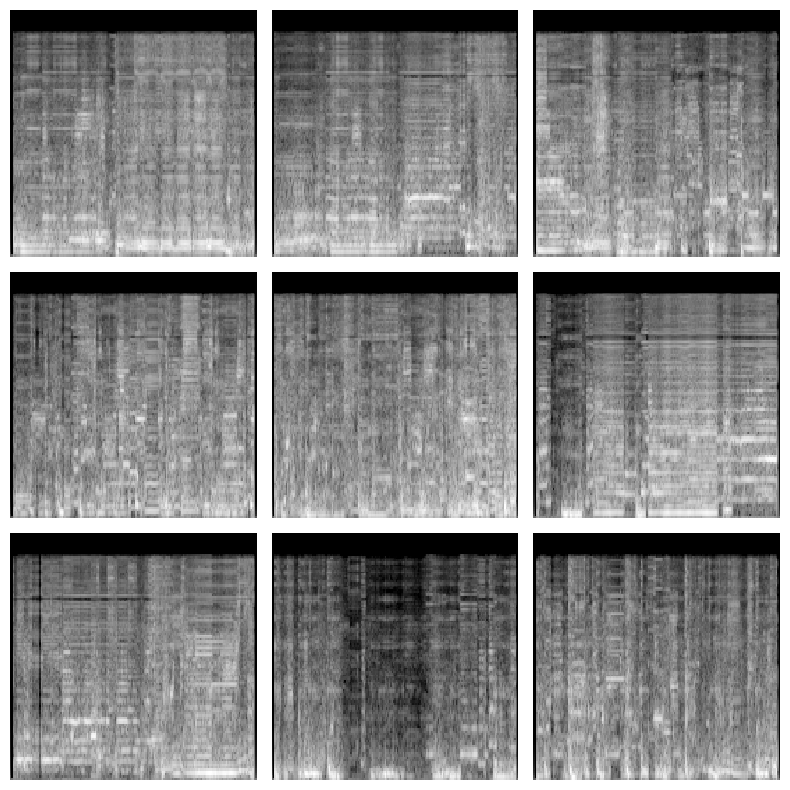

In [43]:
import librosa.display
import matplotlib.pyplot as plt

# Assuming gen_mel1 to gen_mel9 are mel-spectrograms
gen_mel1 = audio_to_melspectrogram(gen)
gen_mel2 = audio_to_melspectrogram(gen2)
gen_mel3 = audio_to_melspectrogram(gen3)
gen_mel4 = audio_to_melspectrogram(gen4)
gen_mel5 = audio_to_melspectrogram(gen5)
gen_mel6 = audio_to_melspectrogram(gen6)
gen_mel7 = audio_to_melspectrogram(gen7)
gen_mel8 = audio_to_melspectrogram(gen8)
gen_mel9 = audio_to_melspectrogram(gen9)

# Create a 3x3 grid of subplots
fig, ax = plt.subplots(3, 3, figsize=(8, 8))  # Set figsize if needed

# Plot each mel-spectrogram in its own subplot
librosa.display.specshow(gen_mel1, sr=sr, hop_length=512, x_axis='time', y_axis='mel', ax=ax[0, 0], cmap='gray')
ax[0, 0].axis('off')

librosa.display.specshow(gen_mel2, sr=sr, hop_length=512, x_axis='time', y_axis='mel', ax=ax[0, 1], cmap='gray')
ax[0, 1].axis('off')

librosa.display.specshow(gen_mel3, sr=sr, hop_length=512, x_axis='time', y_axis='mel', ax=ax[0, 2], cmap='gray')
ax[0, 2].axis('off')

librosa.display.specshow(gen_mel4, sr=sr, hop_length=512, x_axis='time', y_axis='mel', ax=ax[1, 0], cmap='gray')
ax[1, 0].axis('off')

librosa.display.specshow(gen_mel5, sr=sr, hop_length=512, x_axis='time', y_axis='mel', ax=ax[1, 1], cmap='gray')
ax[1, 1].axis('off')

librosa.display.specshow(gen_mel6, sr=sr, hop_length=512, x_axis='time', y_axis='mel', ax=ax[1, 2], cmap='gray')
ax[1, 2].axis('off')

librosa.display.specshow(gen_mel7, sr=sr, hop_length=512, x_axis='time', y_axis='mel', ax=ax[2, 0], cmap='gray')
ax[2, 0].axis('off')

librosa.display.specshow(gen_mel8, sr=sr, hop_length=512, x_axis='time', y_axis='mel', ax=ax[2, 1], cmap='gray')
ax[2, 1].axis('off')

librosa.display.specshow(gen_mel9, sr=sr, hop_length=512, x_axis='time', y_axis='mel', ax=ax[2, 2], cmap='gray')
ax[2, 2].axis('off')

# Adjust layout
plt.tight_layout()
plt.savefig('generated_mel_spectrograms_grid.png', dpi=300, bbox_inches='tight')
plt.show()
